# Credit Risk Modeling:

In [3]:
# import preliminary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import data
loan_data = pd.read_csv("loan_data.csv")
df = loan_data.copy()

In [5]:
# explore data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

- lots of data cleaning and preprocessing needs to be performed before the PD model can be created 

### Preprocessing Continuous Variables:

##### Employment length variable

- store preprocessed emp_length variable in new variable called emp_length_int
- replace the outputs + years, years, year with empty strings and replace < 1 year and n/a with 0
- the order of these operations is to prevent errors in the string replacements
- convert string data to numeric dtype

In [6]:
df["emp_length"].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [7]:
df["emp_length_int"] = df["emp_length"].str.replace("\+ years", "")
df["emp_length_int"] = df["emp_length_int"].str.replace("< 1 year", str(0))
df["emp_length_int"] = df["emp_length_int"].str.replace("n/a",  str(0))
df["emp_length_int"] = df["emp_length_int"].str.replace(" years", "")
df["emp_length_int"] = df["emp_length_int"].str.replace(" year", "")

df["emp_length_int"] = pd.to_numeric(df["emp_length_int"])

##### Term variable

- store preprocessed term variable in new variable called term_int
- remove the months string from data, so only the number is left
- convert string data to numeric dtype

In [8]:
df["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [9]:
df["term_int"] = df["term"]
df["term_int"] = df["term_int"].str.replace(" 36 months", str(36))
df["term_int"] = df["term_int"].str.replace(" 60 months", str(60))
df["term_int"] = pd.to_numeric(df["term_int"])

##### Earliest credit line variable

- convert string to datetime object to compute date intervals
- date intervals will represent months since the earliest credit line was issued, where the date of reference will be 2017-12-01
- this computation will cause negative months due to how one of pandas functions is set up, where years before 1970 in the data set will be interpreted as 20XX instead of 19XX. This issue will be fixed using some data manipulation

In [10]:
df["earliest_cr_line_date"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%y")
df["mths_since_earliest_cr_line"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["earliest_cr_line_date"]) / np.timedelta64(1, "M")))

In [11]:
print("="*75)
print("Fix Negative Months Data")
print("="*75)
print("Data before change (min is neg):\n")
print(df["mths_since_earliest_cr_line"].describe())
print("\n*negative months are not possible. need to fix error")
print("-"*75)
print("understanding why the data is negative:\n")
print(df.loc[:, ["earliest_cr_line", "earliest_cr_line_date", "mths_since_earliest_cr_line"]][df["mths_since_earliest_cr_line"] < 0])
print("\n*data before 1970 is being misrepresented as 20XX instead of 19XX,\n causing the negative months to our reference date")

print("-"*75)

print("**transforming data**\n")
idx_wrong_dates = []
for i in df["earliest_cr_line_date"].loc[df["earliest_cr_line_date"] > "2017-12-01"].index:
    idx_wrong_dates.append(i)

df["str_earliest_cr_line_date"] = df["earliest_cr_line_date"].dt.strftime('%Y-%m-%d')

str_earliest_cr_line_date_fixed = []

for i in idx_wrong_dates:
    str_earliest_cr_line_date_fixed.append((df["str_earliest_cr_line_date"][i].replace("20","19"),i))
    
for i, j in str_earliest_cr_line_date_fixed:
    df["str_earliest_cr_line_date"][j] = i
    
df["earliest_cr_line_date"] = pd.to_datetime(df["str_earliest_cr_line_date"], format="%Y-%m-%d")

df["mths_since_earliest_cr_line"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["earliest_cr_line_date"]) / np.timedelta64(1, "M")))

print(df["mths_since_earliest_cr_line"].describe())
print("\n*min data no longer negative")
print("-"*75)

Fix Negative Months Data
Data before change (min is neg):

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

*negative months are not possible. need to fix error
---------------------------------------------------------------------------
understanding why the data is negative:

       earliest_cr_line earliest_cr_line_date  mths_since_earliest_cr_line
1580             Sep-62            2062-09-01                       -537.0
1770             Sep-68            2068-09-01                       -609.0
2799             Sep-64            2064-09-01                       -561.0
3282             Sep-67            2067-09-01                       -597.0
3359             Feb-65            2065-02-01                       -566.0
...                 ...                   ...                          ...
464003     

##### Issue date variable

- convert string to datetime object to compute date intervals
- date intervals will represent months since the issue date, where the date of reference will be 2017-12-01

In [12]:
df["issue_d_date"] = pd.to_datetime(df["issue_d"], format="%b-%y")
df["mths_since_issue_d"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["issue_d_date"]) / np.timedelta64(1, "M")))

print("="*75)
print("Months Since Issue Date Variable Summary Table")
print("="*75)
print(df["mths_since_issue_d"].describe())
print("\n*no errors, can continue with data preprocessing")
print("-"*75)

Months Since Issue Date Variable Summary Table
count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

*no errors, can continue with data preprocessing
---------------------------------------------------------------------------


### Preprocessing Discrete Variables:

- the PD model will use a logistic regression
- for the model to work, all categorical columns will need to be transformed to dummy variables
- to retain readability of dummy variables, the following convention will be used: col_name, colon, category_name

In [13]:
loan_data_dummies = [pd.get_dummies(df["grade"], prefix="grade", prefix_sep=":"),
                     pd.get_dummies(df["sub_grade"], prefix="sub_grade", prefix_sep=":"),
                     pd.get_dummies(df["home_ownership"],prefix="home_ownership",prefix_sep=":"),
                     pd.get_dummies(df["verification_status"],prefix="verification_status",prefix_sep=":"),
                     pd.get_dummies(df["loan_status"],prefix="loan_status",prefix_sep=":"),
                     pd.get_dummies(df["purpose"],prefix="purpose",prefix_sep=":"),
                     pd.get_dummies(df["addr_state"],prefix="addr_state",prefix_sep=":"),
                     pd.get_dummies(df["initial_list_status"],prefix="initial_list_status",prefix_sep=":")]

loan_data_dummies = pd.concat(loan_data_dummies, axis=1)

# concat dummies to original dataframe
df_after_dummies = pd.concat([df, loan_data_dummies], axis=1)

### Columns with missing values:

- total_rev_hi_lim (70,276 missing values): if data is not present for this column, it will be assumed that the value is equal to the funded amount of the loan
- annual_inc (4 missing values): if data is not present for this column, it will be assumed that the annual income is equal to the average annual income of the data set
- all remaining columns with missing values will be imputed with zeros

In [14]:
df_after_dummies["total_rev_hi_lim"].fillna(df_after_dummies["funded_amnt"], inplace=True)
df_after_dummies["annual_inc"].fillna(df_after_dummies["annual_inc"].mean(), inplace=True)

cols_inpute_as_zero = ["mths_since_earliest_cr_line", "acc_now_delinq", "total_acc", "pub_rec", 
                       "open_acc", "inq_last_6mths", "delinq_2yrs","emp_length_int"]

print("="*75)
print("Test for imputed data:")
print("="*75)
for i in cols_inpute_as_zero:
    df_after_dummies[i].fillna(0, inplace=True)
    print(i + ": ", df_after_dummies[i].isnull().sum(), "- SUCCESS" if df_after_dummies[i].isnull().sum() == 0 else "- ERROR")

print("\n*no errors found in imputing data")    
print("-"*75)

Test for imputed data:
mths_since_earliest_cr_line:  0 - SUCCESS
acc_now_delinq:  0 - SUCCESS
total_acc:  0 - SUCCESS
pub_rec:  0 - SUCCESS
open_acc:  0 - SUCCESS
inq_last_6mths:  0 - SUCCESS
delinq_2yrs:  0 - SUCCESS
emp_length_int:  0 - SUCCESS

*no errors found in imputing data
---------------------------------------------------------------------------


### PD Model: Data Preparation:

In the following section, the data will be further processed to be made ready for the PD model:

- fine and course classing independent variables using the weight of evidence and information value will be implemented to help select independent variables, applying any data processing when deemed necessary

Explanations about these preprocessing techniques is detailed below:

#### Fine classing independent variables:

Using weight of evidence (WOE), that is, the extent  an independent variable being able to predict a dependent variable, we will develop an understanding of the appropriate categories to form for the dependent variables

WOE = In( % good_i / % bad_i ), where i is the category of a independent variable (e.x -> if we have a column called education_completed, then i would be the categories withing the education_completed column such as highschool, post-secondary, etc.)

#### Course classing independent variables:

Categories with similar weights of evidence will be bundled together to decrease the complexity for the logistic regression model, resulting in a more efficient model output

#### Information value:

The information value tells us how much information the original independent variable brings with repsect to explaining the dependent variable. This will help us preselect variables yielding higher predictive power for our model

Interpreting the information value:
- i_v < 0.02 -> no predictive power
- 0.02 < i_v < 0.1 -> weak predictive power
- 0.1 < i_v < 0.3 -> medium predictive power
- 0.3 < i_v < 0.5 -> strong predictive power
- i_v > 0.5 -> suspiciously high, too good to be true

information_value = sum of k categories i to k [(% good - % bad] * In( % good / % bad)]

Our y-label, dependent variable, in the PD model will be whether the loan is "good" or "bad". We will define the criteria for "bad" loans in our training dataset as those loans that have defaulted, have been charged off, do not meet the credit policy and has been charged off or loans that have been highlighted as late (31-120) days. These loans will be labelled with a 0. All other loan statuses will be labelled with a 1

In [15]:
default_status = ["Default", "Charged Off", "Does not meet credit policy. Status:Charged Off", "Late (31-120 days)"]
df_after_dummies["good_bad"] = np.where(df_after_dummies["loan_status"].isin(default_status), 0, 1)

#### Splitting data into training and testing sets:

In [16]:
# label dependent and independent variable(s) with X and y respectively
X = df_after_dummies.drop("good_bad", axis=1)
y = df_after_dummies["good_bad"]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# helper function to calculate weight of evidence and information value for our discrete variables
def woe_discrete(df, discrete_var, good_bad_var_df):
    df = pd.concat([df[discrete_var], good_bad_var_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
           df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()],
          axis=1).iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], "n_obs", "prop_good"]
    df["props_n_obs"] = df["n_obs"] / df["n_obs"].sum()
    df["n_good"] = df["prop_good"] * df["n_obs"]
    df["n_bad"] = (1 - df["prop_good"]) * df["n_obs"]
    df["prob_n_good"] = df["n_good"] / df["n_good"].sum()
    df["prob_n_bad"] = df["n_bad"] / df["n_bad"].sum()
    df["WoE"] = np.log(df["prob_n_good"] / df["prob_n_bad"])
    df = df.sort_values(["WoE"])
    df = df.reset_index(drop=True)
    df["diff_prop_good"] = df["prop_good"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    df["i_v"] = (df["prob_n_good"] - df["prob_n_bad"]) * df["WoE"]
    df["i_v_sum"] = df["i_v"].sum()
    
    return df

# helper function to visualize the discrete variables
def plot_by_woe(df_WoE, rotation_of_x_axis_labels=0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE["WoE"]
    
    plt.figure(figsize=(18,6), dpi=150)
    plt.plot(x, y, marker="o", ls="--", c="k")
    
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel("Weight of Evidence")
    plt.title(str("Weight of Evidence by " + df_WoE.columns[0]))
    
    plt.xticks(rotation=rotation_of_x_axis_labels)

### Preprocessing discrete variables: 

##### Home ownership variable

- the NONE, OTHER and ANY categories within the home_ownership variable have very few observations, therefore, these 3 categories will be grouped with the RENT category to prevent information loss, as it is the next category with the lowest weight of evidence, representing the riskiest category amongst the home_ownership variable

In [19]:
df_home_ownership = woe_discrete(X_train, "home_ownership", y_train)

df_home_ownership

home_ownership   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0           NONE      40   0.850000     0.000107      34.0      6.0   
1          OTHER     137   0.854015     0.000367     117.0     20.0   
2           RENT  150599   0.875776     0.403720  131891.0  18708.0   
3            OWN   33295   0.893798     0.089256   29759.0   3536.0   
4       MORTGAGE  188956   0.905295     0.506546  171061.0  17895.0   
5            ANY       1   1.000000     0.000003       1.0      0.0   

   prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0     0.000102    0.000149 -0.380134             NaN       NaN  0.000018   
1     0.000351    0.000498 -0.348293        0.004015  0.031841  0.000051   
2     0.396232    0.465779 -0.161710        0.021761  0.186583  0.011246   
3     0.089403    0.088037  0.015400        0.018022  0.177111  0.000021   
4     0.513908    0.445537  0.142764        0.011498  0.127363  0.009761   
5     0.000003    0.000000       inf        0.094705       inf       inf   

   i_v_sum  
0      inf  
1      inf  
2      inf  
3      inf  
4      inf  
5      inf

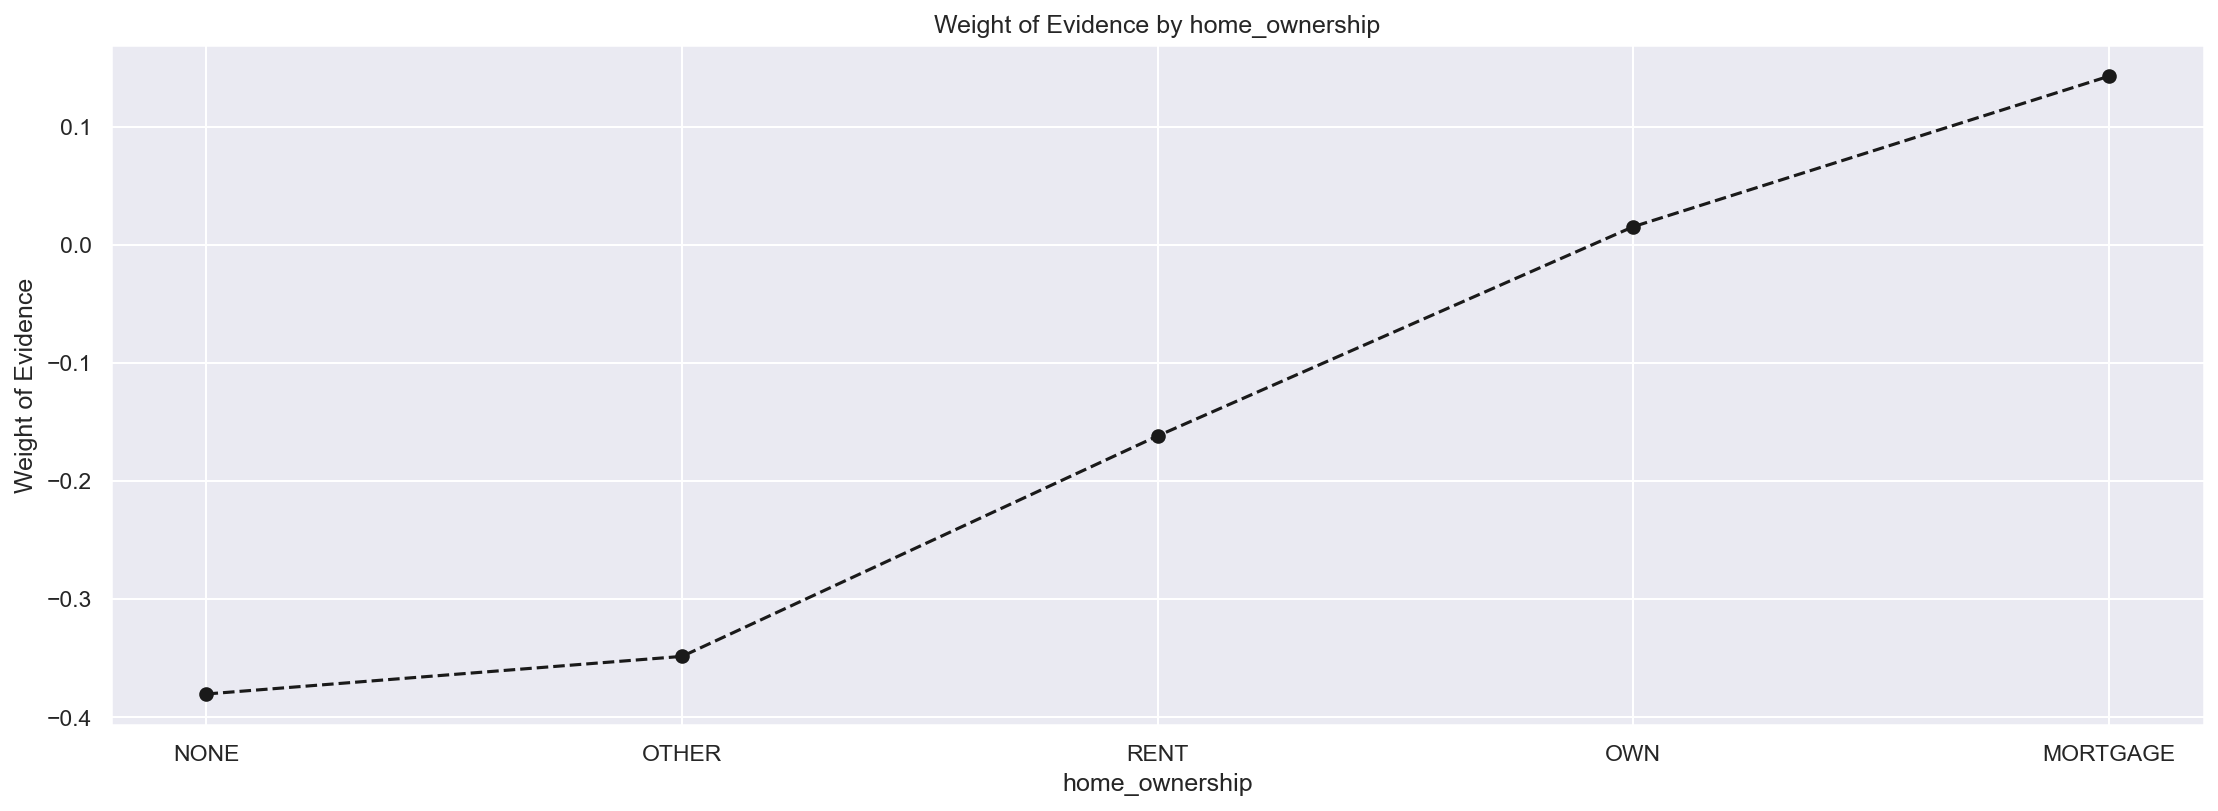

In [20]:
plot_by_woe(df_home_ownership)

In [21]:
X_train["home_ownership:RENT_OTHER_NONE_ANY"] = sum([X_train["home_ownership:RENT"],X_train["home_ownership:OTHER"],
                                                    X_train["home_ownership:NONE"], X_train["home_ownership:ANY"]])

##### Address state variable

In [22]:
addr_state_df = woe_discrete(X_train, "addr_state", y_train)
addr_state_df

addr_state  n_obs  prop_good  props_n_obs   n_good   n_bad  prob_n_good  \
0          NE     13   0.692308     0.000035      9.0     4.0     0.000027   
1          NV   5221   0.867075     0.013996   4527.0   694.0     0.013600   
2          FL  25211   0.878029     0.067585  22136.0  3075.0     0.066502   
3          HI   2001   0.878061     0.005364   1757.0   244.0     0.005278   
4          AL   4671   0.878399     0.012522   4103.0   568.0     0.012326   
5          NM   2075   0.884819     0.005563   1836.0   239.0     0.005516   
6          VA  11366   0.884920     0.030470  10058.0  1308.0     0.030217   
7          OK   3284   0.885201     0.008804   2907.0   377.0     0.008733   
8          TN   4845   0.885449     0.012988   4290.0   555.0     0.012888   
9          NY  32211   0.885536     0.086350  28524.0  3687.0     0.085693   
10         LA   4359   0.886212     0.011685   3863.0   496.0     0.011605   
11         NC  10204   0.886515     0.027355   9046.0  1158.0     0.027176   
12         CA  57199   0.887096     0.153337  50741.0  6458.0     0.152438   
13         MD   8771   0.887926     0.023513   7788.0   983.0     0.023397   
14         UT   2756   0.888244     0.007388   2448.0   308.0     0.007354   
15         MO   6017   0.888649     0.016130   5347.0   670.0     0.016064   
16         NJ  14385   0.889399     0.038563  12794.0  1591.0     0.038436   
17         KY   3587   0.889880     0.009616   3192.0   395.0     0.009590   
18         AZ   8645   0.890226     0.023175   7696.0   949.0     0.023121   
19         AR   2760   0.891667     0.007399   2461.0   299.0     0.007393   
20         OH  12135   0.891965     0.032531  10824.0  1311.0     0.032518   
21         MN   6526   0.892430     0.017495   5824.0   702.0     0.017497   
22         MI   9191   0.892504     0.024639   8203.0   988.0     0.024644   
23         PA  13090   0.893125     0.035091  11691.0  1399.0     0.035123   
24         SD    801   0.893883     0.002147    716.0    85.0     0.002151   
25         RI   1647   0.894353     0.004415   1473.0   174.0     0.004425   
26         IN   5210   0.894818     0.013967   4662.0   548.0     0.014006   
27         MA   8858   0.895462     0.023746   7932.0   926.0     0.023830   
28         DE   1064   0.895677     0.002852    953.0   111.0     0.002863   
29         WA   8372   0.898591     0.022443   7523.0   849.0     0.022601   
30         OR   4814   0.898629     0.012905   4326.0   488.0     0.012996   
31         GA  11960   0.899498     0.032062  10758.0  1202.0     0.032320   
32         WI   4740   0.902110     0.012707   4276.0   464.0     0.012846   
33         TX  29158   0.905103     0.078166  26391.0  2767.0     0.079285   
34         MT   1103   0.906618     0.002957   1000.0   103.0     0.003004   
35         IL  14833   0.906695     0.039764  13449.0  1384.0     0.040404   
36         CT   5775   0.907186     0.015481   5239.0   536.0     0.015739   
37         KS   3360   0.908929     0.009007   3054.0   306.0     0.009175   
38         SC   4448   0.909847     0.011924   4047.0   401.0     0.012158   
39         CO   7823   0.910904     0.020972   7126.0   697.0     0.021408   
40         VT    727   0.911967     0.001949    663.0    64.0     0.001992   
41         AK   1003   0.912263     0.002689    915.0    88.0     0.002749   
42         MS    980   0.916327     0.002627    898.0    82.0     0.002698   
43         WV   1926   0.921080     0.005163   1774.0   152.0     0.005330   
44         NH   1830   0.922951     0.004906   1689.0   141.0     0.005074   
45         IA     13   0.923077     0.000035     12.0     1.0     0.000036   
46         WY    919   0.928183     0.002464    853.0    66.0     0.002563   
47         DC   1129   0.936227     0.003027   1057.0    72.0     0.003175   
48         ME      2   1.000000     0.000005      2.0     0.0     0.000006   
49         ID     10   1.000000     0.000027     10.0     0.0     0.000030   

    prob_n_bad       WoE

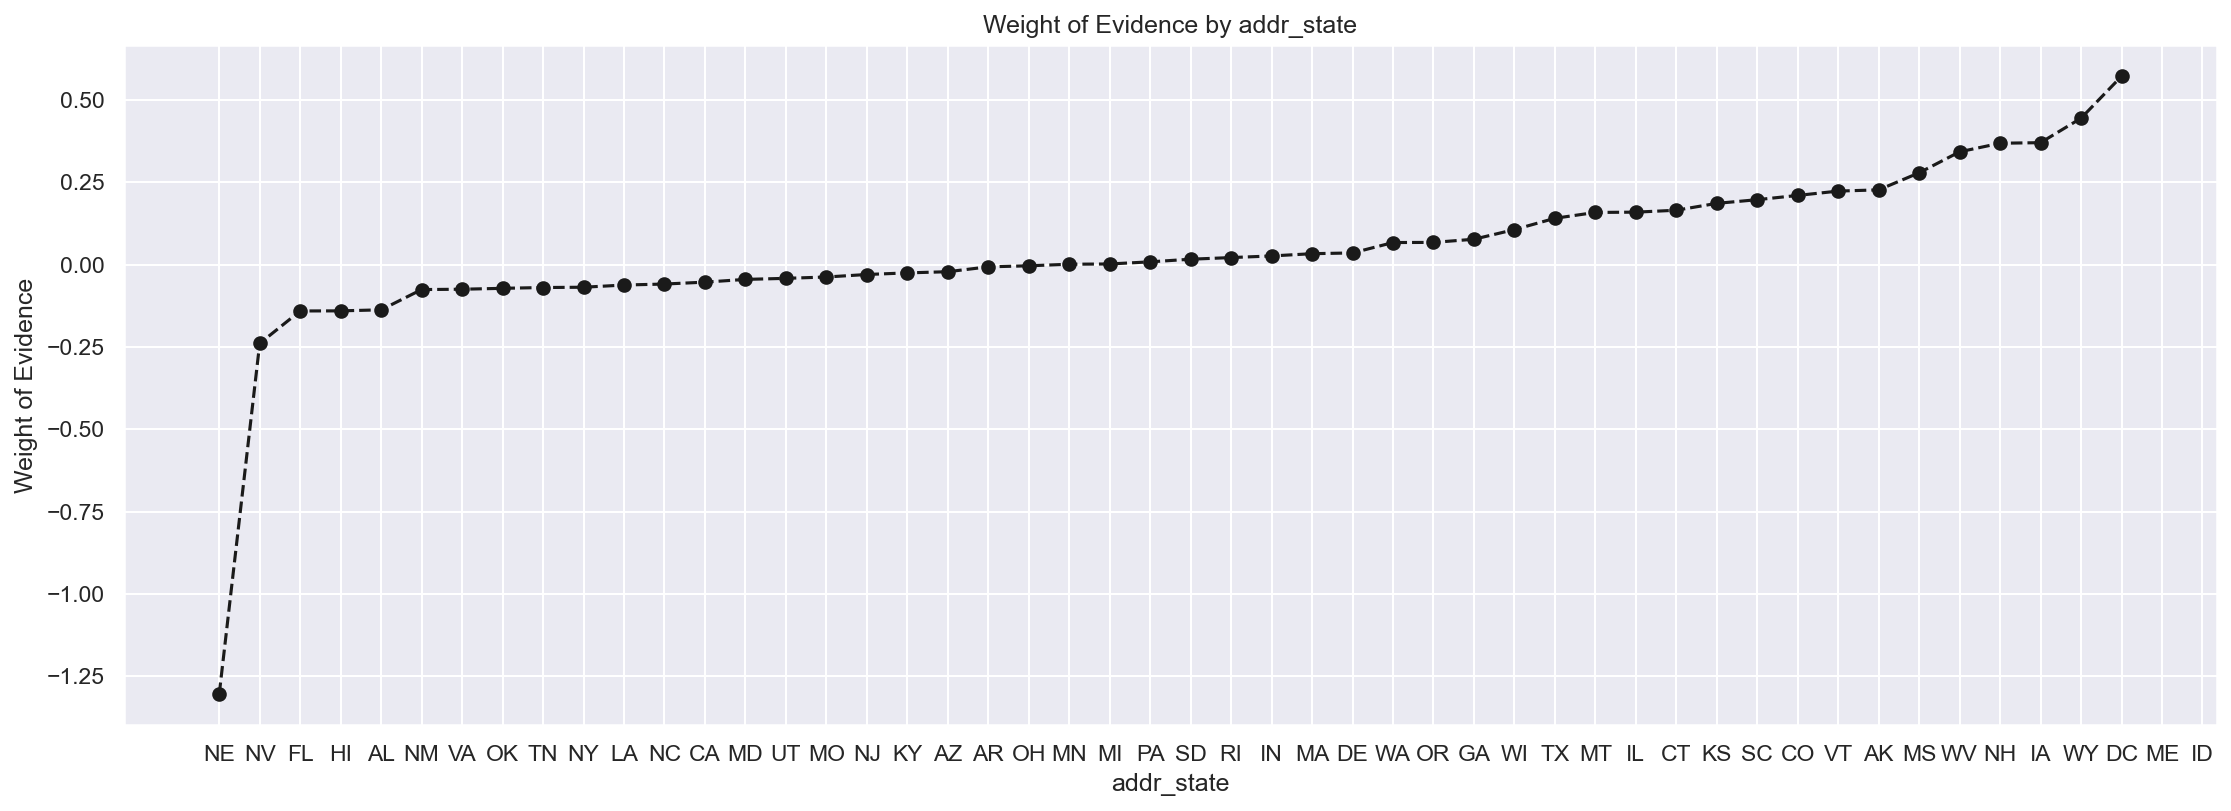

In [23]:
plot_by_woe(addr_state_df)

- missing state: ND, likely due to there being no borrowers from here. Create category within dataset in case this changes in the future

In [24]:
if ["addr_state:ND"] in X_train.columns.values:
    pass
else:
    X_train["addr_state:ND"] = 0

- NE has a large deviance in weight of evidence, shrinking the impact of other states, leading us to believe they all fall into a similar category. NE will be removed to visualize better groupings

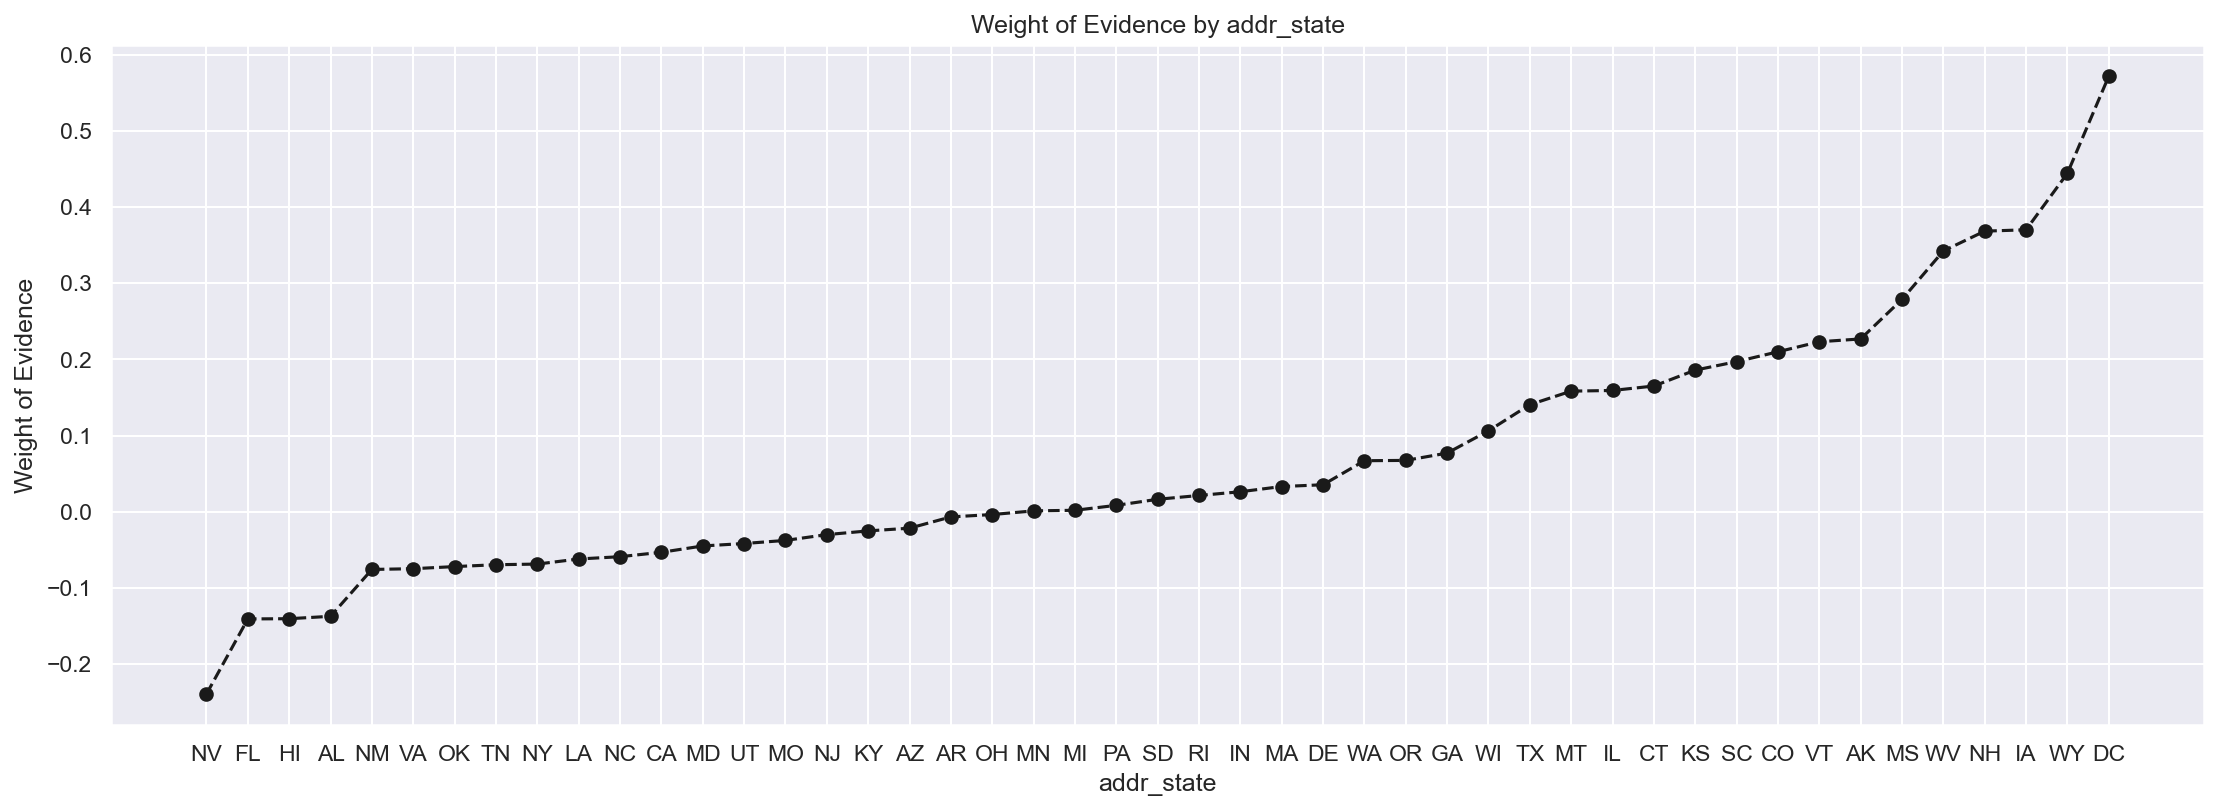

In [25]:
# removing NE, NV and ID
plot_by_woe(addr_state_df.iloc[1:-2, :])

- after removing NE, we can see more prominent groupings appear
- since NE and NV have a smaller number of observations, we will group them with the next riskiest category, FL, which has a significant number of observations. HI and AL seem to have a similar grouping based on the chart above, therefore, these 2 states will also be grouped with the FL category
- ND, which has no borrowers in this dataset, will also be grouped with FL, since we have no information about these borrowers. We treat this category conservatibely to manage any unexpected risk from these potential borrowers

In [26]:
X_train["addr_state:ND_NE_NV_FL_HI_AL"] = sum([X_train["addr_state:ND"], X_train["addr_state:NE"],
                                               X_train["addr_state:NV"],X_train["addr_state:FL"], 
                                               X_train["addr_state:HI"], X_train["addr_state:AL"]])

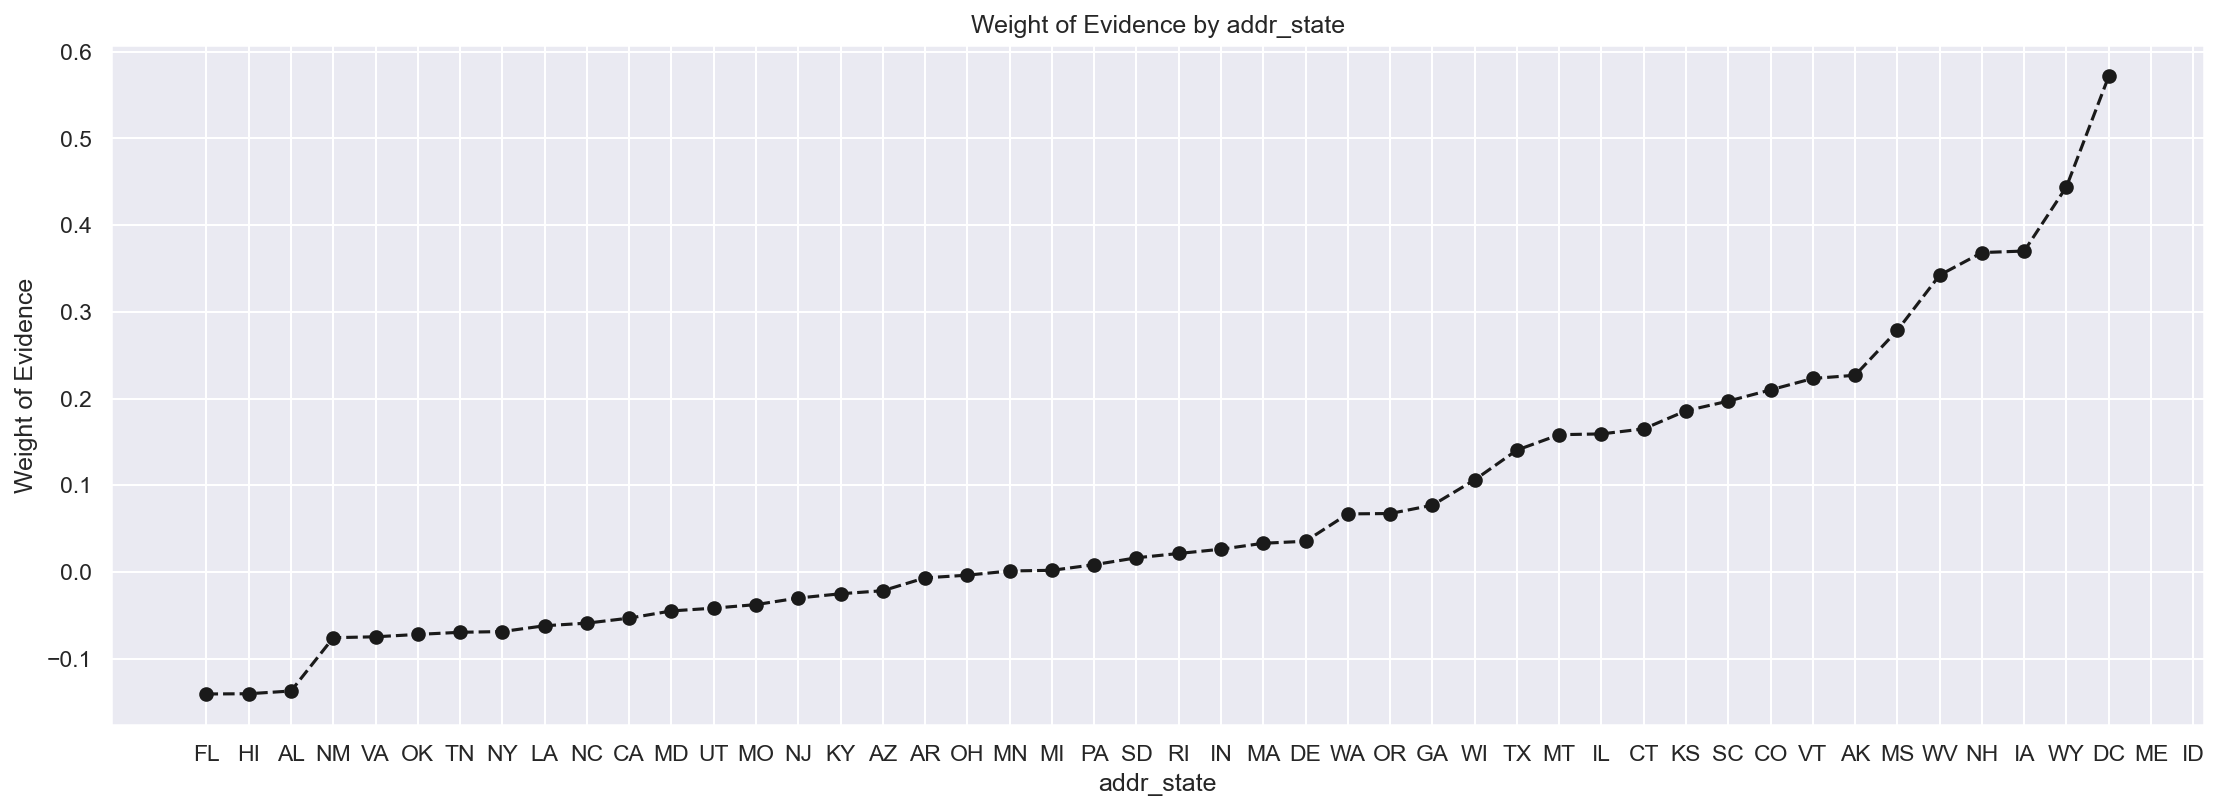

In [27]:
plot_by_woe(addr_state_df.iloc[2:, :])

- similarly, WV, NH, IA, WY and DC can be considered a single group, since they also have a smaller number of observations and fall into the category of borrowers with the lowest risk of default
- ME and ID will also be incliuded in this group as they are in the upper bound, but do not have a weight of evidence value, due to the low number of observations resulting in a 0 probability of n good and bad columns

In [28]:
X_train["addr_state:WV_NH_IA_WY_DC_ME_ID"] = sum([X_train["addr_state:WV"], X_train["addr_state:NH"],
                                                  X_train["addr_state:IA"], X_train["addr_state:WY"], 
                                                  X_train["addr_state:DC"], X_train["addr_state:ME"], 
                                                  X_train["addr_state:ID"]])

- visualize remaining states for grouping

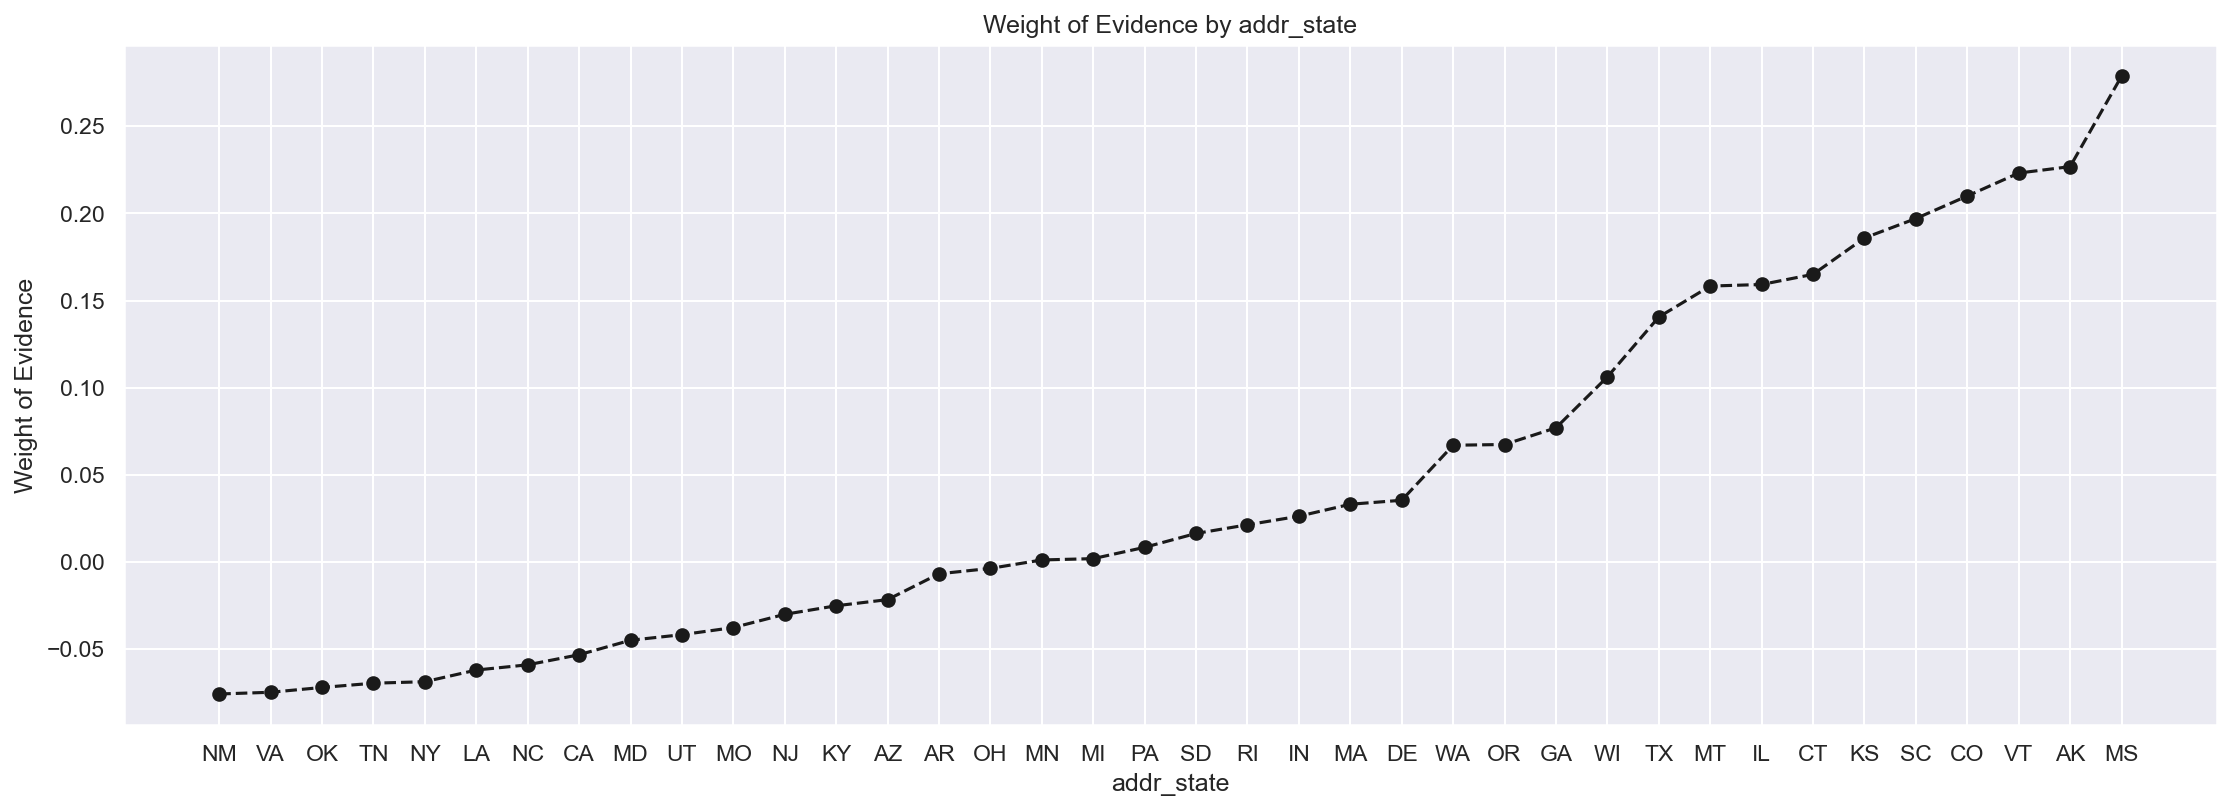

In [29]:
plot_by_woe(addr_state_df.iloc[5:-7, :])

- NM, VA, OK, TN, NY, LA, NC and CA are have similar weight of evidence, however, the number of observations for NY and CA are much higher than the other states in this group. Therefore, we will opt to make NY and CA their own separate categories, where all other states will fall into the groupings between

Resulting in the following groupings: 
- (1) ND, NE, NV, FL, HI, AL
- (2) NM, VA, OK, TN 
- (3) NY 
- (4) LA, NC 
- (5) CA 

In [30]:
X_train["addr_state:NM_VA_OK_TN"] = sum([X_train["addr_state:NM"], X_train["addr_state:VA"],
                                         X_train["addr_state:OK"], X_train["addr_state:TN"]])

X_train["addr_state:LA_NC"] = sum([X_train["addr_state:LA"], X_train["addr_state:NC"]])

- visualize remaining states for grouping

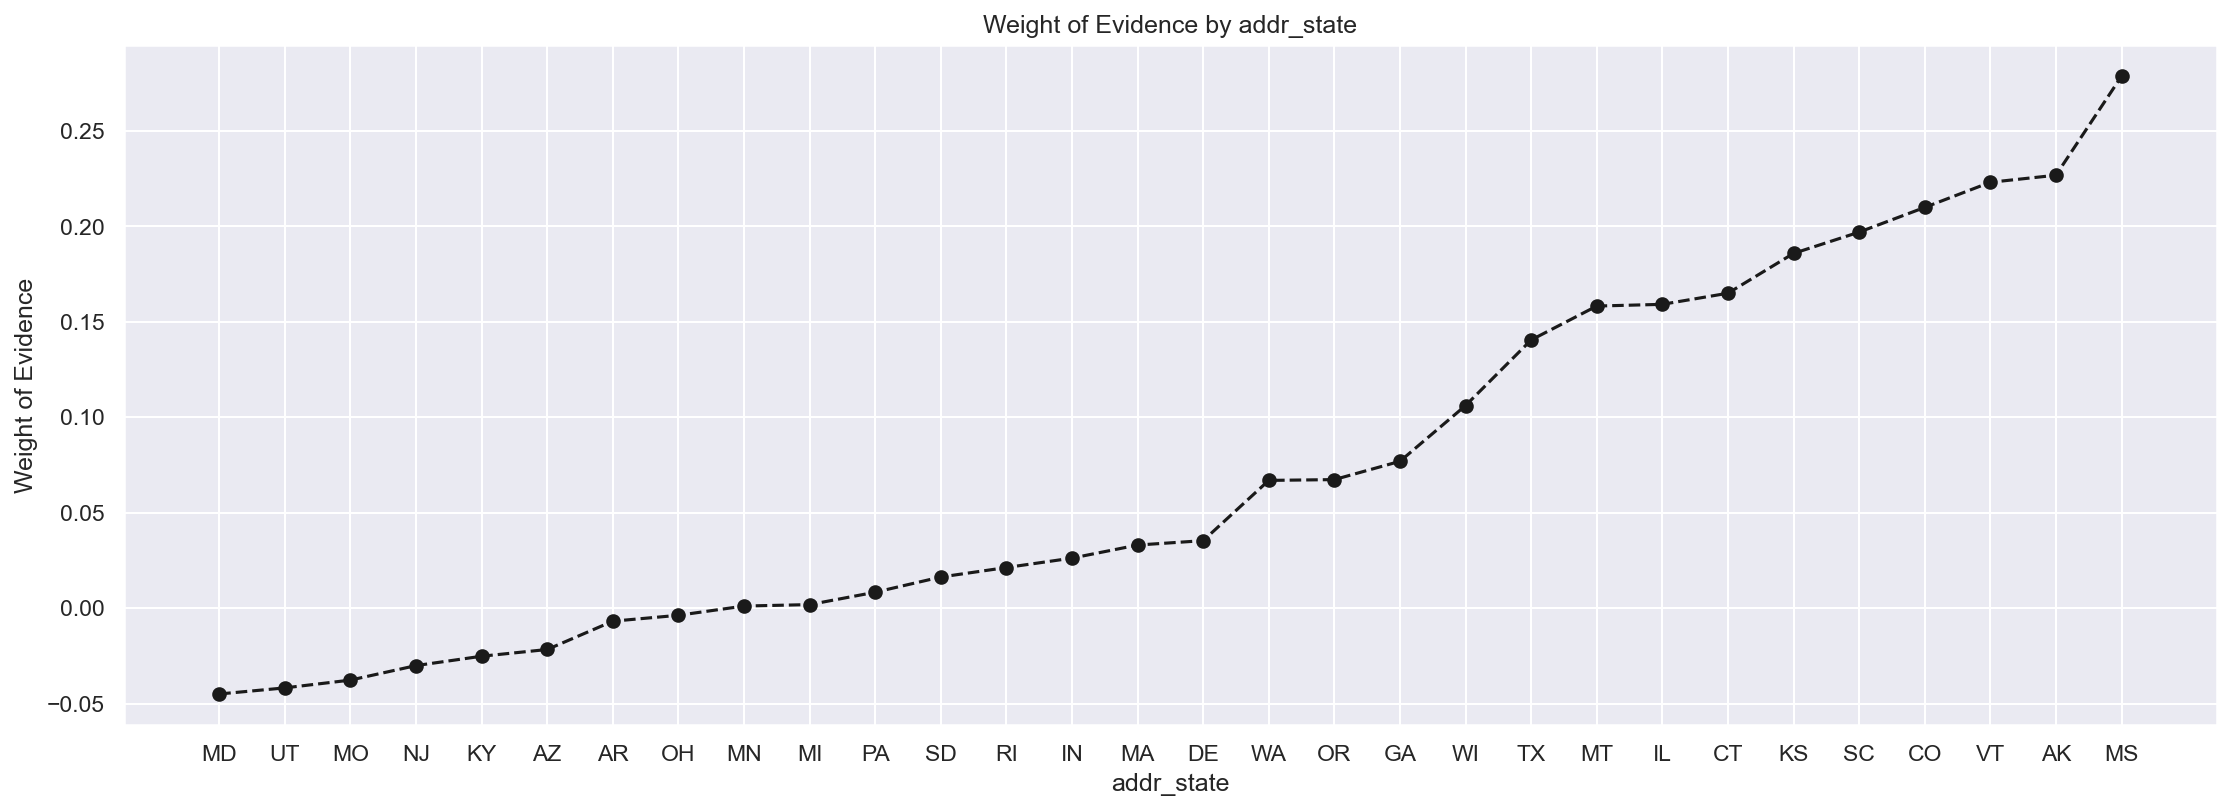

In [31]:
plot_by_woe(addr_state_df.iloc[13:-7, :])

The next groupings are: 
- (6) MD, UT, MO 
- (7) NJ, KY, AZ 
- (8) AR, OH, MN, MI 
- (9) PA, SD, RI, IN, MA, DE 
- (10) WA, OR, GA, WI 
- (11) TX
- (12) MT, IL, CT 
- (13) KS, SC, CO, VT, AK, MS

WI is grouped with WA, OR, GA because the next state, TX, has a significant number of observations, so we would like to make it its own category, whereas the number of observations in WI is not significant, so we group it in with the previous category, despite the slight visual jump in weight of evidence 

the states in group 13 have been merged together because there isn't a significant number of observations for each of these states, making their weight of evidences somewhat more unreliable


In [32]:
X_train["addr_state:MD_UT_MO"] = sum([X_train["addr_state:MD"], X_train["addr_state:UT"],
                                      X_train["addr_state:MO"]])

X_train["addr_state:NJ_KY_AZ"] = sum([X_train["addr_state:NJ"], X_train["addr_state:KY"],
                                      X_train["addr_state:AZ"]])

X_train["addr_state:AR_OH_MN_MI"] = sum([X_train["addr_state:AR"], X_train["addr_state:OH"],
                                         X_train["addr_state:MN"], X_train["addr_state:MI"]])

X_train["addr_state:PA_SD_RI_IN_MA_DE"] = sum([X_train["addr_state:PA"], X_train["addr_state:SD"],
                                         X_train["addr_state:RI"], X_train["addr_state:IN"],
                                         X_train["addr_state:MA"], X_train["addr_state:DE"]])

X_train["addr_state:WA_OR_GA_WI"] = sum([X_train["addr_state:WA"], X_train["addr_state:OR"],
                                         X_train["addr_state:GA"], X_train["addr_state:WI"]])

X_train["addr_state:MT_IL_CT"] = sum([X_train["addr_state:MT"], X_train["addr_state:IL"],
                                      X_train["addr_state:CT"]])

X_train["addr_state:KS_SC_CO_VT_AK_MS"] = sum([X_train["addr_state:KS"], X_train["addr_state:SC"],
                                         X_train["addr_state:CO"], X_train["addr_state:VT"],
                                         X_train["addr_state:AK"], X_train["addr_state:MS"]])

* note that all states that had their own groups were not created into separate columns, since those columns already exist within the dataset

##### Verification status variable

- there are 3 distinct separate categories, therefore, no additional preprocessing is required

In [33]:
verification_status_df = woe_discrete(X_train, "verification_status", y_train)
verification_status_df

verification_status   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0            Verified  134414   0.873696     0.360332  117437.0  16977.0   
1     Source Verified  120030   0.896484     0.321772  107605.0  12425.0   
2        Not Verified  118584   0.909237     0.317896  107821.0  10763.0   

   prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0     0.352809    0.422681 -0.180692             NaN       NaN  0.012625   
1     0.323271    0.309349  0.044022        0.022788  0.224714  0.000613   
2     0.323920    0.267970  0.189623        0.012753  0.145602  0.010609   

    i_v_sum  
0  0.023848  
1  0.023848  
2  0.023848

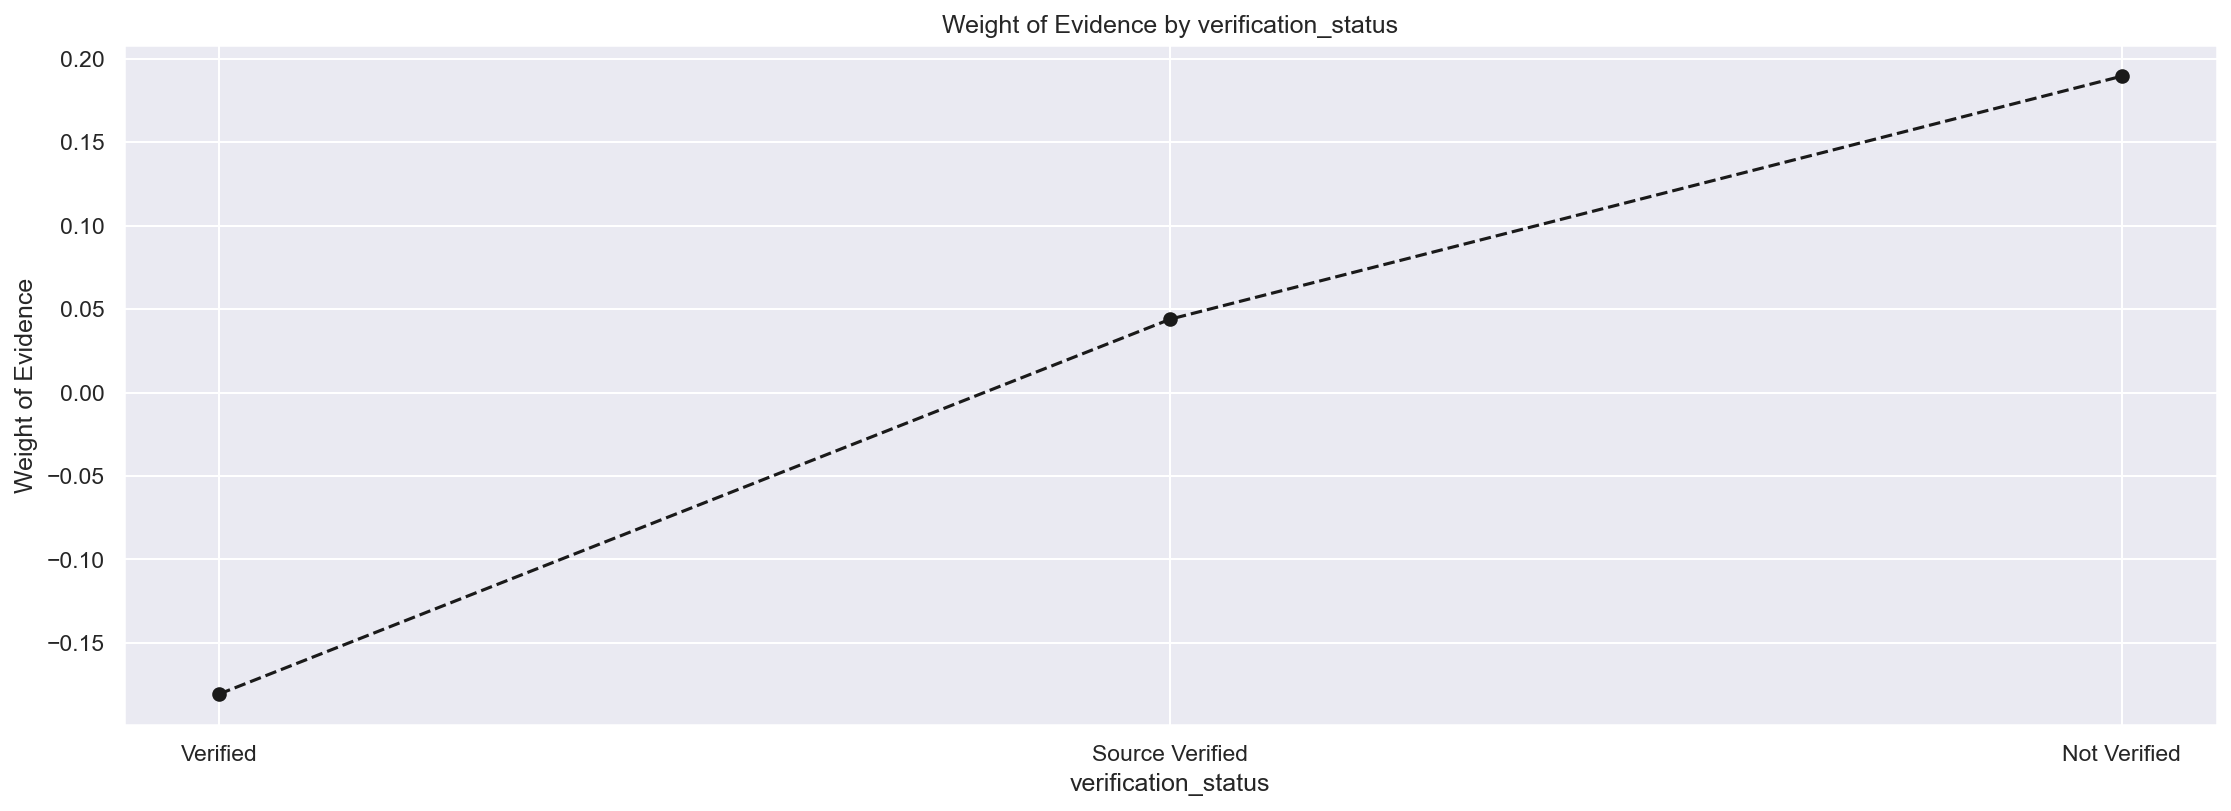

In [34]:
plot_by_woe(verification_status_df)

##### Purpose variable

There will be 5 groupings:

- (1) small_business, moving, house, other, renewable_energy
- (2) medical, educational, vacation, wedding
- (3) debt_consolidation
- (4) home_improvement, major_purchase, car
- (5) credit_card

The categories debt_consolidation and credit_card have considerably larger number of observations, resulting in them being stand alone categories. All other categories are grouped together taking into consideration weight of evidence and number of observations

In [35]:
purpose_df = woe_discrete(X_train, "purpose", y_train)
purpose_df

purpose   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0       small_business    5582   0.795951     0.014964    4443.0   1139.0   
1               moving    2392   0.845736     0.006412    2023.0    369.0   
2                house    1830   0.865574     0.004906    1584.0    246.0   
3                other   18884   0.867348     0.050624   16379.0   2505.0   
4     renewable_energy     281   0.868327     0.000753     244.0     37.0   
5              medical    3684   0.872693     0.009876    3215.0    469.0   
6          educational     333   0.873874     0.000893     291.0     42.0   
7             vacation    1991   0.884982     0.005337    1762.0    229.0   
8              wedding    1887   0.887652     0.005059    1675.0    212.0   
9   debt_consolidation  219183   0.887975     0.587578  194629.0  24554.0   
10    home_improvement   21238   0.903098     0.056934   19180.0   2058.0   
11      major_purchase    7837   0.908128     0.021009    7117.0    720.0   
12                 car    4325   0.912370     0.011594    3946.0    379.0   
13         credit_card   83581   0.913784     0.224061   76375.0   7206.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.013348    0.028358 -0.753556             NaN       NaN  0.011311   
1      0.006078    0.009187 -0.413195        0.049785  0.340361  0.001285   
2      0.004759    0.006125 -0.252358        0.019838  0.160837  0.000345   
3      0.049206    0.062368 -0.237024        0.001774  0.015334  0.003120   
4      0.000733    0.000921 -0.228485        0.000979  0.008539  0.000043   
5      0.009659    0.011677 -0.189755        0.004365  0.038730  0.000383   
6      0.000874    0.001046 -0.179081        0.001181  0.010674  0.000031   
7      0.005293    0.005701 -0.074252        0.011109  0.104829  0.000030   
8      0.005032    0.005278 -0.047753        0.002670  0.026499  0.000012   
9      0.584712    0.611328 -0.044515        0.000323  0.003238  0.001185   
10     0.057621    0.051239  0.117398        0.015123  0.161913  0.000749   
11     0.021381    0.017926  0.176255        0.005030  0.058857  0.000609   
12     0.011855    0.009436  0.228186        0.004242  0.051931  0.000552   
13     0.229449    0.179410  0.246006        0.001414  0.017820  0.012310   

     i_v_sum  
0   0.031964  
1   0.031964  
2   0.031964  
3   0.031964  
4   0.031964  
5   0.031964  
6   0.031964  
7   0.031964  
8   0.031964  
9   0.031964  
10  0.031964  
11  0.031964  
12  0.031964  
13  0.031964

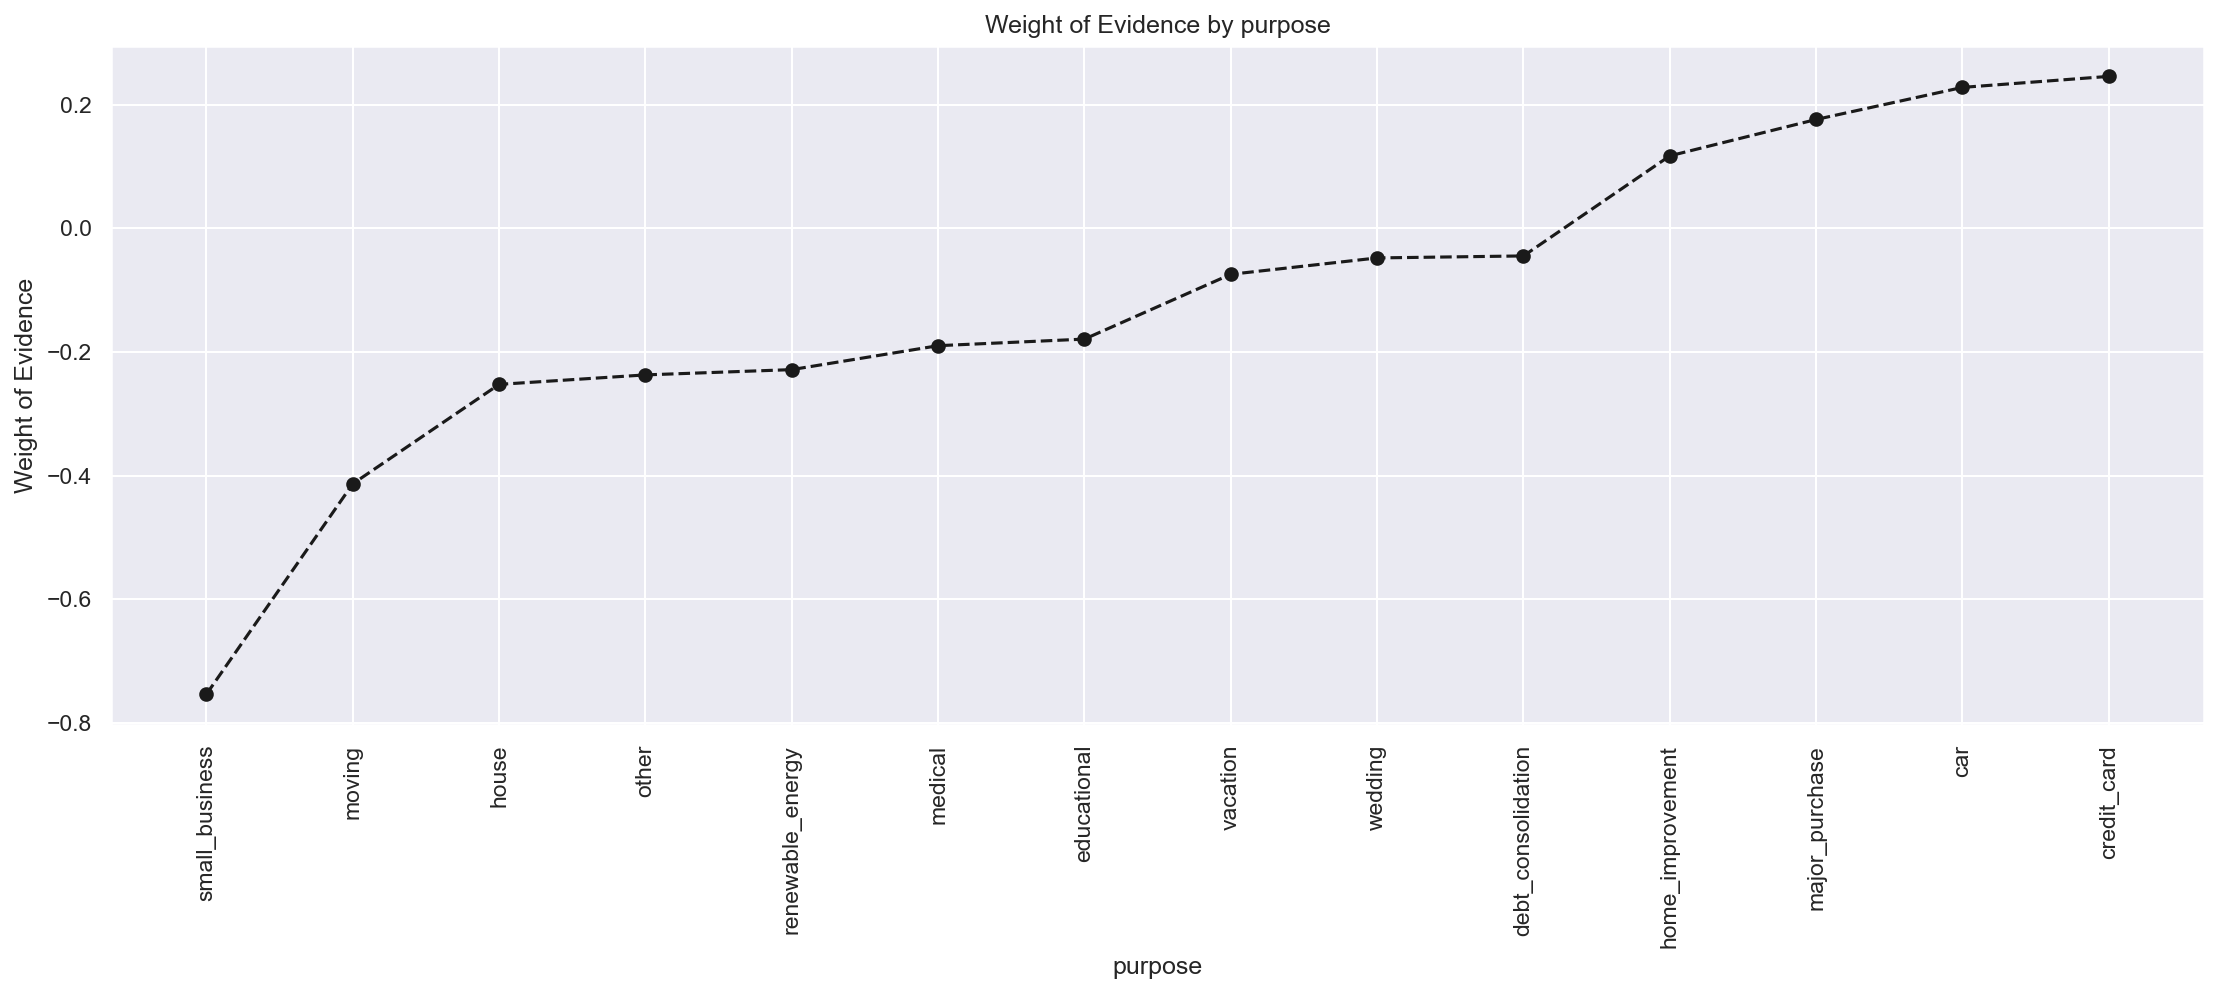

In [36]:
plot_by_woe(purpose_df,90)

In [37]:
X_train["purpose:sm_b__moving__housing__other__ren_en"] = sum([X_train["purpose:small_business"],
                                                               X_train["purpose:moving"], X_train["purpose:house"],
                                                               X_train["purpose:other"], 
                                                               X_train["purpose:renewable_energy"]])

X_train["purpose:med__educ__vacation_wedding"] = sum([X_train["purpose:medical"], X_train["purpose:educational"],
                                                      X_train["purpose:vacation"], X_train["purpose:wedding"]])

X_train["purpose:home_improv__major_purch__car"] = sum([X_train["purpose:home_improvement"], 
                                                        X_train["purpose:major_purchase"], X_train["purpose:car"]])

##### Initial list status variable

- there are 2 distinct separate categories, therefore, no additional preprocessing is required

In [38]:
initial_list_status_df = woe_discrete(X_train, "initial_list_status", y_train)
initial_list_status_df

initial_list_status   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0                   f  242514   0.882221     0.650123  213951.0  28563.0   
1                   w  130514   0.911105     0.349877  118912.0  11602.0   

   prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.64276    0.711142 -0.101100             NaN       NaN  0.006913   
1      0.35724    0.288858  0.212471        0.028884  0.313571  0.014529   

    i_v_sum  
0  0.021443  
1  0.021443

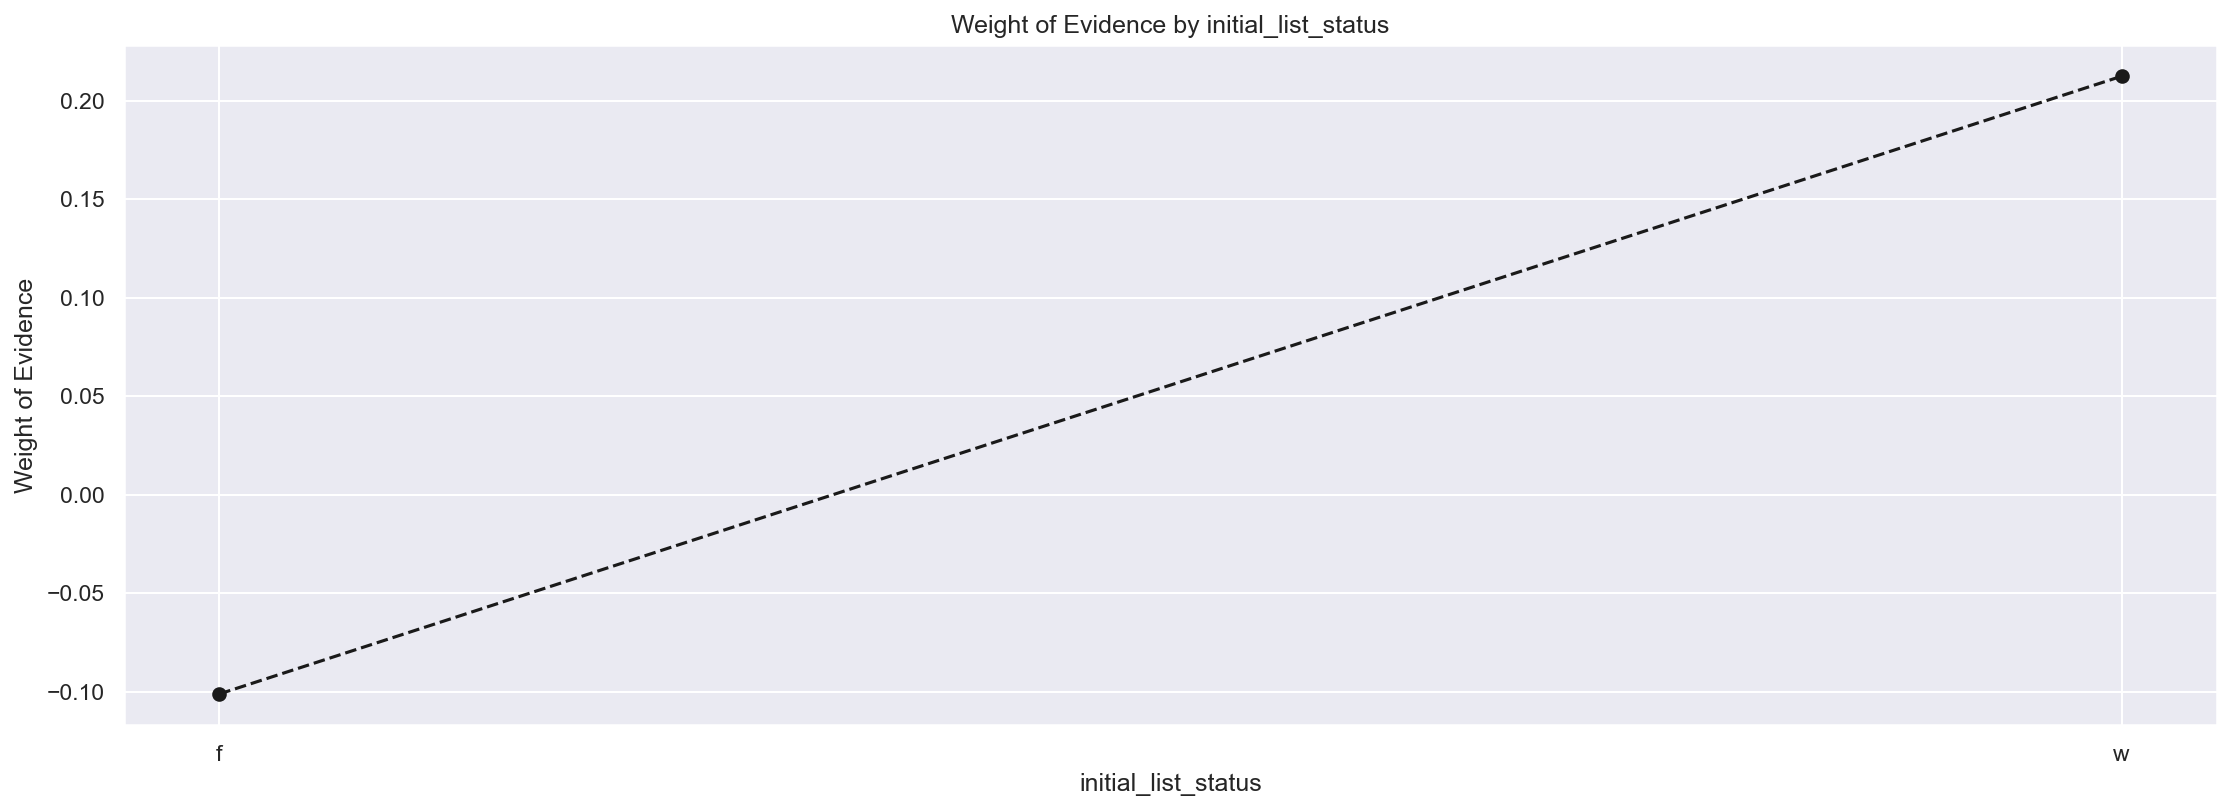

In [39]:
plot_by_woe(initial_list_status_df)

List of discrete dummy variables that will be used in PD model so far:

- grade
- home_ownership
- addr_state
- verification_status
- purpose
- initial_list_status

### Preprocessing continuous variables:

In [40]:
# helper function to calculate weight of evidence and information value for our continuous variables
def woe_ordered_continuous(df, continuous_var, good_bad_var_df):
    df = pd.concat([df[continuous_var], good_bad_var_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
           df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()],
          axis=1).iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], "n_obs", "prop_good"]
    df["props_n_obs"] = df["n_obs"] / df["n_obs"].sum()
    df["n_good"] = df["prop_good"] * df["n_obs"]
    df["n_bad"] = (1 - df["prop_good"]) * df["n_obs"]
    df["prob_n_good"] = df["n_good"] / df["n_good"].sum()
    df["prob_n_bad"] = df["n_bad"] / df["n_bad"].sum()
    df["WoE"] = np.log(df["prob_n_good"] / df["prob_n_bad"])
    df["diff_prop_good"] = df["prop_good"].diff().abs()
    df["diff_WoE"] = df["WoE"].diff().abs()
    df["i_v"] = (df["prob_n_good"] - df["prob_n_bad"]) * df["WoE"]
    df["i_v_sum"] = df["i_v"].sum()
    
    return df

##### Term int variable

- there are 2 distinct separate categories (36 and 60 months), therefore, no additional preprocessing is required
- we will create the dummies for the continuous variable by making the 60 month category the reference category, as it is the riskier category amongst the 2 in the term_int variable

In [41]:
term_int_df = woe_ordered_continuous(X_train, "term_int", y_train)
term_int_df

term_int   n_obs  prop_good  props_n_obs    n_good    n_bad  prob_n_good  \
0        36  270419   0.904914     0.724929  244706.0  25713.0     0.735155   
1        60  102609   0.859155     0.275071   88157.0  14452.0     0.264845   

   prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v   i_v_sum  
0    0.640184  0.138326             NaN       NaN  0.013137  0.042241  
1    0.359816 -0.306449         0.04576  0.444774  0.029104  0.042241

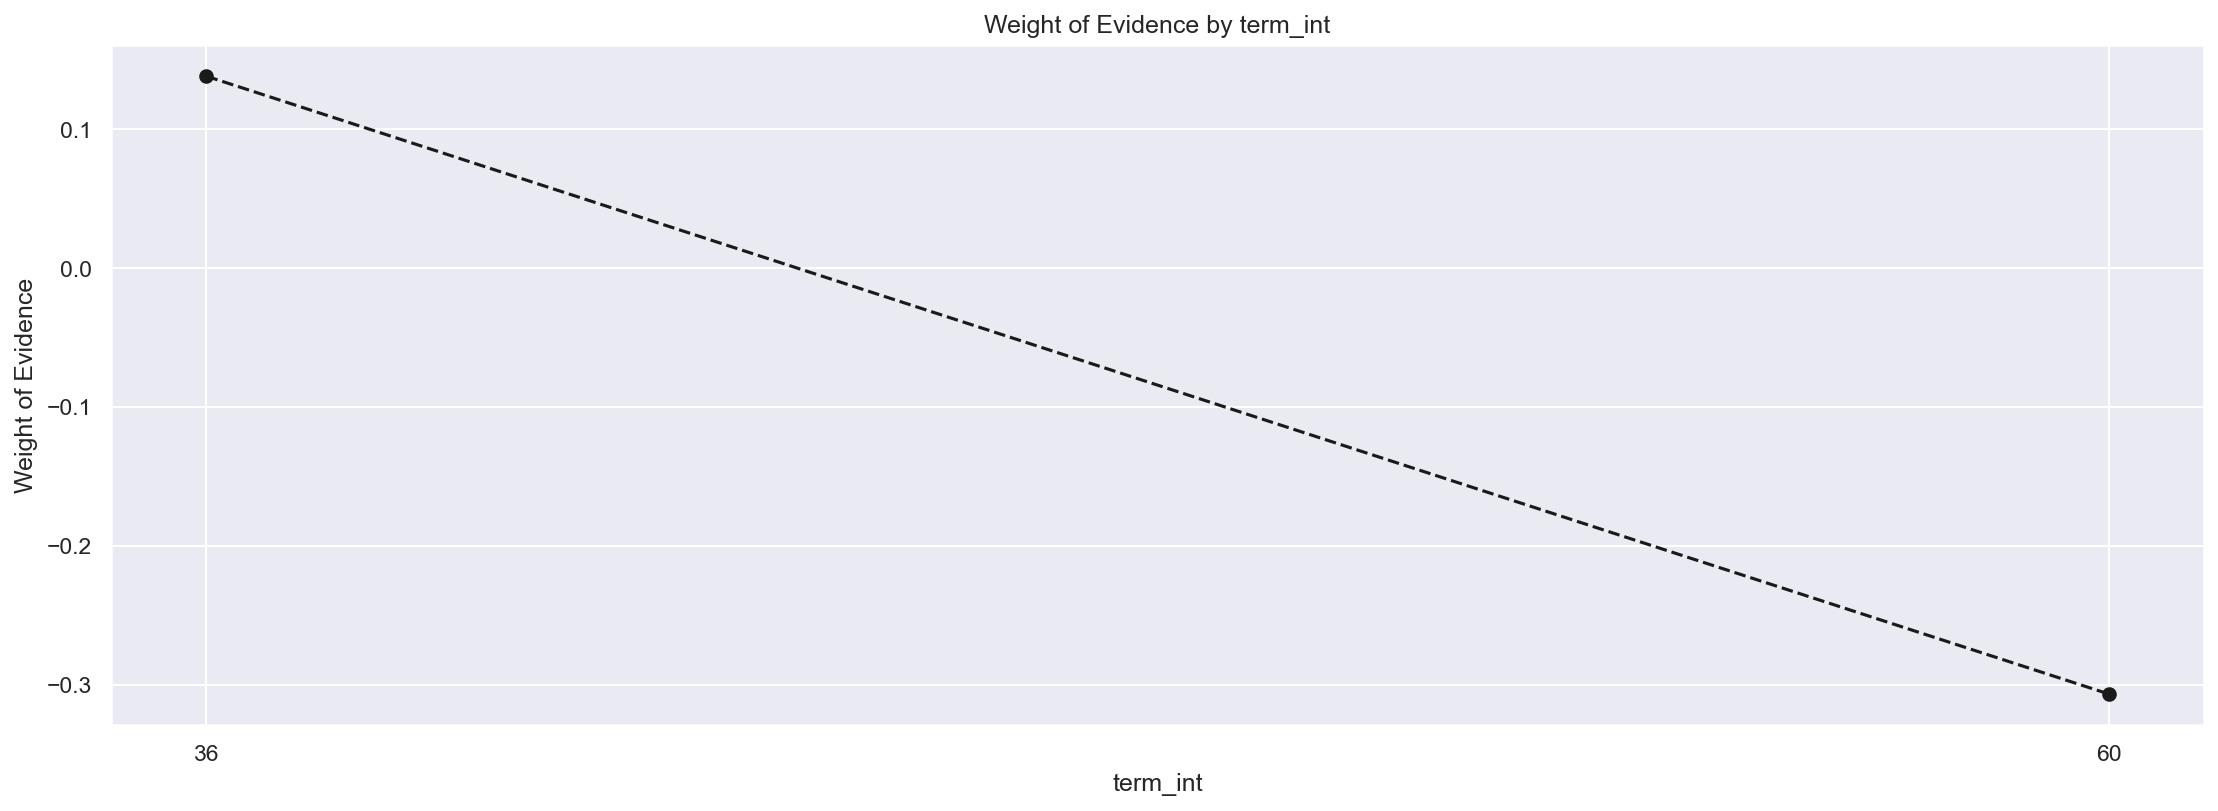

In [42]:
plot_by_woe(term_int_df)

In [43]:
X_train["term:36"] = np.where(X_train["term_int"] == 36, 1, 0)
X_train["term:60"] = np.where(X_train["term_int"] == 60, 1, 0)

##### Employment length variable

The employment length variable at either ends of the data set have vastly differing groupings, however, there seem to be similarities between employment lengths that fall in the middle of the data set, allowing for appropriate groupings

In [44]:
emp_length_int_df = woe_ordered_continuous(X_train, "emp_length_int", y_train)
emp_length_int_df

emp_length_int   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0              0.0   45720   0.878696     0.122565   40174.0   5546.0   
1              1.0   23654   0.889955     0.063411   21051.0   2603.0   
2              2.0   33078   0.893101     0.088674   29542.0   3536.0   
3              3.0   29205   0.892792     0.078292   26074.0   3131.0   
4              4.0   22468   0.892647     0.060231   20056.0   2412.0   
5              5.0   24602   0.886269     0.065952   21804.0   2798.0   
6              6.0   20887   0.885383     0.055993   18493.0   2394.0   
7              7.0   21049   0.888736     0.056427   18707.0   2342.0   
8              8.0   17853   0.891335     0.047860   15913.0   1940.0   
9              9.0   14267   0.887713     0.038246   12665.0   1602.0   
10            10.0  120245   0.901360     0.322348  108384.0  11861.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i_v  \
0      0.120692    0.138080 -0.134592             NaN       NaN  2.340301e-03   
1      0.063242    0.064808 -0.024452        0.011259  0.110140  3.827733e-05   
2      0.088751    0.088037  0.008082        0.003146  0.032533  5.773484e-06   
3      0.078333    0.077953  0.004851        0.000309  0.003231  1.839011e-06   
4      0.060253    0.060052  0.003337        0.000145  0.001514  6.698565e-07   
5      0.065504    0.069663 -0.061546        0.006378  0.064884  2.559234e-04   
6      0.055557    0.059604 -0.070308        0.000886  0.008762  2.845197e-04   
7      0.056200    0.058309 -0.036843        0.003353  0.033466  7.770728e-05   
8      0.047806    0.048301 -0.010287        0.002599  0.026556  5.084718e-06   
9      0.038049    0.039885 -0.047146        0.003622  0.036859  8.659635e-05   
10     0.325611    0.295307  0.097690        0.013647  0.144835  2.960447e-03   

     i_v_sum  
0   0.006057  
1   0.006057  
2   0.006057  
3   0.006057  
4   0.006057  
5   0.006057  
6   0.006057  
7   0.006057  
8   0.006057  
9   0.006057  
10  0.006057

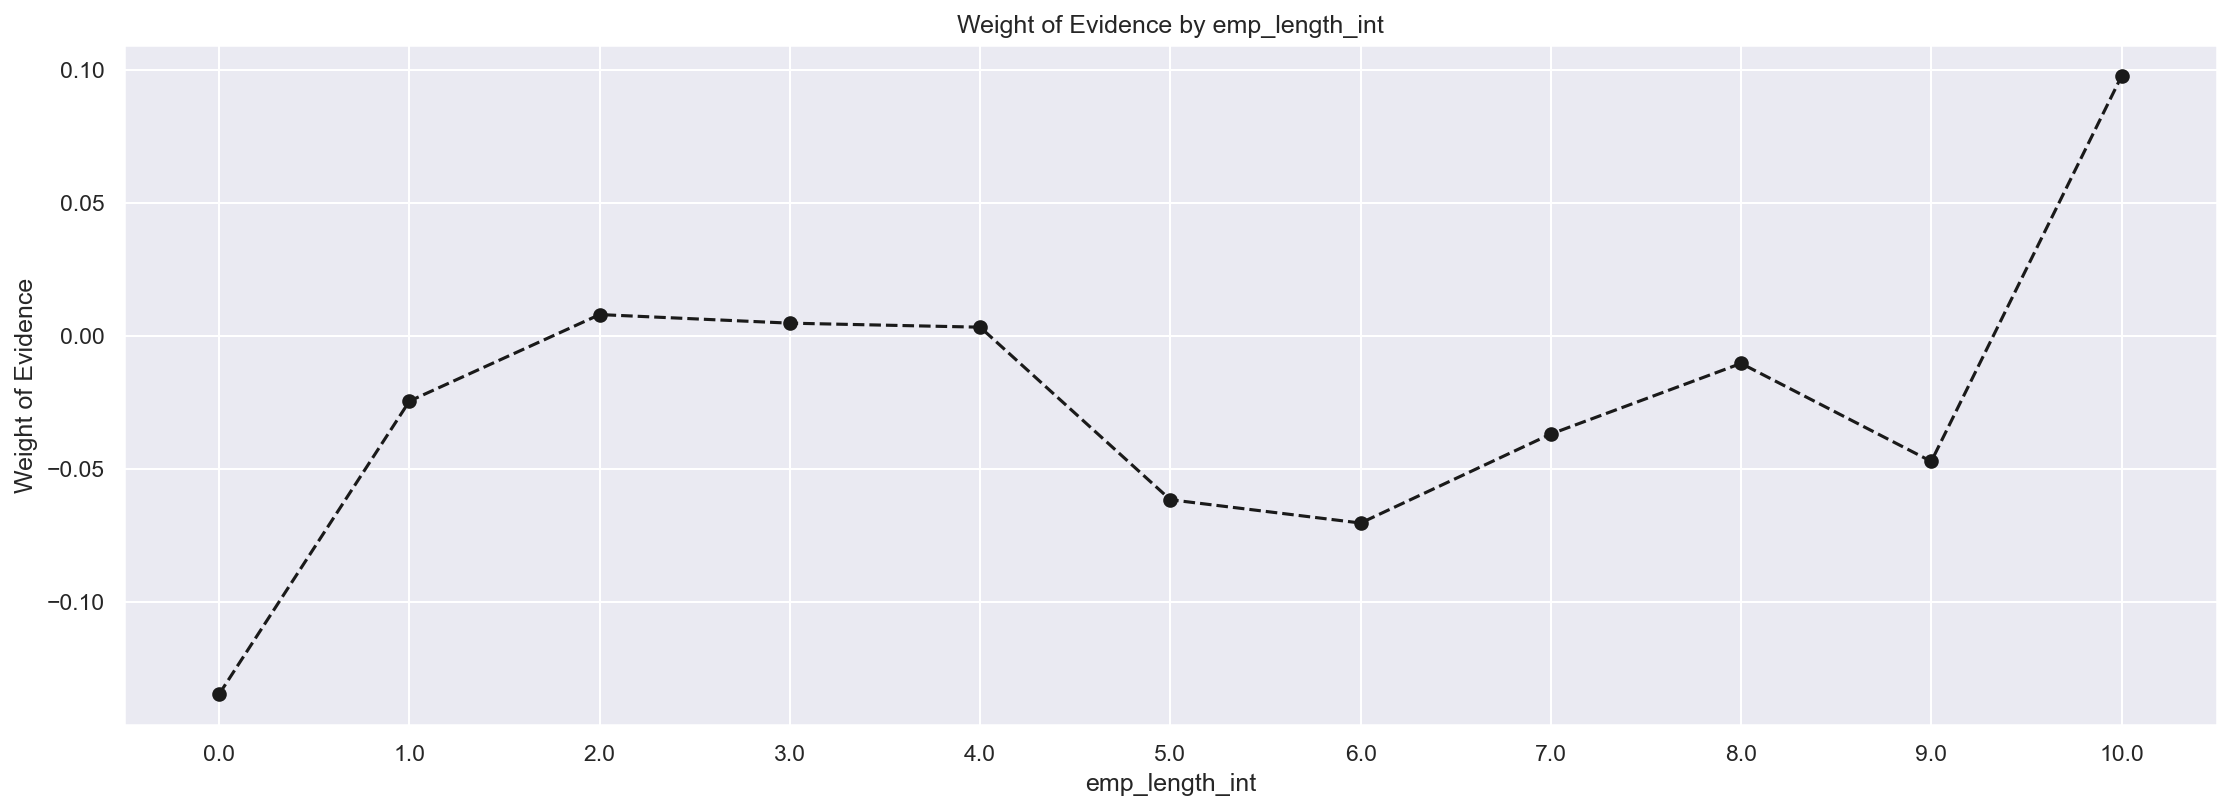

In [45]:
plot_by_woe(emp_length_int_df)

There will be 6 groupings:

- (1) emp_lenght = 0
- (2) emp_lenght = 1
- (3) emp_lenght = 2 - 4
- (4) emp_lenght = 5 - 6
- (5) emp_lenght = 7 - 9
- (6) emp_lenght = 10

Group 5 could also be grouped as 3 separate categories, however, because emp_length of 7 and 9 have similar weight of evidence, we have opted to group the 3 into a single category

In [46]:
X_train["emp_length:0"] = np.where(X_train["emp_length_int"].isin([0]), 1, 0)
X_train["emp_length:1"] = np.where(X_train["emp_length_int"].isin([1]), 1, 0)
X_train["emp_length:2-4"] = np.where(X_train["emp_length_int"].isin(range(2, 5)), 1, 0)
X_train["emp_length:5-6"] = np.where(X_train["emp_length_int"].isin(range(5, 7)), 1, 0)
X_train["emp_length:7-9"] = np.where(X_train["emp_length_int"].isin(range(7, 10)), 1, 0)
X_train["emp_length:10"] = np.where(X_train["emp_length_int"].isin([10]), 1, 0)

##### Months since issue date variable

Since there are 91 categories within this variable, we will perform some preliminary fine classing to create a smaller group of 50 categories (factor), and then proceed with course classing using weight of evidence as we have done with previous variables

In [47]:
X_train["mths_since_issue_d_factor"] = pd.cut(X_train["mths_since_issue_d"], 50)
mths_since_issue_d_factor_df = woe_ordered_continuous(X_train, "mths_since_issue_d_factor", y_train)
mths_since_issue_d_factor_df

mths_since_issue_d_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0              (35.91, 37.8]  28170   0.942244     0.075517  26543.0  1627.0   
1               (37.8, 39.6]  39636   0.928424     0.106255  36799.0  2837.0   
2               (39.6, 41.4]  38614   0.917284     0.103515  35420.0  3194.0   
3               (41.4, 43.2]  29038   0.908603     0.077844  26384.0  2654.0   
4               (43.2, 45.0]  28367   0.901787     0.076045  25581.0  2786.0   
5               (45.0, 46.8]  12165   0.899301     0.032611  10940.0  1225.0   
6               (46.8, 48.6]  24451   0.898900     0.065547  21979.0  2472.0   
7               (48.6, 50.4]  22969   0.888328     0.061574  20404.0  2565.0   
8               (50.4, 52.2]  20640   0.880523     0.055331  18174.0  2466.0   
9               (52.2, 54.0]  18312   0.866863     0.049090  15874.0  2438.0   
10              (54.0, 55.8]   8286   0.856746     0.022213   7099.0  1187.0   
11              (55.8, 57.6]  14120   0.863031     0.037852  12186.0  1934.0   
12              (57.6, 59.4]  11529   0.859658     0.030907   9911.0  1618.0   
13              (59.4, 61.2]   9974   0.852817     0.026738   8506.0  1468.0   
14              (61.2, 63.0]   9811   0.851901     0.026301   8358.0  1453.0   
15              (63.0, 64.8]   4304   0.844331     0.011538   3634.0   670.0   
16              (64.8, 66.6]   6723   0.824781     0.018023   5545.0  1178.0   
17              (66.6, 68.4]   5334   0.841207     0.014299   4487.0   847.0   
18              (68.4, 70.2]   4377   0.846699     0.011734   3706.0   671.0   
19              (70.2, 72.0]   3868   0.827559     0.010369   3201.0   667.0   
20              (72.0, 73.8]   1785   0.855462     0.004785   1527.0   258.0   
21              (73.8, 75.6]   3395   0.853019     0.009101   2896.0   499.0   
22              (75.6, 77.4]   3055   0.853682     0.008190   2608.0   447.0   
23              (77.4, 79.2]   2849   0.842050     0.007637   2399.0   450.0   
24              (79.2, 81.0]   2412   0.851990     0.006466   2055.0   357.0   
25              (81.0, 82.8]   1044   0.869732     0.002799    908.0   136.0   
26              (82.8, 84.6]   2182   0.877177     0.005849   1914.0   268.0   
27              (84.6, 86.4]   1997   0.879319     0.005353   1756.0   241.0   
28              (86.4, 88.2]   1921   0.856325     0.005150   1645.0   276.0   
29              (88.2, 90.0]   1870   0.865775     0.005013   1619.0   251.0   
30              (90.0, 91.8]    795   0.877987     0.002131    698.0    97.0   
31              (91.8, 93.6]   1373   0.910415     0.003681   1250.0   123.0   
32              (93.6, 95.4]   1087   0.898804     0.002914    977.0   110.0   
33              (95.4, 97.2]   1044   0.897510     0.002799    937.0   107.0   
34              (97.2, 99.0]    877   0.876853     0.002351    769.0   108.0   
35             (99.0, 100.8]    346   0.898844     0.000928    311.0    35.0   
36            (100.8, 102.6]    647   0.887172     0.001734    574.0    73.0   
37            (102.6, 104.4]    542   0.878229     0.001453    476.0    66.0   
38            (104.4, 106.2]    497   0.895372     0.001332    445.0    52.0   
39            (106.2, 108.0]    403   0.880893     0.001080    355.0    48.0   
40            (108.0, 109.8]    173   0.849711     0.000464    147.0    26.0   
41            (109.8, 111.6]    139   0.884892     0.000373    123.0    16.0   
42            (111.6, 113.4]    204   0.887255     0.000547    181.0    23.0   
43            (113.4, 115.2]    182   0.939560     0.000488    171.0    11.0   
44            (115.2, 117.0]    530   0.901887     0.001421    478.0    52.0   
45            (117.0, 118.8]    247   0.919028     0.000662    227.0    20.0   
46            (118.8, 120.6]    394   0.903553     0.001056    356.0    38.0   
47            (120.6, 122.4]    176   0.926136     0.000472    163.0    13.0   
48            (122.4, 124.2]    104   0.932692     0.000279     97.0     7.0   
49 

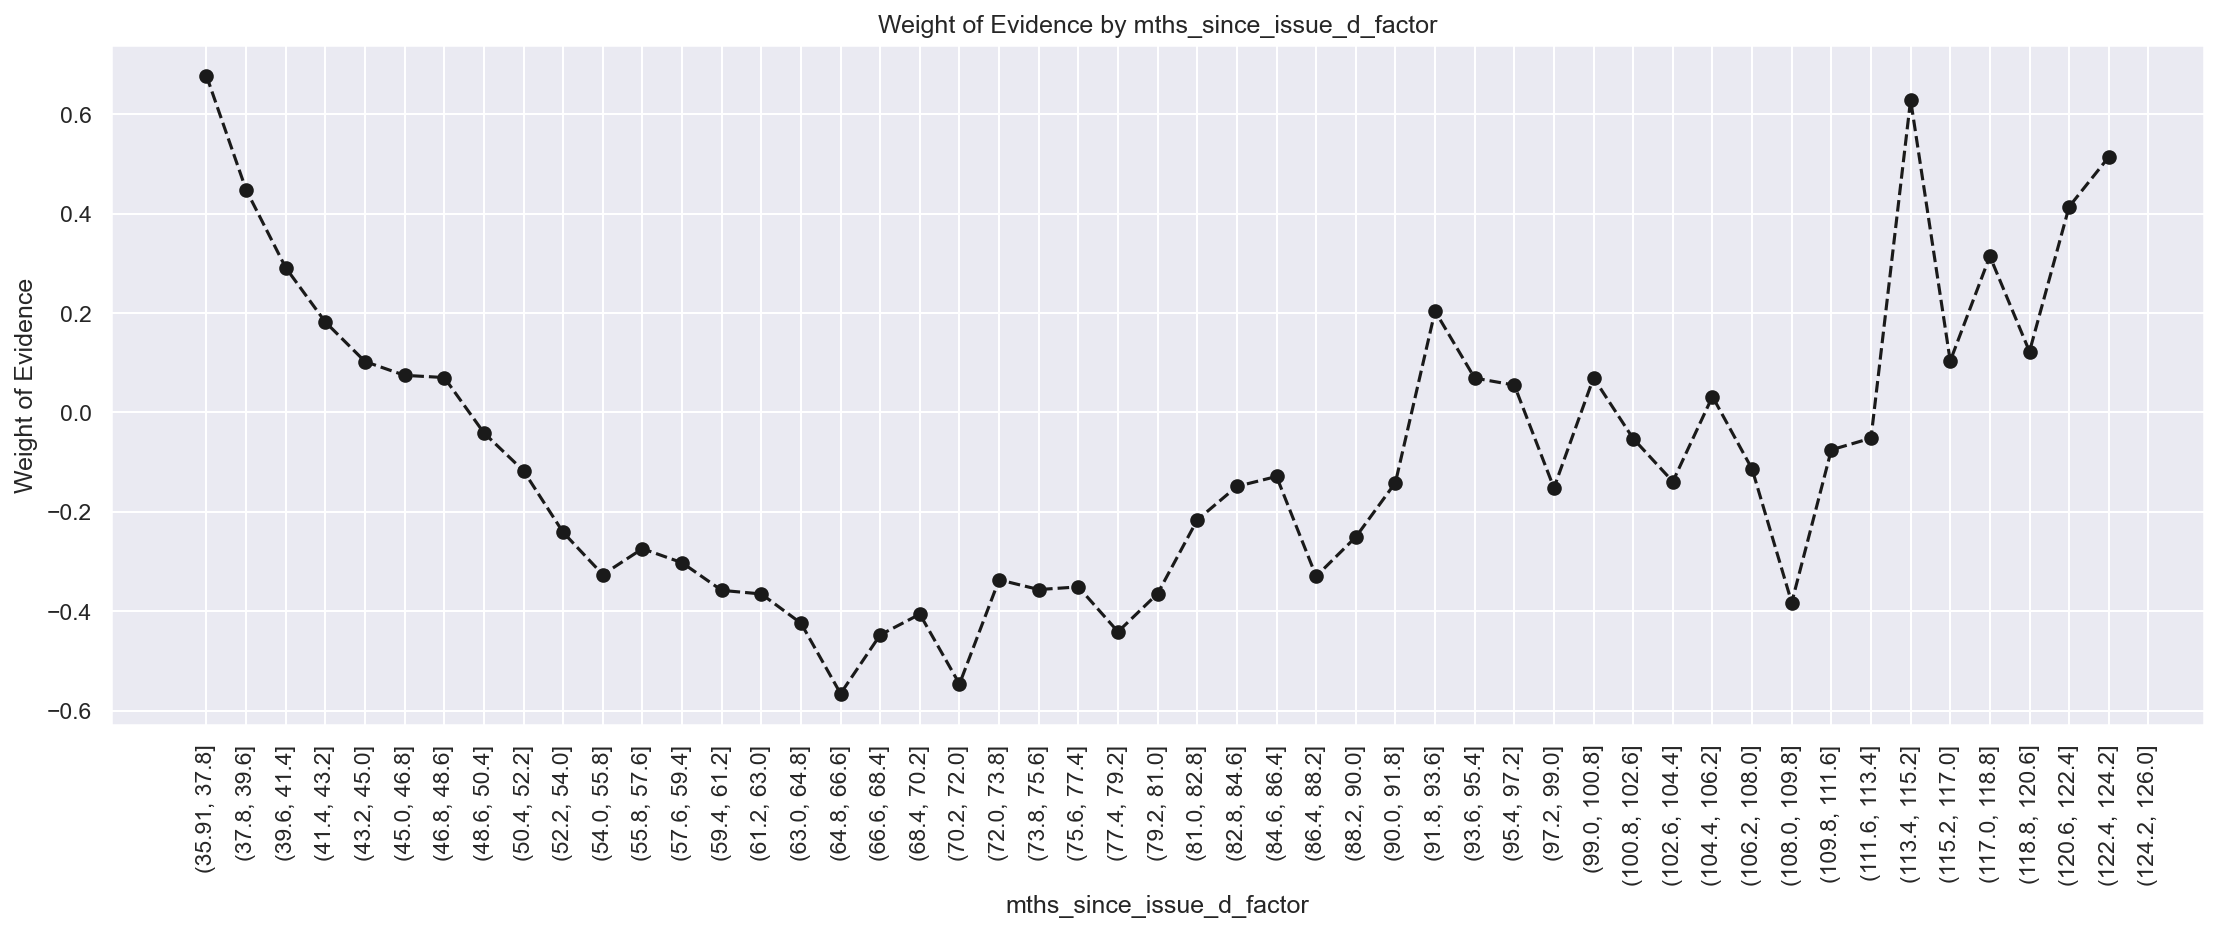

In [48]:
plot_by_woe(mths_since_issue_d_factor_df, 90)

It is clear that the first 3 categories are starkly different from one another, therefore, we will create 3 separate categories for these groups:

- (1) x < 37.8
- (2) 37.8 < x < 39.6
- (3) 39.6 < x < 41.4

*note that x = mths_since_issue_d_factor

Because these values are starkly different, we will visualize the changes to make grouping the remaining categories easier

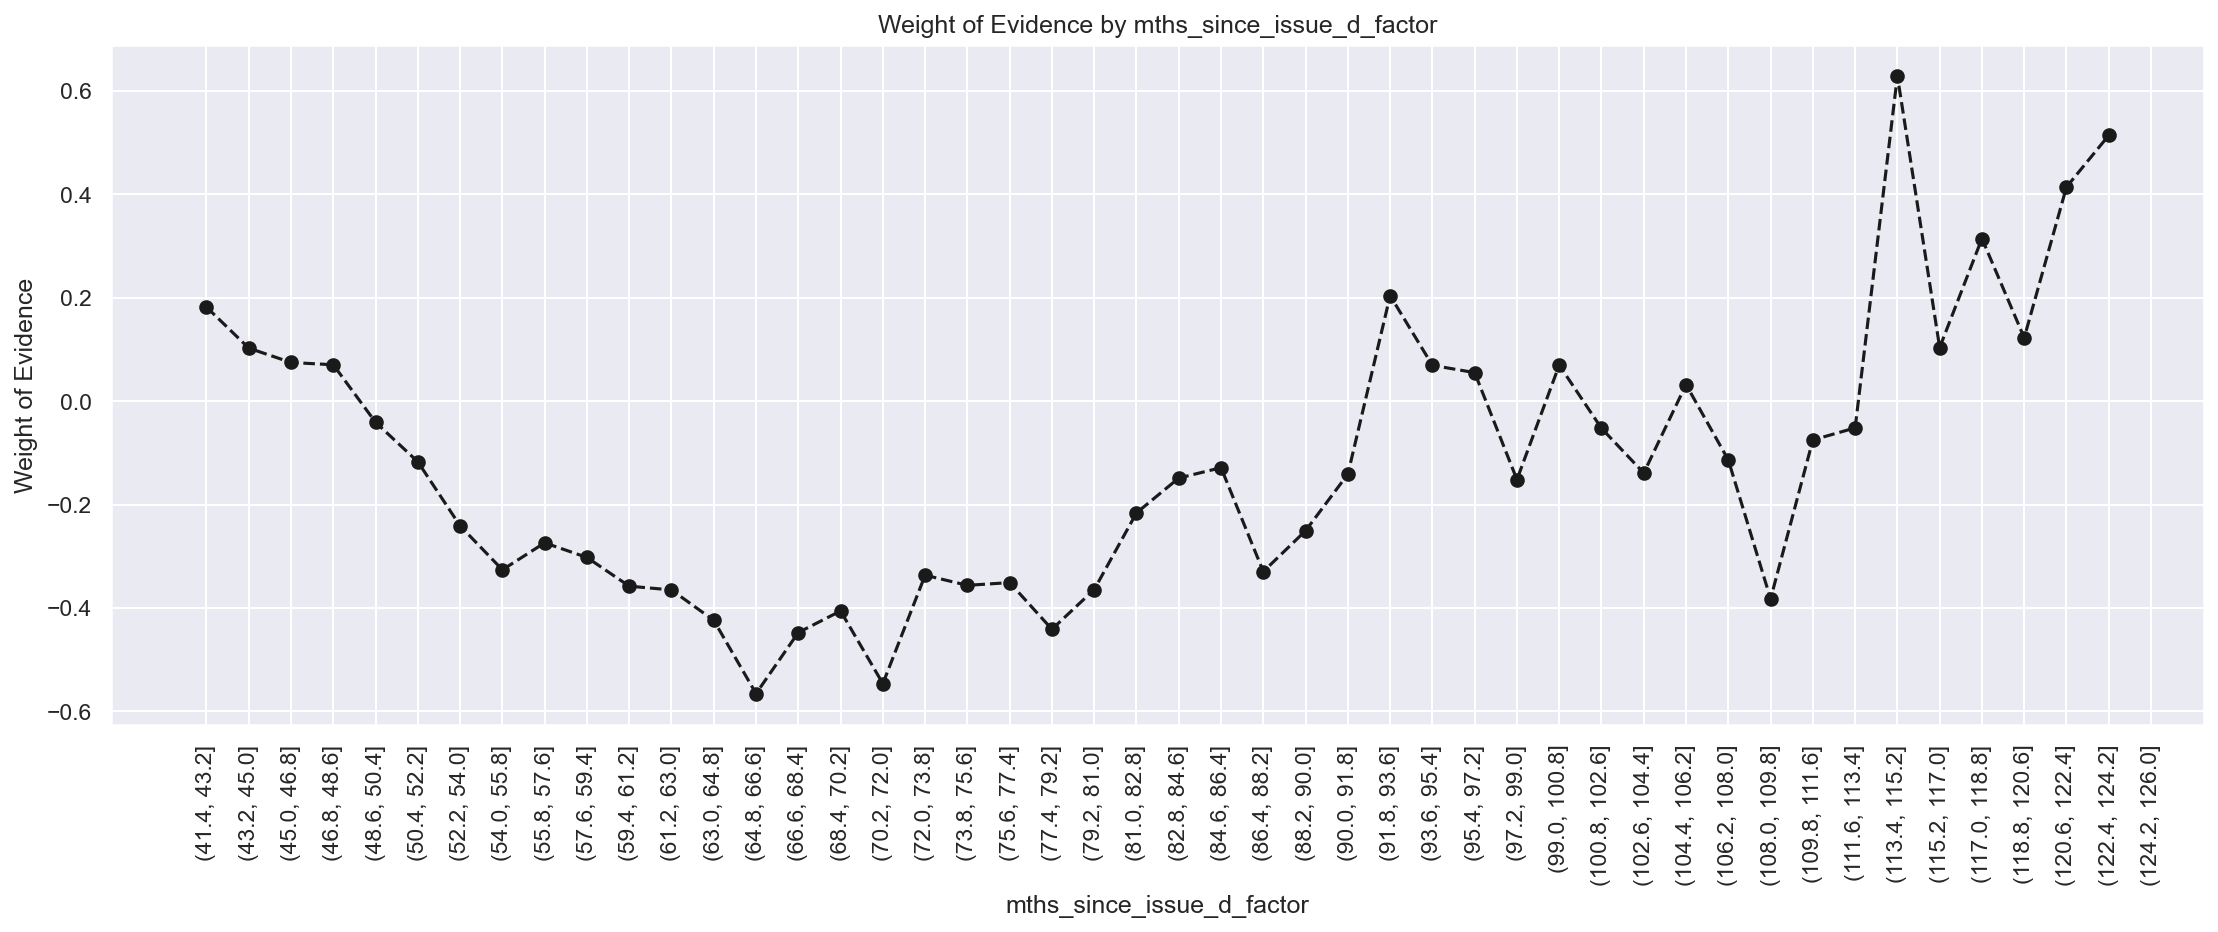

In [49]:
plot_by_woe(mths_since_issue_d_factor_df.iloc[3:, :], 90)

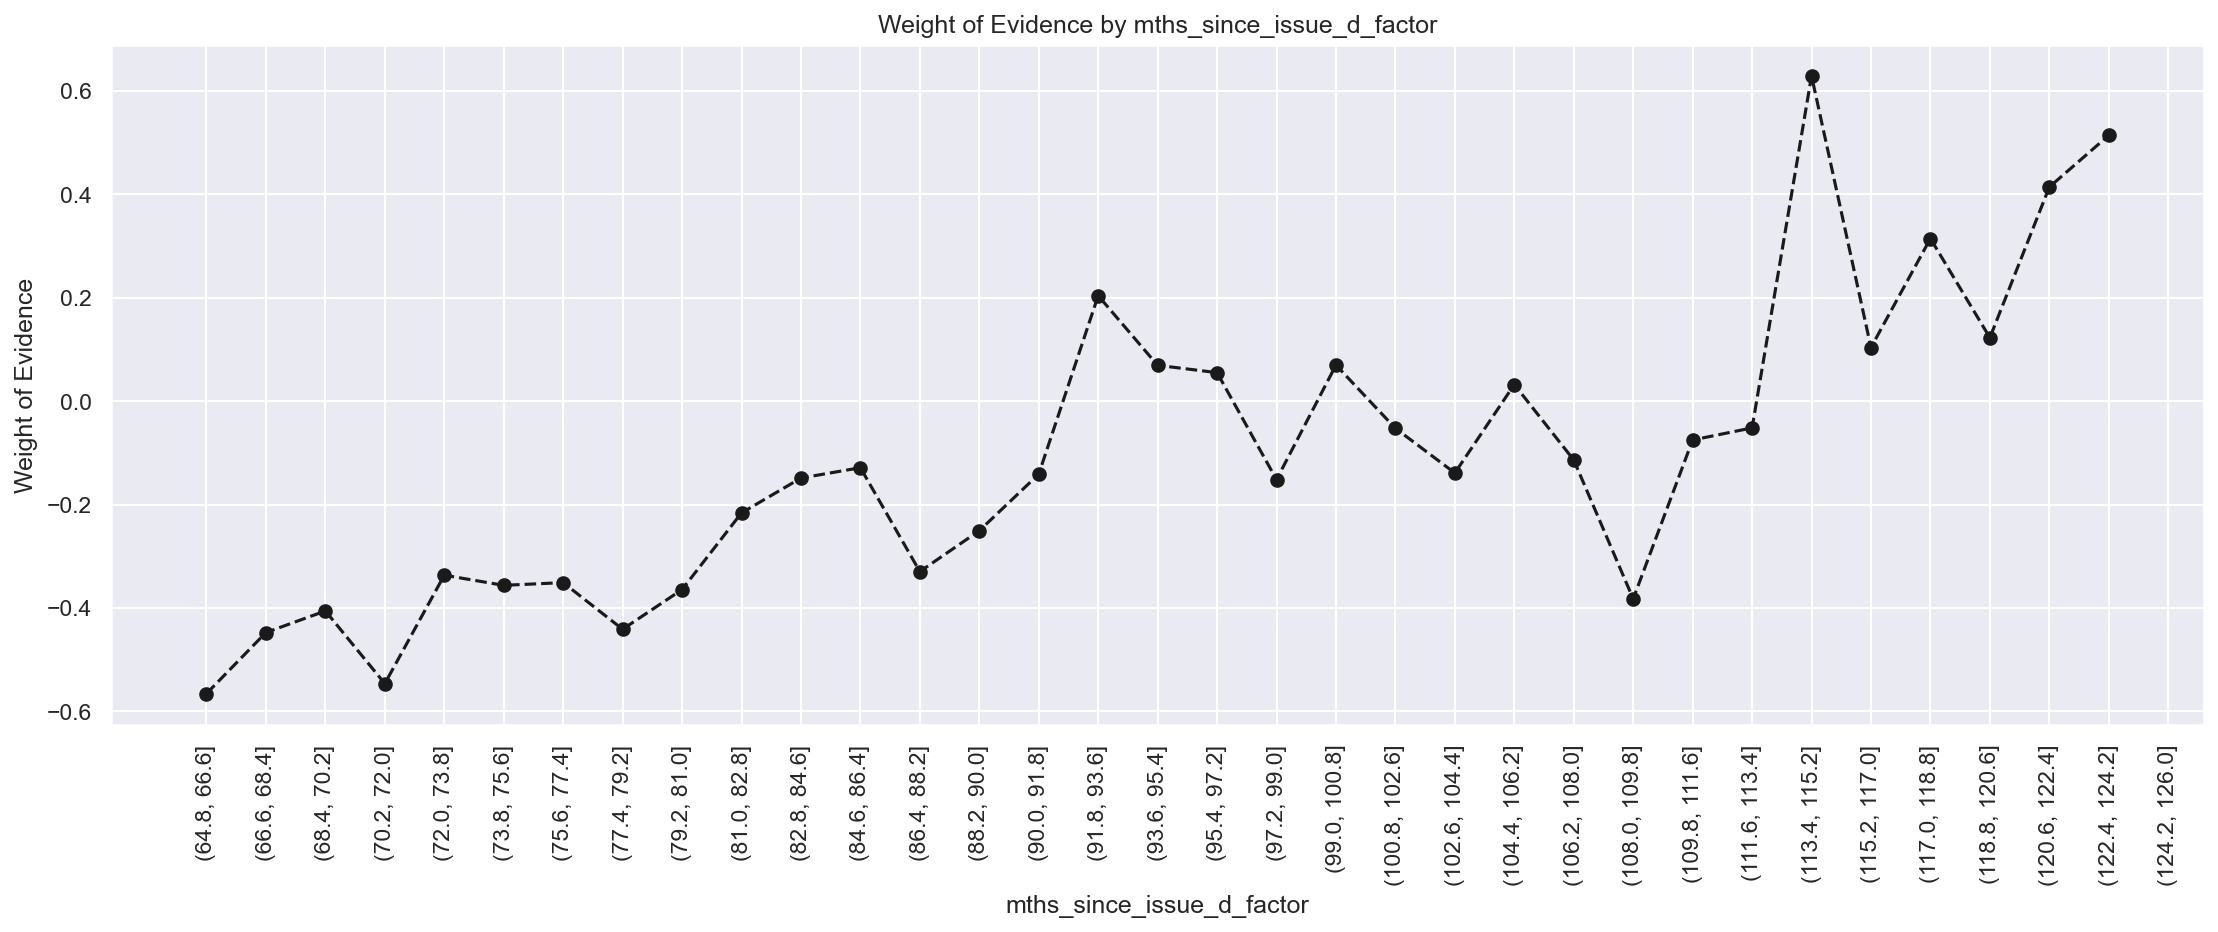

In [50]:
plot_by_woe(mths_since_issue_d_factor_df.iloc[16:, :], 90)

* zoom in of groups after 64.8

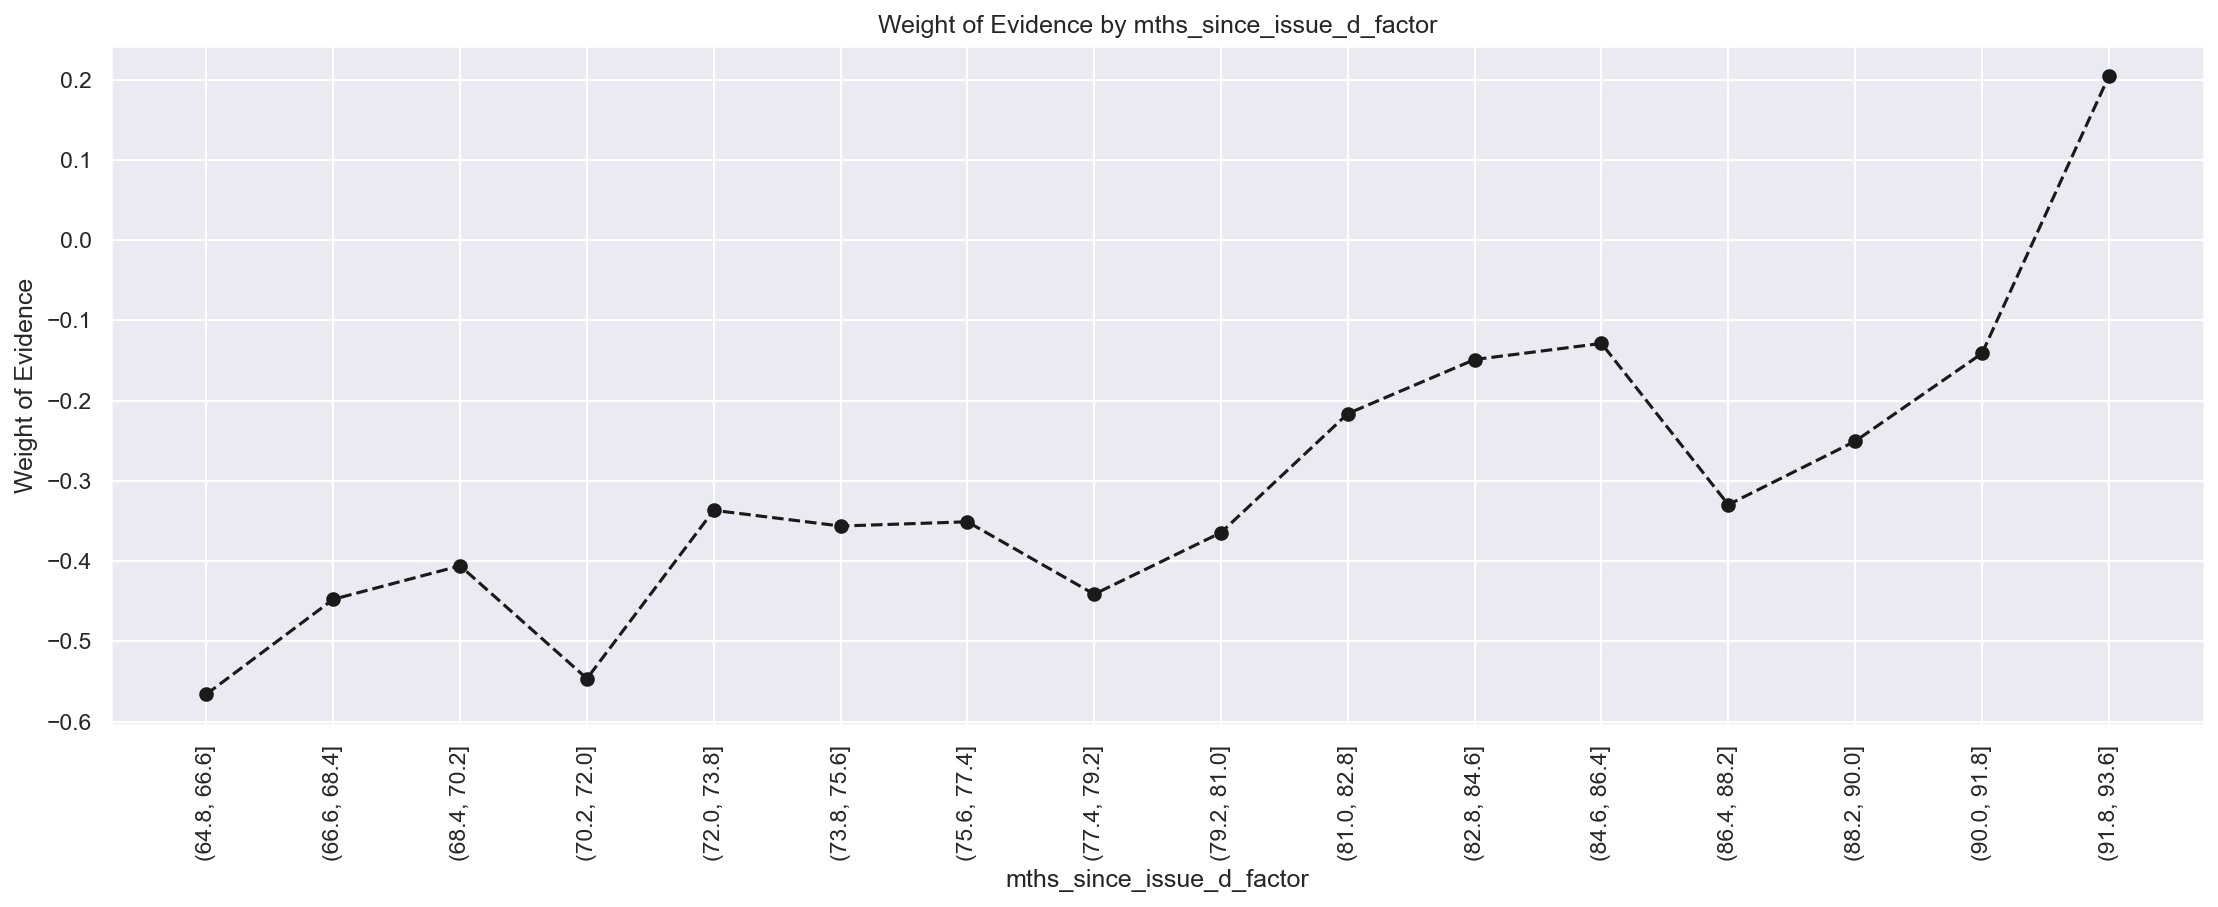

In [51]:
plot_by_woe(mths_since_issue_d_factor_df.iloc[16:32, :], 90)

- zoom in of categories between 64.8 and 91.8
*note the change in weight of evidence is more stark after 91.8, whereas other categories before 91.8 are in a general range from one another

The remaining categories will be as follows:

- (4) 41.4 < x < 48.6
- (5) 48.6 < x < 52.2
- (6) 52.2 < x < 64.8
- (7) 64.8 < x < 91.8
- (8) 91.8 < x < 126.0

Group 7 and 8 could technically be a single group due to the limited number of observations, however, we have opted to make this 2 separate groups, where the more drastic change in weight of evidence after 91.8 is used as the differentiator. There are other groups that could be formed in the last group, however, since there is a very small number of observations, we have decided to group them all together to increase the interpretability of the weight of evidence to the respective class assigned

In [52]:
# whole integers are used to represent ranges, as floats cannot be interpreted by range method
X_train["mths_since_issue_d:<38"] = np.where(X_train["mths_since_issue_d"].isin(range(38)), 1, 0)
X_train["mths_since_issue_d:38-39"] = np.where(X_train["mths_since_issue_d"].isin(range(38, 40)), 1, 0)
X_train["mths_since_issue_d:40-41"] = np.where(X_train["mths_since_issue_d"].isin(range(40, 42)), 1, 0)
X_train["mths_since_issue_d:42-48"] = np.where(X_train["mths_since_issue_d"].isin(range(42, 49)), 1, 0)
X_train["mths_since_issue_d:49-52"] = np.where(X_train["mths_since_issue_d"].isin(range(49, 53)), 1, 0)
X_train["mths_since_issue_d:53-64"] = np.where(X_train["mths_since_issue_d"].isin(range(53, 65)), 1, 0)
X_train["mths_since_issue_d:65-92"] = np.where(X_train["mths_since_issue_d"].isin(range(65, 92)), 1, 0)
X_train["mths_since_issue_d:>92"] = np.where(X_train["mths_since_issue_d"].isin(range(92, int(X_train["mths_since_issue_d"].max()))), 1, 0)

##### Interest rate variable

Since there are 504 categories within this variable, we will perform some preliminary fine classing to create a smaller group of 50 categories (factor), and then proceed with course classing using weight of evidence as we have done with previous variables

In [53]:
X_train["int_rate_factor"] = pd.cut(X_train["int_rate"], 50)

int_rate_factor_df = woe_ordered_continuous(X_train, "int_rate_factor", y_train)
int_rate_factor_df

int_rate_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0     (5.399, 5.833]    785   0.961783     0.002104    755.0    30.0   
1     (5.833, 6.246]   8459   0.980376     0.022677   8293.0   166.0   
2     (6.246, 6.658]   7826   0.971505     0.020980   7603.0   223.0   
3     (6.658, 7.071]   1816   0.973018     0.004868   1767.0    49.0   
4     (7.071, 7.484]   3143   0.976774     0.008426   3070.0    73.0   
5     (7.484, 7.897]  12581   0.962483     0.033727  12109.0   472.0   
6      (7.897, 8.31]   9687   0.949314     0.025969   9196.0   491.0   
7      (8.31, 8.722]   6594   0.965726     0.017677   6368.0   226.0   
8     (8.722, 9.135]   9539   0.937729     0.025572   8945.0   594.0   
9     (9.135, 9.548]   6681   0.964975     0.017910   6447.0   234.0   
10    (9.548, 9.961]   7588   0.932920     0.020342   7079.0   509.0   
11   (9.961, 10.374]  10941   0.934375     0.029330  10223.0   718.0   
12  (10.374, 10.786]   5857   0.916681     0.015701   5369.0   488.0   
13  (10.786, 11.199]  17851   0.930200     0.047854  16605.0  1246.0   
14  (11.199, 11.612]   4876   0.923093     0.013071   4501.0   375.0   
15  (11.612, 12.025]  15597   0.934475     0.041812  14575.0  1022.0   
16  (12.025, 12.438]  12336   0.894212     0.033070  11031.0  1305.0   
17   (12.438, 12.85]  11065   0.924898     0.029663  10234.0   831.0   
18   (12.85, 13.263]  21329   0.904918     0.057178  19301.0  2028.0   
19  (13.263, 13.676]  15392   0.910148     0.041262  14009.0  1383.0   
20  (13.676, 14.089]  10991   0.899190     0.029464   9883.0  1108.0   
21  (14.089, 14.502]  23436   0.890169     0.062826  20862.0  2574.0   
22  (14.502, 14.914]   4333   0.870990     0.011616   3774.0   559.0   
23  (14.914, 15.327]  18932   0.884059     0.050752  16737.0  2195.0   
24   (15.327, 15.74]  12327   0.890322     0.033046  10975.0  1352.0   
25   (15.74, 16.153]   7477   0.843253     0.020044   6305.0  1172.0   
26  (16.153, 16.566]  12991   0.861366     0.034826  11190.0  1801.0   
27  (16.566, 16.978]   4237   0.849894     0.011358   3601.0   636.0   
28  (16.978, 17.391]  11396   0.854949     0.030550   9743.0  1653.0   
29  (17.391, 17.804]  12288   0.840983     0.032941  10334.0  1954.0   
30  (17.804, 18.217]   1306   0.836141     0.003501   1092.0   214.0   
31   (18.217, 18.63]  11036   0.836988     0.029585   9237.0  1799.0   
32   (18.63, 19.042]   6808   0.820212     0.018251   5584.0  1224.0   
33  (19.042, 19.455]   4425   0.804294     0.011862   3559.0   866.0   
34  (19.455, 19.868]   6763   0.824782     0.018130   5578.0  1185.0   
35  (19.868, 20.281]   4899   0.833231     0.013133   4082.0   817.0   
36  (20.281, 20.694]   3221   0.795405     0.008635   2562.0   659.0   
37  (20.694, 21.106]   4016   0.800548     0.010766   3215.0   801.0   
38  (21.106, 21.519]   2729   0.780872     0.007316   2131.0   598.0   
39  (21.519, 21.932]    989   0.762386     0.002651    754.0   235.0   
40  (21.932, 22.345]   3476   0.795167     0.009318   2764.0   712.0   
41  (22.345, 22.758]   2251   0.763661     0.006034   1719.0   532.0   
42   (22.758, 23.17]   1535   0.759609     0.004115   1166.0   369.0   
43   (23.17, 23.583]   2652   0.782805     0.007109   2076.0   576.0   
44  (23.583, 23.996]   1573   0.724094     0.004217   1139.0   434.0   
45  (23.996, 24.409]   1455   0.767698     0.003901   1117.0   338.0   
46  (24.409, 24.822]   1664   0.762620     0.004461   1269.0   395.0   
47  (24.822, 25.234]   1315   0.771103     0.003525   1014.0   301.0   
48  (25.234, 25.647]    778   0.736504     0.002086    573.0   205.0   
49   (25.647, 26.06]   1786   0.754759     0.004788   1348.0   438.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.002268    0.000747  1.110785             NaN       NaN  0.001690   
1      0.024914    0.004133  1.796444        0.018592  0.685659  0.037332   
2      0.022841    0.005552  1.414391        0.008871  0.382053  0.024454   
3      0.005308    0.001

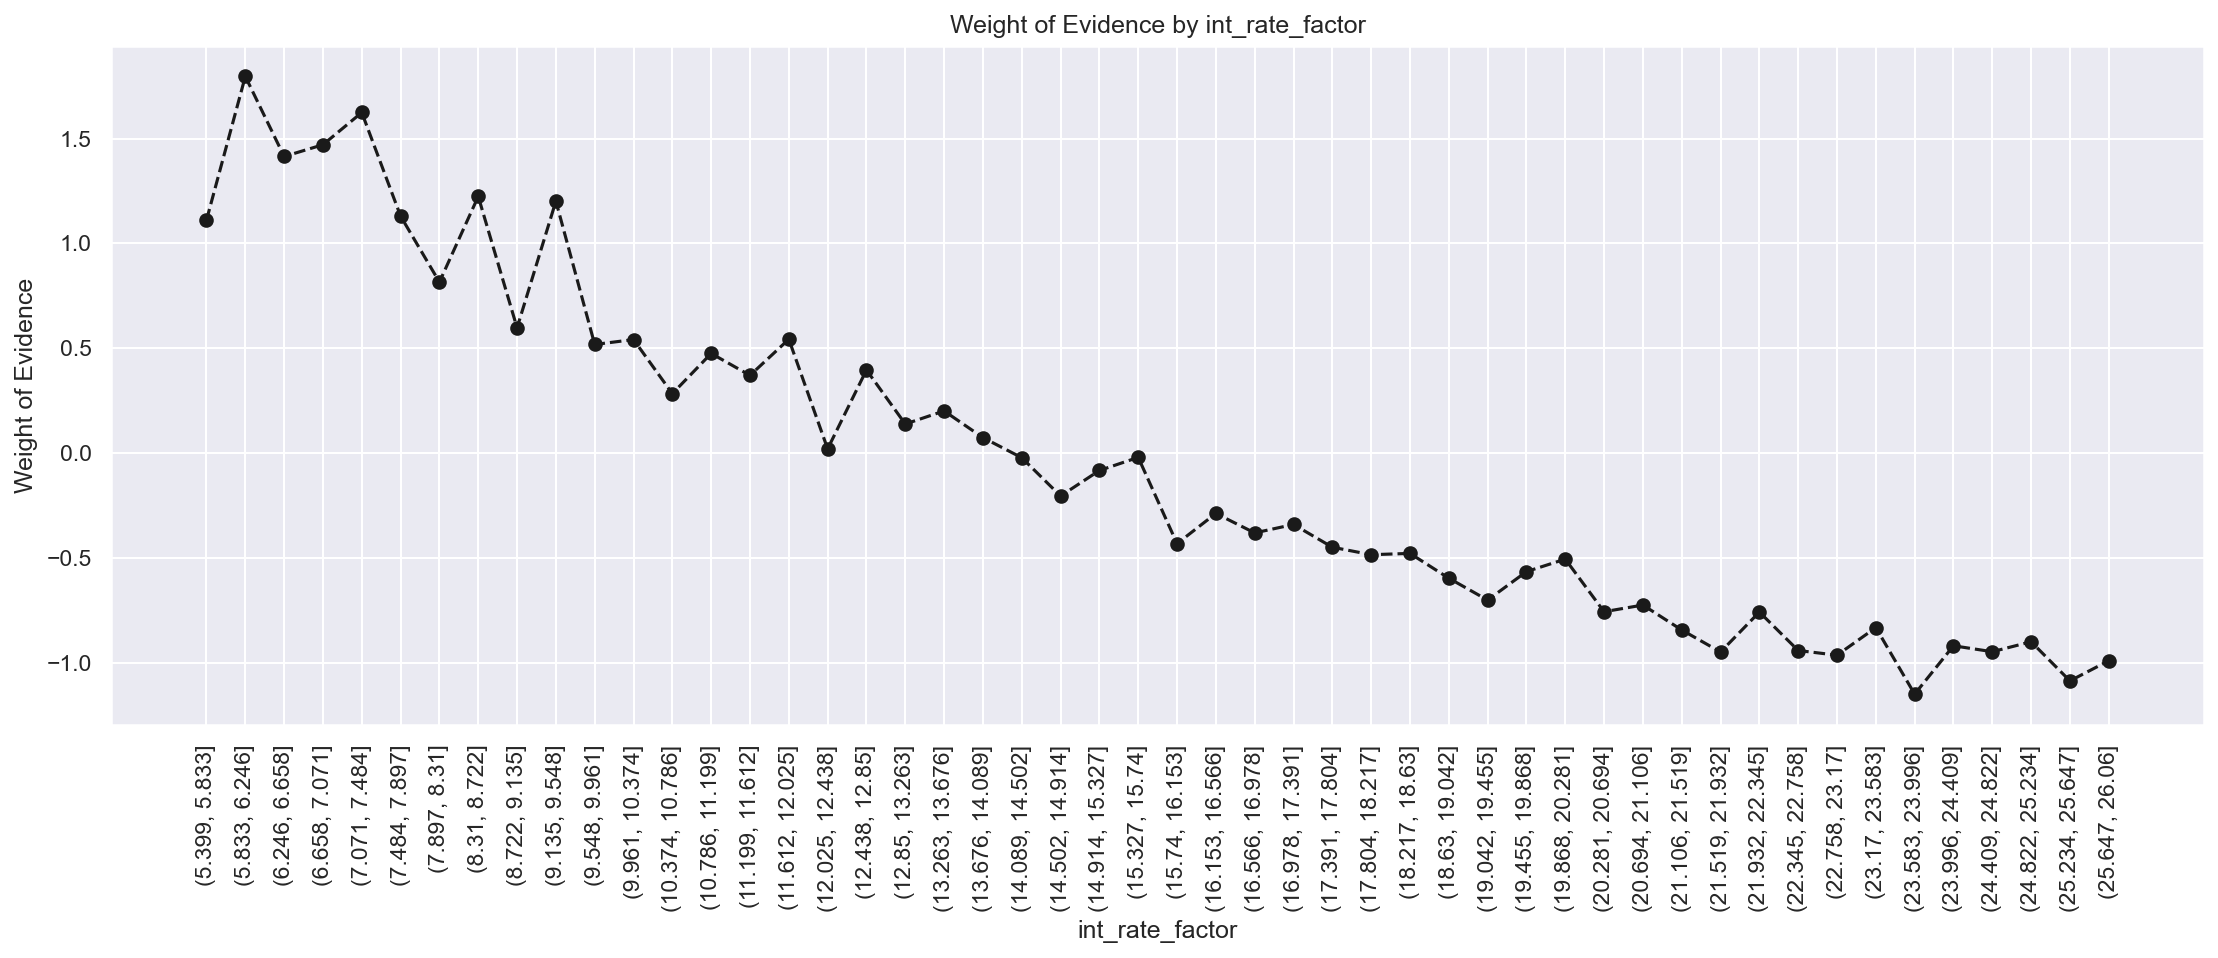

In [54]:
plot_by_woe(int_rate_factor_df, 90)

The relationship between the interest rate and the risk of defaulting on a loan is linear with a negative sign. That is, as interest rates increase, the risk of default will increase

There will be 5 groupings:

- (1) x <= 9.548
- (2) 9.548 < x <= 12.025
- (3) 12.281 < x <= 15.74
- (4) 15.74 < x <= 20.281
- (5) x > 20.281

The number of observations in the first group are not significant, which explains the volatility of the weight of evidence in the first category. The last grouping has a similar problem of limited number of observations but with relatively stable weight of evidence, therefore we have grouped those categories together. The remaining 3 categories were grouped using clear breaks in the weight of evidence as natural end points

*note that x = int_rate_factor

In [55]:
X_train["int_rate:<9.548"] = np.where((X_train["int_rate"] <= 9.548), 1, 0)
X_train["int_rate:9.548-12.025"] = np.where((X_train["int_rate"] > 9.548) & (X_train["int_rate"] <= 12.025), 1, 0)
X_train["int_rate:12.025-15.74"] = np.where((X_train["int_rate"] > 12.025) & (X_train["int_rate"] <= 15.74), 1, 0)
X_train["int_rate:15.74-20.281"] = np.where((X_train["int_rate"] > 15.74) & (X_train["int_rate"] <= 20.281), 1, 0)
X_train["int_rate:>20.281"] = np.where((X_train["int_rate"] > 20.281), 1, 0)

##### Funded amount variable

In [56]:
X_train["funded_amnt_factor"] = pd.cut(X_train["funded_amnt"], 50)
funded_amnt_factor_df = woe_ordered_continuous(X_train, "funded_amnt_factor", y_train)
funded_amnt_factor_df

funded_amnt_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0      (465.5, 1190.0]   1224   0.915033     0.003281   1120.0   104.0   
1     (1190.0, 1880.0]   3028   0.910502     0.008117   2757.0   271.0   
2     (1880.0, 2570.0]   6018   0.900133     0.016133   5417.0   601.0   
3     (2570.0, 3260.0]   7248   0.893212     0.019430   6474.0   774.0   
4     (3260.0, 3950.0]   4751   0.894969     0.012736   4252.0   499.0   
5     (3950.0, 4640.0]   9023   0.894049     0.024189   8067.0   956.0   
6     (4640.0, 5330.0]  15903   0.896246     0.042632  14253.0  1650.0   
7     (5330.0, 6020.0]  17236   0.908447     0.046206  15658.0  1578.0   
8     (6020.0, 6710.0]   6914   0.889789     0.018535   6152.0   762.0   
9     (6710.0, 7400.0]  11806   0.900220     0.031649  10628.0  1178.0   
10    (7400.0, 8090.0]  17692   0.900237     0.047428  15927.0  1765.0   
11    (8090.0, 8780.0]   6316   0.881254     0.016932   5566.0   750.0   
12    (8780.0, 9470.0]   9168   0.881763     0.024577   8084.0  1084.0   
13   (9470.0, 10160.0]  33410   0.896618     0.089564  29956.0  3454.0   
14  (10160.0, 10850.0]   6755   0.874463     0.018109   5907.0   848.0   
15  (10850.0, 11540.0]   8559   0.884449     0.022945   7570.0   989.0   
16  (11540.0, 12230.0]  23506   0.903642     0.063014  21241.0  2265.0   
17  (12230.0, 12920.0]   4802   0.875677     0.012873   4205.0   597.0   
18  (12920.0, 13610.0]   7247   0.895543     0.019427   6490.0   757.0   
19  (13610.0, 14300.0]   8123   0.894251     0.021776   7264.0   859.0   
20  (14300.0, 14990.0]   5183   0.876712     0.013894   4544.0   639.0   
21  (14990.0, 15680.0]  21757   0.900446     0.058325  19591.0  2166.0   
22  (15680.0, 16370.0]  11788   0.884798     0.031601  10430.0  1358.0   
23  (16370.0, 17060.0]   6538   0.877027     0.017527   5734.0   804.0   
24  (17060.0, 17750.0]   3422   0.867329     0.009174   2968.0   454.0   
25  (17750.0, 18440.0]  11441   0.885412     0.030671  10130.0  1311.0   
26  (18440.0, 19130.0]   3919   0.870375     0.010506   3411.0   508.0   
27  (19130.0, 19820.0]   4004   0.858392     0.010734   3437.0   567.0   
28  (19820.0, 20510.0]  20287   0.899837     0.054385  18255.0  2032.0   
29  (20510.0, 21200.0]   6712   0.896752     0.017993   6019.0   693.0   
30  (21200.0, 21890.0]   2081   0.852475     0.005579   1774.0   307.0   
31  (21890.0, 22580.0]   4114   0.890374     0.011029   3663.0   451.0   
32  (22580.0, 23270.0]   2445   0.886299     0.006554   2167.0   278.0   
33  (23270.0, 23960.0]   1825   0.844932     0.004892   1542.0   283.0   
34  (23960.0, 24650.0]   9836   0.905449     0.026368   8906.0   930.0   
35  (24650.0, 25340.0]  10074   0.891999     0.027006   8986.0  1088.0   
36  (25340.0, 26030.0]   1832   0.868450     0.004911   1591.0   241.0   
37  (26030.0, 26720.0]   1252   0.835463     0.003356   1046.0   206.0   
38  (26720.0, 27410.0]   1510   0.873510     0.004048   1319.0   191.0   
39  (27410.0, 28100.0]   6457   0.907078     0.017310   5857.0   600.0   
40  (28100.0, 28790.0]    795   0.854088     0.002131    679.0   116.0   
41  (28790.0, 29480.0]   1176   0.866497     0.003153   1019.0   157.0   
42  (29480.0, 30170.0]   7308   0.884647     0.019591   6465.0   843.0   
43  (30170.0, 30860.0]    567   0.825397     0.001520    468.0    99.0   
44  (30860.0, 31550.0]    884   0.883484     0.002370    781.0   103.0   
45  (31550.0, 32240.0]   1326   0.872549     0.003555   1157.0   169.0   
46  (32240.0, 32930.0]    631   0.874802     0.001692    552.0    79.0   
47  (32930.0, 33620.0]   1090   0.895413     0.002922    976.0   114.0   
48  (33620.0, 34310.0]    492   0.890244     0.001319    438.0    54.0   
49  (34310.0, 35000.0]  13553   0.883199     0.036332  11970.0  1583.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i_v  \
0      0.003365    0.002589  0.261958             NaN       NaN  2.031298e-04   
1      0.008283    0.006747  0.205045        0.004531  0.056913  3.

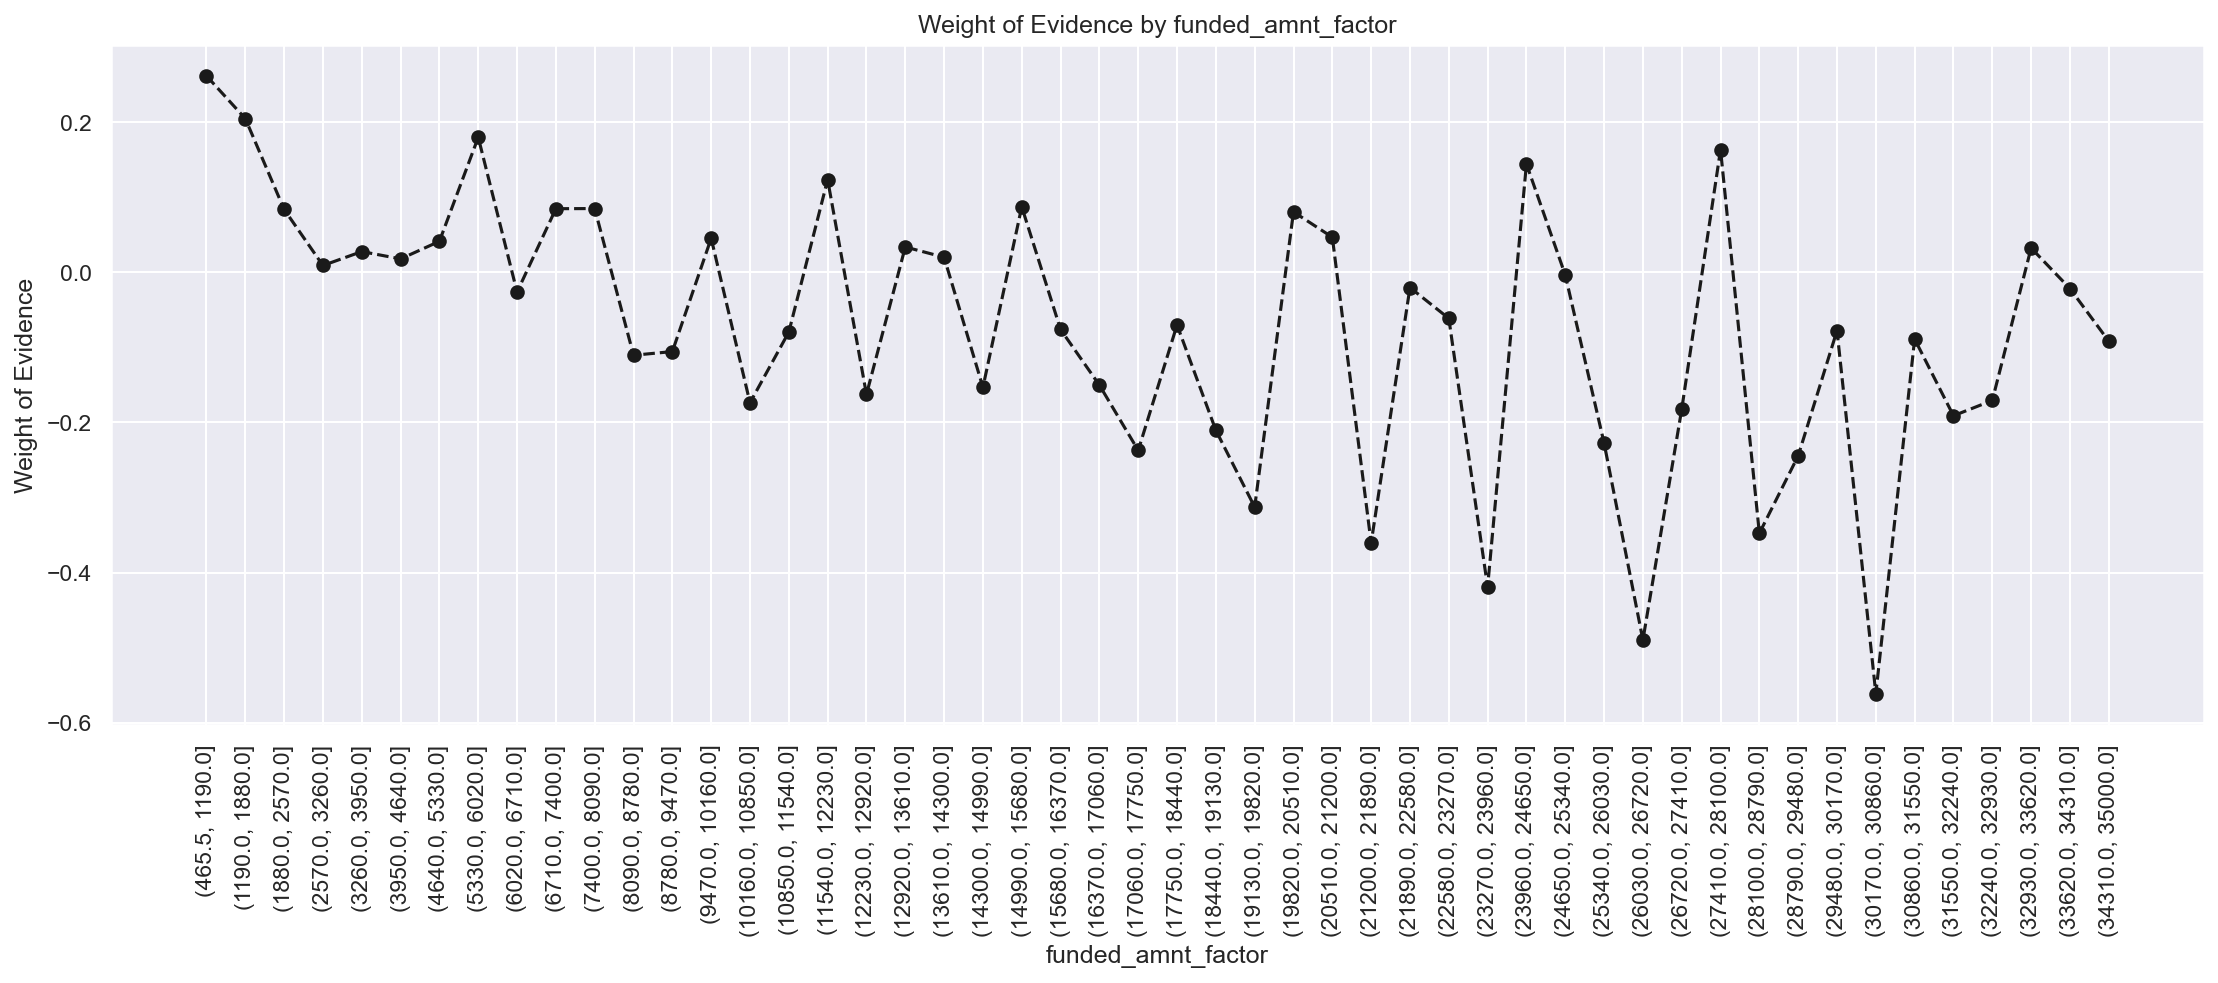

In [57]:
plot_by_woe(funded_amnt_factor_df, 90)

All variations in weight of evidence, depicted by the graph, form a horizontal trend, indicating no relationship between the independent variable, funded amounts and weight of evidence. Therefore, this variable will not be used in PD model

##### Months since earliest credit line variable

In [58]:
X_train["mths_since_earliest_cr_line_factor"] = pd.cut(X_train["mths_since_earliest_cr_line"], 50)
mths_since_earliest_cr_line_factor_df = woe_ordered_continuous(X_train, "mths_since_earliest_cr_line_factor", y_train)
mths_since_earliest_cr_line_factor_df

mths_since_earliest_cr_line_factor  n_obs  prop_good  props_n_obs   n_good  \
0                     (-0.887, 17.74]     24   1.000000     0.000064     24.0   
1                      (17.74, 35.48]      0        NaN     0.000000      NaN   
2                      (35.48, 53.22]      0        NaN     0.000000      NaN   
3                      (53.22, 70.96]      0        NaN     0.000000      NaN   
4                       (70.96, 88.7]   1815   0.898623     0.004866   1631.0   
5                      (88.7, 106.44]   3873   0.861606     0.010383   3337.0   
6                    (106.44, 124.18]  10048   0.867934     0.026936   8721.0   
7                    (124.18, 141.92]  16745   0.868199     0.044889  14538.0   
8                    (141.92, 159.66]  21889   0.879209     0.058679  19245.0   
9                     (159.66, 177.4]  27877   0.883847     0.074732  24639.0   
10                    (177.4, 195.14]  35548   0.886913     0.095296  31528.0   
11                   (195.14, 212.88]  39828   0.886035     0.106769  35289.0   
12                   (212.88, 230.62]  39307   0.888315     0.105373  34917.0   
13                   (230.62, 248.36]  29966   0.892512     0.080332  26745.0   
14                    (248.36, 266.1]  27562   0.895653     0.073887  24686.0   
15                    (266.1, 283.84]  23062   0.903651     0.061824  20840.0   
16                   (283.84, 301.58]  19063   0.904947     0.051103  17251.0   
17                   (301.58, 319.32]  12615   0.908125     0.033818  11456.0   
18                   (319.32, 337.06]  12911   0.906359     0.034611  11702.0   
19                    (337.06, 354.8]  10368   0.906346     0.027794   9397.0   
20                    (354.8, 372.54]   8587   0.912775     0.023020   7838.0   
21                   (372.54, 390.28]   6994   0.910781     0.018749   6370.0   
22                   (390.28, 408.02]   6043   0.908324     0.016200   5489.0   
23                   (408.02, 425.76]   4316   0.909639     0.011570   3926.0   
24                    (425.76, 443.5]   3025   0.919008     0.008109   2780.0   
25                    (443.5, 461.24]   2467   0.910823     0.006613   2247.0   
26                   (461.24, 478.98]   2248   0.912811     0.006026   2052.0   
27                   (478.98, 496.72]   1880   0.910638     0.005040   1712.0   
28                   (496.72, 514.46]   1235   0.921457     0.003311   1138.0   
29                    (514.46, 532.2]    986   0.911765     0.002643    899.0   
30                    (532.2, 549.94]    741   0.917679     0.001986    680.0   
31                   (549.94, 567.68]    534   0.897004     0.001432    479.0   
32                   (567.68, 585.42]    484   0.913223     0.001297    442.0   
33                   (585.42, 603.16]    329   0.878419     0.000882    289.0   
34                    (603.16, 620.9]    221   0.877828     0.000592    194.0   
35                    (620.9, 638.64]    168   0.869048     0.000450    146.0   
36                   (638.64, 656.38]     98   0.846939     0.000263     83.0   
37                   (656.38, 674.12]     67   0.925373     0.000180     62.0   
38                   (674.12, 691.86]     35   0.857143     0.000094     30.0   
39                    (691.86, 709.6]     28   0.928571     0.000075     26.0   
40                    (709.6, 727.34]     10   0.900000     0.000027      9.0   
41                   (727.34, 745.08]      9   0.666667     0.000024      6.0   
42                   (745.08, 762.82]      7   0.714286     0.000019      5.0   
43                   (762.82, 780.56]      4   1.000000     0.000011      4.0   
44                    (780.56, 798.3]      1   1.000000     0.000003      1.0   
45                    (798.3, 816.04]      5   1.000000     0.000013      5.0   
46                   (816.04, 833.78]      1   1.000000     0.000003      1.0   
47                   (833.78, 851.52]      1   1.000000     0.000003      1.0   
48                   (851.52, 869.

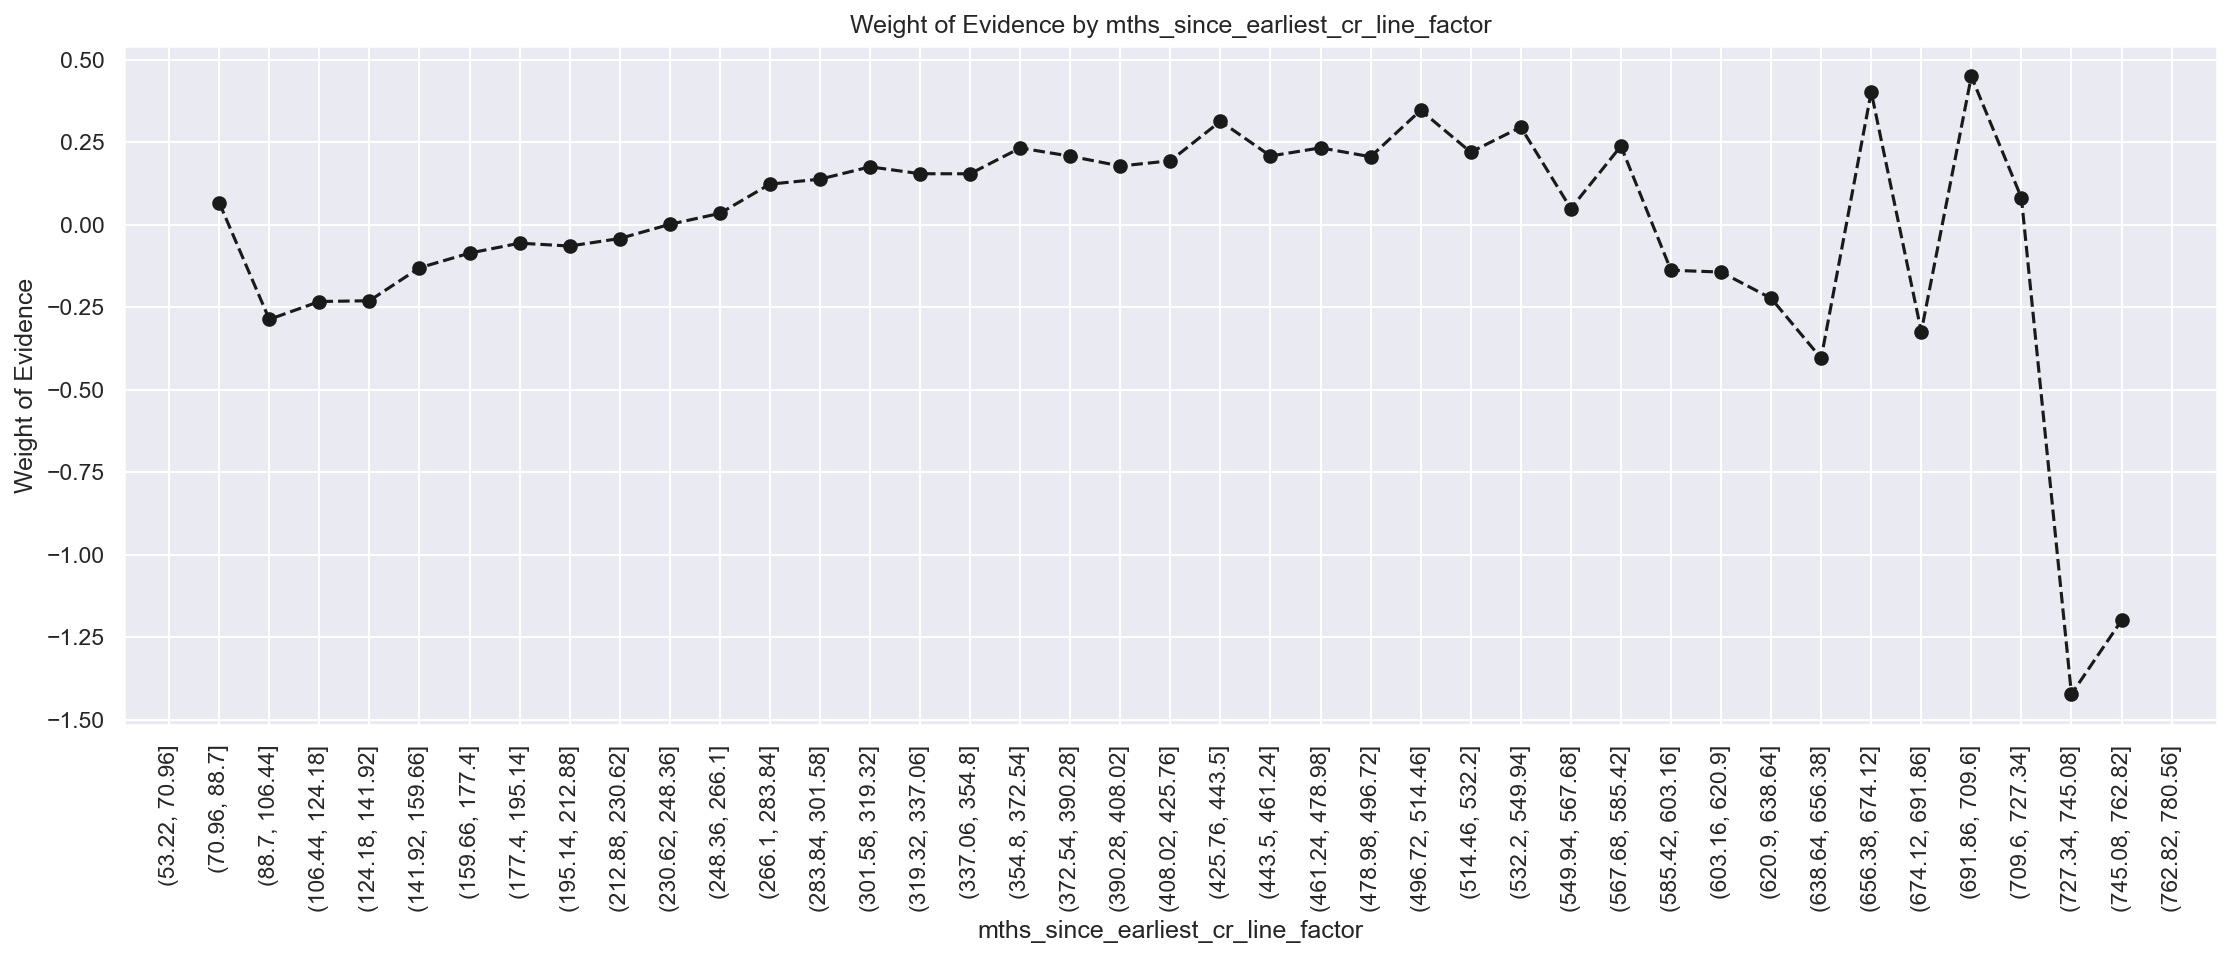

In [59]:
plot_by_woe(mths_since_earliest_cr_line_factor_df, 90)

Due to extreme values being present in this variable, the visualization is being distorted. This is because there aren't enough observations in the tails of the data, resulting in off cases being represented as if they were the represented the entire category

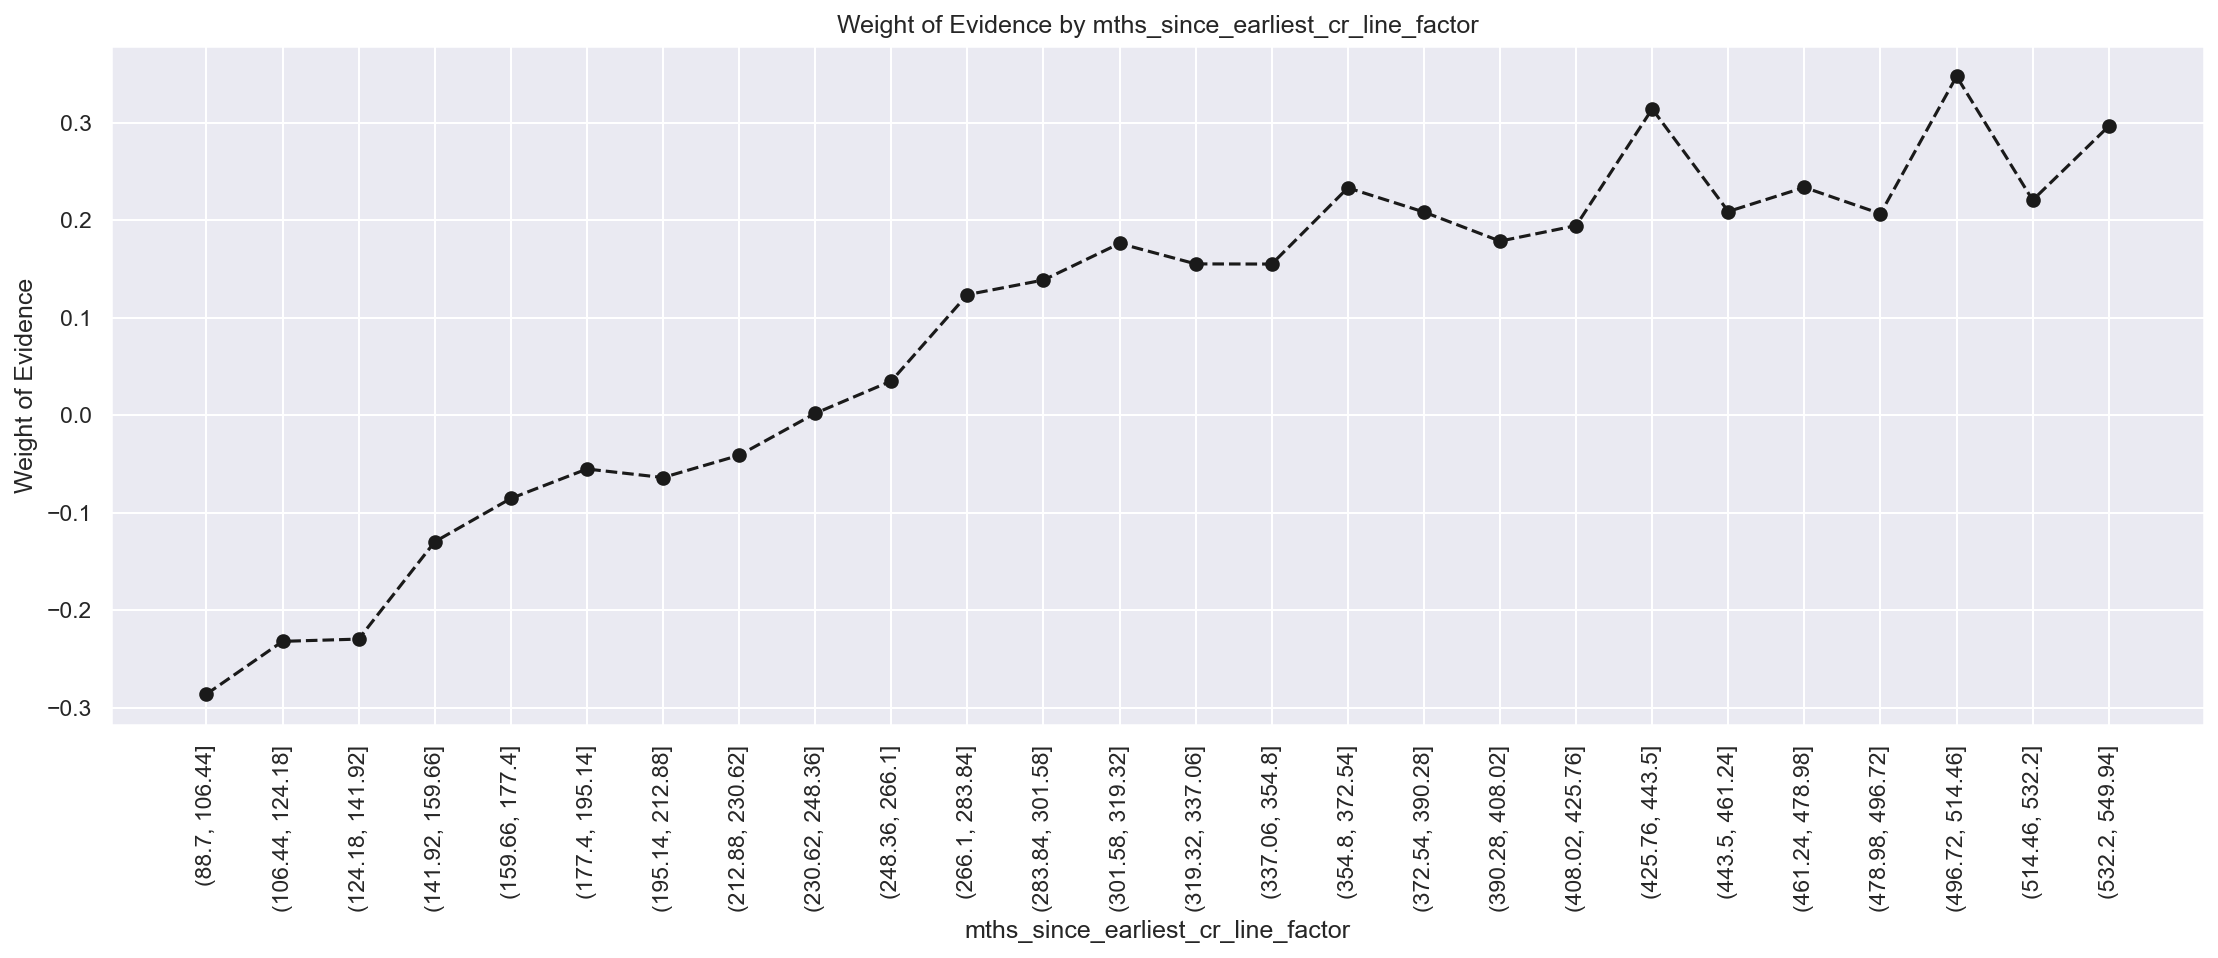

In [60]:
plot_by_woe(mths_since_earliest_cr_line_factor_df.iloc[5:31, :], 90)

We can see a clearer pattern emerge once the extreme values are taken care of

There wil be 7 groupings:

- (1) x < 141.92
- (2) 141.92 < x < 195.14
- (3) 195.14 < x < 266.1
- (4) 266.1 < x < 301.58
- (5) 301.58 < x < 354.8
- (6) 354.8 < x < 425.76
- (7) x > 425.76

*note that x = mths_since_earliest_cr_line_factor

In [61]:
X_train["mths_since_earliest_cr_line:<140"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(140)), 1, 0)
X_train["mths_since_earliest_cr_line:140-195"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(140, 195)), 1, 0)
X_train["mths_since_earliest_cr_line:195-266"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(195, 266)), 1, 0)
X_train["mths_since_earliest_cr_line:266-302"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(266, 302)), 1, 0)
X_train["mths_since_earliest_cr_line:302-355"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(302, 355)), 1, 0)
X_train["mths_since_earliest_cr_line:355-426"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(355, 426)), 1, 0)
X_train["mths_since_earliest_cr_line:>426"] = np.where(X_train["mths_since_earliest_cr_line"].isin(range(426, int(X_train["mths_since_earliest_cr_line"].max()))), 1, 0)

##### Installment variable

In [62]:
X_train["installment_factor"] = pd.cut(X_train["installment"], 50)
installment_factor_df = woe_ordered_continuous(X_train, "installment_factor", y_train)
installment_factor_df

installment_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0       (14.276, 43.556]   1812   0.915011     0.004858   1658.0   154.0   
1       (43.556, 71.443]   4841   0.903945     0.012978   4376.0   465.0   
2       (71.443, 99.329]   6824   0.898154     0.018294   6129.0   695.0   
3      (99.329, 127.216]   9138   0.895601     0.024497   8184.0   954.0   
4     (127.216, 155.102]  10040   0.899303     0.026915   9029.0  1011.0   
5     (155.102, 182.988]  16816   0.897954     0.045080  15100.0  1716.0   
6     (182.988, 210.875]  17216   0.907760     0.046152  15628.0  1588.0   
7     (210.875, 238.761]  15090   0.902319     0.040453  13616.0  1474.0   
8     (238.761, 266.648]  18842   0.903513     0.050511  17024.0  1818.0   
9     (266.648, 294.534]  20100   0.892537     0.053883  17940.0  2160.0   
10     (294.534, 322.42]  20364   0.897024     0.054591  18267.0  2097.0   
11     (322.42, 350.307]  25521   0.890953     0.068416  22738.0  2783.0   
12    (350.307, 378.193]  19006   0.886457     0.050951  16848.0  2158.0   
13     (378.193, 406.08]  18079   0.895182     0.048466  16184.0  1895.0   
14     (406.08, 433.966]  13345   0.880405     0.035775  11749.0  1596.0   
15    (433.966, 461.852]  12574   0.883649     0.033708  11111.0  1463.0   
16    (461.852, 489.739]  15685   0.894103     0.042048  14024.0  1661.0   
17    (489.739, 517.625]  15648   0.893085     0.041949  13975.0  1673.0   
18    (517.625, 545.512]  10775   0.865615     0.028885   9327.0  1448.0   
19    (545.512, 573.398]  10558   0.878481     0.028304   9275.0  1283.0   
20    (573.398, 601.284]   9464   0.879755     0.025371   8326.0  1138.0   
21    (601.284, 629.171]   9341   0.906113     0.025041   8464.0   877.0   
22    (629.171, 657.057]   8357   0.897930     0.022403   7504.0   853.0   
23    (657.057, 684.944]   9171   0.891833     0.024585   8179.0   992.0   
24     (684.944, 712.83]   6171   0.879112     0.016543   5425.0   746.0   
25     (712.83, 740.716]   4841   0.885354     0.012978   4286.0   555.0   
26    (740.716, 768.603]   5231   0.895240     0.014023   4683.0   548.0   
27    (768.603, 796.489]   4926   0.904182     0.013205   4454.0   472.0   
28    (796.489, 824.376]   4050   0.891111     0.010857   3609.0   441.0   
29    (824.376, 852.262]   3643   0.889926     0.009766   3242.0   401.0   
30    (852.262, 880.148]   4260   0.894601     0.011420   3811.0   449.0   
31    (880.148, 908.035]   3247   0.871882     0.008704   2831.0   416.0   
32    (908.035, 935.921]   2189   0.875286     0.005868   1916.0   273.0   
33    (935.921, 963.808]   2440   0.876639     0.006541   2139.0   301.0   
34    (963.808, 991.694]   1787   0.834359     0.004791   1491.0   296.0   
35    (991.694, 1019.58]   1617   0.858998     0.004335   1389.0   228.0   
36   (1019.58, 1047.467]   1267   0.870560     0.003397   1103.0   164.0   
37  (1047.467, 1075.353]    898   0.888641     0.002407    798.0   100.0   
38   (1075.353, 1103.24]   1035   0.927536     0.002775    960.0    75.0   
39   (1103.24, 1131.126]    832   0.920673     0.002230    766.0    66.0   
40  (1131.126, 1159.012]    972   0.920782     0.002606    895.0    77.0   
41  (1159.012, 1186.899]   1181   0.917866     0.003166   1084.0    97.0   
42  (1186.899, 1214.785]   1252   0.900958     0.003356   1128.0   124.0   
43  (1214.785, 1242.672]   1019   0.891070     0.002732    908.0   111.0   
44  (1242.672, 1270.558]    711   0.859353     0.001906    611.0   100.0   
45  (1270.558, 1298.444]    457   0.829322     0.001225    379.0    78.0   
46  (1298.444, 1326.331]    197   0.761421     0.000528    150.0    47.0   
47  (1326.331, 1354.217]    121   0.760331     0.000324     92.0    29.0   
48  (1354.217, 1382.104]     41   0.707317     0.000110     29.0    12.0   
49   (1382.104, 1409.99]     36   0.805556     0.000097     29.0     7.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i_v  \
0      0.004981    0.003834  0.261680           

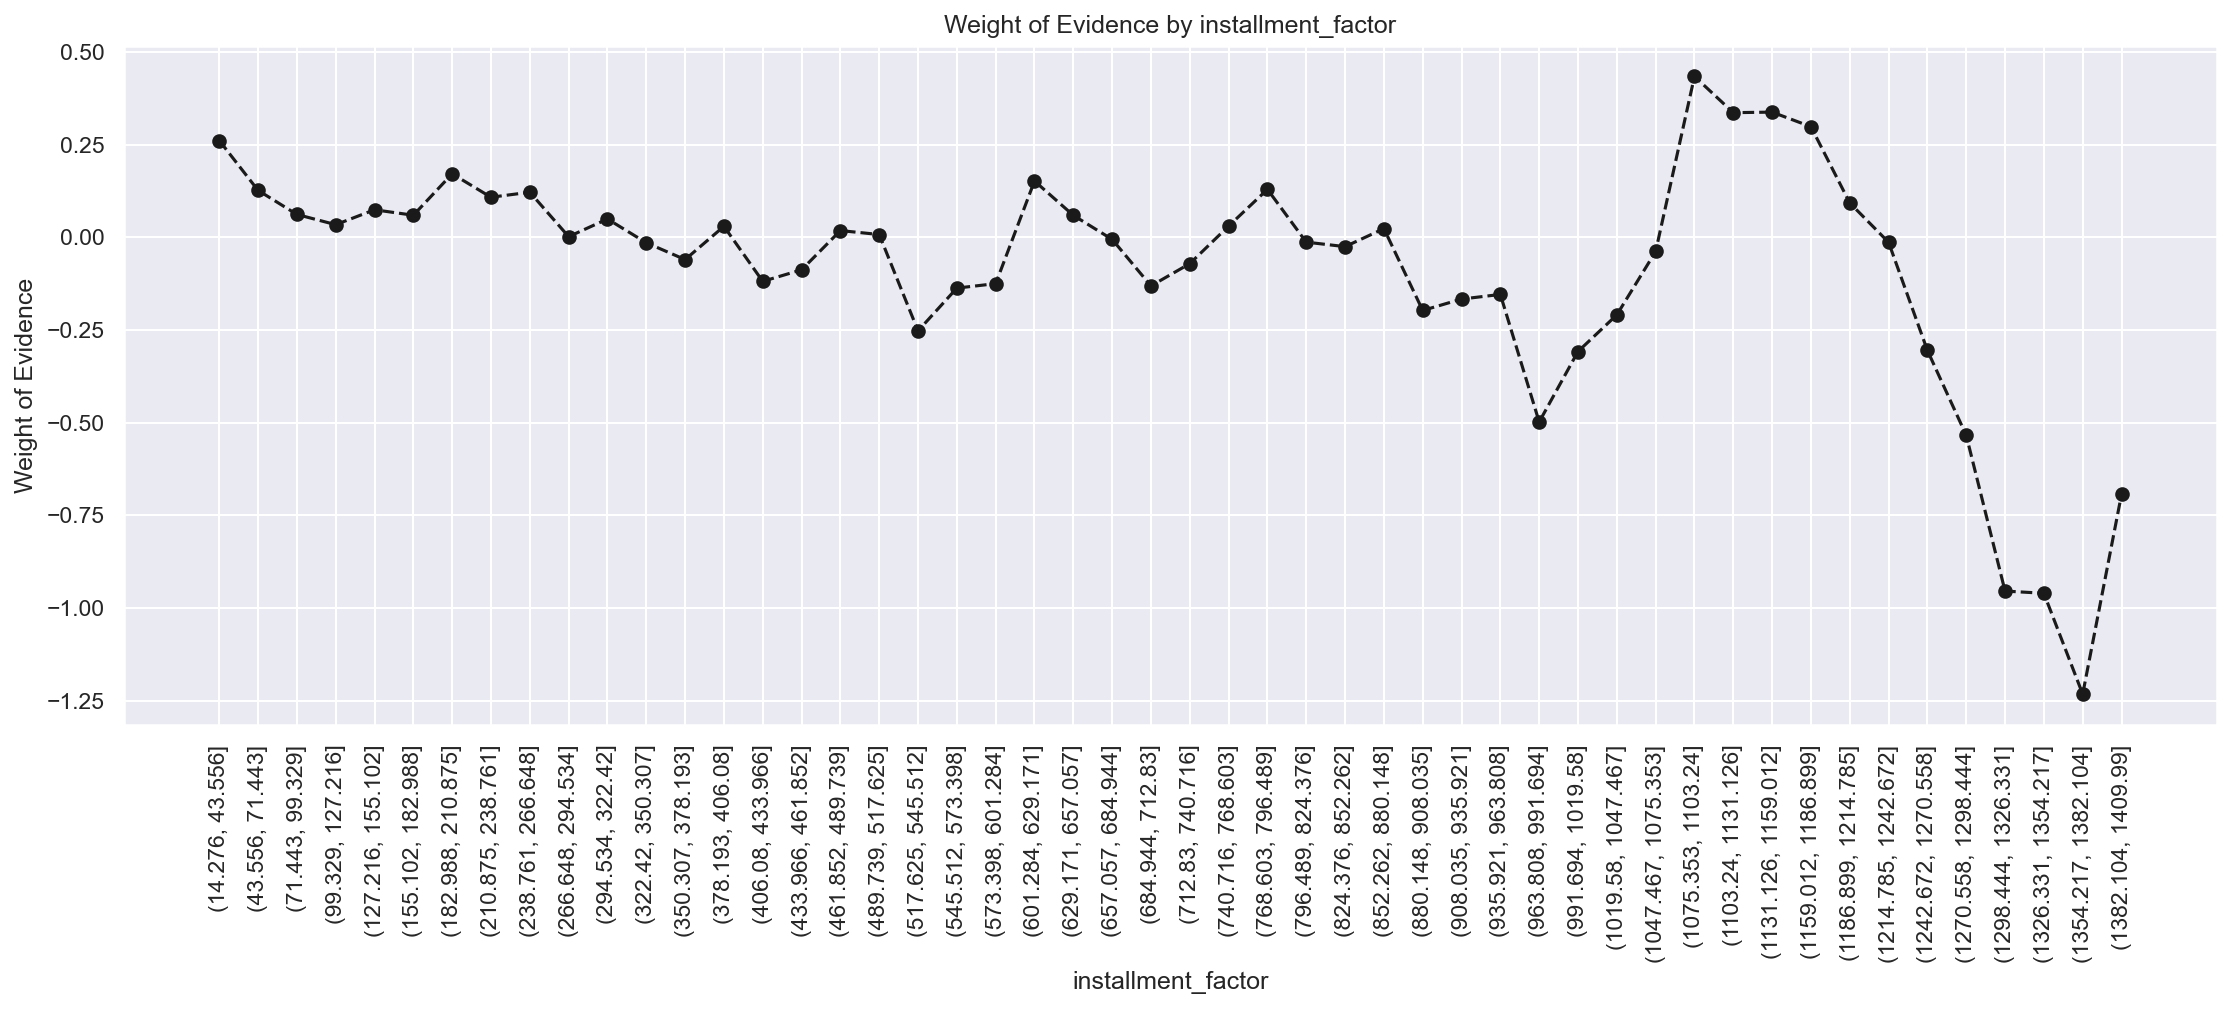

In [63]:
plot_by_woe(installment_factor_df, 90)

All variations in weight of evidence, depicted by the graph, form a horizontal trend, indicating no relationship between the independent variable, installment and weight of evidence. Therefore, this variable will not be used in PD model

##### Delinquent in 2 years variable

No need to create a factor, as there are already defined classes

In [64]:
delinq_2yrs_df = woe_ordered_continuous(X_train, "delinq_2yrs", y_train)
delinq_2yrs_df

delinq_2yrs   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0           0.0  306417   0.892180     0.821432  273379.0  33038.0   
1           1.0   44927   0.894896     0.120439   40205.0   4722.0   
2           2.0   13118   0.890227     0.035166   11678.0   1440.0   
3           3.0    4550   0.884396     0.012197    4024.0    526.0   
4           4.0    1868   0.899893     0.005008    1681.0    187.0   
5           5.0     966   0.881988     0.002590     852.0    114.0   
6           6.0     501   0.904192     0.001343     453.0     48.0   
7           7.0     279   0.860215     0.000748     240.0     39.0   
8           8.0     148   0.905405     0.000397     134.0     14.0   
9           9.0      89   0.887640     0.000239      79.0     10.0   
10         10.0      56   0.857143     0.000150      48.0      8.0   
11         11.0      31   0.903226     0.000083      28.0      3.0   
12         12.0      30   0.733333     0.000080      22.0      8.0   
13         13.0      18   0.833333     0.000048      15.0      3.0   
14         14.0       6   0.833333     0.000016       5.0      1.0   
15         15.0       6   0.833333     0.000016       5.0      1.0   
16         16.0       4   1.000000     0.000011       4.0      0.0   
17         17.0       3   0.666667     0.000008       2.0      1.0   
18         18.0       3   0.666667     0.000008       2.0      1.0   
19         19.0       2   1.000000     0.000005       2.0      0.0   
20         21.0       2   0.500000     0.000005       1.0      1.0   
21         22.0       2   1.000000     0.000005       2.0      0.0   
22         24.0       1   1.000000     0.000003       1.0      0.0   
23         29.0       1   1.000000     0.000003       1.0      0.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good      diff_WoE  \
0      0.821296    0.822557 -0.001534             NaN           NaN   
1      0.120785    0.117565  0.027024        0.002717  2.855823e-02   
2      0.035084    0.035852 -0.021671        0.004669  4.869531e-02   
3      0.012089    0.013096 -0.080005        0.005832  5.833312e-02   
4      0.005050    0.004656  0.081300        0.015497  1.613050e-01   
5      0.002560    0.002838 -0.103347        0.017905  1.846474e-01   
6      0.001361    0.001195  0.129956        0.022204  2.333030e-01   
7      0.000721    0.000971 -0.297658        0.043977  4.276138e-01   
8      0.000403    0.000349  0.144047        0.045190  4.417052e-01   
9      0.000237    0.000249 -0.047872        0.017765  1.919197e-01   
10     0.000144    0.000199 -0.322976        0.030498  2.751033e-01   
11     0.000084    0.000075  0.118857        0.046083  4.418328e-01   
12     0.000066    0.000199 -1.103134        0.169892  1.221991e+00   
13     0.000045    0.000075 -0.505297        0.100000  5.978370e-01   
14     0.000015    0.000025 -0.505297        0.000000  2.220446e-16   
15     0.000015    0.000025 -0.505297        0.000000  0.000000e+00   
16     0.000012    0.000000       inf        0.166667           inf   
17     0.000006    0.000025 -1.421588        0.333333           inf   
18     0.000006    0.000025 -1.421588        0.000000  0.000000e+00   
19     0.000006    0.000000       inf        0.333333           inf   
20     0.000003    0.000025 -2.114735        0.500000           inf   
21     0.000006    0.000000       inf        0.500000           inf   
22     0.000003    0.000000       inf        0.000000           NaN   
23     0.000003    0.000000       inf        0.000000           NaN   

             i_v  i_v_sum  
0   1.934947e-06      inf  
1   8.702735e-05      inf  
2   1.665680e-05      inf  
3   8.055827e-05      inf  
4   3.205929e-05      inf  
5   2.880077e-05      inf  
6   2.155321e-05      inf  
7   7.440768e-05      inf  
8   7.779404e-06      inf  
9   5.571425e-07      inf  
10  1.775555e-05      inf  
11  1.120442e-06      inf  
12  1.468107e-04      inf  
13  1.497110e-05      inf  
14  4.990367e-06      inf  
15  4.990367e-06      inf  
1

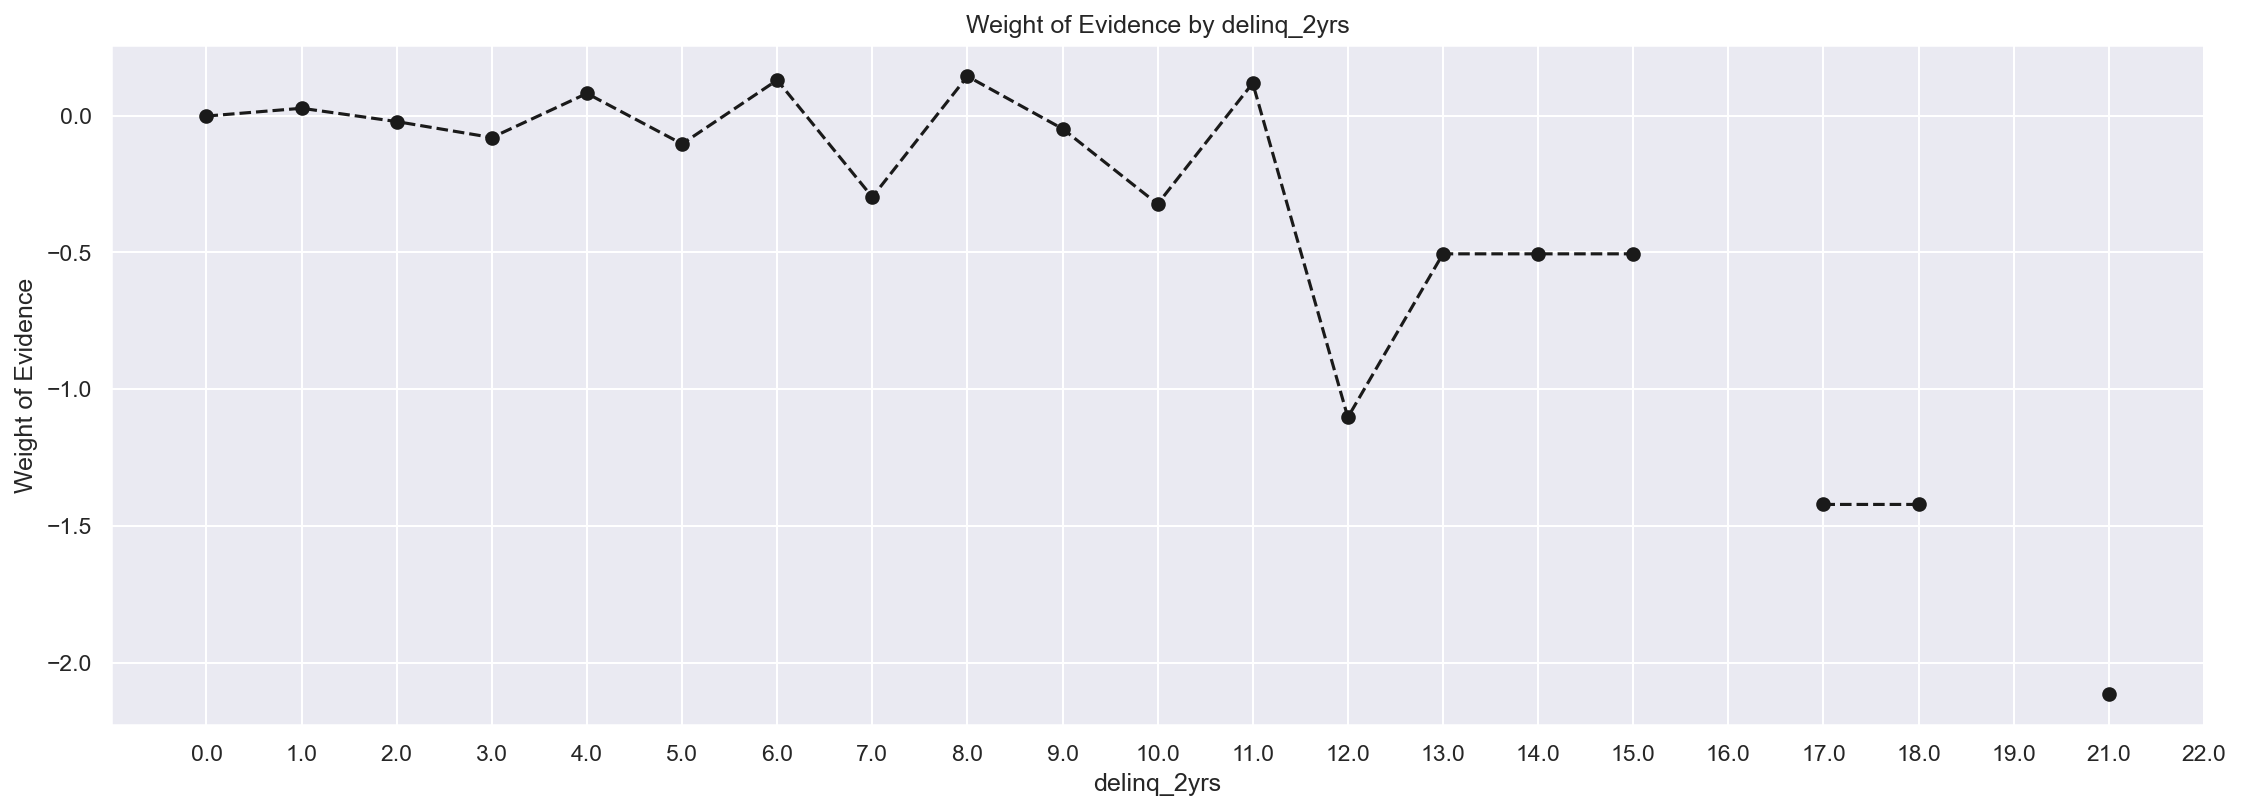

In [65]:
plot_by_woe(delinq_2yrs_df)

There will be 3 groupings::

- (1) x = 0
- (2) 1 <= x <= 3
- (3) x > 3

The third group encompasses all observations beyond 3 years, as the number of observations is too small to make rely on weight of evidence of the individual classes

*note that x = delinq_2yrs

In [66]:
X_train["delinq_2yrs:0"] = np.where((X_train["delinq_2yrs"] == 0), 1, 0)
X_train["delinq_2yrs:1-3"] = np.where((X_train["delinq_2yrs"] >= 1) & (X_train["delinq_2yrs"] <= 3), 1, 0)
X_train["delinq_2yrs:>=4"] = np.where((X_train["delinq_2yrs"] >= 4), 1, 0)

##### Inquiry in last 6 months variable

No need to create a factor, as there are already defined classes

In [67]:
inq_last_6mths_df = woe_ordered_continuous(X_train, "inq_last_6mths", y_train)
inq_last_6mths_df

inq_last_6mths   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0              0.0  193232   0.908690     0.518009  175588.0  17644.0   
1              1.0  104163   0.885478     0.279236   92234.0  11929.0   
2              2.0   46214   0.864846     0.123889   39968.0   6246.0   
3              3.0   20040   0.841218     0.053723   16858.0   3182.0   
4              4.0    5810   0.872117     0.015575    5067.0    743.0   
5              5.0    2217   0.873703     0.005943    1937.0    280.0   
6              6.0     977   0.866940     0.002619     847.0    130.0   
7              7.0     159   0.949686     0.000426     151.0      8.0   
8              8.0     101   0.970297     0.000271      98.0      3.0   
9              9.0      43   1.000000     0.000115      43.0      0.0   
10            10.0      17   1.000000     0.000046      17.0      0.0   
11            11.0       8   1.000000     0.000021       8.0      0.0   
12            12.0      12   1.000000     0.000032      12.0      0.0   
13            13.0       5   1.000000     0.000013       5.0      0.0   
14            14.0       5   1.000000     0.000013       5.0      0.0   
15            15.0       9   1.000000     0.000024       9.0      0.0   
16            16.0       3   1.000000     0.000008       3.0      0.0   
17            17.0       2   1.000000     0.000005       2.0      0.0   
18            18.0       2   1.000000     0.000005       2.0      0.0   
19            19.0       1   1.000000     0.000003       1.0      0.0   
20            20.0       1   1.000000     0.000003       1.0      0.0   
21            24.0       1   1.000000     0.000003       1.0      0.0   
22            25.0       1   1.000000     0.000003       1.0      0.0   
23            27.0       1   1.000000     0.000003       1.0      0.0   
24            28.0       1   1.000000     0.000003       1.0      0.0   
25            31.0       1   1.000000     0.000003       1.0      0.0   
26            32.0       1   1.000000     0.000003       1.0      0.0   
27            33.0       1   1.000000     0.000003       1.0      0.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.527508    0.439288  0.183010             NaN       NaN  0.016145   
1      0.277093    0.297000 -0.069379        0.023213  0.252388  0.001381   
2      0.120073    0.155509 -0.258597        0.020631  0.189219  0.009163   
3      0.050645    0.079223 -0.447420        0.023629  0.188822  0.012786   
4      0.015222    0.018499 -0.194927        0.030899  0.252493  0.000639   
5      0.005819    0.006971 -0.180629        0.001586  0.014298  0.000208   
6      0.002545    0.003237 -0.240569        0.006764  0.059940  0.000166   
7      0.000454    0.000199  0.823103        0.082746  1.063672  0.000209   
8      0.000294    0.000075  1.371620        0.020611  0.548517  0.000301   
9      0.000129    0.000000       inf        0.029703       inf       inf   
10     0.000051    0.000000       inf        0.000000       NaN       inf   
11     0.000024    0.000000       inf        0.000000       NaN       inf   
12     0.000036    0.000000       inf        0.000000       NaN       inf   
13     0.000015    0.000000       inf        0.000000       NaN       inf   
14     0.000015    0.000000       inf        0.000000       NaN       inf   
15     0.000027    0.000000       inf        0.000000       NaN       inf   
16     0.000009    0.000000       inf        0.000000       NaN       inf   
17     0.000006    0.000000       inf        0.000000       NaN       inf   
18     0.000006    0.000000       inf        0.000000       NaN       inf   
19     0.000003    0.000000       inf        0.000000       NaN       inf   
20     0.000003    0.000000       inf        0.000000       NaN       inf   
21     0.000003    0.000000       inf        0.000000       NaN       inf   
22     0.000003    0.000000       inf        0.000000       NaN       inf   
23     0.000003    0.000000       inf 

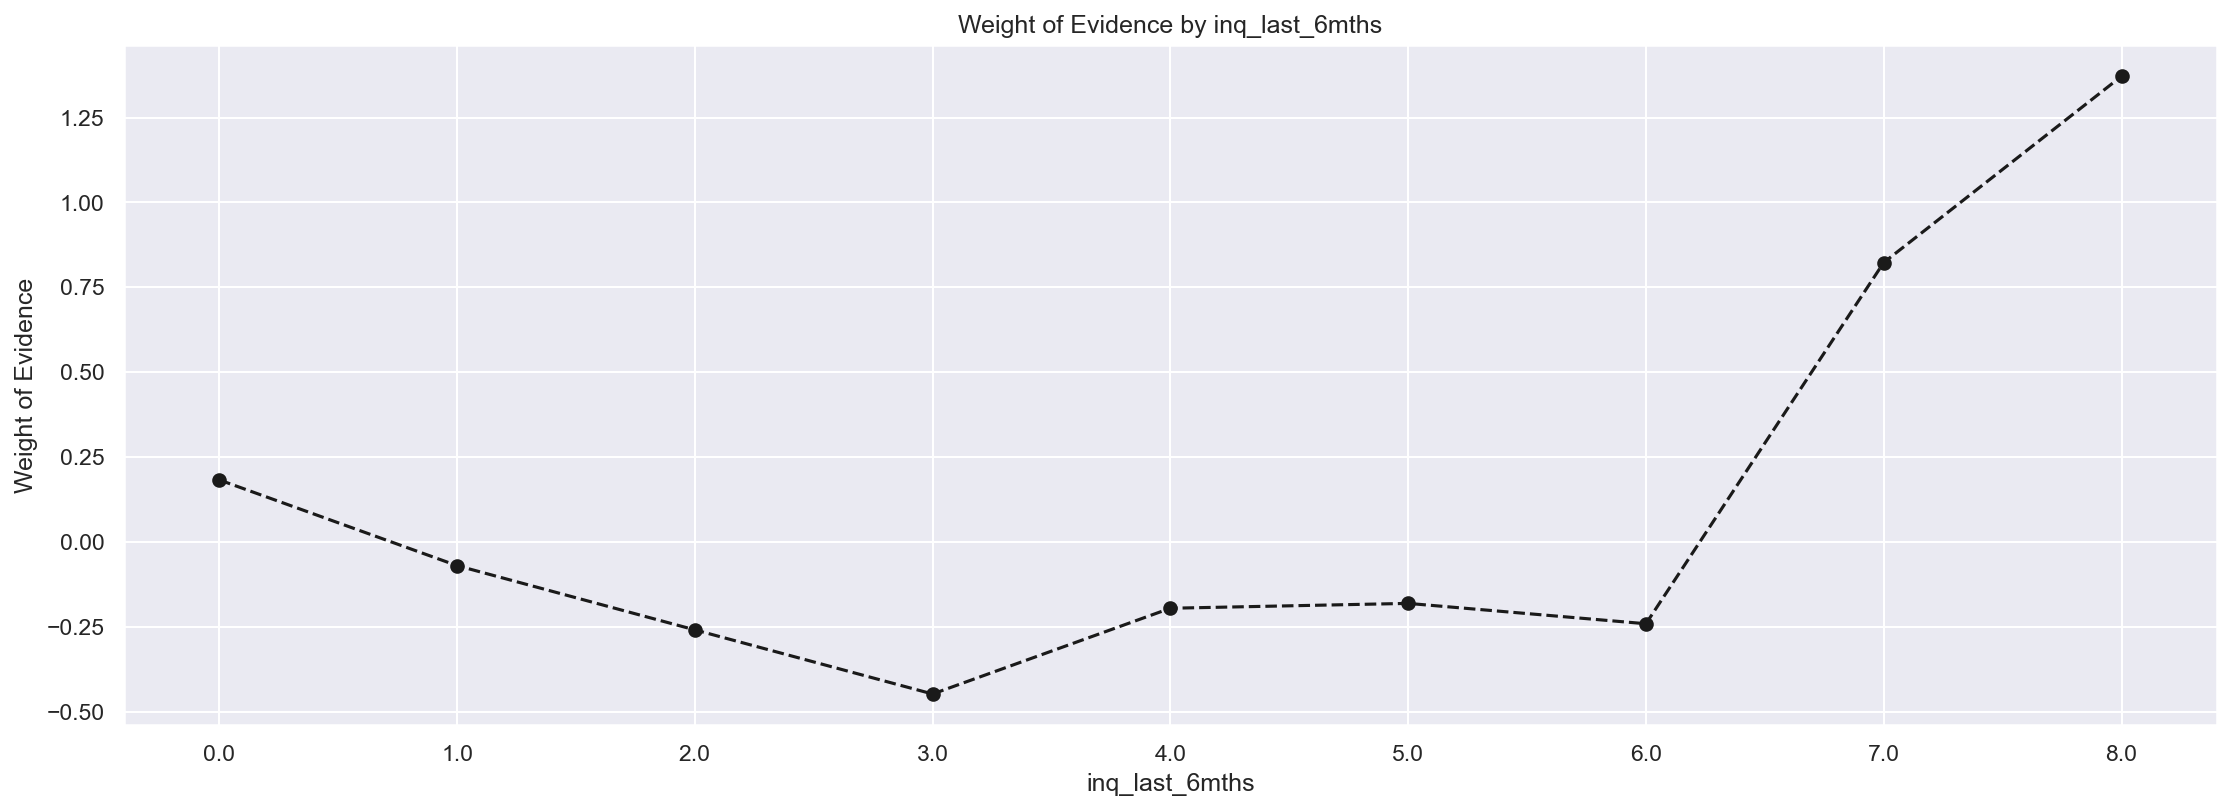

In [68]:
plot_by_woe(inq_last_6mths_df)

There will be 5 groupings:

- (1) x = 0
- (2) 1 <= x <= 2
- (3) 2 < x <= 6
- (4) x > 6

The last group encompasses all observations beyond 6 months, as the number of observations is too small to rely on weight of evidence of the individual classes

*note that x = inq_last_6mths_df

In [69]:
X_train["inq_last_6mths:0"] = np.where((X_train["inq_last_6mths"] == 0), 1, 0)
X_train["inq_last_6mths:1-2"] = np.where((X_train["inq_last_6mths"] >= 1) & (X_train["inq_last_6mths"] <= 2), 1, 0)
X_train["inq_last_6mths:3-6"] = np.where((X_train["inq_last_6mths"] >= 3) & (X_train["inq_last_6mths"] <= 6), 1, 0)
X_train["inq_last_6mths:>6"] = np.where((X_train["inq_last_6mths"] > 6), 1, 0)

##### Open account variable

In [70]:
pd.options.display.max_rows = None
open_acc_factor_df = woe_ordered_continuous(X_train, "open_acc", y_train)
open_acc_factor_df

open_acc  n_obs  prop_good  props_n_obs   n_good   n_bad  prob_n_good  \
0        0.0     29   0.862069     0.000078     25.0     4.0     0.000075   
1        1.0    110   0.936364     0.000295    103.0     7.0     0.000309   
2        2.0   1456   0.859890     0.003903   1252.0   204.0     0.003761   
3        3.0   4378   0.880082     0.011736   3853.0   525.0     0.011575   
4        4.0  10028   0.894495     0.026883   8970.0  1058.0     0.026948   
5        5.0  17141   0.893763     0.045951  15320.0  1821.0     0.046025   
6        6.0  24621   0.894440     0.066003  22022.0  2599.0     0.066159   
7        7.0  30169   0.893666     0.080876  26961.0  3208.0     0.080997   
8        8.0  33579   0.892463     0.090017  29968.0  3611.0     0.090031   
9        9.0  35251   0.890301     0.094500  31384.0  3867.0     0.094285   
10      10.0  33936   0.890205     0.090974  30210.0  3726.0     0.090758   
11      11.0  31372   0.887065     0.084101  27829.0  3543.0     0.083605   
12      12.0  27699   0.890068     0.074254  24654.0  3045.0     0.074067   
13      13.0  23892   0.896702     0.064049  21424.0  2468.0     0.064363   
14      14.0  19770   0.890491     0.052999  17605.0  2165.0     0.052890   
15      15.0  16228   0.893333     0.043503  14497.0  1731.0     0.043552   
16      16.0  13540   0.895569     0.036298  12126.0  1414.0     0.036429   
17      17.0  10712   0.893204     0.028716   9568.0  1144.0     0.028745   
18      18.0   8606   0.896816     0.023071   7718.0   888.0     0.023187   
19      19.0   6836   0.894383     0.018326   6114.0   722.0     0.018368   
20      20.0   5224   0.895865     0.014004   4680.0   544.0     0.014060   
21      21.0   4242   0.898868     0.011372   3813.0   429.0     0.011455   
22      22.0   3313   0.896167     0.008881   2969.0   344.0     0.008920   
23      23.0   2530   0.902767     0.006782   2284.0   246.0     0.006862   
24      24.0   1979   0.891865     0.005305   1765.0   214.0     0.005302   
25      25.0   1542   0.890402     0.004134   1373.0   169.0     0.004125   
26      26.0   1064   0.906955     0.002852    965.0    99.0     0.002899   
27      27.0    863   0.902665     0.002313    779.0    84.0     0.002340   
28      28.0    613   0.908646     0.001643    557.0    56.0     0.001673   
29      29.0    496   0.903226     0.001330    448.0    48.0     0.001346   
30      30.0    377   0.888594     0.001011    335.0    42.0     0.001006   
31      31.0    285   0.908772     0.000764    259.0    26.0     0.000778   
32      32.0    234   0.901709     0.000627    211.0    23.0     0.000634   
33      33.0    175   0.891429     0.000469    156.0    19.0     0.000469   
34      34.0    145   0.910345     0.000389    132.0    13.0     0.000397   
35      35.0    124   0.919355     0.000332    114.0    10.0     0.000342   
36      36.0    104   0.865385     0.000279     90.0    14.0     0.000270   
37      37.0     79   0.886076     0.000212     70.0     9.0     0.000210   
38      38.0     64   0.875000     0.000172     56.0     8.0     0.000168   
39      39.0     55   0.927273     0.000147     51.0     4.0     0.000153   
40      40.0     30   0.933333     0.000080     28.0     2.0     0.000084   
41      41.0     30   0.866667     0.000080     26.0     4.0     0.000078   
42      42.0     22   0.954545     0.000059     21.0     1.0     0.000063   
43      43.0     15   0.866667     0.000040     13.0     2.0     0.000039   
44      44.0     12   0.916667     0.000032     11.0     1.0     0.000033   
45      45.0     14   0.857143     0.000038     12.0     2.0     0.000036   
46      46.0      5   1.000000     0.000013      5.0     0.0     0.000015   
47      47.0      6   1.000000     0.000016      6.0     0.0     0.000018   
48      48.0      4   1.000000     0.000011      4.0     0.0     0.000012   
49      49.0      6   1.000000     0.000016      6.0     0.0     0.000018   
50      50.0      4   1.000000     0.000011      4.0     0.0     0.000012   


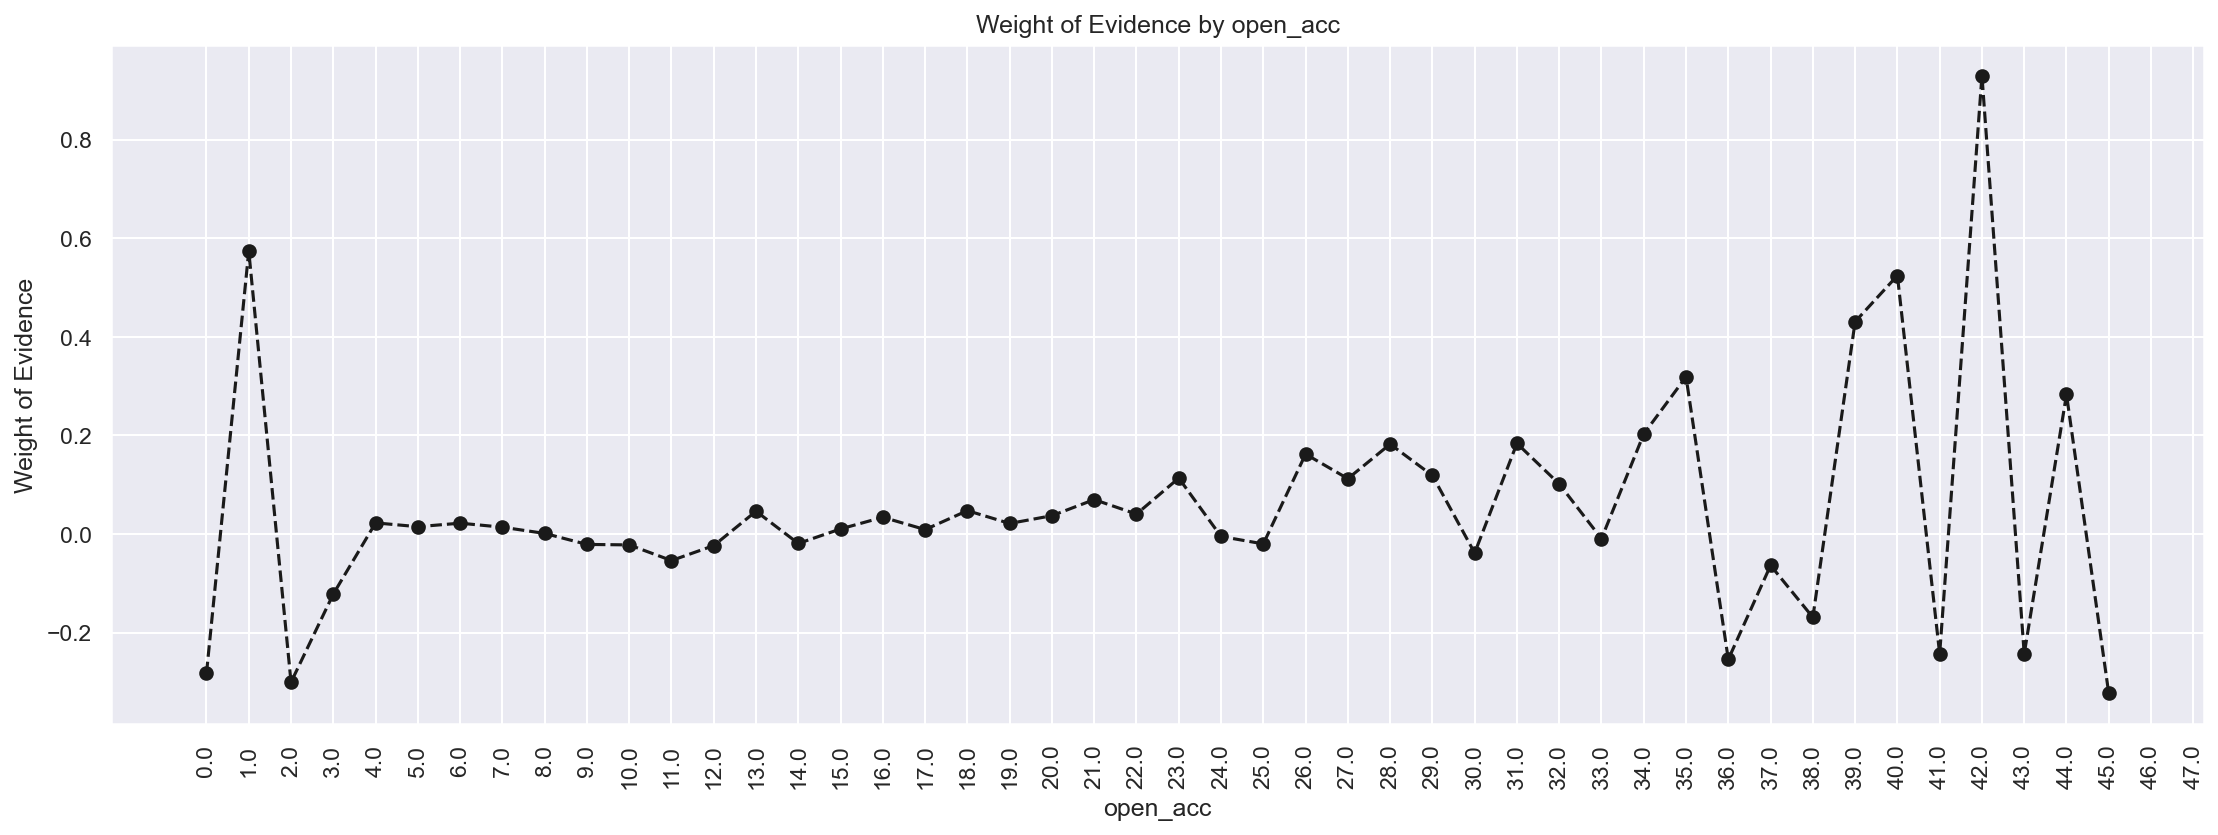

In [71]:
plot_by_woe(open_acc_factor_df, 90)

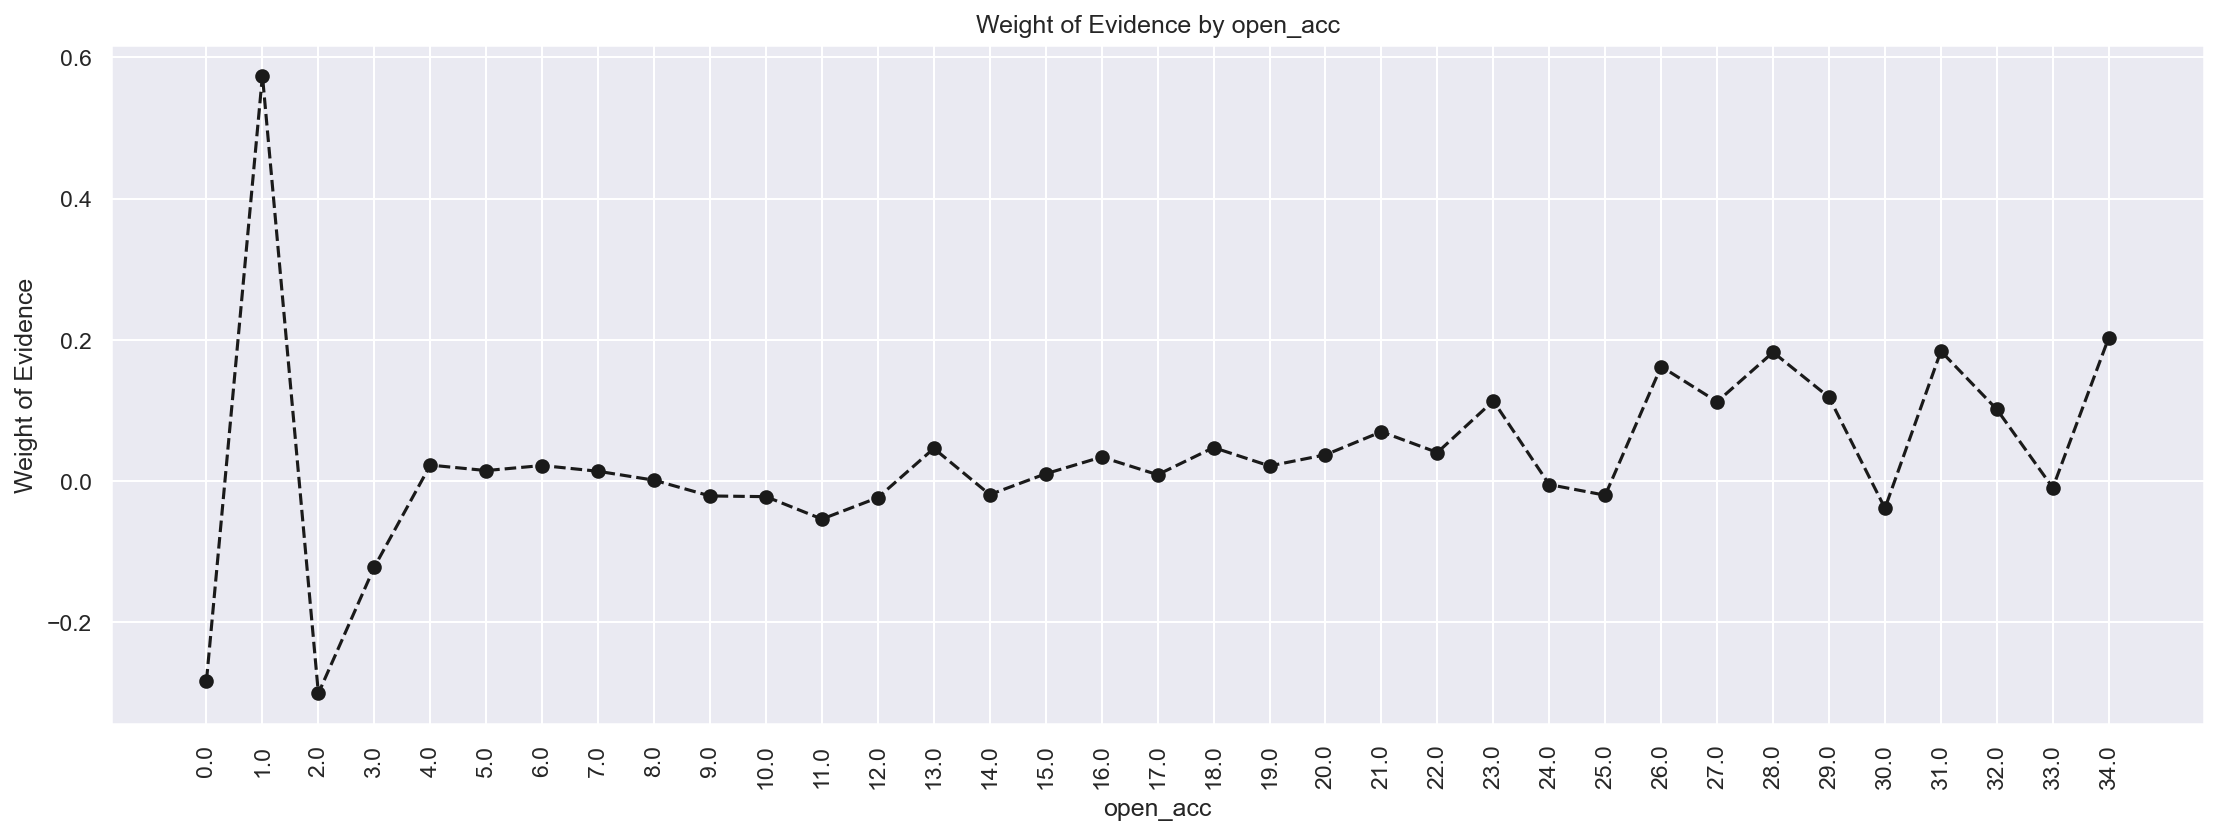

In [72]:
plot_by_woe(open_acc_factor_df.iloc[:35, :], 90)

There will be 7 groupings:

- (1) x = 0
- (2) 1 <= x <=3
- (3) 4 <= x <= 12
- (4) 13 <= x <= 22
- (5) 23 <= x <= 25
- (6) 26 <= x <= 30
- (7) x > 30

*note that x = open_acc

In [73]:
X_train["open_acc:0"] = np.where((X_train["open_acc"] == 0), 1, 0)
X_train["open_acc:1-3"] = np.where((X_train["open_acc"] >= 1) & (X_train["open_acc"] <= 3), 1, 0)
X_train["open_acc:4-12"] = np.where((X_train["open_acc"] >= 4) & (X_train["open_acc"] <= 12), 1, 0)
X_train["open_acc:13-22"] = np.where((X_train["open_acc"] >= 13) & (X_train["open_acc"] <= 22), 1, 0)
X_train["open_acc:23-25"] = np.where((X_train["open_acc"] >= 23) & (X_train["open_acc"] <= 25), 1, 0)
X_train["open_acc:26-30"] = np.where((X_train["open_acc"] >= 26) & (X_train["open_acc"] <= 30), 1, 0)
X_train["open_acc:>=31"] = np.where((X_train["open_acc"] >= 31), 1, 0)

##### Public record variable

In [74]:
pub_rec_df = woe_ordered_continuous(X_train, "pub_rec", y_train)
pub_rec_df

pub_rec   n_obs  prop_good  props_n_obs    n_good    n_bad  prob_n_good  \
0       0.0  323999   0.891598     0.868565  288877.0  35122.0     0.867856   
1       1.0   42381   0.895165     0.113613   37938.0   4443.0     0.113975   
2       2.0    4527   0.903689     0.012136    4091.0    436.0     0.012290   
3       3.0    1280   0.920312     0.003431    1178.0    102.0     0.003539   
4       4.0     408   0.924020     0.001094     377.0     31.0     0.001133   
5       5.0     203   0.911330     0.000544     185.0     18.0     0.000556   
6       6.0     117   0.931624     0.000314     109.0      8.0     0.000327   
7       7.0      48   0.958333     0.000129      46.0      2.0     0.000138   
8       8.0      24   1.000000     0.000064      24.0      0.0     0.000072   
9       9.0      14   0.785714     0.000038      11.0      3.0     0.000033   
10     10.0      10   1.000000     0.000027      10.0      0.0     0.000030   
11     11.0       3   1.000000     0.000008       3.0      0.0     0.000009   
12     12.0       1   1.000000     0.000003       1.0      0.0     0.000003   
13     13.0       2   1.000000     0.000005       2.0      0.0     0.000006   
14     15.0       1   1.000000     0.000003       1.0      0.0     0.000003   
15     16.0       1   1.000000     0.000003       1.0      0.0     0.000003   
16     17.0       1   1.000000     0.000003       1.0      0.0     0.000003   
17     18.0       2   1.000000     0.000005       2.0      0.0     0.000006   
18     19.0       1   1.000000     0.000003       1.0      0.0     0.000003   
19     21.0       1   1.000000     0.000003       1.0      0.0     0.000003   
20     34.0       1   1.000000     0.000003       1.0      0.0     0.000003   
21     40.0       1   1.000000     0.000003       1.0      0.0     0.000003   
22     54.0       1   1.000000     0.000003       1.0      0.0     0.000003   
23     63.0       1   1.000000     0.000003       1.0      0.0     0.000003   

    prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  i_v_sum  
0     0.874443 -0.007562             NaN       NaN  0.000050      inf  
1     0.110619  0.029888        0.003567  0.037450  0.000100      inf  
2     0.010855  0.124167        0.008524  0.094279  0.000178      inf  
3     0.002540  0.331866        0.016624  0.207698  0.000332      inf  
4     0.000772  0.383523        0.003707  0.051657  0.000138      inf  
5     0.000448  0.215249        0.012690  0.168274  0.000023      inf  
6     0.000199  0.497171        0.020294  0.281922  0.000064      inf  
7     0.000050  1.020759        0.026709  0.523588  0.000090      inf  
8     0.000000       inf        0.041667       inf       inf      inf  
9     0.000075 -0.815452        0.214286       inf  0.000034      inf  
10    0.000000       inf        0.214286       inf       inf      inf  
11    0.000000       inf        0.000000       NaN       inf      inf  
12    0.000000       inf        0.000000       NaN       inf      inf  
13    0.000000       inf        0.000000       NaN       inf      inf  
14    0.000000       inf        0.000000       NaN       inf      inf  
15    0.000000       inf        0.000000       NaN       inf      inf  
16    0.000000       inf        0.000000       NaN       inf      inf  
17    0.000000       inf        0.000000       NaN       inf      inf  
18    0.000000       inf        0.000000       NaN       inf      inf  
19    0.000000       inf        0.000000       NaN       inf      inf  
20    0.000000       inf        0.000000       NaN       inf      inf  
21    0.000000       inf        0.000000       NaN       inf      inf  
22    0.000000       inf        0.000000       NaN       inf      inf  
23    0.000000       inf        0.000000       NaN       inf      inf

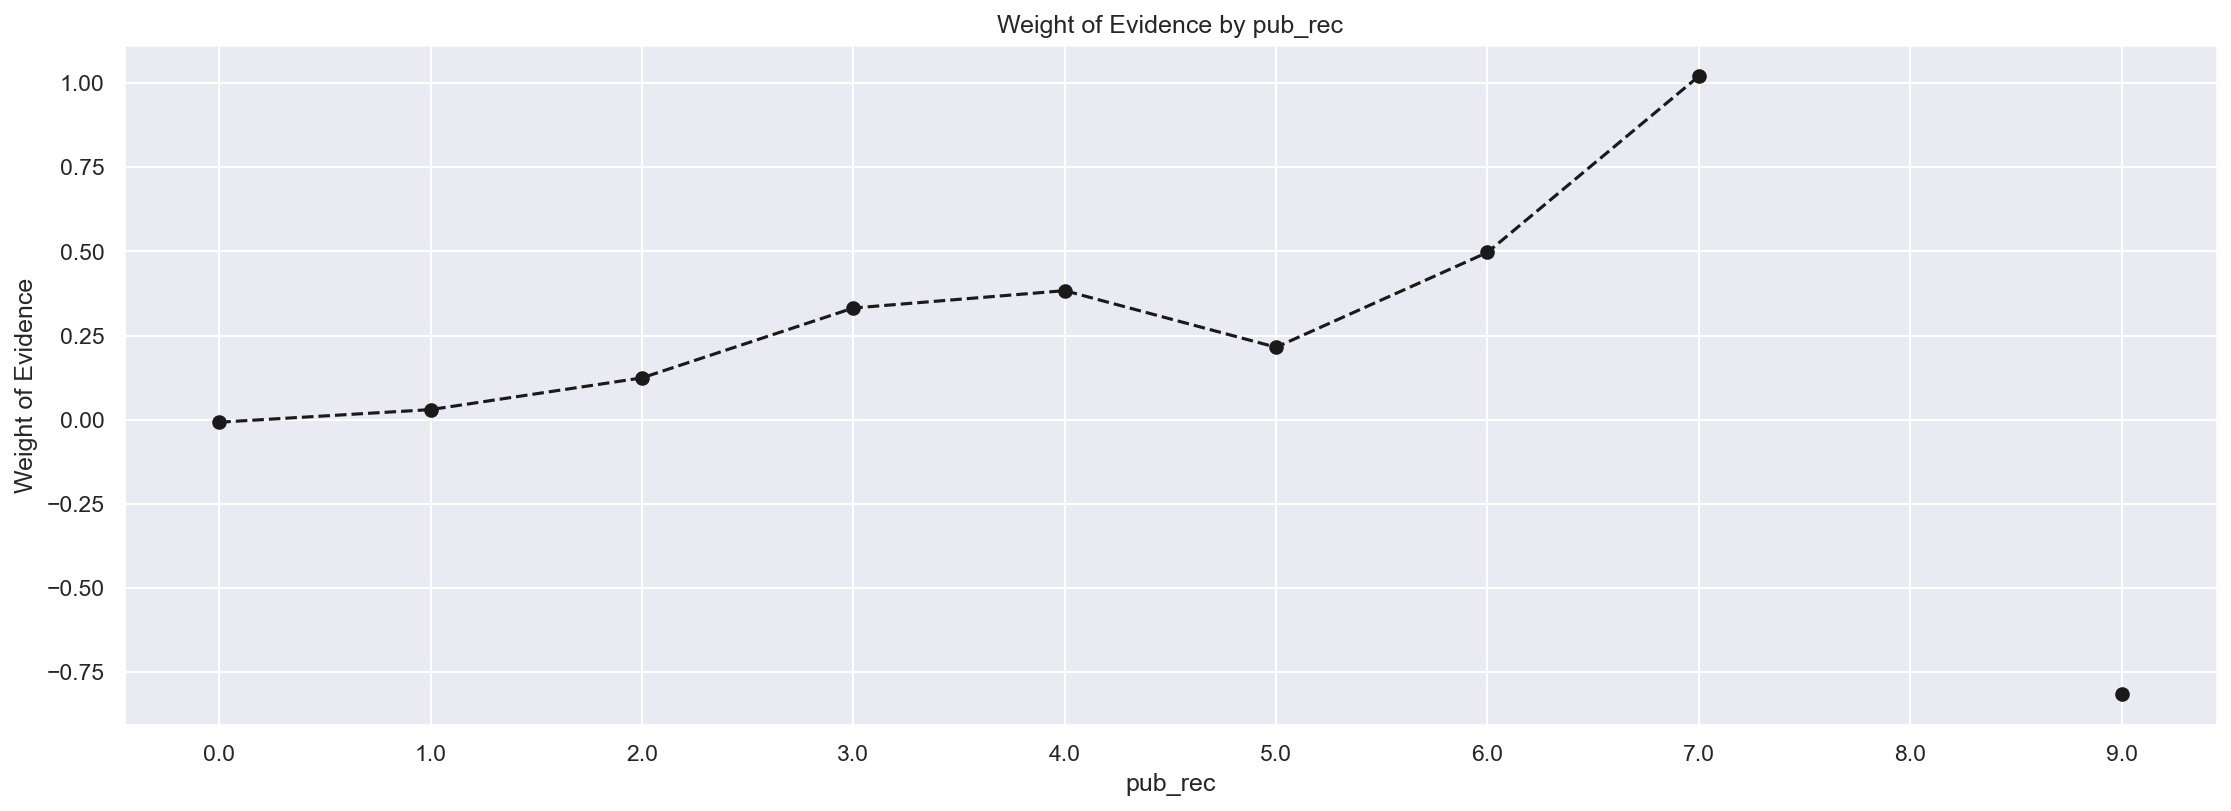

In [75]:
plot_by_woe(pub_rec_df)

There will be 3 groupings:

- (1) 0 <= x <= 2
- (2) 3 <= x <= 4
- (3) x > 4

*note that x = pub_rec

In [76]:
X_train["pub_rec:0-2"] = np.where((X_train["pub_rec"] >= 0) & (X_train["pub_rec"] <= 2), 1, 0)
X_train["pub_rec:3-4"] = np.where((X_train["pub_rec"] >= 3) & (X_train["pub_rec"] <= 4), 1, 0)
X_train["pub_rec:>=5"] = np.where((X_train["pub_rec"] >= 5), 1, 0)

##### Total account variable

In [77]:
X_train["total_acc_factor"] = pd.cut(X_train["total_acc"], 50)

total_acc_factor_df = woe_ordered_continuous(X_train, "total_acc_factor", y_train)
total_acc_factor_df

total_acc_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0      (-0.15, 3.0]    459   0.871460     0.001230    400.0    59.0   
1        (3.0, 6.0]   6004   0.872252     0.016095   5237.0   767.0   
2        (6.0, 9.0]  15047   0.877118     0.040337  13198.0  1849.0   
3       (9.0, 12.0]  25169   0.883070     0.067472  22226.0  2943.0   
4      (12.0, 15.0]  33651   0.883332     0.090210  29725.0  3926.0   
5      (15.0, 18.0]  38711   0.888326     0.103775  34388.0  4323.0   
6      (18.0, 21.0]  40599   0.887288     0.108836  36023.0  4576.0   
7      (21.0, 24.0]  40163   0.892563     0.107668  35848.0  4315.0   
8      (24.0, 27.0]  36286   0.896544     0.097274  32532.0  3754.0   
9      (27.0, 30.0]  31775   0.900142     0.085181  28602.0  3173.0   
10     (30.0, 33.0]  25900   0.896178     0.069432  23211.0  2689.0   
11     (33.0, 36.0]  20748   0.900713     0.055620  18688.0  2060.0   
12     (36.0, 39.0]  16055   0.903145     0.043040  14500.0  1555.0   
13     (39.0, 42.0]  12134   0.902588     0.032528  10952.0  1182.0   
14     (42.0, 45.0]   9107   0.897771     0.024414   8176.0   931.0   
15     (45.0, 48.0]   6494   0.896674     0.017409   5823.0   671.0   
16     (48.0, 51.0]   4551   0.903318     0.012200   4111.0   440.0   
17     (51.0, 54.0]   3260   0.911043     0.008739   2970.0   290.0   
18     (54.0, 57.0]   2146   0.906803     0.005753   1946.0   200.0   
19     (57.0, 60.0]   1605   0.897196     0.004303   1440.0   165.0   
20     (60.0, 63.0]   2164   0.902957     0.005801   1954.0   210.0   
21     (63.0, 66.0]    317   0.914826     0.000850    290.0    27.0   
22     (66.0, 69.0]    218   0.917431     0.000584    200.0    18.0   
23     (69.0, 72.0]    120   0.925000     0.000322    111.0     9.0   
24     (72.0, 75.0]    114   0.885965     0.000306    101.0    13.0   
25     (75.0, 78.0]     64   0.906250     0.000172     58.0     6.0   
26     (78.0, 81.0]     52   0.903846     0.000139     47.0     5.0   
27     (81.0, 84.0]     25   0.880000     0.000067     22.0     3.0   
28     (84.0, 87.0]     28   0.964286     0.000075     27.0     1.0   
29     (87.0, 90.0]     22   0.909091     0.000059     20.0     2.0   
30     (90.0, 93.0]     12   0.916667     0.000032     11.0     1.0   
31     (93.0, 96.0]      8   0.875000     0.000021      7.0     1.0   
32     (96.0, 99.0]      4   0.750000     0.000011      3.0     1.0   
33    (99.0, 102.0]      4   1.000000     0.000011      4.0     0.0   
34   (102.0, 105.0]      4   1.000000     0.000011      4.0     0.0   
35   (105.0, 108.0]      1   1.000000     0.000003      1.0     0.0   
36   (108.0, 111.0]      0        NaN     0.000000      NaN     NaN   
37   (111.0, 114.0]      0        NaN     0.000000      NaN     NaN   
38   (114.0, 117.0]      2   1.000000     0.000005      2.0     0.0   
39   (117.0, 120.0]      2   1.000000     0.000005      2.0     0.0   
40   (120.0, 123.0]      1   1.000000     0.000003      1.0     0.0   
41   (123.0, 126.0]      1   1.000000     0.000003      1.0     0.0   
42   (126.0, 129.0]      0        NaN     0.000000      NaN     NaN   
43   (129.0, 132.0]      0        NaN     0.000000      NaN     NaN   
44   (132.0, 135.0]      0        NaN     0.000000      NaN     NaN   
45   (135.0, 138.0]      0        NaN     0.000000      NaN     NaN   
46   (138.0, 141.0]      0        NaN     0.000000      NaN     NaN   
47   (141.0, 144.0]      0        NaN     0.000000      NaN     NaN   
48   (144.0, 147.0]      0        NaN     0.000000      NaN     NaN   
49   (147.0, 150.0]      1   1.000000     0.000003      1.0     0.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i_v  \
0      0.001202    0.001469 -0.200808             NaN       NaN  5.366492e-05   
1      0.015733    0.019096 -0.193718        0.000792  0.007090  6.514783e-04   
2      0.039650    0.046035 -0.149315        0.004867  0.044403  9.533980e-04   
3      0.066772    0.073273 -0.092902        0.005952  0.

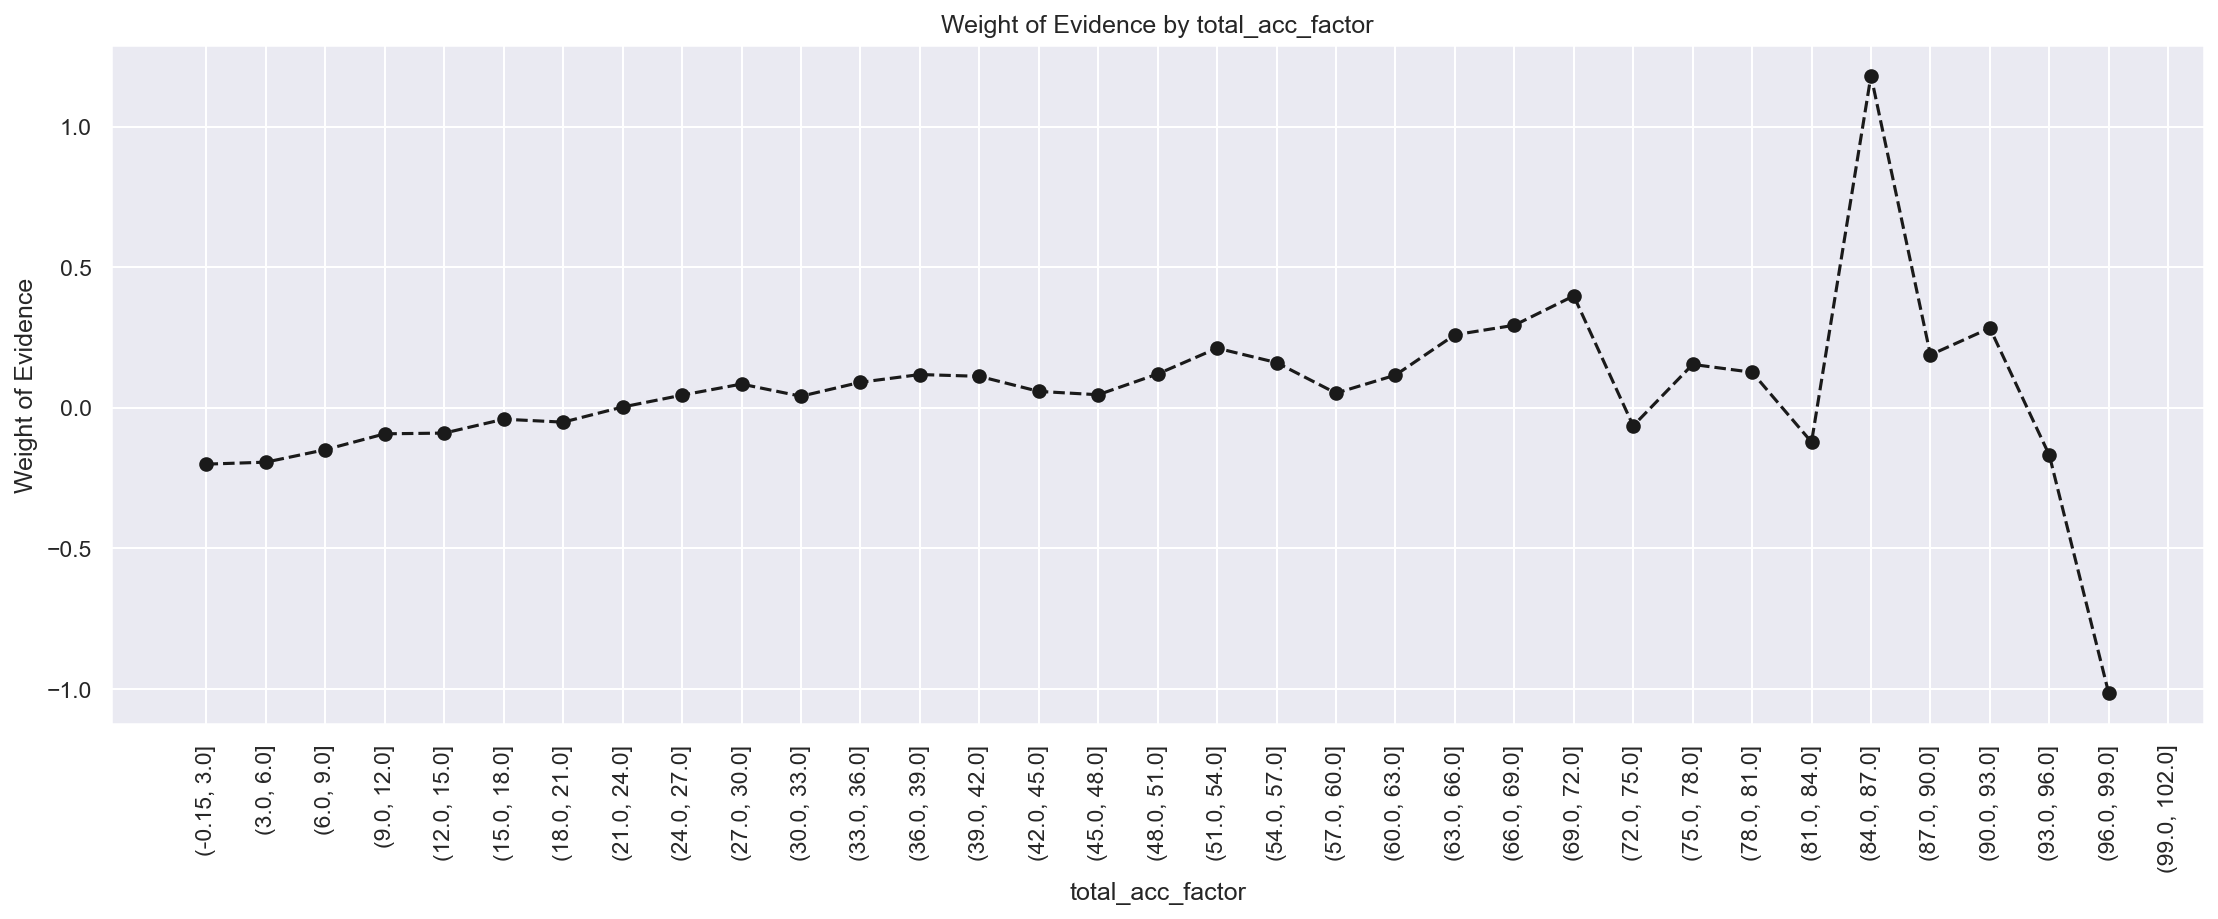

In [78]:
plot_by_woe(total_acc_factor_df.iloc[:, :], 90)

There will be 3 groupings:

- (1) 0 <= x <= 27
- (2) 28 <= x <= 51
- (3) x > 51

*note that x = total_acc

In [79]:
X_train["total_acc:<=27"] = np.where((X_train["total_acc"] <= 27), 1, 0)
X_train["total_acc:28-51"] = np.where((X_train["total_acc"] >= 28) & (X_train["total_acc"] <= 51), 1, 0)
X_train["total_acc:>=52"] = np.where((X_train["total_acc"] >= 52), 1, 0)

##### Accounts now delinquent variable

In [80]:
acc_now_delinq_df = woe_ordered_continuous(X_train, "acc_now_delinq", y_train)
acc_now_delinq_df

acc_now_delinq   n_obs  prop_good  props_n_obs    n_good    n_bad  \
0             0.0  371682   0.892298     0.996392  331651.0  40031.0   
1             1.0    1263   0.899446     0.003386    1136.0    127.0   
2             2.0      70   0.928571     0.000188      65.0      5.0   
3             3.0       7   0.857143     0.000019       6.0      1.0   
4             4.0       4   1.000000     0.000011       4.0      0.0   
5             5.0       2   0.500000     0.000005       1.0      1.0   

   prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i_v  \
0     0.996359    0.996664 -0.000306             NaN       NaN  9.328924e-08   
1     0.003413    0.003162  0.076346        0.007148  0.076652  1.915217e-05   
2     0.000195    0.000124  0.450214        0.029126  0.373868  3.187024e-05   
3     0.000018    0.000025 -0.322976        0.071429  0.773190  2.219444e-06   
4     0.000012    0.000000       inf        0.142857       inf           inf   
5     0.000003    0.000025 -2.114735        0.500000       inf  4.629802e-05   

   i_v_sum  
0      inf  
1      inf  
2      inf  
3      inf  
4      inf  
5      inf

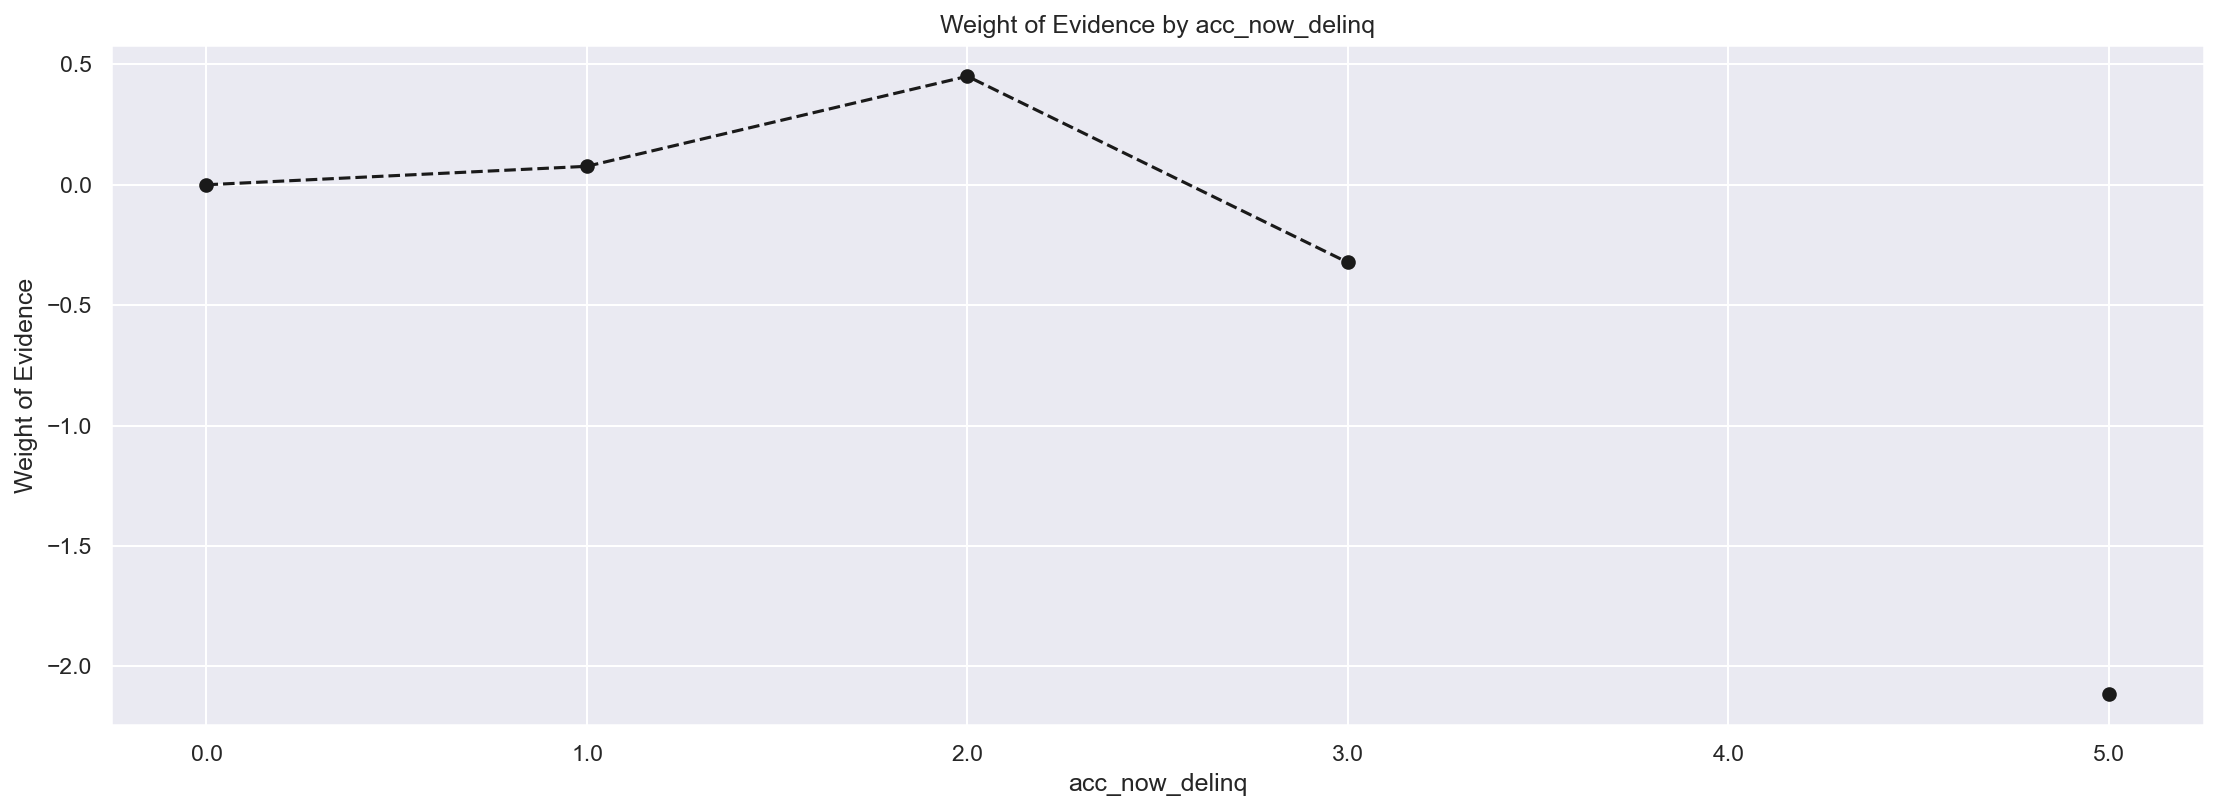

In [81]:
plot_by_woe(acc_now_delinq_df)

There will be 2 groupings:

- (1) 0 x = 0
- (2) x > 0 

*note that x = acc_now_delinq

In [82]:
X_train["acc_now_delinq:0"] = np.where((X_train["acc_now_delinq"] == 0), 1, 0)
X_train["acc_now_delinq:>=1"] = np.where((X_train["acc_now_delinq"] >= 1), 1, 0)

##### Total revenue high limit variable

To make appropriate categories within this variable requires additional factors to ensure signficant data is presented within each range, as there are many 1 off observations in the upper ranges that we will group into a single category below 

In [83]:
X_train["total_rev_hi_lim_factor"] = pd.cut(X_train["total_rev_hi_lim"], 2000)
total_rev_hi_lim_factor_df = woe_ordered_continuous(X_train, "total_rev_hi_lim_factor", y_train)
total_rev_hi_lim_factor_df.iloc[:50, :]

total_rev_hi_lim_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0        (-9999.999, 5000.0]  19417   0.874285     0.052052  16976.0  2441.0   
1         (5000.0, 9999.999]  52655   0.880486     0.141156  46362.0  6293.0   
2      (9999.999, 14999.998]  59570   0.882458     0.159693  52568.0  7002.0   
3     (14999.998, 19999.998]  51455   0.878554     0.137939  45206.0  6249.0   
4     (19999.998, 24999.997]  41582   0.886730     0.111472  36872.0  4710.0   
5     (24999.997, 29999.997]  32093   0.890101     0.086034  28566.0  3527.0   
6     (29999.997, 34999.996]  24516   0.894885     0.065722  21939.0  2577.0   
7     (34999.996, 39999.996]  19767   0.903374     0.052991  17857.0  1910.0   
8     (39999.996, 44999.996]  14719   0.914396     0.039458  13459.0  1260.0   
9     (44999.996, 49999.995]  11585   0.911869     0.031057  10564.0  1021.0   
10    (49999.995, 54999.994]   8964   0.916778     0.024030   8218.0   746.0   
11    (54999.994, 59999.994]   6681   0.927406     0.017910   6196.0   485.0   
12    (59999.994, 64999.994]   5311   0.932216     0.014238   4951.0   360.0   
13    (64999.994, 69999.993]   4305   0.924274     0.011541   3979.0   326.0   
14    (69999.993, 74999.992]   3405   0.933040     0.009128   3177.0   228.0   
15    (74999.992, 79999.992]   2646   0.924414     0.007093   2446.0   200.0   
16    (79999.992, 84999.992]   2196   0.931239     0.005887   2045.0   151.0   
17    (84999.992, 89999.991]   1776   0.931306     0.004761   1654.0   122.0   
18     (89999.991, 94999.99]   1420   0.934507     0.003807   1327.0    93.0   
19      (94999.99, 99999.99]   1178   0.952462     0.003158   1122.0    56.0   
20     (99999.99, 104999.99]   1024   0.949219     0.002745    972.0    52.0   
21   (104999.99, 109999.989]    848   0.944575     0.002273    801.0    47.0   
22  (109999.989, 114999.988]    695   0.949640     0.001863    660.0    35.0   
23  (114999.988, 119999.988]    627   0.937799     0.001681    588.0    39.0   
24  (119999.988, 124999.988]    471   0.949045     0.001263    447.0    24.0   
25  (124999.988, 129999.987]    441   0.931973     0.001182    411.0    30.0   
26  (129999.987, 134999.986]    339   0.955752     0.000909    324.0    15.0   
27  (134999.986, 139999.986]    298   0.953020     0.000799    284.0    14.0   
28  (139999.986, 144999.986]    309   0.941748     0.000828    291.0    18.0   
29  (144999.986, 149999.985]    247   0.951417     0.000662    235.0    12.0   
30  (149999.985, 154999.984]    210   0.933333     0.000563    196.0    14.0   
31  (154999.984, 159999.984]    215   0.967442     0.000576    208.0     7.0   
32  (159999.984, 164999.984]    183   0.950820     0.000491    174.0     9.0   
33  (164999.984, 169999.983]    162   0.962963     0.000434    156.0     6.0   
34  (169999.983, 174999.982]    127   0.921260     0.000340    117.0    10.0   
35  (174999.982, 179999.982]    116   0.939655     0.000311    109.0     7.0   
36  (179999.982, 184999.982]     98   0.989796     0.000263     97.0     1.0   
37  (184999.982, 189999.981]    110   0.945455     0.000295    104.0     6.0   
38   (189999.981, 194999.98]     84   0.952381     0.000225     80.0     4.0   
39    (194999.98, 199999.98]     70   0.914286     0.000188     64.0     6.0   
40    (199999.98, 204999.98]     85   0.976471     0.000228     83.0     2.0   
41   (204999.98, 209999.979]     73   0.945205     0.000196     69.0     4.0   
42  (209999.979, 214999.978]     58   0.982759     0.000155     57.0     1.0   
43  (214999.978, 219999.978]     62   0.919355     0.000166     57.0     5.0   
44  (219999.978, 224999.978]     54   0.925926     0.000145     50.0     4.0   
45  (224999.978, 229999.977]     37   0.945946     0.000099     35.0     2.0   
46  (229999.977, 234999.976]     55   0.909091     0.000147     50.0     5.0   
47  (234999.976, 239999.976]     41   0.951220     0.000110     39.0     2.0   
48  (239999.976, 244999.976]     35   0.971429     0.000094     34.0     1.0   
49  (

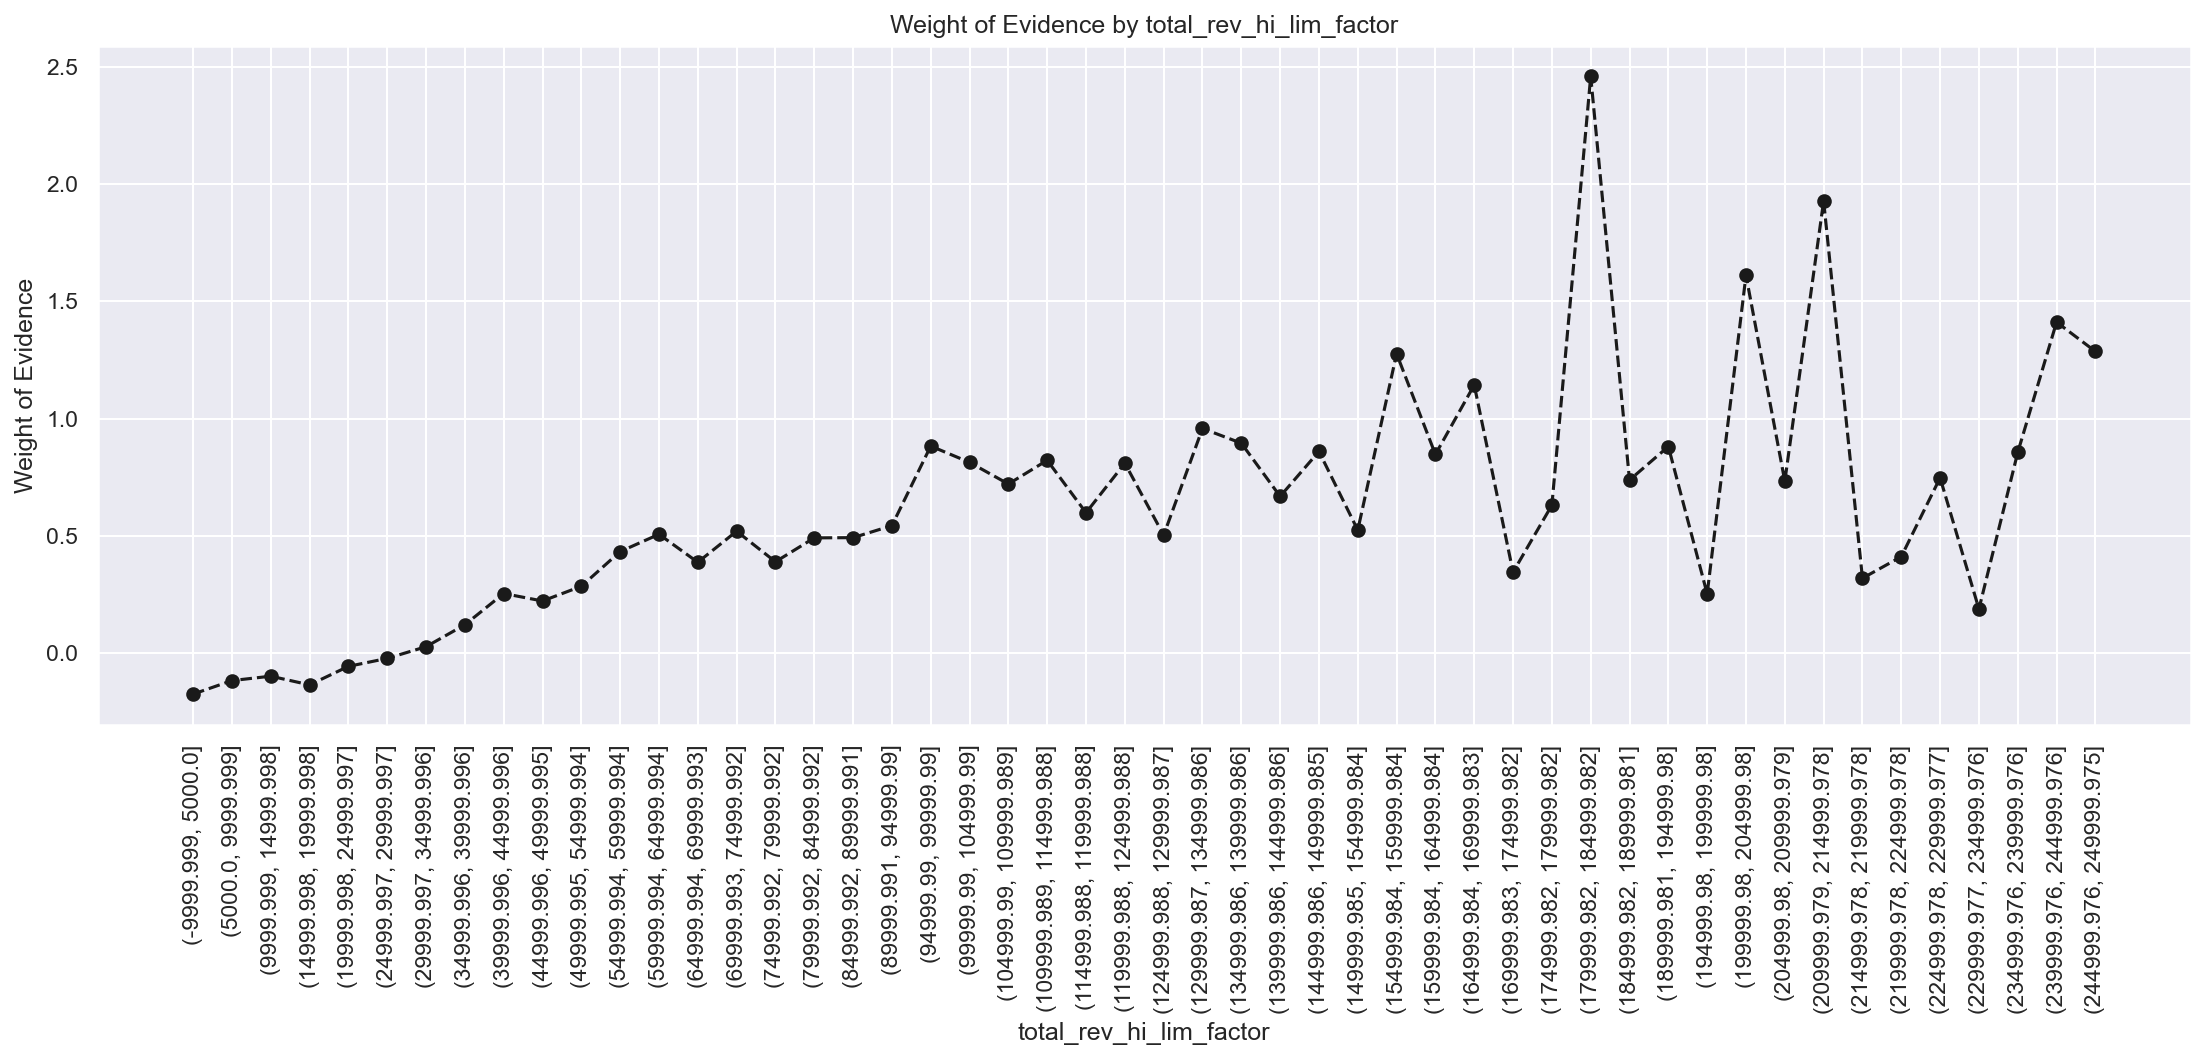

In [84]:
plot_by_woe(total_rev_hi_lim_factor_df.iloc[: 50], 90)

There will be 8 groupings:

- (1) 0 <= x <= 5k
- (2) 5k < x <= 10k
- (3) 10k < x <= 20k
- (4) 20k < x <= 30k
- (5) 30k < x <= 40k
- (6) 40k < x <= 55k
- (7) 55k < x <= 95k
- (8) x > 95k

*note that x = total_rev_hi_lim

In [85]:
X_train["total_rev_hi_lim:<=5K"] = np.where((X_train["total_rev_hi_lim"] <= 5000), 1, 0)
X_train["total_rev_hi_lim:5K-10K"] = np.where((X_train["total_rev_hi_lim"] > 5000) & (X_train["total_rev_hi_lim"] <= 10000), 1, 0)
X_train["total_rev_hi_lim:10K-20K"] = np.where((X_train["total_rev_hi_lim"] > 10000) & (X_train["total_rev_hi_lim"] <= 20000), 1, 0)
X_train["total_rev_hi_lim:20K-30K"] = np.where((X_train["total_rev_hi_lim"] > 20000) & (X_train["total_rev_hi_lim"] <= 30000), 1, 0)
X_train["total_rev_hi_lim:30K-40K"] = np.where((X_train["total_rev_hi_lim"] > 30000) & (X_train["total_rev_hi_lim"] <= 40000), 1, 0)
X_train["total_rev_hi_lim:40K-55K"] = np.where((X_train["total_rev_hi_lim"] > 40000) & (X_train["total_rev_hi_lim"] <= 55000), 1, 0)
X_train["total_rev_hi_lim:55K-95K"] = np.where((X_train["total_rev_hi_lim"] > 55000) & (X_train["total_rev_hi_lim"] <= 95000), 1, 0)
X_train["total_rev_hi_lim:>95K"] = np.where((X_train["total_rev_hi_lim"] > 95000), 1, 0)

##### Annual income variable

In [86]:
X_train["annual_inc_factor"] = pd.cut(X_train["annual_inc"], 100)
annual_inc_factor_df = woe_ordered_continuous(X_train, "annual_inc_factor", y_train)
annual_inc_factor_df

annual_inc_factor   n_obs  prop_good  props_n_obs    n_good  \
0      (-5243.882, 73294.82]  231445   0.877768     0.620449  203155.0   
1      (73294.82, 144693.64]  120459   0.913979     0.322922  110097.0   
2     (144693.64, 216092.46]   15885   0.926975     0.042584   14725.0   
3     (216092.46, 287491.28]    3119   0.930747     0.008361    2903.0   
4      (287491.28, 358890.1]    1117   0.934646     0.002994    1044.0   
5      (358890.1, 430288.92]     408   0.936275     0.001094     382.0   
6     (430288.92, 501687.74]     245   0.951020     0.000657     233.0   
7     (501687.74, 573086.56]      87   0.919540     0.000233      80.0   
8     (573086.56, 644485.38]      61   0.885246     0.000164      54.0   
9      (644485.38, 715884.2]      51   0.921569     0.000137      47.0   
10     (715884.2, 787283.02]      37   0.945946     0.000099      35.0   
11    (787283.02, 858681.84]      28   0.821429     0.000075      23.0   
12    (858681.84, 930080.66]      17   1.000000     0.000046      17.0   
13   (930080.66, 1001479.48]      22   0.954545     0.000059      21.0   
14   (1001479.48, 1072878.3]       3   1.000000     0.000008       3.0   
15   (1072878.3, 1144277.12]       7   1.000000     0.000019       7.0   
16  (1144277.12, 1215675.94]       8   1.000000     0.000021       8.0   
17  (1215675.94, 1287074.76]       4   1.000000     0.000011       4.0   
18  (1287074.76, 1358473.58]       4   1.000000     0.000011       4.0   
19   (1358473.58, 1429872.4]       2   1.000000     0.000005       2.0   
20   (1429872.4, 1501271.22]       2   1.000000     0.000005       2.0   
21  (1501271.22, 1572670.04]       1   1.000000     0.000003       1.0   
22  (1572670.04, 1644068.86]       1   1.000000     0.000003       1.0   
23  (1644068.86, 1715467.68]       0        NaN     0.000000       NaN   
24   (1715467.68, 1786866.5]       1   1.000000     0.000003       1.0   
25   (1786866.5, 1858265.32]       0        NaN     0.000000       NaN   
26  (1858265.32, 1929664.14]       1   1.000000     0.000003       1.0   
27  (1929664.14, 2001062.96]       5   1.000000     0.000013       5.0   
28  (2001062.96, 2072461.78]       1   1.000000     0.000003       1.0   
29   (2072461.78, 2143860.6]       0        NaN     0.000000       NaN   
30   (2143860.6, 2215259.42]       0        NaN     0.000000       NaN   
31  (2215259.42, 2286658.24]       0        NaN     0.000000       NaN   
32  (2286658.24, 2358057.06]       0        NaN     0.000000       NaN   
33  (2358057.06, 2429455.88]       0        NaN     0.000000       NaN   
34   (2429455.88, 2500854.7]       0        NaN     0.000000       NaN   
35   (2500854.7, 2572253.52]       0        NaN     0.000000       NaN   
36  (2572253.52, 2643652.34]       0        NaN     0.000000       NaN   
37  (2643652.34, 2715051.16]       0        NaN     0.000000       NaN   
38  (2715051.16, 2786449.98]       0        NaN     0.000000       NaN   
39   (2786449.98, 2857848.8]       0        NaN     0.000000       NaN   
40   (2857848.8, 2929247.62]       0        NaN     0.000000       NaN   
41  (2929247.62, 3000646.44]       0        NaN     0.000000       NaN   
42  (3000646.44, 3072045.26]       0        NaN     0.000000       NaN   
43  (3072045.26, 3143444.08]       0        NaN     0.000000       NaN   
44   (3143444.08, 3214842.9]       0        NaN     0.000000       NaN   
45   (3214842.9, 3286241.72]       0        NaN     0.000000       NaN   
46  (3286241.72, 3357640.54]       0        NaN     0.000000       NaN   
47  (3357640.54, 3429039.36]       0        NaN     0.000000       NaN   
48  (3429039.36, 3500438.18]       0        NaN     0.000000       NaN   
49   (3500438.18, 3571837.0]       0        NaN     0.000000       NaN   
50   (3571837.0, 3643235.82]       0        NaN     0.000000       NaN   
51  (3643235.82, 3714634.64]       0        NaN     0.000000       NaN   
52  (3714634.64, 3786033.46]       0        NaN     0.000000       NaN   
53  (3786033.46

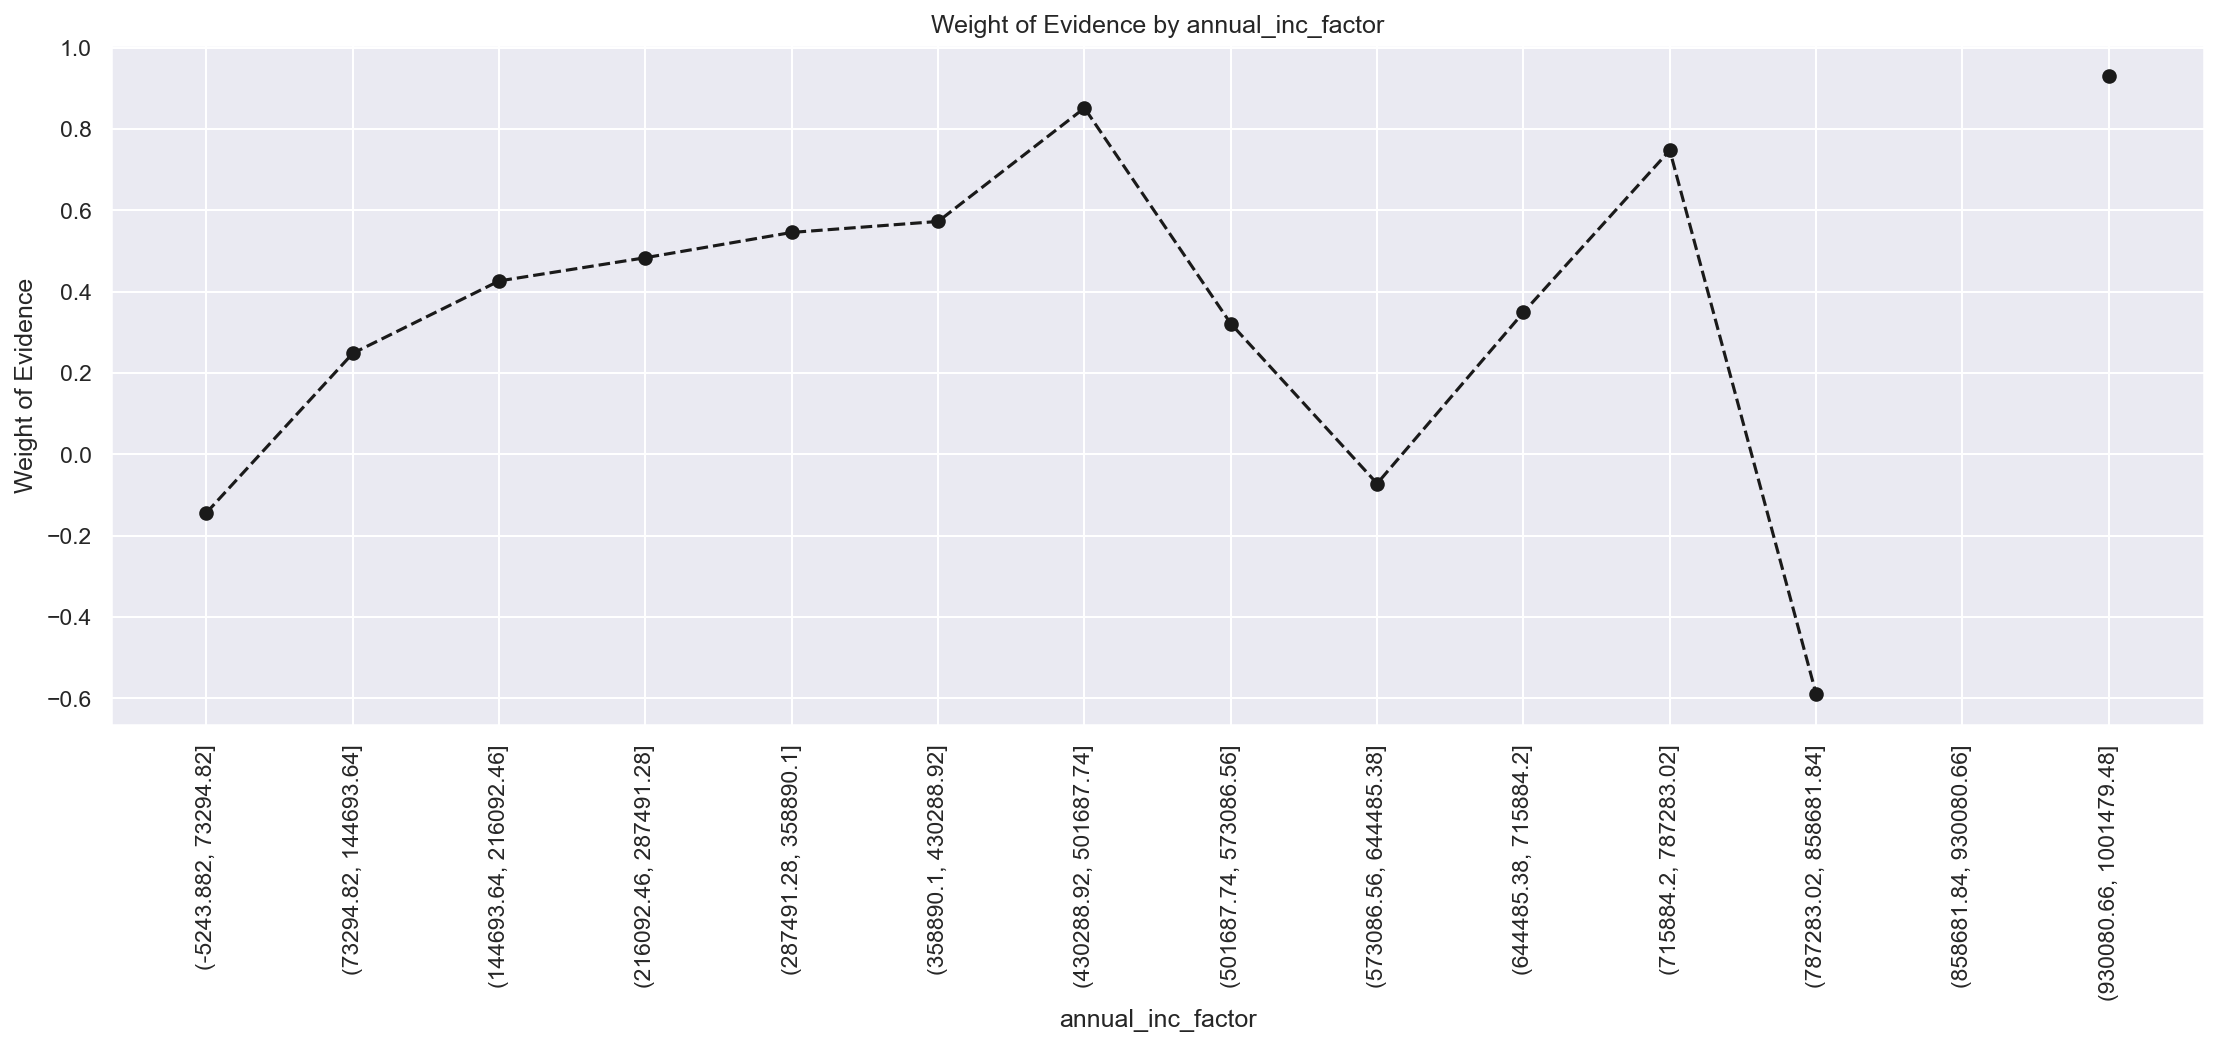

In [87]:
plot_by_woe(annual_inc_factor_df, 90)

Even splitting the variable into 100 categories is not sufficient to display the relationships within the lower bound, where the majority of the data lies. To combat this, we will create an upper bound at 140k, where all data above the 140k threshold will be categorized into that one category, as there are likely not as many observations in this range, as individuals who earn 140k or more are less common

The lower bound, x < 140k, will be where we find the majority of our data. We will investigate what relationship exists within this range to guide further steps in preprocessing this variable

In [88]:
annual_inc_less_than_140k = X_train.loc[X_train["annual_inc"] < 140000]["annual_inc"]

In [89]:
annual_inc_less_than_140k_factor = pd.cut(annual_inc_less_than_140k, 50)

annual_inc_less_than_140k_factor_df = woe_ordered_continuous(annual_inc_less_than_140k_factor.to_frame(), "annual_inc", 
                       y_train[annual_inc_less_than_140k_factor.index])

annual_inc_less_than_140k_factor_df

annual_inc  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0      (1757.904, 4657.92]     15   0.933333     0.000043     14.0     1.0   
1       (4657.92, 7419.84]     40   0.875000     0.000115     35.0     5.0   
2      (7419.84, 10181.76]    287   0.874564     0.000822    251.0    36.0   
3     (10181.76, 12943.68]    547   0.839122     0.001567    459.0    88.0   
4      (12943.68, 15705.6]   1210   0.837190     0.003467   1013.0   197.0   
5      (15705.6, 18467.52]   1518   0.855072     0.004349   1298.0   220.0   
6     (18467.52, 21229.44]   2932   0.859141     0.008401   2519.0   413.0   
7     (21229.44, 23991.36]   2495   0.848898     0.007149   2118.0   377.0   
8     (23991.36, 26753.28]   7016   0.852338     0.020103   5980.0  1036.0   
9      (26753.28, 29515.2]   5643   0.860890     0.016169   4858.0   785.0   
10     (29515.2, 32277.12]  11914   0.861675     0.034137  10266.0  1648.0   
11    (32277.12, 35039.04]  12240   0.862500     0.035071  10557.0  1683.0   
12    (35039.04, 37800.96]   7907   0.861389     0.022656   6811.0  1096.0   
13    (37800.96, 40562.88]  17909   0.867943     0.051314  15544.0  2365.0   
14     (40562.88, 43324.8]  12506   0.871582     0.035833  10900.0  1606.0   
15     (43324.8, 46086.72]  16593   0.874525     0.047543  14511.0  2082.0   
16    (46086.72, 48848.64]   9878   0.879733     0.028303   8690.0  1188.0   
17    (48848.64, 51610.56]  19022   0.880822     0.054503  16755.0  2267.0   
18    (51610.56, 54372.48]  12767   0.887679     0.036581  11333.0  1434.0   
19     (54372.48, 57134.4]  16154   0.888634     0.046285  14355.0  1799.0   
20     (57134.4, 59896.32]   6482   0.885375     0.018573   5739.0   743.0   
21    (59896.32, 62658.24]  21299   0.882764     0.061027  18802.0  2497.0   
22    (62658.24, 65420.16]  16088   0.890912     0.046096  14333.0  1755.0   
23    (65420.16, 68182.08]   7944   0.899295     0.022762   7144.0   800.0   
24     (68182.08, 70944.0]  12982   0.895317     0.037197  11623.0  1359.0   
25     (70944.0, 73705.92]   8384   0.899332     0.024022   7540.0   844.0   
26    (73705.92, 76467.84]  13146   0.903088     0.037667  11872.0  1274.0   
27    (76467.84, 79229.76]   5676   0.904510     0.016263   5134.0   542.0   
28    (79229.76, 81991.68]  11383   0.902398     0.032615  10272.0  1111.0   
29     (81991.68, 84753.6]   6078   0.913623     0.017415   5553.0   525.0   
30     (84753.6, 87515.52]   9982   0.910339     0.028601   9087.0   895.0   
31    (87515.52, 90277.44]  10392   0.909931     0.029776   9456.0   936.0   
32    (90277.44, 93039.36]   4337   0.915610     0.012427   3971.0   366.0   
33    (93039.36, 95801.28]   5634   0.915868     0.016143   5160.0   474.0   
34     (95801.28, 98563.2]   4668   0.912382     0.013375   4259.0   409.0   
35    (98563.2, 101325.12]   8792   0.915946     0.025191   8053.0   739.0   
36  (101325.12, 104087.04]   3233   0.920507     0.009263   2976.0   257.0   
37  (104087.04, 106848.96]   3736   0.924786     0.010705   3455.0   281.0   
38  (106848.96, 109610.88]   2277   0.923584     0.006524   2103.0   174.0   
39   (109610.88, 112372.8]   5714   0.916171     0.016372   5235.0   479.0   
40   (112372.8, 115134.72]   3218   0.938782     0.009220   3021.0   197.0   
41  (115134.72, 117896.64]   1127   0.919255     0.003229   1036.0    91.0   
42  (117896.64, 120658.56]   6229   0.914754     0.017848   5698.0   531.0   
43  (120658.56, 123420.48]   1043   0.937680     0.002988    978.0    65.0   
44   (123420.48, 126182.4]   3565   0.922581     0.010215   3289.0   276.0   
45   (126182.4, 128944.32]    791   0.919090     0.002266    727.0    64.0   
46  (128944.32, 131706.24]   3034   0.931444     0.008693   2826.0   208.0   
47  (131706.24, 134468.16]    801   0.923845     0.002295    740.0    61.0   
48  (134468.16, 137230.08]   1902   0.943743     0.005450   1795.0   107.0   
49   (137230.08, 139992.0]    478   0.937238     0.001370    448.0    30.0   

    prob_n_good  prob_n_bad       WoE

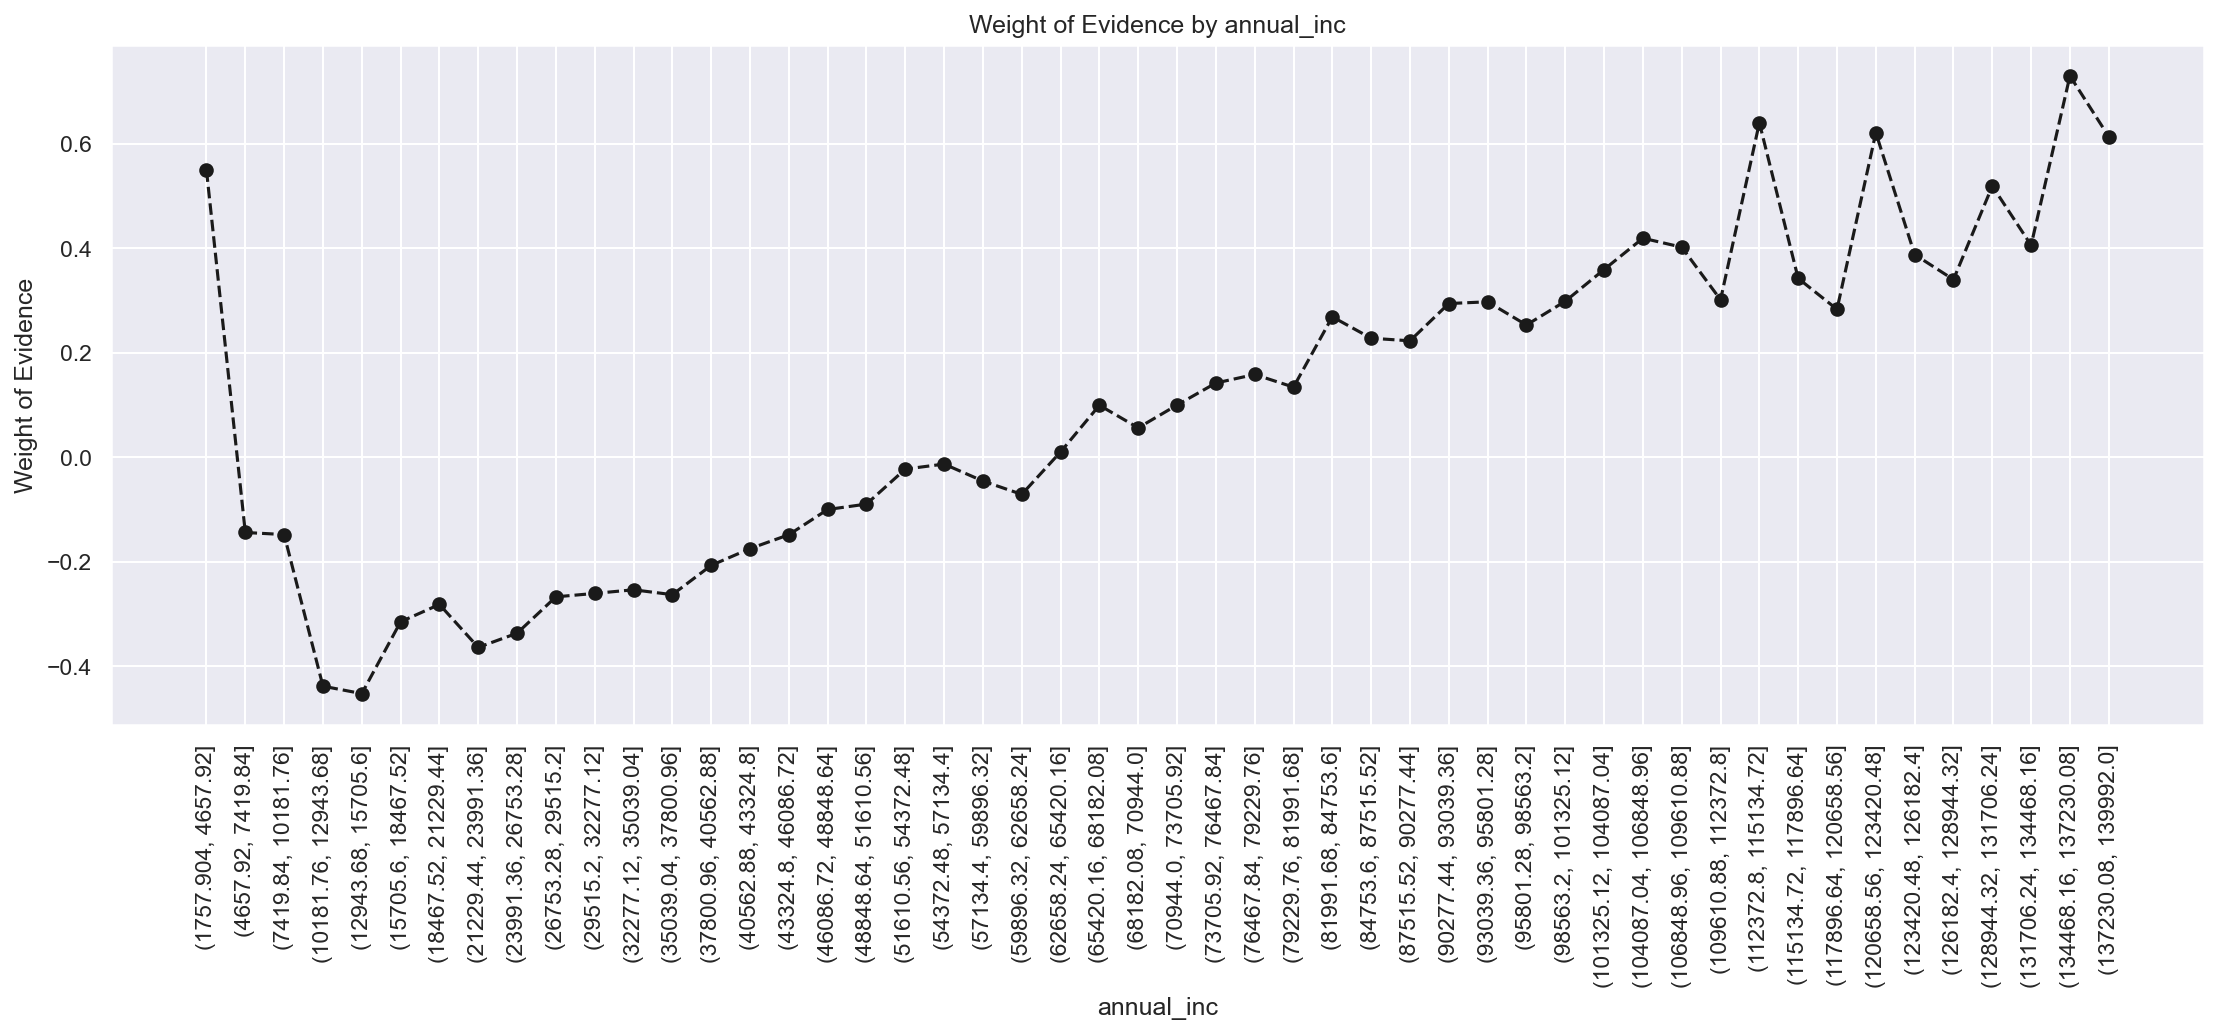

In [90]:
plot_by_woe(annual_inc_less_than_140k_factor_df, 90)

The plot above shows a positive linear relationship between annual income and the probability of default. That is, those earning higher incomes are less likely to default on their loans than those who have lower incomes. Because this relationship is linear, we can create reasonably spaced out categories to group each income

There will be 12 groupings:

- (1) x < 20k
- (2) - (9) 8 10k intervals from 20k - 100k
- (10) - (11) 2 20k intervals from 100l - 140k
- (12) x > 140k

The first interval will be a 20k interval, x < 20k, as the number of observations below 20k is small. From 20k to 100k, the intervals will be every 10k, as there are sufficient number of observations for this range. After 100k, the number of observations drop once again, so instead of continuing with the 10k intervals, we have opted to creating 2 20k intervals. Lastly, an interval for all values above 140k is created. Due to the limited number of observations within this range, these data points will be grouped as a single category

*note that x = annual_inc

In [91]:
X_train["annual_inc:<20K"] = np.where((X_train["annual_inc"] <= 20000), 1, 0)
X_train["annual_inc:20K-30K"] = np.where((X_train["annual_inc"] > 20000) & (X_train["annual_inc"] <= 30000), 1, 0)
X_train["annual_inc:30K-40K"] = np.where((X_train["annual_inc"] > 30000) & (X_train["annual_inc"] <= 40000), 1, 0)
X_train["annual_inc:40K-50K"] = np.where((X_train["annual_inc"] > 40000) & (X_train["annual_inc"] <= 50000), 1, 0)
X_train["annual_inc:50K-60K"] = np.where((X_train["annual_inc"] > 50000) & (X_train["annual_inc"] <= 60000), 1, 0)
X_train["annual_inc:60K-70K"] = np.where((X_train["annual_inc"] > 60000) & (X_train["annual_inc"] <= 70000), 1, 0)
X_train["annual_inc:70K-80K"] = np.where((X_train["annual_inc"] > 70000) & (X_train["annual_inc"] <= 80000), 1, 0)
X_train["annual_inc:80K-90K"] = np.where((X_train["annual_inc"] > 80000) & (X_train["annual_inc"] <= 90000), 1, 0)
X_train["annual_inc:90K-100K"] = np.where((X_train["annual_inc"] > 90000) & (X_train["annual_inc"] <= 100000), 1, 0)
X_train["annual_inc:100K-120K"] = np.where((X_train["annual_inc"] > 100000) & (X_train["annual_inc"] <= 120000), 1, 0)
X_train["annual_inc:120K-140K"] = np.where((X_train["annual_inc"] > 120000) & (X_train["annual_inc"] <= 140000), 1, 0)
X_train["annual_inc:>140K"] = np.where((X_train["annual_inc"] > 140000), 1, 0)

##### Months since last delinquency

Due to the high number of missing values, we will create a dummy variable indicating that the value of the original mths_since_last_delinq variable is missing - 

- 1: when the value is missing
- 0: when the value is not missing

In [92]:
mths_since_last_delinq_not_null = X_train[pd.notnull(X_train["mths_since_last_delinq"])]["mths_since_last_delinq"]
mths_since_last_delinq_not_null_factor = pd.cut(mths_since_last_delinq_not_null, 50)

mths_since_last_delinq_not_null_factor_df = woe_ordered_continuous(mths_since_last_delinq_not_null_factor.to_frame(),
                                                                   "mths_since_last_delinq", 
                                                                   y_train[mths_since_last_delinq_not_null_factor.index])

mths_since_last_delinq_not_null_factor_df

mths_since_last_delinq  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0          (-0.188, 3.76]   5277   0.894448     0.030531   4720.0   557.0   
1            (3.76, 7.52]  11167   0.888421     0.064608   9921.0  1246.0   
2           (7.52, 11.28]  13306   0.894409     0.076983  11901.0  1405.0   
3          (11.28, 15.04]  13216   0.890209     0.076462  11765.0  1451.0   
4           (15.04, 18.8]   9337   0.896434     0.054020   8370.0   967.0   
5           (18.8, 22.56]  11641   0.894425     0.067350  10412.0  1229.0   
6          (22.56, 26.32]  10887   0.897584     0.062988   9772.0  1115.0   
7          (26.32, 30.08]  10560   0.896686     0.061096   9469.0  1091.0   
8          (30.08, 33.84]   7576   0.904171     0.043832   6850.0   726.0   
9           (33.84, 37.6]   9795   0.899541     0.056670   8811.0   984.0   
10          (37.6, 41.36]   9352   0.892964     0.054107   8351.0  1001.0   
11         (41.36, 45.12]   9202   0.898066     0.053239   8264.0   938.0   
12         (45.12, 48.88]   6538   0.899511     0.037826   5881.0   657.0   
13         (48.88, 52.64]   6486   0.890379     0.037525   5775.0   711.0   
14          (52.64, 56.4]   6045   0.893631     0.034974   5402.0   643.0   
15          (56.4, 60.16]   5867   0.904380     0.033944   5306.0   561.0   
16         (60.16, 63.92]   4040   0.891337     0.023374   3601.0   439.0   
17         (63.92, 67.68]   5314   0.894618     0.030745   4754.0   560.0   
18         (67.68, 71.44]   5141   0.891461     0.029744   4583.0   558.0   
19          (71.44, 75.2]   4950   0.887475     0.028639   4393.0   557.0   
20          (75.2, 78.96]   3312   0.894022     0.019162   2961.0   351.0   
21         (78.96, 82.72]   3577   0.885938     0.020695   3169.0   408.0   
22         (82.72, 86.48]     94   0.787234     0.000544     74.0    20.0   
23         (86.48, 90.24]     38   0.894737     0.000220     34.0     4.0   
24          (90.24, 94.0]     32   0.937500     0.000185     30.0     2.0   
25          (94.0, 97.76]     20   0.750000     0.000116     15.0     5.0   
26        (97.76, 101.52]     13   0.923077     0.000075     12.0     1.0   
27       (101.52, 105.28]     11   0.909091     0.000064     10.0     1.0   
28       (105.28, 109.04]      8   0.750000     0.000046      6.0     2.0   
29        (109.04, 112.8]      2   0.500000     0.000012      1.0     1.0   
30        (112.8, 116.56]      7   0.857143     0.000040      6.0     1.0   
31       (116.56, 120.32]      2   1.000000     0.000012      2.0     0.0   
32       (120.32, 124.08]      1   1.000000     0.000006      1.0     0.0   
33       (124.08, 127.84]      2   1.000000     0.000012      2.0     0.0   
34        (127.84, 131.6]      5   1.000000     0.000029      5.0     0.0   
35        (131.6, 135.36]      7   0.714286     0.000040      5.0     2.0   
36       (135.36, 139.12]      2   1.000000     0.000012      2.0     0.0   
37       (139.12, 142.88]      3   1.000000     0.000017      3.0     0.0   
38       (142.88, 146.64]      1   1.000000     0.000006      1.0     0.0   
39        (146.64, 150.4]      3   0.666667     0.000017      2.0     1.0   
40        (150.4, 154.16]      2   0.500000     0.000012      1.0     1.0   
41       (154.16, 157.92]      1   1.000000     0.000006      1.0     0.0   
42       (157.92, 161.68]      1   1.000000     0.000006      1.0     0.0   
43       (161.68, 165.44]      0        NaN     0.000000      NaN     NaN   
44        (165.44, 169.2]      0        NaN     0.000000      NaN     NaN   
45        (169.2, 172.96]      0        NaN     0.000000      NaN     NaN   
46       (172.96, 176.72]      0        NaN     0.000000      NaN     NaN   
47       (176.72, 180.48]      1   1.000000     0.000006      1.0     0.0   
48       (180.48, 184.24]      0        NaN     0.000000      NaN     NaN   
49        (184.24, 188.0]      1   1.000000     0.000006      1.0     0.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE           i

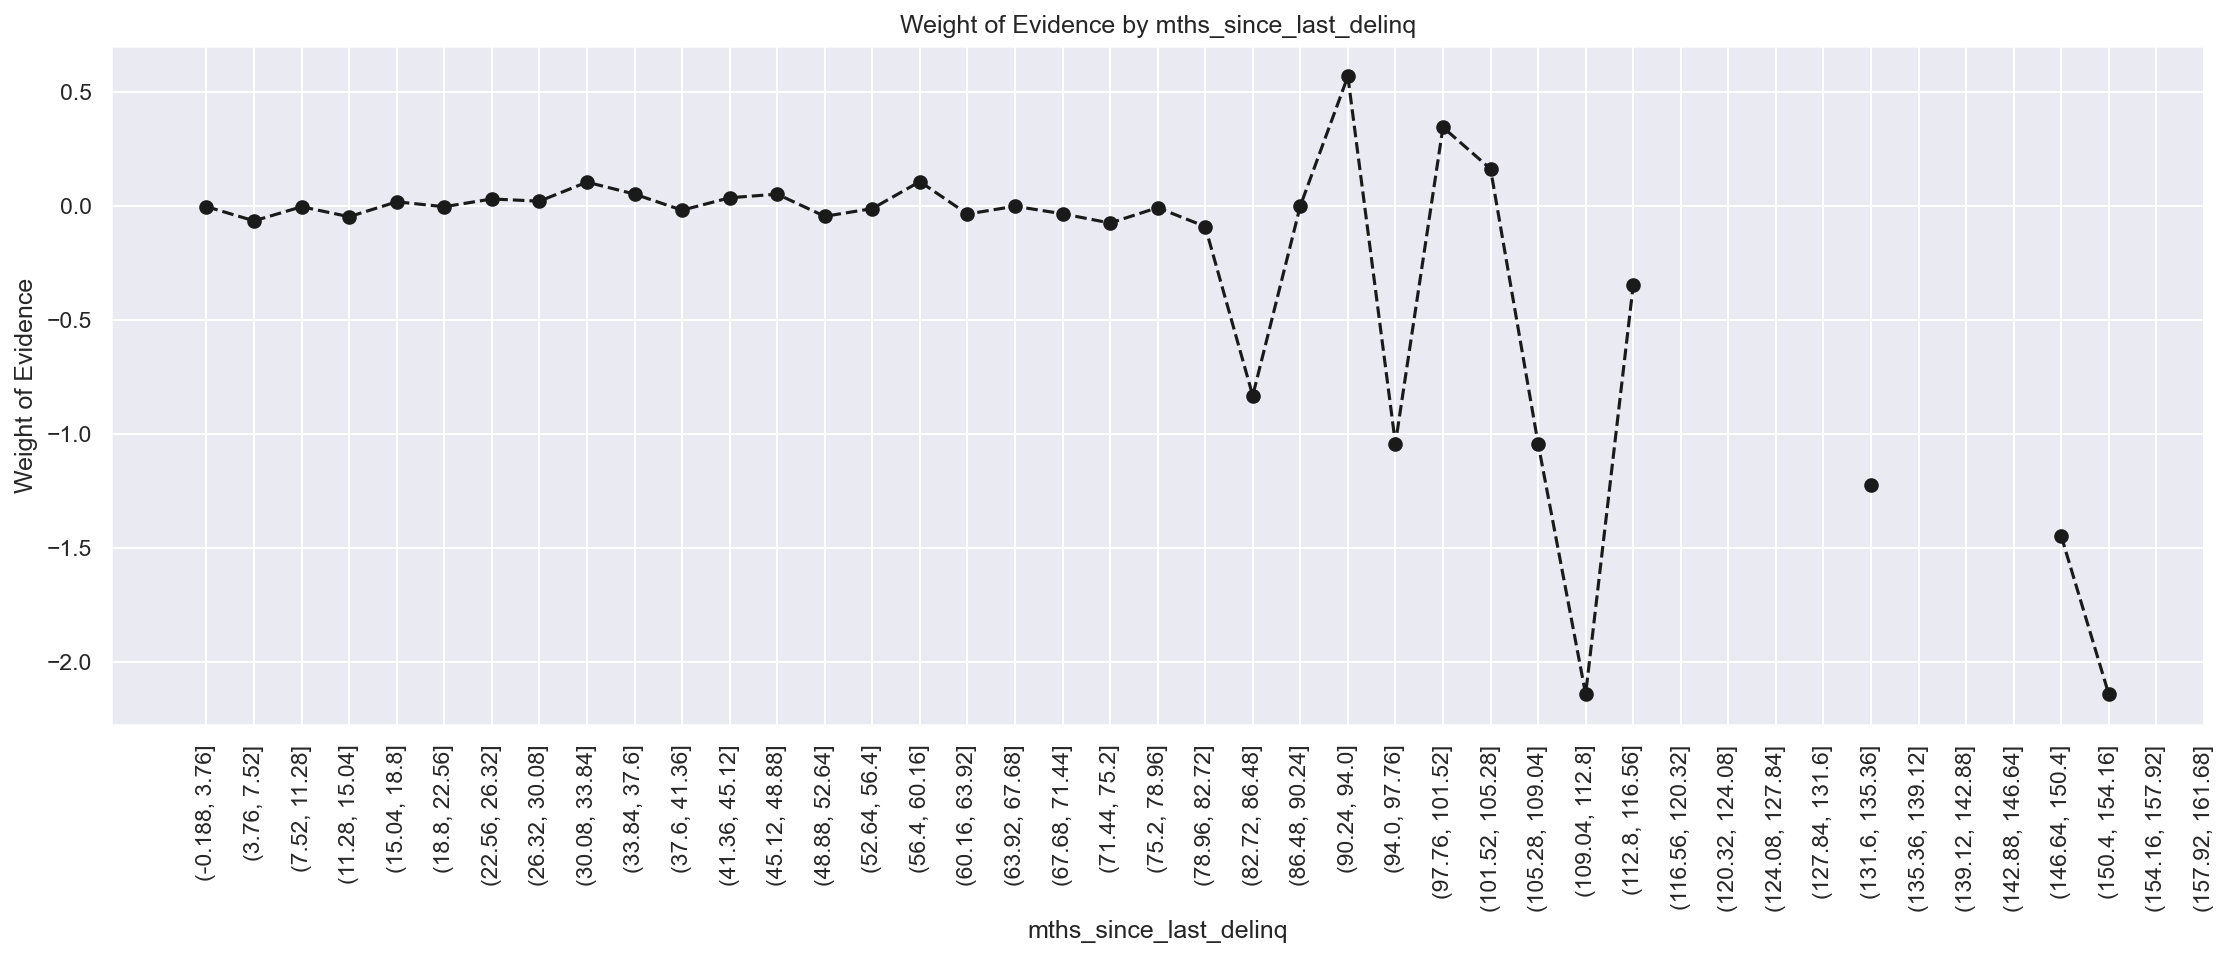

In [93]:
plot_by_woe(mths_since_last_delinq_not_null_factor_df, 90)

There will be 5 groupings:

- (1) all missing values
- (2) 0 < x <= 3
- (3) 3 < x <= 30
- (4) 31 < x <= 56
- (5) x > 56

There aren't significant number of observations after 83 months. Therefore, instead of making 2 groups, 1 for 57 - 83 months and another for months > 83, we will opt for a single group from 57 months onwards

*note that x = mths_since_last_delinq

In [94]:
X_train["mths_since_last_delinq:Missing"] = np.where((X_train["mths_since_last_delinq"].isnull()), 1, 0)
X_train["mths_since_last_delinq:0-3"] = np.where((X_train["mths_since_last_delinq"] >= 0) & (X_train["mths_since_last_delinq"] <= 3), 1, 0)
X_train["mths_since_last_delinq:4-30"] = np.where((X_train["mths_since_last_delinq"] >= 4) & (X_train["mths_since_last_delinq"] <= 30), 1, 0)
X_train["mths_since_last_delinq:31-56"] = np.where((X_train["mths_since_last_delinq"] >= 31) & (X_train["mths_since_last_delinq"] <= 56), 1, 0)
X_train["mths_since_last_delinq:>=57"] = np.where((X_train["mths_since_last_delinq"] >= 57), 1, 0)

##### Debt to income ratio variable

In [95]:
X_train["dti_factor"] = pd.cut(X_train["dti"], 50)

dti_factor_df = woe_ordered_continuous(X_train, "dti_factor", y_train)
dti_factor_df

dti_factor  n_obs  prop_good  props_n_obs   n_good   n_bad  \
0       (-0.04, 0.8]   1553   0.907276     0.004163   1409.0   144.0   
1         (0.8, 1.6]   1965   0.902799     0.005268   1774.0   191.0   
2       (1.6, 2.399]   2509   0.914707     0.006726   2295.0   214.0   
3     (2.399, 3.199]   3234   0.914348     0.008670   2957.0   277.0   
4     (3.199, 3.999]   4124   0.911494     0.011055   3759.0   365.0   
5     (3.999, 4.799]   5037   0.918999     0.013503   4629.0   408.0   
6     (4.799, 5.599]   5989   0.913842     0.016055   5473.0   516.0   
7     (5.599, 6.398]   6781   0.916679     0.018178   6216.0   565.0   
8     (6.398, 7.198]   7665   0.915590     0.020548   7018.0   647.0   
9     (7.198, 7.998]   8747   0.916886     0.023449   8020.0   727.0   
10    (7.998, 8.798]   9572   0.913289     0.025660   8742.0   830.0   
11    (8.798, 9.598]  10320   0.909205     0.027665   9383.0   937.0   
12   (9.598, 10.397]  11092   0.910386     0.029735  10098.0   994.0   
13  (10.397, 11.197]  11940   0.904690     0.032008  10802.0  1138.0   
14  (11.197, 11.997]  12471   0.908989     0.033432  11336.0  1135.0   
15  (11.997, 12.797]  13246   0.903443     0.035509  11967.0  1279.0   
16  (12.797, 13.597]  13436   0.903840     0.036019  12144.0  1292.0   
17  (13.597, 14.396]  13709   0.900284     0.036751  12342.0  1367.0   
18  (14.396, 15.196]  14045   0.903596     0.037651  12691.0  1354.0   
19  (15.196, 15.996]  13870   0.898991     0.037182  12469.0  1401.0   
20  (15.996, 16.796]  13735   0.896323     0.036820  12311.0  1424.0   
21  (16.796, 17.596]  13710   0.889278     0.036753  12192.0  1518.0   
22  (17.596, 18.395]  13606   0.887182     0.036474  12071.0  1535.0   
23  (18.395, 19.195]  13209   0.887198     0.035410  11719.0  1490.0   
24  (19.195, 19.995]  13183   0.885686     0.035341  11676.0  1507.0   
25  (19.995, 20.795]  12435   0.883072     0.033335  10981.0  1454.0   
26  (20.795, 21.595]  11902   0.879180     0.031906  10464.0  1438.0   
27  (21.595, 22.394]  11303   0.877997     0.030301   9924.0  1379.0   
28  (22.394, 23.194]  11013   0.876146     0.029523   9649.0  1364.0   
29  (23.194, 23.994]  10229   0.877407     0.027422   8975.0  1254.0   
30  (23.994, 24.794]   9922   0.870591     0.026599   8638.0  1284.0   
31  (24.794, 25.594]   8566   0.877422     0.022963   7516.0  1050.0   
32  (25.594, 26.393]   7777   0.877202     0.020848   6822.0   955.0   
33  (26.393, 27.193]   7251   0.869535     0.019438   6305.0   946.0   
34  (27.193, 27.993]   6627   0.866455     0.017765   5742.0   885.0   
35  (27.993, 28.793]   6361   0.868731     0.017052   5526.0   835.0   
36  (28.793, 29.593]   5785   0.869836     0.015508   5032.0   753.0   
37  (29.593, 30.392]   4705   0.865675     0.012613   4073.0   632.0   
38  (30.392, 31.192]   3852   0.863448     0.010326   3326.0   526.0   
39  (31.192, 31.992]   3510   0.870370     0.009409   3055.0   455.0   
40  (31.992, 32.792]   3041   0.860572     0.008152   2617.0   424.0   
41  (32.792, 33.592]   2811   0.869441     0.007536   2444.0   367.0   
42  (33.592, 34.391]   2592   0.868056     0.006949   2250.0   342.0   
43  (34.391, 35.191]   1842   0.859935     0.004938   1584.0   258.0   
44  (35.191, 35.991]    530   0.900000     0.001421    477.0    53.0   
45  (35.991, 36.791]    539   0.881262     0.001445    475.0    64.0   
46  (36.791, 37.591]    491   0.877800     0.001316    431.0    60.0   
47   (37.591, 38.39]    442   0.889140     0.001185    393.0    49.0   
48    (38.39, 39.19]    385   0.875325     0.001032    337.0    48.0   
49    (39.19, 39.99]    369   0.905149     0.000989    334.0    35.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.004233    0.003585  0.166087             NaN       NaN  0.000108   
1      0.005330    0.004755  0.113984        0.004477  0.052103  0.000065   
2      0.006895    0.005328  0.257777        0.011908  0.143793  0.000404   
3      0.008884    0.006897  

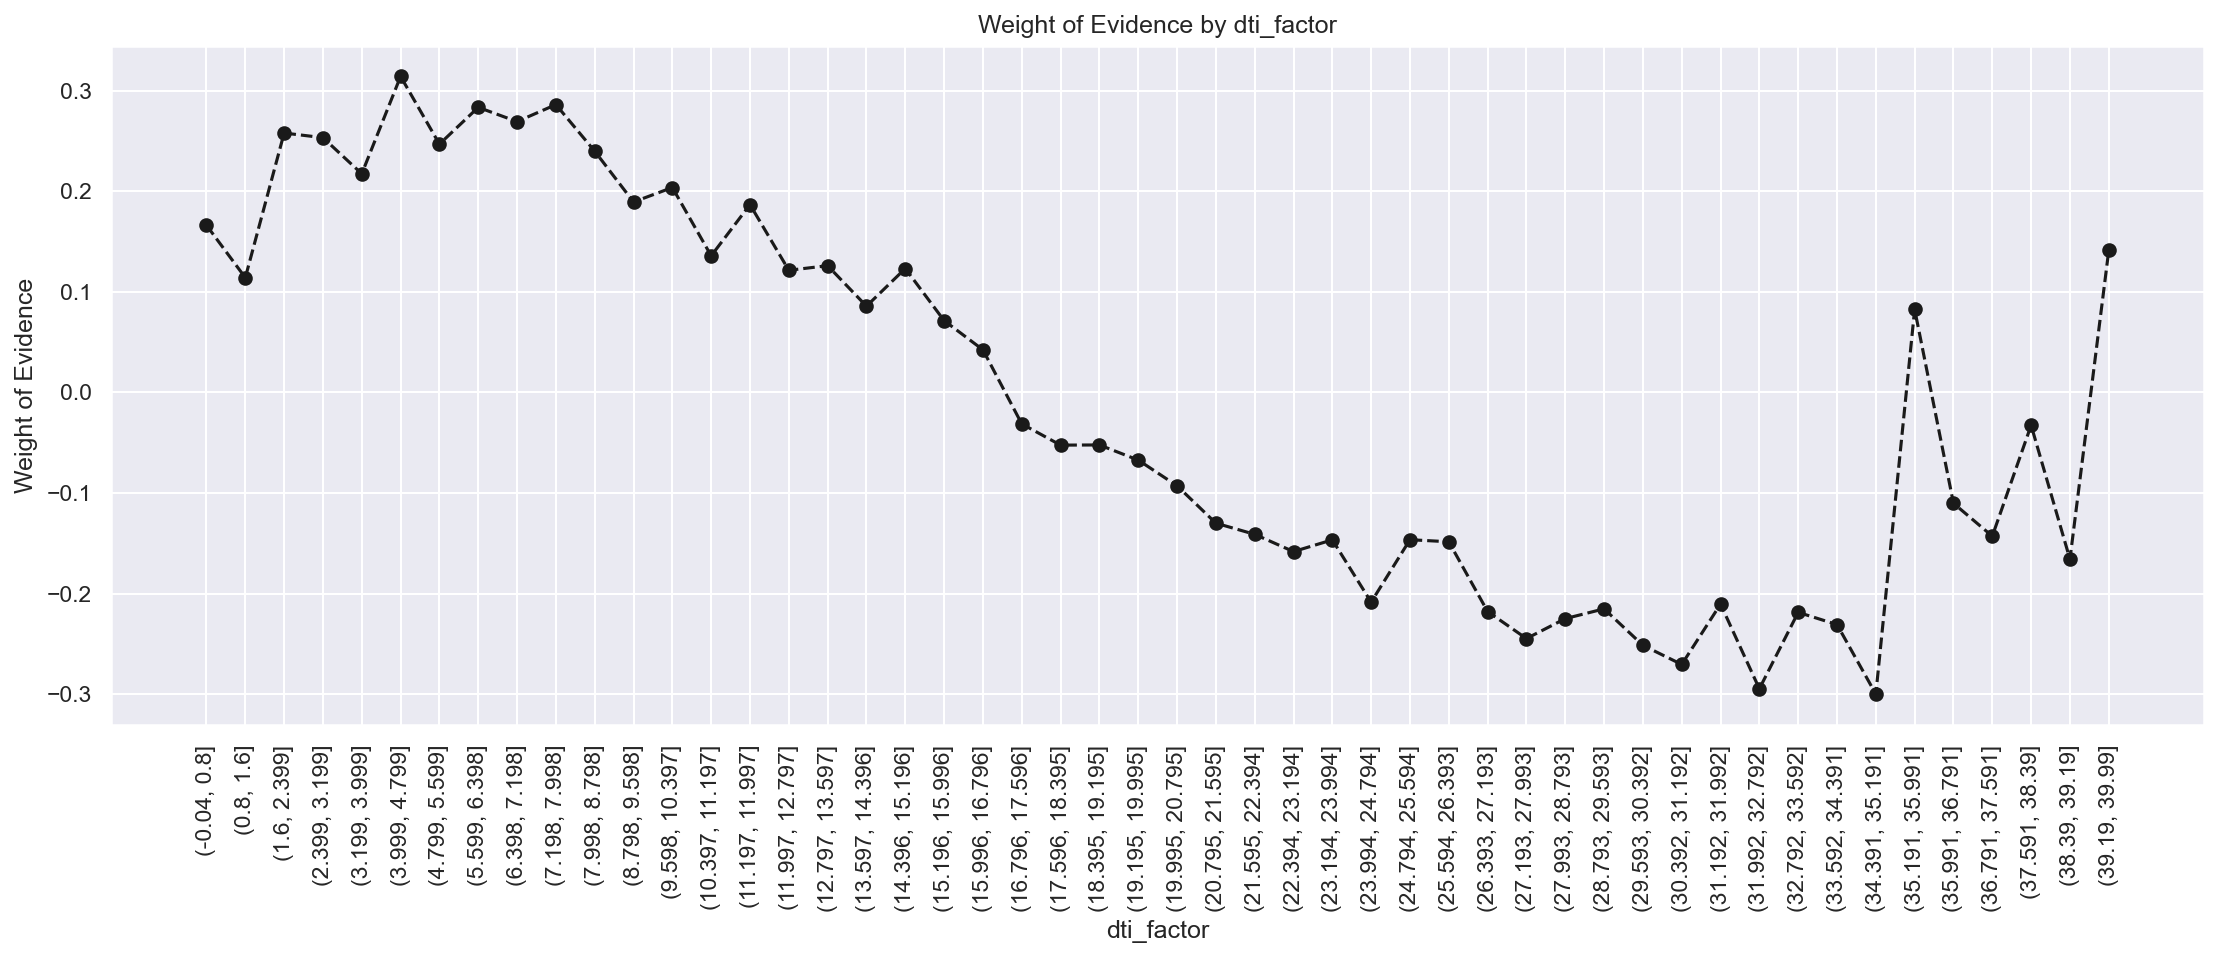

In [96]:
plot_by_woe(dti_factor_df, 90)

There will be 10 groupings:

- (1) x <= 1.6
- (2) 1.6 < x <= 3.9
- (3) 3.9 < x <= 7.9
- (4) 7.9 < x <= 10.4
- (5) 10.4 < x <= 16.8
- (6) 16.8 < x <= 21.6
- (7) 21.6 < x <= 23.2
- (8) 23.2 < x <= 24
- (9) 24 < x <= 40
- (10) x > 40

*note that x = dti

In [97]:
X_train["dti:<=1.6"] = np.where((X_train["dti"] <= 1.6), 1, 0)
X_train["dti:1.6-3.9"] = np.where((X_train["dti"] > 1.6) & (X_train["dti"] <= 3.9), 1, 0)
X_train["dti:3.9-7.9"] = np.where((X_train["dti"] > 3.9) & (X_train["dti"] <= 7.9), 1, 0)
X_train["dti:7.9-10.4"] = np.where((X_train["dti"] > 7.9) & (X_train["dti"] <= 10.4), 1, 0)
X_train["dti:10.4-16.8"] = np.where((X_train["dti"] > 10.4) & (X_train["dti"] <= 16.8), 1, 0)
X_train["dti:16.8-21.6"] = np.where((X_train["dti"] > 16.8) & (X_train["dti"] <= 21.6), 1, 0)
X_train["dti:21.6-23.2"] = np.where((X_train["dti"] > 21.6) & (X_train["dti"] <= 23.2), 1, 0)
X_train["dti:23.2-24"] = np.where((X_train["dti"] > 23.2) & (X_train["dti"] <= 24), 1, 0)
X_train["dti:24-40"] = np.where((X_train["dti"] > 24) & (X_train["dti"] <= 40), 1, 0)
X_train["dti:>40"] = np.where((X_train["dti"] > 40), 1, 0)

##### Months since last record variable

Due to the high number of missing values, we will create a dummy variable indicating that the value of the original mths_since_last_record variable is missing - 

- 1: when the value is missing
- 0: when the value is not missing

In [98]:
mths_since_last_record_not_null = X_train[pd.notnull(X_train["mths_since_last_record"])]["mths_since_last_record"]
mths_since_last_record_not_null_factor = pd.cut(mths_since_last_record_not_null, 50)

mths_since_last_record_not_null_factor_df = woe_ordered_continuous(mths_since_last_record_not_null_factor.to_frame(),
                                                                   "mths_since_last_record", 
                                                                   y_train[mths_since_last_record_not_null_factor.index])

mths_since_last_record_not_null_factor_df

mths_since_last_record  n_obs  prop_good  props_n_obs  n_good  n_bad  \
0          (-0.121, 2.42]   1086   0.918969     0.021691   998.0   88.0   
1            (2.42, 4.84]     76   0.894737     0.001518    68.0    8.0   
2            (4.84, 7.26]    163   0.914110     0.003256   149.0   14.0   
3            (7.26, 9.68]    156   0.903846     0.003116   141.0   15.0   
4            (9.68, 12.1]    292   0.907534     0.005832   265.0   27.0   
5           (12.1, 14.52]    207   0.917874     0.004134   190.0   17.0   
6          (14.52, 16.94]    210   0.928571     0.004194   195.0   15.0   
7          (16.94, 19.36]    334   0.907186     0.006671   303.0   31.0   
8          (19.36, 21.78]    283   0.939929     0.005652   266.0   17.0   
9           (21.78, 24.2]    455   0.898901     0.009088   409.0   46.0   
10          (24.2, 26.62]    339   0.905605     0.006771   307.0   32.0   
11         (26.62, 29.04]    612   0.900327     0.012224   551.0   61.0   
12         (29.04, 31.46]    451   0.909091     0.009008   410.0   41.0   
13         (31.46, 33.88]    487   0.921971     0.009727   449.0   38.0   
14          (33.88, 36.3]    780   0.920513     0.015579   718.0   62.0   
15          (36.3, 38.72]    659   0.939302     0.013162   619.0   40.0   
16         (38.72, 41.14]   1008   0.922619     0.020133   930.0   78.0   
17         (41.14, 43.56]    812   0.931034     0.016218   756.0   56.0   
18         (43.56, 45.98]    791   0.926675     0.015799   733.0   58.0   
19          (45.98, 48.4]   1316   0.926292     0.026285  1219.0   97.0   
20          (48.4, 50.82]    945   0.921693     0.018875   871.0   74.0   
21         (50.82, 53.24]   1536   0.908854     0.030679  1396.0  140.0   
22         (53.24, 55.66]   1062   0.916196     0.021212   973.0   89.0   
23         (55.66, 58.08]   1662   0.916366     0.033196  1523.0  139.0   
24          (58.08, 60.5]   1095   0.914155     0.021871  1001.0   94.0   
25          (60.5, 62.92]   1213   0.910140     0.024228  1104.0  109.0   
26         (62.92, 65.34]   1631   0.908645     0.032576  1482.0  149.0   
27         (65.34, 67.76]   1088   0.921875     0.021731  1003.0   85.0   
28         (67.76, 70.18]   1513   0.910112     0.030220  1377.0  136.0   
29          (70.18, 72.6]   1041   0.908742     0.020792   946.0   95.0   
30          (72.6, 75.02]   1420   0.900000     0.028362  1278.0  142.0   
31         (75.02, 77.44]    946   0.895349     0.018895   847.0   99.0   
32         (77.44, 79.86]    939   0.904153     0.018755   849.0   90.0   
33         (79.86, 82.28]   1351   0.889711     0.026984  1202.0  149.0   
34          (82.28, 84.7]    724   0.885359     0.014461   641.0   83.0   
35          (84.7, 87.12]   1350   0.865185     0.026964  1168.0  182.0   
36         (87.12, 89.54]    822   0.872263     0.016418   717.0  105.0   
37         (89.54, 91.96]    904   0.865044     0.018056   782.0  122.0   
38         (91.96, 94.38]   1492   0.868633     0.029800  1296.0  196.0   
39          (94.38, 96.8]   1145   0.855895     0.022869   980.0  165.0   
40          (96.8, 99.22]   1821   0.884679     0.036371  1611.0  210.0   
41        (99.22, 101.64]   1258   0.868839     0.025126  1093.0  165.0   
42       (101.64, 104.06]   2096   0.879771     0.041864  1844.0  252.0   
43       (104.06, 106.48]   1536   0.875651     0.030679  1345.0  191.0   
44        (106.48, 108.9]   1559   0.885824     0.031138  1381.0  178.0   
45        (108.9, 111.32]   2296   0.885017     0.045859  2032.0  264.0   
46       (111.32, 113.74]   1461   0.891170     0.029181  1302.0  159.0   
47       (113.74, 116.16]   2037   0.870889     0.040685  1774.0  263.0   
48       (116.16, 118.58]   1236   0.906958     0.024687  1121.0  115.0   
49        (118.58, 121.0]    371   0.878706     0.007410   326.0   45.0   

    prob_n_good  prob_n_bad       WoE  diff_prop_good  diff_WoE       i_v  \
0      0.022207    0.017167  0.257392             NaN       NaN  0.001297   
1      0.001513    0.00

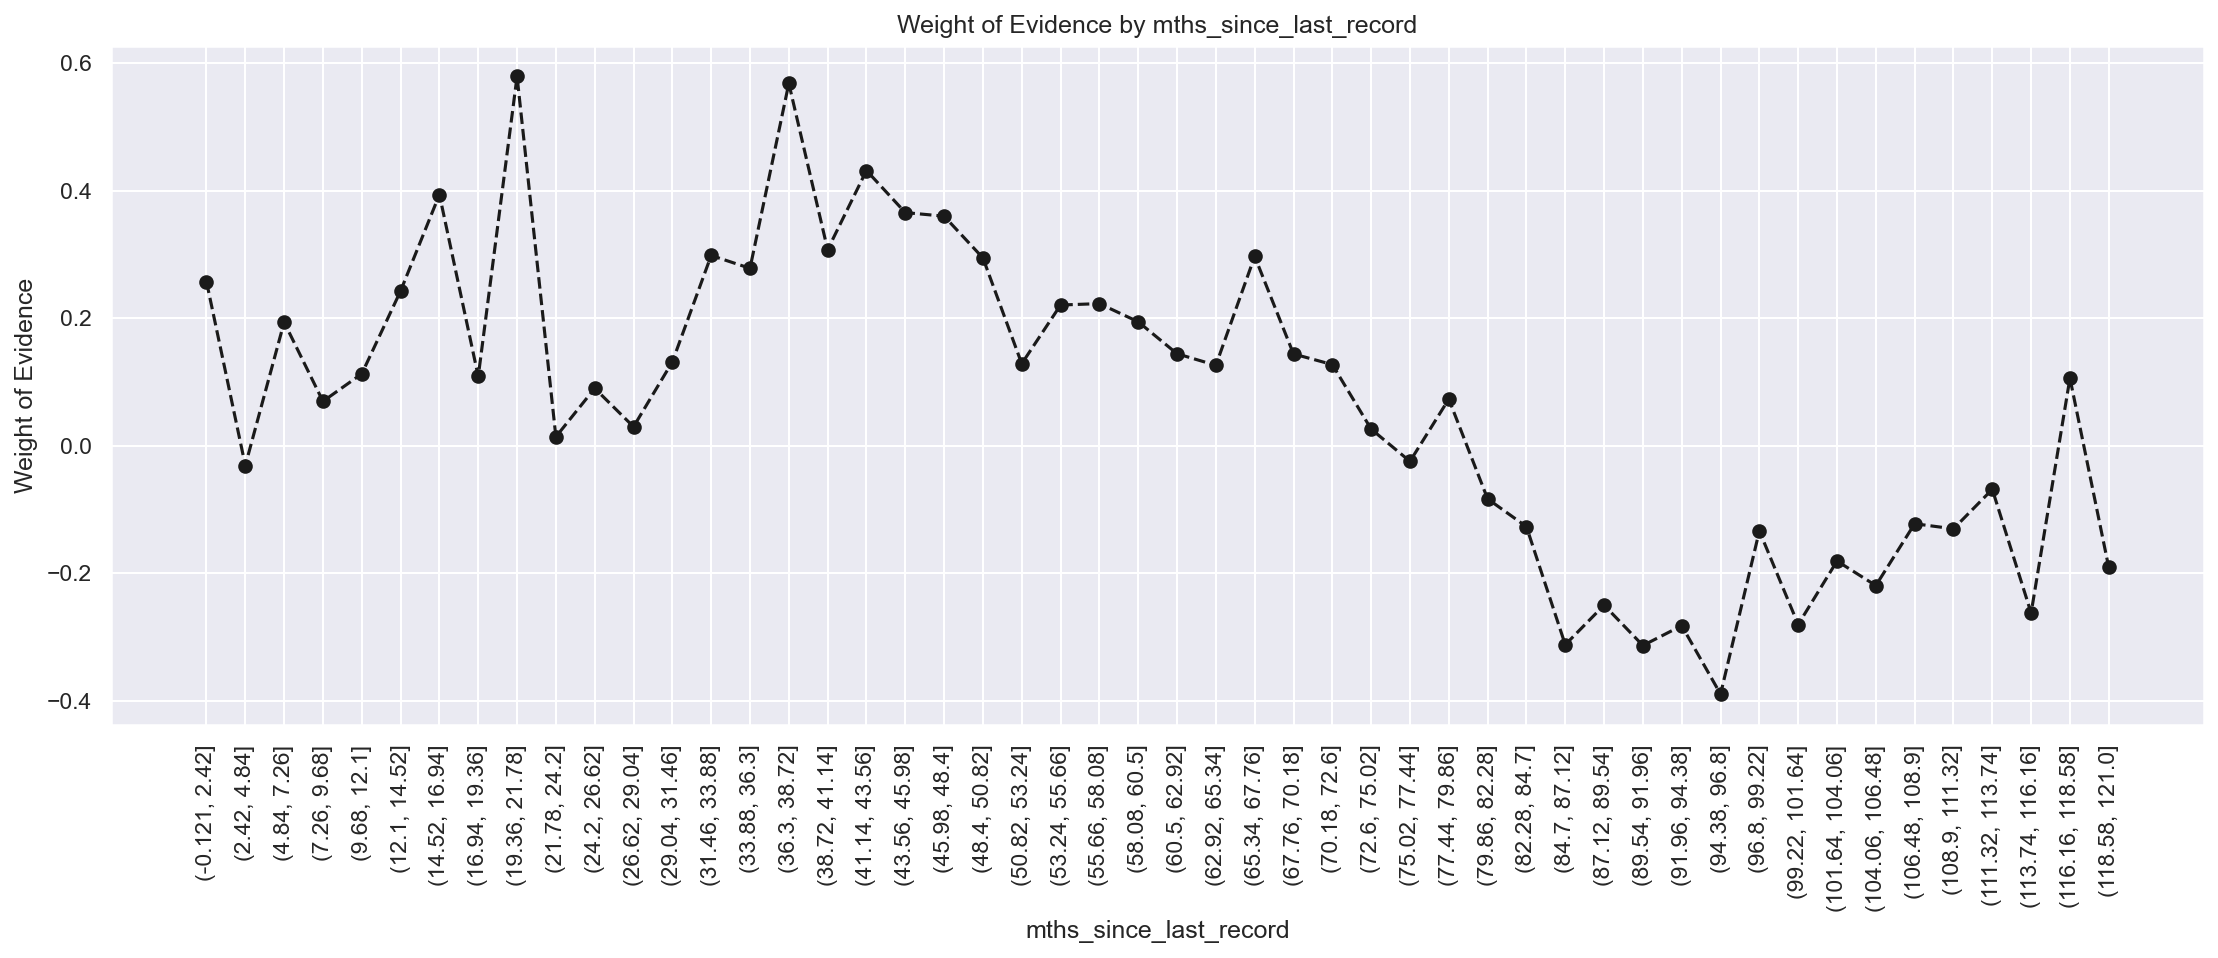

In [99]:
plot_by_woe(mths_since_last_record_not_null_factor_df, 90)

There will be 7 groupings:

- (1) all missing values
- (2) 0 < x <= 4.84
- (3) 4.84 < x <= 21.78
- (4) 21.78 < x <= 31.46
- (5) 31.46 < x <= 72.6
- (6) 72.6 < x <= 84.7
- (7) 84.7 < x <= max

*note that x = mths_since_last_record

In [100]:
X_train["mths_since_last_record:Missing"] = np.where((X_train["mths_since_last_record"].isnull()), 1, 0)
X_train["mths_since_last_record:0-4.84"] = np.where((X_train["mths_since_last_record"] >= 0) & (X_train["mths_since_last_record"] <= 4.84), 1, 0)
X_train["mths_since_last_record:4.84-21.78"] = np.where((X_train["mths_since_last_record"] > 4.84) & (X_train["mths_since_last_record"] <= 21.78), 1, 0)
X_train["mths_since_last_record:21.78-31.46"] = np.where((X_train["mths_since_last_record"] > 21.78) & (X_train["mths_since_last_record"] <= 31.46), 1, 0)
X_train["mths_since_last_record:31.46-72.6"] = np.where((X_train["mths_since_last_record"] > 31.46) & (X_train["mths_since_last_record"] <= 72.6), 1, 0)
X_train["mths_since_last_record:72.6-84.7"] = np.where((X_train["mths_since_last_record"] > 72.6) & (X_train["mths_since_last_record"] <= 84.7), 1, 0)
X_train["mths_since_last_record:>84.7"] = np.where((X_train["mths_since_last_record"] > 84.7), 1, 0)

### Preprocessing test dataset:

We require that the same transformations be done to the test dataset. Since we have already performed the analysis of how the variables should be transformed when preprocessing the X_train dataset, we can directly apply the transformations without needing to re-evaluate the weight of evidence to perform fine and course classing

In [101]:
X_test["home_ownership:RENT_OTHER_NONE_ANY"] = sum([X_test["home_ownership:RENT"],X_test["home_ownership:OTHER"],
                                                    X_test["home_ownership:NONE"], X_test["home_ownership:ANY"]])

# double check the states that are missing and then add them in if necessary for the test set
if ["addr_state:ND"] in X_test.columns.values:
    pass
else:
    X_test["addr_state:ND"] = 0

X_test["addr_state:ND_NE_NV_FL_HI_AL"] = sum([X_test["addr_state:ND"], X_test["addr_state:NE"],
                                               X_test["addr_state:NV"],X_test["addr_state:FL"], 
                                               X_test["addr_state:HI"], X_test["addr_state:AL"]])

X_test["addr_state:WV_NH_IA_WY_DC_ME_ID"] = sum([X_test["addr_state:WV"], X_test["addr_state:NH"],
                                                  X_test["addr_state:IA"], X_test["addr_state:WY"], 
                                                  X_test["addr_state:DC"], X_test["addr_state:ME"], 
                                                  X_test["addr_state:ID"]])

X_test["addr_state:NM_VA_OK_TN"] = sum([X_test["addr_state:NM"], X_test["addr_state:VA"],
                                         X_test["addr_state:OK"], X_test["addr_state:TN"]])

X_test["addr_state:LA_NC"] = sum([X_test["addr_state:LA"], X_test["addr_state:NC"]])

X_test["addr_state:MD_UT_MO"] = sum([X_test["addr_state:MD"], X_test["addr_state:UT"],
                                      X_test["addr_state:MO"]])

X_test["addr_state:NJ_KY_AZ"] = sum([X_test["addr_state:NJ"], X_test["addr_state:KY"],
                                      X_test["addr_state:AZ"]])

X_test["addr_state:AR_OH_MN_MI"] = sum([X_test["addr_state:AR"], X_test["addr_state:OH"],
                                         X_test["addr_state:MN"], X_test["addr_state:MI"]])

X_test["addr_state:PA_SD_RI_IN_MA_DE"] = sum([X_test["addr_state:PA"], X_test["addr_state:SD"],
                                         X_test["addr_state:RI"], X_test["addr_state:IN"],
                                         X_test["addr_state:MA"], X_test["addr_state:DE"]])

X_test["addr_state:WA_OR_GA_WI"] = sum([X_test["addr_state:WA"], X_test["addr_state:OR"],
                                         X_test["addr_state:GA"], X_test["addr_state:WI"]])

X_test["addr_state:MT_IL_CT"] = sum([X_test["addr_state:MT"], X_test["addr_state:IL"],
                                      X_test["addr_state:CT"]])

X_test["addr_state:KS_SC_CO_VT_AK_MS"] = sum([X_test["addr_state:KS"], X_test["addr_state:SC"],
                                         X_test["addr_state:CO"], X_test["addr_state:VT"],
                                         X_test["addr_state:AK"], X_test["addr_state:MS"]])

X_test["purpose:sm_b__moving__housing__other__ren_en"] = sum([X_test["purpose:small_business"],
                                                               X_test["purpose:moving"], X_test["purpose:house"],
                                                               X_test["purpose:other"], 
                                                               X_test["purpose:renewable_energy"]])

X_test["purpose:med__educ__vacation_wedding"] = sum([X_test["purpose:medical"], X_test["purpose:educational"],
                                                      X_test["purpose:vacation"], X_test["purpose:wedding"]])

X_test["purpose:home_improv__major_purch__car"] = sum([X_test["purpose:home_improvement"], 
                                                        X_test["purpose:major_purchase"], X_test["purpose:car"]])

X_test["term:36"] = np.where(X_test["term_int"] == 36, 1, 0)
X_test["term:60"] = np.where(X_test["term_int"] == 60, 1, 0)

X_test["emp_length:0"] = np.where(X_test["emp_length_int"].isin([0]), 1, 0)
X_test["emp_length:1"] = np.where(X_test["emp_length_int"].isin([1]), 1, 0)
X_test["emp_length:2-4"] = np.where(X_test["emp_length_int"].isin(range(2, 5)), 1, 0)
X_test["emp_length:5-6"] = np.where(X_test["emp_length_int"].isin(range(5, 7)), 1, 0)
X_test["emp_length:7-9"] = np.where(X_test["emp_length_int"].isin(range(7, 10)), 1, 0)
X_test["emp_length:10"] = np.where(X_test["emp_length_int"].isin([10]), 1, 0)

X_test["mths_since_issue_d:<38"] = np.where(X_test["mths_since_issue_d"].isin(range(38)), 1, 0)
X_test["mths_since_issue_d:38-39"] = np.where(X_test["mths_since_issue_d"].isin(range(38, 40)), 1, 0)
X_test["mths_since_issue_d:40-41"] = np.where(X_test["mths_since_issue_d"].isin(range(40, 42)), 1, 0)
X_test["mths_since_issue_d:42-48"] = np.where(X_test["mths_since_issue_d"].isin(range(42, 49)), 1, 0)
X_test["mths_since_issue_d:49-52"] = np.where(X_test["mths_since_issue_d"].isin(range(49, 53)), 1, 0)
X_test["mths_since_issue_d:53-64"] = np.where(X_test["mths_since_issue_d"].isin(range(53, 65)), 1, 0)
X_test["mths_since_issue_d:65-92"] = np.where(X_test["mths_since_issue_d"].isin(range(65, 92)), 1, 0)
X_test["mths_since_issue_d:>92"] = np.where(X_test["mths_since_issue_d"].isin(range(92, int(X_test["mths_since_issue_d"].max()))), 1, 0)

X_test["int_rate:<9.548"] = np.where((X_test["int_rate"] <= 9.548), 1, 0)
X_test["int_rate:9.548-12.025"] = np.where((X_test["int_rate"] > 9.548) & (X_test["int_rate"] <= 12.025), 1, 0)
X_test["int_rate:12.025-15.74"] = np.where((X_test["int_rate"] > 12.025) & (X_test["int_rate"] <= 15.74), 1, 0)
X_test["int_rate:15.74-20.281"] = np.where((X_test["int_rate"] > 15.74) & (X_test["int_rate"] <= 20.281), 1, 0)
X_test["int_rate:>20.281"] = np.where((X_test["int_rate"] > 20.281), 1, 0)

X_test["mths_since_earliest_cr_line:<140"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(140)), 1, 0)
X_test["mths_since_earliest_cr_line:140-195"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(140, 195)), 1, 0)
X_test["mths_since_earliest_cr_line:195-266"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(195, 266)), 1, 0)
X_test["mths_since_earliest_cr_line:266-302"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(266, 302)), 1, 0)
X_test["mths_since_earliest_cr_line:302-355"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(302, 355)), 1, 0)
X_test["mths_since_earliest_cr_line:355-426"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(355, 426)), 1, 0)
X_test["mths_since_earliest_cr_line:>426"] = np.where(X_test["mths_since_earliest_cr_line"].isin(range(426, int(X_test["mths_since_earliest_cr_line"].max()))), 1, 0)

X_test["delinq_2yrs:0"] = np.where((X_test["delinq_2yrs"] == 0), 1, 0)
X_test["delinq_2yrs:1-3"] = np.where((X_test["delinq_2yrs"] >= 1) & (X_test["delinq_2yrs"] <= 3), 1, 0)
X_test["delinq_2yrs:>=4"] = np.where((X_test["delinq_2yrs"] >= 4), 1, 0)

X_test["inq_last_6mths:0"] = np.where((X_test["inq_last_6mths"] == 0), 1, 0)
X_test["inq_last_6mths:1-2"] = np.where((X_test["inq_last_6mths"] >= 1) & (X_test["inq_last_6mths"] <= 2), 1, 0)
X_test["inq_last_6mths:3-6"] = np.where((X_test["inq_last_6mths"] >= 3) & (X_test["inq_last_6mths"] <= 6), 1, 0)
X_test["inq_last_6mths:>6"] = np.where((X_test["inq_last_6mths"] > 6), 1, 0)

X_test["open_acc:0"] = np.where((X_test["open_acc"] == 0), 1, 0)
X_test["open_acc:1-3"] = np.where((X_test["open_acc"] >= 1) & (X_test["open_acc"] <= 3), 1, 0)
X_test["open_acc:4-12"] = np.where((X_test["open_acc"] >= 4) & (X_test["open_acc"] <= 12), 1, 0)
X_test["open_acc:13-22"] = np.where((X_test["open_acc"] >= 13) & (X_test["open_acc"] <= 22), 1, 0)
X_test["open_acc:23-25"] = np.where((X_test["open_acc"] >= 23) & (X_test["open_acc"] <= 25), 1, 0)
X_test["open_acc:26-30"] = np.where((X_test["open_acc"] >= 26) & (X_test["open_acc"] <= 30), 1, 0)
X_test["open_acc:>=31"] = np.where((X_test["open_acc"] >= 31), 1, 0)

X_test["pub_rec:0-2"] = np.where((X_test["pub_rec"] >= 0) & (X_test["pub_rec"] <= 2), 1, 0)
X_test["pub_rec:3-4"] = np.where((X_test["pub_rec"] >= 3) & (X_test["pub_rec"] <= 4), 1, 0)
X_test["pub_rec:>=5"] = np.where((X_test["pub_rec"] >= 5), 1, 0)

X_test["total_acc:<=27"] = np.where((X_test["total_acc"] <= 27), 1, 0)
X_test["total_acc:28-51"] = np.where((X_test["total_acc"] >= 28) & (X_test["total_acc"] <= 51), 1, 0)
X_test["total_acc:>=52"] = np.where((X_test["total_acc"] >= 52), 1, 0)

X_test["acc_now_delinq:0"] = np.where((X_test["acc_now_delinq"] == 0), 1, 0)
X_test["acc_now_delinq:>=1"] = np.where((X_test["acc_now_delinq"] >= 1), 1, 0)

X_test["total_rev_hi_lim:<=5K"] = np.where((X_test["total_rev_hi_lim"] <= 5000), 1, 0)
X_test["total_rev_hi_lim:5K-10K"] = np.where((X_test["total_rev_hi_lim"] > 5000) & (X_test["total_rev_hi_lim"] <= 10000), 1, 0)
X_test["total_rev_hi_lim:10K-20K"] = np.where((X_test["total_rev_hi_lim"] > 10000) & (X_test["total_rev_hi_lim"] <= 20000), 1, 0)
X_test["total_rev_hi_lim:20K-30K"] = np.where((X_test["total_rev_hi_lim"] > 20000) & (X_test["total_rev_hi_lim"] <= 30000), 1, 0)
X_test["total_rev_hi_lim:30K-40K"] = np.where((X_test["total_rev_hi_lim"] > 30000) & (X_test["total_rev_hi_lim"] <= 40000), 1, 0)
X_test["total_rev_hi_lim:40K-55K"] = np.where((X_test["total_rev_hi_lim"] > 40000) & (X_test["total_rev_hi_lim"] <= 55000), 1, 0)
X_test["total_rev_hi_lim:55K-95K"] = np.where((X_test["total_rev_hi_lim"] > 55000) & (X_test["total_rev_hi_lim"] <= 95000), 1, 0)
X_test["total_rev_hi_lim:>95K"] = np.where((X_test["total_rev_hi_lim"] > 95000), 1, 0)

X_test["annual_inc:<20K"] = np.where((X_test["annual_inc"] <= 20000), 1, 0)
X_test["annual_inc:20K-30K"] = np.where((X_test["annual_inc"] > 20000) & (X_test["annual_inc"] <= 30000), 1, 0)
X_test["annual_inc:30K-40K"] = np.where((X_test["annual_inc"] > 30000) & (X_test["annual_inc"] <= 40000), 1, 0)
X_test["annual_inc:40K-50K"] = np.where((X_test["annual_inc"] > 40000) & (X_test["annual_inc"] <= 50000), 1, 0)
X_test["annual_inc:50K-60K"] = np.where((X_test["annual_inc"] > 50000) & (X_test["annual_inc"] <= 60000), 1, 0)
X_test["annual_inc:60K-70K"] = np.where((X_test["annual_inc"] > 60000) & (X_test["annual_inc"] <= 70000), 1, 0)
X_test["annual_inc:70K-80K"] = np.where((X_test["annual_inc"] > 70000) & (X_test["annual_inc"] <= 80000), 1, 0)
X_test["annual_inc:80K-90K"] = np.where((X_test["annual_inc"] > 80000) & (X_test["annual_inc"] <= 90000), 1, 0)
X_test["annual_inc:90K-100K"] = np.where((X_test["annual_inc"] > 90000) & (X_test["annual_inc"] <= 100000), 1, 0)
X_test["annual_inc:100K-120K"] = np.where((X_test["annual_inc"] > 100000) & (X_test["annual_inc"] <= 120000), 1, 0)
X_test["annual_inc:120K-140K"] = np.where((X_test["annual_inc"] > 120000) & (X_test["annual_inc"] <= 140000), 1, 0)
X_test["annual_inc:>140K"] = np.where((X_test["annual_inc"] > 140000), 1, 0)

X_test["mths_since_last_delinq:Missing"] = np.where((X_test["mths_since_last_delinq"].isnull()), 1, 0)
X_test["mths_since_last_delinq:0-3"] = np.where((X_test["mths_since_last_delinq"] >= 0) & (X_test["mths_since_last_delinq"] <= 3), 1, 0)
X_test["mths_since_last_delinq:4-30"] = np.where((X_test["mths_since_last_delinq"] >= 4) & (X_test["mths_since_last_delinq"] <= 30), 1, 0)
X_test["mths_since_last_delinq:31-56"] = np.where((X_test["mths_since_last_delinq"] >= 31) & (X_test["mths_since_last_delinq"] <= 56), 1, 0)
X_test["mths_since_last_delinq:>=57"] = np.where((X_test["mths_since_last_delinq"] >= 57), 1, 0)

X_test["dti:<=1.6"] = np.where((X_test["dti"] <= 1.6), 1, 0)
X_test["dti:1.6-3.9"] = np.where((X_test["dti"] > 1.6) & (X_test["dti"] <= 3.9), 1, 0)
X_test["dti:3.9-7.9"] = np.where((X_test["dti"] > 3.9) & (X_test["dti"] <= 7.9), 1, 0)
X_test["dti:7.9-10.4"] = np.where((X_test["dti"] > 7.9) & (X_test["dti"] <= 10.4), 1, 0)
X_test["dti:10.4-16.8"] = np.where((X_test["dti"] > 10.4) & (X_test["dti"] <= 16.8), 1, 0)
X_test["dti:16.8-21.6"] = np.where((X_test[ "dti"] > 16.8) & (X_test["dti"] <= 21.6), 1, 0)
X_test["dti:21.6-23.2"] = np.where((X_test["dti"] > 21.6) & (X_test["dti"] <= 23.2), 1, 0)
X_test["dti:23.2-24"] = np.where((X_test["dti"] > 23.2) & (X_test["dti"] <= 24), 1, 0)
X_test["dti:24-40"] = np.where((X_test["dti"] > 24) & (X_test["dti"] <= 40), 1, 0)
X_test["dti:>40"] = np.where((X_test["dti"] > 40), 1, 0)

X_test["mths_since_last_record:Missing"] = np.where((X_test["mths_since_last_record"].isnull()), 1, 0)
X_test["mths_since_last_record:0-4.84"] = np.where((X_test["mths_since_last_record"] >= 0) & (X_test["mths_since_last_record"] <= 4.84), 1, 0)
X_test["mths_since_last_record:4.84-21.78"] = np.where((X_test["mths_since_last_record"] > 4.84) & (X_test["mths_since_last_record"] <= 21.78), 1, 0)
X_test["mths_since_last_record:21.78-31.46"] = np.where((X_test["mths_since_last_record"] > 21.78) & (X_test["mths_since_last_record"] <= 31.46), 1, 0)
X_test["mths_since_last_record:31.46-72.6"] = np.where((X_test["mths_since_last_record"] > 31.46) & (X_test["mths_since_last_record"] <= 72.6), 1, 0)
X_test["mths_since_last_record:72.6-84.7"] = np.where((X_test["mths_since_last_record"] > 72.6) & (X_test["mths_since_last_record"] <= 84.7), 1, 0)
X_test["mths_since_last_record:>84.7"] = np.where((X_test["mths_since_last_record"] > 84.7), 1, 0)

# other transformation made to train dataset that will be applied to test dataset to ensure same number of columns
X_test["mths_since_issue_d_factor"] = pd.cut(X_test["mths_since_issue_d"], 50)
X_test["int_rate_factor"] = pd.cut(X_test["int_rate"], 50)
X_test["funded_amnt_factor"] = pd.cut(X_test["funded_amnt"], 50)
X_test["mths_since_earliest_cr_line_factor"] = pd.cut(X_test["mths_since_earliest_cr_line"], 50)
X_test["installment_factor"] = pd.cut(X_test["installment"], 50)
X_test["total_acc_factor"] = pd.cut(X_test["total_acc"], 50)
X_test["total_rev_hi_lim_factor"] = pd.cut(X_test["total_rev_hi_lim"], 2000)
X_test["annual_inc_factor"] = pd.cut(X_test["annual_inc"], 100)
X_test["dti_factor"] = pd.cut(X_test["dti"], 50)

##### Choosing relevant variables for PD model:

Using the weight of evidence, we have decreased the total number of independent variables by choosing only those that may contribute to increasing the predictive performance of the PD model

To prevent the dummy variable trap, all reference categories, that is the category within a independent variable that represented the highest risk of default, will be removed. That is if all dummies are 0, we can interpret the reference category to be represented in the dataset. Probability of default computed via the log of odds will be proportional to the reference category. That is, odds of 1.4 indicate that X category has a 40% of not defaulting vs the benchmark case. To compare categories with different odds, we can simply use the log of odds with the comparison category in the denominator to find the respective probability of default

In [102]:
# creating list of categories and refernce categories

# list of all dummies that will be used in PD model
categories = ["grade:A","grade:B","grade:C","grade:D","grade:E","grade:F","grade:G", "home_ownership:RENT_OTHER_NONE_ANY",
 "home_ownership:OWN", "home_ownership:MORTGAGE","addr_state:ND_NE_NV_FL_HI_AL", "addr_state:WV_NH_IA_WY_DC_ME_ID",
 "addr_state:NM_VA_OK_TN", "addr_state:LA_NC","addr_state:MD_UT_MO","addr_state:NJ_KY_AZ",
 "addr_state:AR_OH_MN_MI","addr_state:PA_SD_RI_IN_MA_DE", "addr_state:WA_OR_GA_WI","addr_state:MT_IL_CT",
 "addr_state:KS_SC_CO_VT_AK_MS","verification_status:Not Verified",
 "verification_status:Source Verified","verification_status:Verified", "purpose:sm_b__moving__housing__other__ren_en",
 "purpose:med__educ__vacation_wedding","purpose:debt_consolidation",
 "purpose:home_improv__major_purch__car","purpose:credit_card", "initial_list_status:f","initial_list_status:w",
 "term:36","term:60", "emp_length:0","emp_length:1","emp_length:2-4","emp_length:5-6", "emp_length:7-9",
 "emp_length:10","mths_since_issue_d:<38","mths_since_issue_d:38-39","mths_since_issue_d:40-41",
 "mths_since_issue_d:42-48","mths_since_issue_d:49-52","mths_since_issue_d:53-64","mths_since_issue_d:65-92",
 "mths_since_issue_d:>92","int_rate:<9.548","int_rate:9.548-12.025", "int_rate:12.025-15.74","int_rate:15.74-20.281",
 "int_rate:>20.281", "mths_since_earliest_cr_line:<140","mths_since_earliest_cr_line:140-195",
 "mths_since_earliest_cr_line:195-266","mths_since_earliest_cr_line:266-302","mths_since_earliest_cr_line:302-355",
 "mths_since_earliest_cr_line:355-426", "mths_since_earliest_cr_line:>426","delinq_2yrs:0","delinq_2yrs:1-3",
 "delinq_2yrs:>=4","inq_last_6mths:0","inq_last_6mths:1-2","inq_last_6mths:3-6","inq_last_6mths:>6","open_acc:0",
 "open_acc:1-3","open_acc:4-12","open_acc:13-22","open_acc:23-25","open_acc:26-30","open_acc:>=31","pub_rec:0-2",
 "pub_rec:3-4","pub_rec:>=5","total_acc:<=27","total_acc:28-51","total_acc:>=52","acc_now_delinq:0",
 "acc_now_delinq:>=1","total_rev_hi_lim:<=5K","total_rev_hi_lim:5K-10K","total_rev_hi_lim:10K-20K",
 "total_rev_hi_lim:20K-30K","total_rev_hi_lim:30K-40K","total_rev_hi_lim:40K-55K","total_rev_hi_lim:55K-95K",
 "total_rev_hi_lim:>95K","annual_inc:<20K","annual_inc:20K-30K","annual_inc:30K-40K","annual_inc:40K-50K",
 "annual_inc:50K-60K","annual_inc:60K-70K","annual_inc:70K-80K","annual_inc:80K-90K","annual_inc:90K-100K",
 "annual_inc:100K-120K","annual_inc:120K-140K","annual_inc:>140K","mths_since_last_delinq:Missing",
 "mths_since_last_delinq:0-3","mths_since_last_delinq:4-30","mths_since_last_delinq:31-56",
 "mths_since_last_delinq:>=57","dti:<=1.6","dti:1.6-3.9","dti:3.9-7.9","dti:7.9-10.4","dti:10.4-16.8","dti:16.8-21.6",
 "dti:21.6-23.2","dti:23.2-24","dti:24-40","dti:>40","mths_since_last_record:Missing","mths_since_last_record:0-4.84",
 "mths_since_last_record:4.84-21.78","mths_since_last_record:21.78-31.46","mths_since_last_record:31.46-72.6",
 "mths_since_last_record:72.6-84.7","mths_since_last_record:>84.7"]

# benchmark for dummies that will be removed to prevent dummy variable trap
ref_categories = ["grade:G", "home_ownership:RENT_OTHER_NONE_ANY", "addr_state:ND_NE_NV_FL_HI_AL",
                 "verification_status:Verified","purpose:sm_b__moving__housing__other__ren_en",
                 "initial_list_status:f","term:60","emp_length:0","mths_since_issue_d:>92","int_rate:>20.281",
                 "mths_since_earliest_cr_line:<140","delinq_2yrs:>=4","inq_last_6mths:>6","open_acc:0",
                 "pub_rec:0-2","total_acc:<=27","acc_now_delinq:0","total_rev_hi_lim:<=5K","annual_inc:<20K",
                 "dti:>40","mths_since_last_delinq:0-3","mths_since_last_record:0-4.84"]

X_train_with_ref_cat = X_train.loc[: , categories]


In [103]:
# drop all reference categories to prevent the dummy variable trap
X_train = X_train_with_ref_cat.drop(ref_categories, axis=1)

In [400]:
# this will drop all the columns to make it the same as the training data set
X_test = X_test[categories].drop(ref_categories, axis=1)

373028

In [110]:
X_test[categories].drop(ref_categories, axis=1).shape

(93257, 101)

In [104]:
X_train.shape

(373028, 101)

In [397]:
X_train.to_csv("X_train.csv")
y_train.to_csv("y_train.csv")
X_test.to_csv("X_test.csv")
y_test.to_csv("y_test.csv")

### PD Model Estimation:

The following section will fit the Logistic Regression model. However, sklearn is only able to interpret p_values of coefficients univariately, providing for a misleading interpretation of the statistical significance of said coefficients for the respective X feature. To combat this, we have created a Logistic Regression method that interprets the p_values multivariately via linear algebra. After interpreting the p_values, adjustments are made to eliminate X features who have several categories that are statistically insignificant. We do this instead of dropping any X feature with a statistically insiginificant category because there may be X features that only have 1 or 2 statistically insignificant categories, whereas the remaining categories, which represent the majority, are statistically significant. We don't want to lose this valuable data and decrease the interpretability of the X feature, so we opt to keep the X feature, despite it having some statistically insignificant categories.

After doing this, we retrain the model using the traditional Logistic Regression in sklearn using cross validation and a grid model approach to optimize the parameters and then check the performance of the model using evaluation metrics

In [ ]:
# import data
X_train = pd.read_csv("X_train.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0)

In [78]:
X_train_with_ref_cat = X_train.loc[: , categories]

# drop all reference categories to prevent the dummy variable trap
X_train = X_train_with_ref_cat.drop(ref_categories, axis=1)

In [79]:
# do the same for the test data set
X_test = X_test[categories].drop(ref_categories, axis=1)

In [80]:
# check the shape of both data sets to ensure they are the same
print(X_train.shape)

(373028, 101)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [1]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        # Get p-values for the fitted model #
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T

        # Fisher Information Matrix
        F_ij = np.dot((X / denom).T,X) 
        
        # Inverse Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) 
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        
        # z-score for eaach model coefficient
        z_scores = self.model.coef_[0] / sigma_estimates 
        
        # two tailed test for p-values
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] 
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [83]:
def create_model(X, y):
    model = LogisticRegression_with_p_values()
    model.fit(X, y)

    feature_name = X.columns.values

    summary_table = pd.DataFrame(columns=["feature_name"], data=feature_name)
    summary_table["coefficients"] = np.transpose(model.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ["intercept", model.intercept_[0]]
    summary_table = summary_table.sort_index()

    p_values = model.p_values
    p_values = np.append(np.nan, np.array(p_values))
    summary_table["p_value"] = p_values

    return summary_table

summary_table = create_model(X_train, y_train)
summary_table

feature_name  coefficients       p_value
0                                intercept      1.456151           NaN
1                                  grade:A      0.990073  8.548080e-27
2                                  grade:B      0.777535  6.302772e-36
3                                  grade:C      0.592097  1.328211e-24
4                                  grade:D      0.427643  8.199047e-15
5                                  grade:E      0.292421  2.697988e-09
6                                  grade:F      0.122141  1.697901e-02
7                       home_ownership:OWN      0.100238  6.894466e-07
8                  home_ownership:MORTGAGE      0.118733  4.400014e-21
9          addr_state:WV_NH_IA_WY_DC_ME_ID      0.455754  1.683913e-18
10                  addr_state:NM_VA_OK_TN     -0.044747  5.741145e-02
11                        addr_state:LA_NC      0.004448  8.747443e-01
12                     addr_state:MD_UT_MO     -0.006919  7.903578e-01
13                     addr_state:NJ_KY_AZ      0.000689  9.747094e-01
14                  addr_state:AR_OH_MN_MI      0.055174  8.229851e-03
15            addr_state:PA_SD_RI_IN_MA_DE      0.044989  3.095452e-02
16                  addr_state:WA_OR_GA_WI      0.122748  1.068717e-08
17                     addr_state:MT_IL_CT      0.190272  6.151644e-14
18            addr_state:KS_SC_CO_VT_AK_MS      0.246323  9.233582e-19
19        verification_status:Not Verified      0.097384  4.996993e-11
20     verification_status:Source Verified     -0.008366  5.356640e-01
21     purpose:med__educ__vacation_wedding      0.191267  1.104674e-06
22              purpose:debt_consolidation      0.090506  2.123754e-06
23   purpose:home_improv__major_purch__car      0.156565  1.941534e-09
24                     purpose:credit_card      0.196129  8.011560e-19
25                   initial_list_status:w      0.055882  1.861730e-05
26                                 term:36      0.074168  2.059524e-07
27                            emp_length:1      0.097847  1.888364e-04
28                          emp_length:2-4      0.124659  5.951785e-11
29                          emp_length:5-6      0.089247  3.468959e-05
30                          emp_length:7-9      0.060947  3.590823e-03
31                           emp_length:10      0.128683  4.097702e-12
32                  mths_since_issue_d:<38      0.756731  1.577150e-55
33                mths_since_issue_d:38-39      0.553295  1.080246e-34
34                mths_since_issue_d:40-41      0.448742  6.082810e-24
35                mths_since_issue_d:42-48      0.255129  9.471937e-10
36                mths_since_issue_d:49-52      0.103850  1.602215e-02
37                mths_since_issue_d:53-64     -0.142311  6.400972e-04
38                mths_since_issue_d:65-92     -0.368930  1.525427e-19
39                         int_rate:<9.548      0.987637  2.592009e-37
40                   int_rate:9.548-12.025      0.639697  8.187999e-46
41                   int_rate:12.025-15.74      0.388636  1.882276e-25
42                   int_rate:15.74-20.281      0.168064  1.331836e-08
43     mths_since_earliest_cr_line:140-195      0.028887  1.750659e-01
44     mths_since_earliest_cr_line:195-266      0.030897  1.504383e-01
45     mths_since_earliest_cr_line:266-302      0.119485  5.361511e-06
46     mths_since_earliest_cr_line:302-355      0.097574  4.415558e-04
47     mths_since_earliest_cr_line:355-426      0.108847  3.544026e-04
48        mths_since_earliest_cr_line:>426      0.088934  1.473368e-02
49                           delinq_2yrs:0      0.094974  9.779150e-02
50                         delinq_2yrs:1-3      0.048717  3.652559e-01
51                        inq_last_6mths:0     -1.225971  2.629775e-07
52                      inq_last_6mths:1-2     -1.369751  8.705655e-09
53                      inq_last_6mths:3-6     -1.505459  2.671911e-10
54                            open_acc:1-3      0.388331  5.162425e-01
55                           open_acc:4-12      0.2625

In [84]:
# categories that want to be removed
not_significant_categories = ["mths_since_last_delinq","total_rev_hi_lim","delinq_2yrs","open_acc","pub_rec","dti"]

# new categories list
new_categories = [i for i in categories if i.split(":")[0] not in not_significant_categories]

# new categories after taking out refer
new_categories_minus_ref_categories = [i for i in new_categories if i not in ref_categories]

In [85]:
X_train_with_new_ref_cat = X_train.loc[:, new_categories_minus_ref_categories]

In [86]:
summary_table_new_ref = create_model(X_train_with_new_ref_cat, y_train)
summary_table_new_ref

feature_name  coefficients       p_value
0                               intercept      2.116926           NaN
1                                 grade:A      0.966678  8.873140e-26
2                                 grade:B      0.754269  4.598164e-34
3                                 grade:C      0.573826  2.624748e-23
4                                 grade:D      0.412804  5.665900e-14
5                                 grade:E      0.287318  4.047941e-09
6                                 grade:F      0.117283  2.086084e-02
7                      home_ownership:OWN      0.097576  1.280030e-06
8                 home_ownership:MORTGAGE      0.117105  1.062271e-20
9         addr_state:WV_NH_IA_WY_DC_ME_ID      0.424186  1.758224e-16
10                 addr_state:NM_VA_OK_TN     -0.057393  1.459465e-02
11                       addr_state:LA_NC     -0.008050  7.748317e-01
12                    addr_state:MD_UT_MO     -0.012302  6.360126e-01
13                    addr_state:NJ_KY_AZ      0.000397  9.854042e-01
14                 addr_state:AR_OH_MN_MI      0.044975  3.098047e-02
15           addr_state:PA_SD_RI_IN_MA_DE      0.039221  5.958504e-02
16                 addr_state:WA_OR_GA_WI      0.114673  8.621382e-08
17                    addr_state:MT_IL_CT      0.190718  5.063368e-14
18           addr_state:KS_SC_CO_VT_AK_MS      0.230711  1.002095e-16
19       verification_status:Not Verified      0.122096  5.762593e-17
20    verification_status:Source Verified      0.006167  6.452187e-01
21    purpose:med__educ__vacation_wedding      0.184829  2.442585e-06
22             purpose:debt_consolidation      0.059700  1.525979e-03
23  purpose:home_improv__major_purch__car      0.162285  4.460747e-10
24                    purpose:credit_card      0.163429  7.386940e-14
25                  initial_list_status:w      0.054821  2.593826e-05
26                                term:36      0.078129  2.634652e-08
27                           emp_length:1      0.095303  2.715861e-04
28                         emp_length:2-4      0.119920  2.830727e-10
29                         emp_length:5-6      0.081087  1.638555e-04
30                         emp_length:7-9      0.052658  1.172542e-02
31                          emp_length:10      0.121534  5.263613e-11
32                 mths_since_issue_d:<38      0.713465  1.546342e-51
33               mths_since_issue_d:38-39      0.506285  1.364407e-30
34               mths_since_issue_d:40-41      0.409347  5.078418e-21
35               mths_since_issue_d:42-48      0.226875  2.697290e-08
36               mths_since_issue_d:49-52      0.082970  4.970270e-02
37               mths_since_issue_d:53-64     -0.164320  5.792450e-05
38               mths_since_issue_d:65-92     -0.371527  5.791858e-20
39                        int_rate:<9.548      1.043681  9.223397e-42
40                  int_rate:9.548-12.025      0.687704  3.613987e-53
41                  int_rate:12.025-15.74      0.421395  7.093097e-30
42                  int_rate:15.74-20.281      0.188474  1.640154e-10
43    mths_since_earliest_cr_line:140-195      0.024863  2.373521e-01
44    mths_since_earliest_cr_line:195-266      0.027492  1.895212e-01
45    mths_since_earliest_cr_line:266-302      0.116089  6.140722e-06
46    mths_since_earliest_cr_line:302-355      0.096161  3.955118e-04
47    mths_since_earliest_cr_line:355-426      0.108115  2.913596e-04
48       mths_since_earliest_cr_line:>426      0.089399  1.271146e-02
49                       inq_last_6mths:0     -1.272238  1.579352e-28
50                     inq_last_6mths:1-2     -1.412082  8.203853e-35
51                     inq_last_6mths:3-6     -1.548525  2.856472e-41
52                        total_acc:28-51     -0.067591  8.792226e-08
53                         total_acc:>=52     -0.033552  3.547321e-01
54                     acc_now_delinq:>=1      0.060984  5.118005e-01
55                     annual_inc:20K-30K     -0.112568  9.564989e-03
56                     annual_inc:30K-4

In [70]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver="saga", max_iter=1000)
penalty = ["l1", "l2", "elasticnet"]
l1_ratio = np.linspace(0,1,10)
C = np.logspace(0,10,10)

param_grid = {
    "penalty":penalty,
    "l1_ratio":l1_ratio,
    "C":C
}

grid_model = GridSearchCV(model, param_grid=param_grid)

In [71]:
grid_model.fit(X_train_with_new_ref_cat, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [72]:
grid_model.best_params_

{'C': 1.0, 'l1_ratio': 0.1111111111111111, 'penalty': 'l1'}

In [73]:
# have to make sure only the accepted features are used from the test set
X_test = X_test.loc[:, new_categories_minus_ref_categories]
y_preds = grid_model.predict(X_test)
y_preds_proba = grid_model.predict_proba(X_test)

In [74]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     10042
           1       0.89      1.00      0.94     83215

    accuracy                           0.89     93257
   macro avg       0.95      0.50      0.47     93257
weighted avg       0.90      0.89      0.84     93257



In [75]:
confusion_matrix(y_test, y_preds)

array([[    1, 10041],
       [    0, 83215]])

In [76]:
y_preds_proba = y_preds_proba[:][:,1]

In [77]:
y_test.reset_index(drop=True, inplace=True)

In [78]:
df_actual_predicted_probs = pd.concat([y_test, pd.DataFrame(y_preds_proba)], axis=1)
df_actual_predicted_probs.columns = ['y_test', 'y_preds_proba']

In [79]:
df_actual_predicted_probs.shape

(93257, 2)

In [80]:
# make a copy for gini and kolmogorov tests
df_actual_predicted_probs_gk = df_actual_predicted_probs.copy()

# Area Under the Curve

A threshold is used in the logistic regression to classify the outcomes as 1 or 0, good or bad. Based on the threshold, we will get varying confusion matrices, as the change in the algorithm classifying good or bad cases will affect the overall computatation of true positive, true negative, false positive and false negative values. More often than not, the default threshold of 50% is not sufficient in getting accurate classing. Below, we can see that although the model's accuracy is high, it also has a high number of false positives. These are people who shouldn't have been given loans based on the test set. 

We can use the area under the curve score to measure the quality of our model. The AUC score gives us the true positives and false positives measured against a scenario, where the model is just predicting off chance

True postive rate is the probability that an actual positive will test postive, whereas the true negative rate is the probability that an actual negative will test negative

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thres = roc_curve(df_actual_predicted_probs["y_test"], df_actual_predicted_probs["y_preds_proba"])

In [82]:
tpr_ = []
tnr = []
acc = []
tr = []

for threshold in np.linspace(0,1,20):
    threshold = round(threshold,2)
    
    df_actual_predicted_probs["tr_y_test "+str(threshold)] = np.where(df_actual_predicted_probs["y_preds_proba"] > threshold, 1,0)
    confusion_matrix_ = confusion_matrix(df_actual_predicted_probs["y_test"], df_actual_predicted_probs["tr_y_test "+str(threshold)])
    accuracy = (confusion_matrix_[0,0] + confusion_matrix_[1,1]) / (confusion_matrix_[0,0] + confusion_matrix_[0,1] + confusion_matrix_[1,0] + confusion_matrix_[1,1])
    
    tpr_.append(confusion_matrix_[0,0] / (confusion_matrix_[1,0] + confusion_matrix_[0,0]))
    tnr.append(confusion_matrix_[0,1] / (confusion_matrix_[0,1] + confusion_matrix_[1,1]))
    acc.append(accuracy)
    tr.append(threshold)
    
    

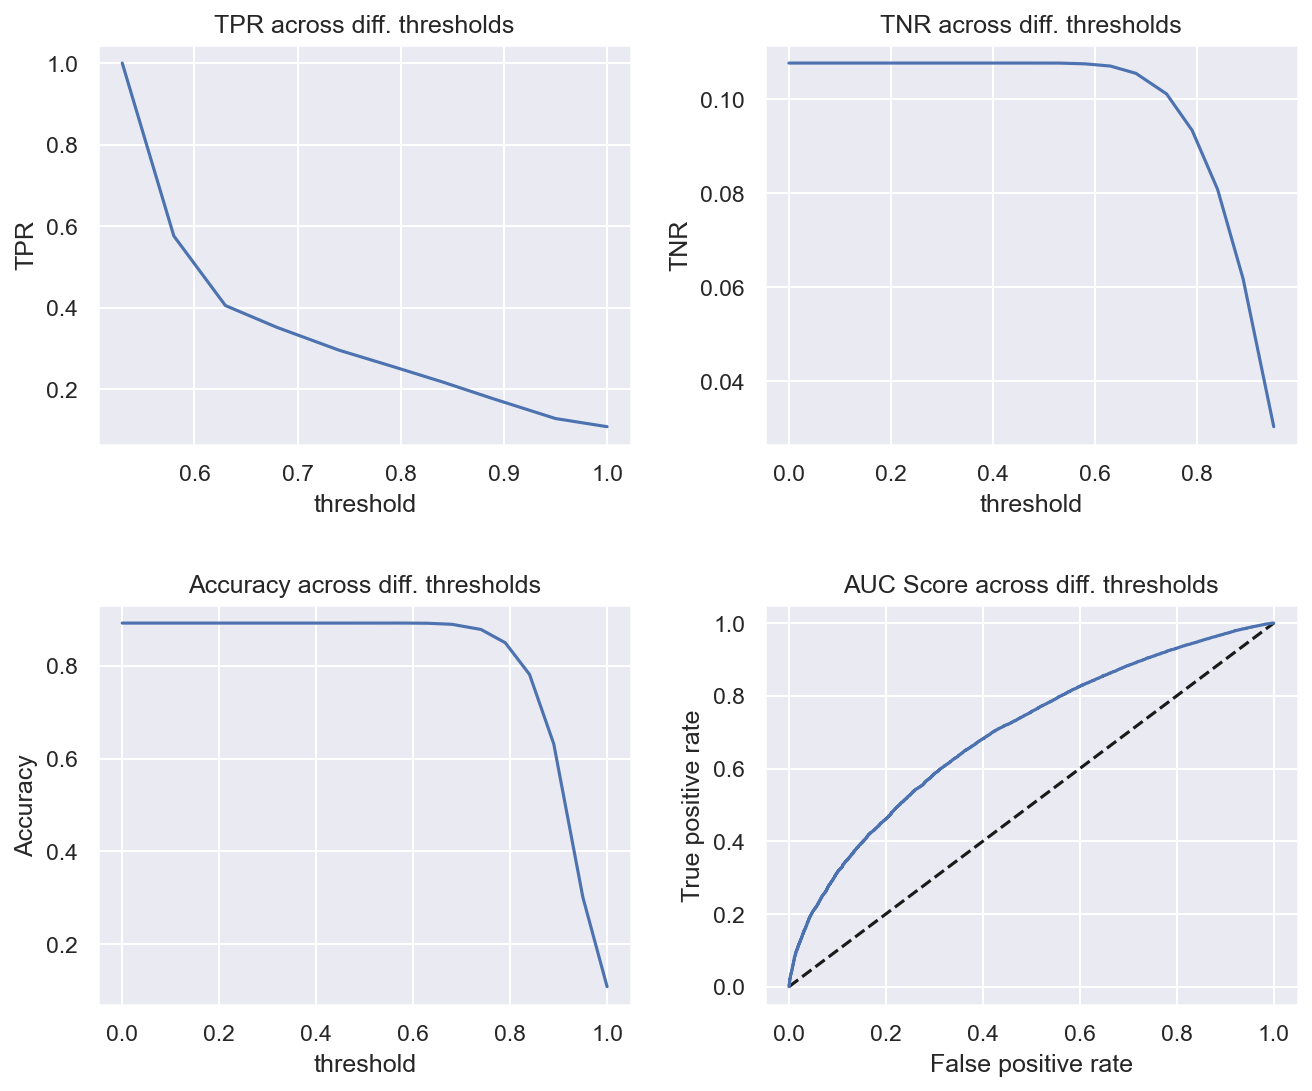

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10,8), dpi=150)

axs[0,0].plot(tr, tpr_)
axs[0,0].set_title("TPR across diff. thresholds")
axs[0,0].set_ylabel("TPR")
axs[0,0].set_xlabel("threshold")

axs[0,1].plot(tr, tnr)
axs[0,1].set_title("TNR across diff. thresholds")
axs[0,1].set_ylabel("TNR")
axs[0,1].set_xlabel("threshold")

axs[1,0].plot(tr,acc)
axs[1,0].set_title("Accuracy across diff. thresholds")
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("threshold")

axs[1,1].plot(fpr, fpr, linestyle = '--', color = 'k')
axs[1,1].plot(fpr, tpr)
axs[1,1].set_title('AUC Score across diff. thresholds')
axs[1,1].set_ylabel("True positive rate")
axs[1,1].set_xlabel("False positive rate")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)

plt.show()

### Model Performance Evaluation of Classification Models for Credit Risk Analysis Using Gini and Kolmogorov-Smirnov

Gini coefficient - was used to meause inequality between rich and poor

In credit risk, the gini coefficient is used to measure the inequality between non defaulted and defaulted in a population. Cumulative proprotion of defaulted against cumulative proportion of all borrowers

Kolmogorov smirnov tells us the extent that the model separates the good and bad borrowers by looking at the cumulative distribution of actual good borrowers and actual bad borrowers with respect to the estimated probabilities of being good and bad by our model 

The kolmogorow smirnov coefficient is the maximim difference between the cumulative distribution functions of good and bad borrowers with respect to predicted probabilities. The greater this difference, the better the model

In [84]:
# sort values
df_actual_predicted_probs_gk = df_actual_predicted_probs_gk.sort_values("y_preds_proba")


In [85]:
df_actual_predicted_probs_gk = df_actual_predicted_probs_gk.reset_index()

We need the following to make plots of our model performance criteria:

- cumulative % of total population
- cumulative % of good borrowers
- cumulative % of bad borrowers

In [86]:
df_actual_predicted_probs_gk["Cumulative N Population"] = df_actual_predicted_probs_gk.index + 1
df_actual_predicted_probs_gk["Cumulative N Good"] = df_actual_predicted_probs_gk["y_test"].cumsum()
df_actual_predicted_probs_gk["Cumulative N Bad"] = df_actual_predicted_probs_gk["Cumulative N Population"] - df_actual_predicted_probs_gk["y_test"].cumsum()


In [87]:
df_actual_predicted_probs_gk["Cumulative Perc Population"] = df_actual_predicted_probs_gk["Cumulative N Population"] / (df_actual_predicted_probs_gk.shape[0])
df_actual_predicted_probs_gk["Cumulative Perc Good"] = df_actual_predicted_probs_gk["Cumulative N Good"] / df_actual_predicted_probs_gk["y_test"].sum()
df_actual_predicted_probs_gk["Cumulative Perc Bad"] = df_actual_predicted_probs_gk["Cumulative N Bad"] / (df_actual_predicted_probs_gk.shape[0] - df_actual_predicted_probs_gk["y_test"].sum())


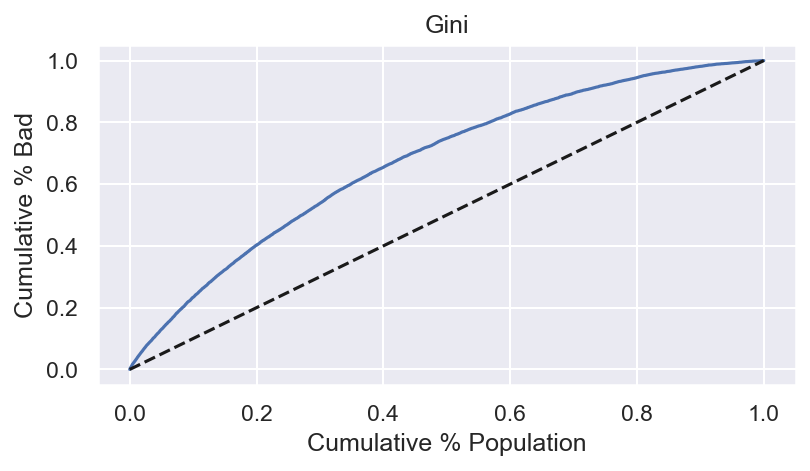

In [88]:
# visualize Gini
plt.figure(figsize=(6,3), dpi=150)

plt.plot(df_actual_predicted_probs_gk["Cumulative Perc Population"], df_actual_predicted_probs_gk["Cumulative Perc Bad"])
plt.plot(df_actual_predicted_probs_gk["Cumulative Perc Population"], df_actual_predicted_probs_gk["Cumulative Perc Population"], linestyle = "--", color = "k")

plt.xlabel("Cumulative % Population")
plt.ylabel("Cumulative % Bad")
plt.title("Gini")

plt.show()

In [89]:
AUROC = roc_auc_score(df_actual_predicted_probs_gk["y_test"], df_actual_predicted_probs_gk["y_preds_proba"])
Gini = AUROC * 2 - 1

Gini

0.39208433633596784

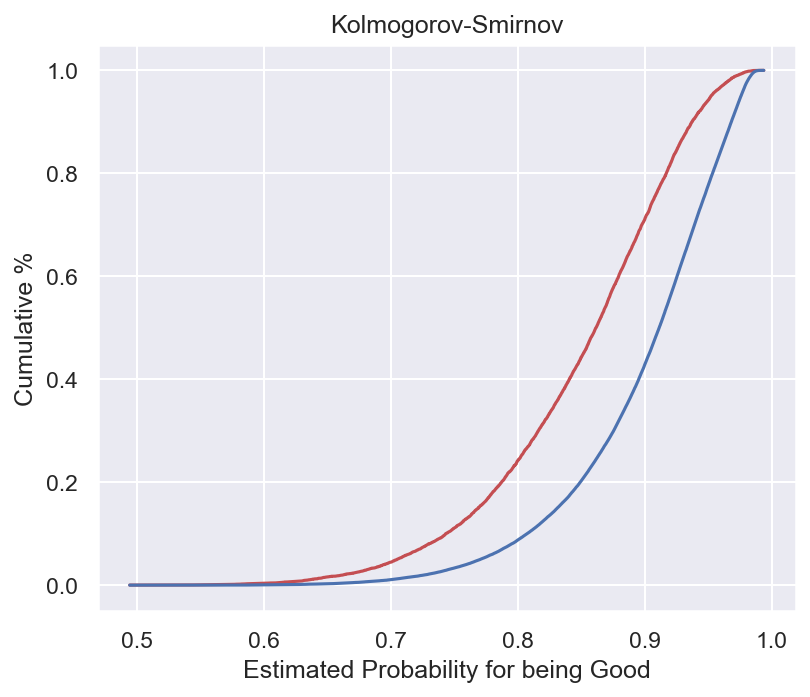

In [90]:
# visualize GK
plt.figure(figsize=(6,5), dpi=150)

plt.plot(df_actual_predicted_probs_gk["y_preds_proba"], df_actual_predicted_probs_gk["Cumulative Perc Bad"], color = "r")
plt.plot(df_actual_predicted_probs_gk["y_preds_proba"], df_actual_predicted_probs_gk["Cumulative Perc Good"], color = "b")

plt.xlabel("Estimated Probability for being Good")
plt.ylabel("Cumulative %")
plt.title("Kolmogorov-Smirnov")

plt.show()


Interpreting KS coefficient:
- Perfect model is when there is maximum distance -> KS = 1
- Predicting by chance is when there is no distance -> KS = 0

Although the KS coefficient is not very high, it is significantly higher than 0. This indicates that the 2 cumulative distribution are sifficently far away from each other and the model has satifactory predictive power

In [91]:
KS = max(df_actual_predicted_probs_gk["Cumulative Perc Bad"] - df_actual_predicted_probs_gk["Cumulative Perc Good"])
KS

0.287000840536322

### Creating a scorecard from PD model:

In [92]:
summary_table

feature_name  coefficients       p_value
0                                intercept      1.456151           NaN
1                                  grade:A      0.990073  8.548080e-27
2                                  grade:B      0.777535  6.302772e-36
3                                  grade:C      0.592097  1.328211e-24
4                                  grade:D      0.427643  8.199047e-15
5                                  grade:E      0.292421  2.697988e-09
6                                  grade:F      0.122141  1.697901e-02
7                       home_ownership:OWN      0.100238  6.894466e-07
8                  home_ownership:MORTGAGE      0.118733  4.400014e-21
9          addr_state:WV_NH_IA_WY_DC_ME_ID      0.455754  1.683913e-18
10                  addr_state:NM_VA_OK_TN     -0.044747  5.741145e-02
11                        addr_state:LA_NC      0.004448  8.747443e-01
12                     addr_state:MD_UT_MO     -0.006919  7.903578e-01
13                     addr_state:NJ_KY_AZ      0.000689  9.747094e-01
14                  addr_state:AR_OH_MN_MI      0.055174  8.229851e-03
15            addr_state:PA_SD_RI_IN_MA_DE      0.044989  3.095452e-02
16                  addr_state:WA_OR_GA_WI      0.122748  1.068717e-08
17                     addr_state:MT_IL_CT      0.190272  6.151644e-14
18            addr_state:KS_SC_CO_VT_AK_MS      0.246323  9.233582e-19
19        verification_status:Not Verified      0.097384  4.996993e-11
20     verification_status:Source Verified     -0.008366  5.356640e-01
21     purpose:med__educ__vacation_wedding      0.191267  1.104674e-06
22              purpose:debt_consolidation      0.090506  2.123754e-06
23   purpose:home_improv__major_purch__car      0.156565  1.941534e-09
24                     purpose:credit_card      0.196129  8.011560e-19
25                   initial_list_status:w      0.055882  1.861730e-05
26                                 term:36      0.074168  2.059524e-07
27                            emp_length:1      0.097847  1.888364e-04
28                          emp_length:2-4      0.124659  5.951785e-11
29                          emp_length:5-6      0.089247  3.468959e-05
30                          emp_length:7-9      0.060947  3.590823e-03
31                           emp_length:10      0.128683  4.097702e-12
32                  mths_since_issue_d:<38      0.756731  1.577150e-55
33                mths_since_issue_d:38-39      0.553295  1.080246e-34
34                mths_since_issue_d:40-41      0.448742  6.082810e-24
35                mths_since_issue_d:42-48      0.255129  9.471937e-10
36                mths_since_issue_d:49-52      0.103850  1.602215e-02
37                mths_since_issue_d:53-64     -0.142311  6.400972e-04
38                mths_since_issue_d:65-92     -0.368930  1.525427e-19
39                         int_rate:<9.548      0.987637  2.592009e-37
40                   int_rate:9.548-12.025      0.639697  8.187999e-46
41                   int_rate:12.025-15.74      0.388636  1.882276e-25
42                   int_rate:15.74-20.281      0.168064  1.331836e-08
43     mths_since_earliest_cr_line:140-195      0.028887  1.750659e-01
44     mths_since_earliest_cr_line:195-266      0.030897  1.504383e-01
45     mths_since_earliest_cr_line:266-302      0.119485  5.361511e-06
46     mths_since_earliest_cr_line:302-355      0.097574  4.415558e-04
47     mths_since_earliest_cr_line:355-426      0.108847  3.544026e-04
48        mths_since_earliest_cr_line:>426      0.088934  1.473368e-02
49                           delinq_2yrs:0      0.094974  9.779150e-02
50                         delinq_2yrs:1-3      0.048717  3.652559e-01
51                        inq_last_6mths:0     -1.225971  2.629775e-07
52                      inq_last_6mths:1-2     -1.369751  8.705655e-09
53                      inq_last_6mths:3-6     -1.505459  2.671911e-10
54                            open_acc:1-3      0.388331  5.162425e-01
55                           open_acc:4-12      0.2625

All reference categories have coeffients of 0 and nan p-values, as they represent the highest risk of the categories amongst an independent variable, so we show that through a 0, as this will decrease the overall score of an individual deeming them to be of a greater risk profile

In [93]:
pd.options.display.max_rows = None
df_ref_categories = pd.DataFrame(ref_categories, columns = ["feature_name"])
df_ref_categories["coefficients"] = 0
df_ref_categories["p_value"] = np.nan

df_scorecard = pd.concat([summary_table, df_ref_categories], axis=0)
df_scorecard = df_scorecard.reset_index()
df_scorecard

index                                  feature_name  coefficients  \
0        0                                     intercept      1.456151   
1        1                                       grade:A      0.990073   
2        2                                       grade:B      0.777535   
3        3                                       grade:C      0.592097   
4        4                                       grade:D      0.427643   
5        5                                       grade:E      0.292421   
6        6                                       grade:F      0.122141   
7        7                            home_ownership:OWN      0.100238   
8        8                       home_ownership:MORTGAGE      0.118733   
9        9               addr_state:WV_NH_IA_WY_DC_ME_ID      0.455754   
10      10                        addr_state:NM_VA_OK_TN     -0.044747   
11      11                              addr_state:LA_NC      0.004448   
12      12                           addr_state:MD_UT_MO     -0.006919   
13      13                           addr_state:NJ_KY_AZ      0.000689   
14      14                        addr_state:AR_OH_MN_MI      0.055174   
15      15                  addr_state:PA_SD_RI_IN_MA_DE      0.044989   
16      16                        addr_state:WA_OR_GA_WI      0.122748   
17      17                           addr_state:MT_IL_CT      0.190272   
18      18                  addr_state:KS_SC_CO_VT_AK_MS      0.246323   
19      19              verification_status:Not Verified      0.097384   
20      20           verification_status:Source Verified     -0.008366   
21      21           purpose:med__educ__vacation_wedding      0.191267   
22      22                    purpose:debt_consolidation      0.090506   
23      23         purpose:home_improv__major_purch__car      0.156565   
24      24                           purpose:credit_card      0.196129   
25      25                         initial_list_status:w      0.055882   
26      26                                       term:36      0.074168   
27      27                                  emp_length:1      0.097847   
28      28                                emp_length:2-4      0.124659   
29      29                                emp_length:5-6      0.089247   
30      30                                emp_length:7-9      0.060947   
31      31                                 emp_length:10      0.128683   
32      32                        mths_since_issue_d:<38      0.756731   
33      33                      mths_since_issue_d:38-39      0.553295   
34      34                      mths_since_issue_d:40-41      0.448742   
35      35                      mths_since_issue_d:42-48      0.255129   
36      36                      mths_since_issue_d:49-52      0.103850   
37      37                      mths_since_issue_d:53-64     -0.142311   
38      38                      mths_since_issue_d:65-92     -0.368930   
39      39                               int_rate:<9.548      0.987637   
40      40                         int_rate:9.548-12.025      0.639697   
41      41                         int_rate:12.025-15.74      0.388636   
42      42                         int_rate:15.74-20.281      0.168064   
43      43           mths_since_earliest_cr_line:140-195      0.028887   
44      44           mths_since_earliest_cr_line:195-266      0.030897   
45      45           mths_since_earliest_cr_line:266-302      0.119485   
46      46           mths_since_earliest_cr_line:302-355      0.097574   
47      47           mths_since_earliest_cr_line:355-426      0.108847   
48      48              mths_since_earliest_cr_line:>426      0.088934   
49      49                                 delinq_2yrs:0      0.094974   
50      50                               delinq_2yrs:1-3      0.048717   
51      51                              inq_last_6mths:0     -1.225971   
52      52                            inq_last_6mths:1-2     -1.369751   
53      5

In [94]:
# setting up min and max limits for credit scores - use FICO standards
min_score = 301
max_score = 850

df_scorecard["orig_feature_name"] = df_scorecard["feature_name"].str.split(":").str[0]

# setting up min and max limits for coefficients to comply with credit score range
min_sum_coef = df_scorecard.groupby("orig_feature_name")["coefficients"].min().sum()
max_sum_coef = df_scorecard.groupby("orig_feature_name")["coefficients"].max().sum()

# convert coefficients to be in range of credit score
df_scorecard["score_calc"] = df_scorecard["coefficients"] * (max_score - min_score) / (max_sum_coef - min_sum_coef)


In [95]:
# fix intercept to be min value of credit score
df_scorecard["score_calc"][0] = ((df_scorecard["coefficients"][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score


In [96]:
df_scorecard

index                                  feature_name  coefficients  \
0        0                                     intercept      1.456151   
1        1                                       grade:A      0.990073   
2        2                                       grade:B      0.777535   
3        3                                       grade:C      0.592097   
4        4                                       grade:D      0.427643   
5        5                                       grade:E      0.292421   
6        6                                       grade:F      0.122141   
7        7                            home_ownership:OWN      0.100238   
8        8                       home_ownership:MORTGAGE      0.118733   
9        9               addr_state:WV_NH_IA_WY_DC_ME_ID      0.455754   
10      10                        addr_state:NM_VA_OK_TN     -0.044747   
11      11                              addr_state:LA_NC      0.004448   
12      12                           addr_state:MD_UT_MO     -0.006919   
13      13                           addr_state:NJ_KY_AZ      0.000689   
14      14                        addr_state:AR_OH_MN_MI      0.055174   
15      15                  addr_state:PA_SD_RI_IN_MA_DE      0.044989   
16      16                        addr_state:WA_OR_GA_WI      0.122748   
17      17                           addr_state:MT_IL_CT      0.190272   
18      18                  addr_state:KS_SC_CO_VT_AK_MS      0.246323   
19      19              verification_status:Not Verified      0.097384   
20      20           verification_status:Source Verified     -0.008366   
21      21           purpose:med__educ__vacation_wedding      0.191267   
22      22                    purpose:debt_consolidation      0.090506   
23      23         purpose:home_improv__major_purch__car      0.156565   
24      24                           purpose:credit_card      0.196129   
25      25                         initial_list_status:w      0.055882   
26      26                                       term:36      0.074168   
27      27                                  emp_length:1      0.097847   
28      28                                emp_length:2-4      0.124659   
29      29                                emp_length:5-6      0.089247   
30      30                                emp_length:7-9      0.060947   
31      31                                 emp_length:10      0.128683   
32      32                        mths_since_issue_d:<38      0.756731   
33      33                      mths_since_issue_d:38-39      0.553295   
34      34                      mths_since_issue_d:40-41      0.448742   
35      35                      mths_since_issue_d:42-48      0.255129   
36      36                      mths_since_issue_d:49-52      0.103850   
37      37                      mths_since_issue_d:53-64     -0.142311   
38      38                      mths_since_issue_d:65-92     -0.368930   
39      39                               int_rate:<9.548      0.987637   
40      40                         int_rate:9.548-12.025      0.639697   
41      41                         int_rate:12.025-15.74      0.388636   
42      42                         int_rate:15.74-20.281      0.168064   
43      43           mths_since_earliest_cr_line:140-195      0.028887   
44      44           mths_since_earliest_cr_line:195-266      0.030897   
45      45           mths_since_earliest_cr_line:266-302      0.119485   
46      46           mths_since_earliest_cr_line:302-355      0.097574   
47      47           mths_since_earliest_cr_line:355-426      0.108847   
48      48              mths_since_earliest_cr_line:>426      0.088934   
49      49                                 delinq_2yrs:0      0.094974   
50      50                               delinq_2yrs:1-3      0.048717   
51      51                              inq_last_6mths:0     -1.225971   
52      52                            inq_last_6mths:1-2     -1.369751   
53      5

In [97]:
df_scorecard.groupby("orig_feature_name")["coefficients"].max().sum()

7.462127762306924

In [98]:
# round scores
df_scorecard["score_rounded"] = df_scorecard["score_calc"].round()

min_sum_score_rounded = df_scorecard.groupby("orig_feature_name")["score_rounded"].min().sum()
max_sum_score_rounded = df_scorecard.groupby("orig_feature_name")["score_rounded"].max().sum()

df_scorecard["diff"] = df_scorecard["score_rounded"] - df_scorecard["score_calc"]

df_scorecard["score_final"] = df_scorecard["score_rounded"]


In [99]:
# this is where the diff is greatest, so we will round this score down from 7 to 6 to fix credit score range
df_scorecard.iloc[df_scorecard["diff"].argmax(), :]

index                                 7
feature_name         home_ownership:OWN
coefficients                   0.100238
p_value                        0.000001
orig_feature_name        home_ownership
score_calc                     6.504644
score_rounded                       7.0
diff                           0.495356
score_final                         7.0
Name: 7, dtype: object

In [100]:
df_scorecard.iloc[df_scorecard["diff"].argmax()]["score_rounded"] = 6.0

In [101]:
# check if scores now fall within assigned credit range
min_sum_score_prel = df_scorecard.groupby("orig_feature_name")["score_final"].min().sum()
max_sum_score_prel = df_scorecard.groupby("orig_feature_name")["score_final"].max().sum()

print("Min credit score:", min_sum_score_prel,",","Max credit score:", max_sum_score_prel)

Min credit score: 301.0 , Max credit score: 850.0


In [102]:
df_scorecard

index                                  feature_name  coefficients  \
0        0                                     intercept      1.456151   
1        1                                       grade:A      0.990073   
2        2                                       grade:B      0.777535   
3        3                                       grade:C      0.592097   
4        4                                       grade:D      0.427643   
5        5                                       grade:E      0.292421   
6        6                                       grade:F      0.122141   
7        7                            home_ownership:OWN      0.100238   
8        8                       home_ownership:MORTGAGE      0.118733   
9        9               addr_state:WV_NH_IA_WY_DC_ME_ID      0.455754   
10      10                        addr_state:NM_VA_OK_TN     -0.044747   
11      11                              addr_state:LA_NC      0.004448   
12      12                           addr_state:MD_UT_MO     -0.006919   
13      13                           addr_state:NJ_KY_AZ      0.000689   
14      14                        addr_state:AR_OH_MN_MI      0.055174   
15      15                  addr_state:PA_SD_RI_IN_MA_DE      0.044989   
16      16                        addr_state:WA_OR_GA_WI      0.122748   
17      17                           addr_state:MT_IL_CT      0.190272   
18      18                  addr_state:KS_SC_CO_VT_AK_MS      0.246323   
19      19              verification_status:Not Verified      0.097384   
20      20           verification_status:Source Verified     -0.008366   
21      21           purpose:med__educ__vacation_wedding      0.191267   
22      22                    purpose:debt_consolidation      0.090506   
23      23         purpose:home_improv__major_purch__car      0.156565   
24      24                           purpose:credit_card      0.196129   
25      25                         initial_list_status:w      0.055882   
26      26                                       term:36      0.074168   
27      27                                  emp_length:1      0.097847   
28      28                                emp_length:2-4      0.124659   
29      29                                emp_length:5-6      0.089247   
30      30                                emp_length:7-9      0.060947   
31      31                                 emp_length:10      0.128683   
32      32                        mths_since_issue_d:<38      0.756731   
33      33                      mths_since_issue_d:38-39      0.553295   
34      34                      mths_since_issue_d:40-41      0.448742   
35      35                      mths_since_issue_d:42-48      0.255129   
36      36                      mths_since_issue_d:49-52      0.103850   
37      37                      mths_since_issue_d:53-64     -0.142311   
38      38                      mths_since_issue_d:65-92     -0.368930   
39      39                               int_rate:<9.548      0.987637   
40      40                         int_rate:9.548-12.025      0.639697   
41      41                         int_rate:12.025-15.74      0.388636   
42      42                         int_rate:15.74-20.281      0.168064   
43      43           mths_since_earliest_cr_line:140-195      0.028887   
44      44           mths_since_earliest_cr_line:195-266      0.030897   
45      45           mths_since_earliest_cr_line:266-302      0.119485   
46      46           mths_since_earliest_cr_line:302-355      0.097574   
47      47           mths_since_earliest_cr_line:355-426      0.108847   
48      48              mths_since_earliest_cr_line:>426      0.088934   
49      49                                 delinq_2yrs:0      0.094974   
50      50                               delinq_2yrs:1-3      0.048717   
51      51                              inq_last_6mths:0     -1.225971   
52      52                            inq_last_6mths:1-2     -1.369751   
53      5

Note that in the scorecard dataframe, both the categories and reference categories are included. When creating the PD model, we opted to remove these values to avoid the dummy variable trap, however, to maintain interpretability, we will opt to include them here as zero values. Due to this, we will also have to opt to include the reference category columns in our test dataset so that the credit scores are computed appropriately. To make this easy, we will re-import the data sets and not drop the reference categories

In [103]:
# re-import data to include reference categories
X_train = pd.read_csv("X_train.csv", index_col=0).loc[: , categories]
y_train = pd.read_csv("y_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0).loc[: , categories]
y_test = pd.read_csv("y_test.csv", index_col=0)

### Calculate Credit Scores:

To calculate the credit score of a borrower, we will take the product sum of the credit scores corresponding to the respective dummy variable categories of our PD model (recall that dummy variables are binary, therefore, in instances where the dummy variable is 0, the sum of the product will just be 0 to represent the category not being considered for said applicant)

Due to the first column being the intercept, an additional column of ones will be added to perform the calculation in one sweep, instead of separating the coefficients of the respective X features and adding the intercept to the credit score at the end

In [104]:
X_test_with_intercept = X_test.copy()
X_test_with_intercept.insert(0, "Intercept", 1)

Ensure that columns are arranged in the same order as the variables in the scorecard dataframe. Recall that we shrunk the list of dummy variables in our training data set, such that only dummy variables that yielded a higher information value were retained. For our PD model to work on our test data set, the same alterations will need to be made:

In [105]:
try: 
    X_test_with_intercept = X_test_with_intercept[df_scorecard["feature_name"].values]
except:
    pass

Now that the order of all the scores are the same for both training and test data sets, we can simply perform the sum product to compute all applicant's credit scores using the dot product of the matrices

In [106]:
scorecard_scores = df_scorecard["score_final"]
scorecard_scores = scorecard_scores.values.reshape(124, 1)

y_scores = X_test_with_intercept.dot(scorecard_scores)
y_scores.rename(columns={0:"credit_score"}, inplace=True)
y_scores.head()

credit_score
362514         700.0
288564         670.0
213591         679.0
263083         601.0
165001         759.0

### Convert Credit Score to PD:

To convert credit scores to show probability of default (recall this is the coefficients for the PD model that were generated beforehand), we will use the following formula:

coef_from_credit_score = (total_score - min_score) / (max_score - min_score) * (max_sum_coef - min_sum_coef) + min_sum_coef

In [107]:
coef_from_credit_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
y_hat_probab_from_score = np.exp(coef_from_credit_score) / (np.exp(coef_from_credit_score) + 1)

y_hat_probab_from_score.head()


credit_score
362514      0.994237
288564      0.990881
213591      0.992053
263083      0.974042
165001      0.997671

* note that there is a negligible difference in the probabilities, however, this difference is due to rounding

### Setting Cut Off Rates:

Cut off rates are used to determine the total number of borrowers that will be approved and rejected, as well as the quality of the loans granted by the bank

* more loans = lower quality borrowers
* fewer loans = higher quality borrowers

We can use the true and false positive rate arrays and the threshold array obtained from the roc curve method we performed below the Area Under the Curve Section for setting decision making cutoffs:

In [108]:
df_cutoffs = pd.concat([pd.DataFrame(thres), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
df_cutoffs.columns = ["thresholds","fpr", "tpr"]

In [109]:
df_cutoffs.head()

thresholds     fpr       tpr
0    1.993762  0.0000  0.000000
1    0.993762  0.0000  0.000012
2    0.988914  0.0000  0.000493
3    0.988910  0.0001  0.000493
4    0.986594  0.0001  0.002500

The first row of this dataframe takes the highest probability of non-default and adds 1 to it. This information is not very useful, so we have opted to replace the value with a number that is very close to the value 1:

In [110]:
df_cutoffs["thresholds"][0] = 1 - 1 / np.power(10,16)

We will use the credit scores to set cutoffs based on the probability that the borrower will be good. 

The following formula can be use to compute the scores from the thresholds column:

score_from_prob = (natural_log of (prob_good / 1 - prob_good) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score

In [111]:
df_cutoffs["scores"] = ((np.log(df_cutoffs["thresholds"] / (1 - df_cutoffs["thresholds"])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

# to set the first column representing the highest probability of non_default as the maximum credit score attainable
df_cutoffs["scores"][0] = max_score

df_cutoffs.head()

thresholds     fpr       tpr  scores
0    1.000000  0.0000  0.000000   850.0
1    0.993762  0.0000  0.000012   695.0
2    0.988914  0.0000  0.000493   657.0
3    0.988910  0.0001  0.000493   657.0
4    0.986594  0.0001  0.002500   645.0

To compute the approval and rejection rates for each possible cutoff, we have 2 options:

* (1) use the number of loan applications that would be approved
* (2) use the number of loan applications that would be rejected

num_of_approved + num_of_rejected = total

approval_rate = num_of_approved / total </br>
rejection_rate = num_of_rejected / total OR 1 - approval_rate

In [112]:
# function to compute num of approved borrowers for given threshold (p)
def n_approved(p):
    return np.where(df_actual_predicted_probs["y_preds_proba"] >= p, 1, 0).sum()

* ^function will return the number of borrowers, for which the predicted probability is >= p

We can then use the formulas for computing approval_rate and rejection_rate to find the number of applicants that would be approved and rejected:

In [113]:
df_cutoffs["N_approved"] = df_cutoffs["thresholds"].apply(n_approved)
df_cutoffs["N_rejected"] = df_actual_predicted_probs["y_preds_proba"].shape[0] - df_cutoffs["N_approved"]
df_cutoffs["approval_rate"] = df_cutoffs["N_approved"] / df_actual_predicted_probs["y_preds_proba"].shape[0]
df_cutoffs["rejection_rate"] = 1 - df_cutoffs["approval_rate"]

In [114]:
df_cutoffs.head()

thresholds     fpr       tpr  scores  N_approved  N_rejected  \
0    1.000000  0.0000  0.000000   850.0           0       93257   
1    0.993762  0.0000  0.000012   695.0           1       93256   
2    0.988914  0.0000  0.000493   657.0          41       93216   
3    0.988910  0.0001  0.000493   657.0          42       93215   
4    0.986594  0.0001  0.002500   645.0         209       93048   

   approval_rate  rejection_rate  
0       0.000000        1.000000  
1       0.000011        0.999989  
2       0.000440        0.999560  
3       0.000450        0.999550  
4       0.002241        0.997759

Let's assume that the highest level of probability the bank would accept is 15%, that is, no more than 15% of its applicants should default on their loans:

In [115]:
highest_prob_of_default = 0.10

df_cutoffs[df_cutoffs["thresholds"] >= 1 - highest_prob_of_default].iloc[-1].to_frame().T

thresholds       fpr       tpr  scores  N_approved  N_rejected  \
6259    0.900002  0.289285  0.571796   508.0     50487.0     42770.0   

      approval_rate  rejection_rate  
6259       0.541375        0.458625

### Model Monitoring and Maintenance:

As time goes by, it may be the case that the population of loan applicants changes drastically. Our PD model, which was trained on an argubably different pool of applicants may now not be able to accurately predict the probability of default of our new applicant pool. To mitigate this, its important to have scheduled maintenance of our model to check whether our model needs to be re-developed

The Population Stability Index (PSI) index is a widely accepted metric to compare the 2 populations. It determines whether there are material changes between the 2 data sets. It is computed as follows:

PSI = for j in k categories, sum of [(% of actual_j - % of expected_j) * natural log of (% of actual_j / % of expected_j]

* where PSI is between 0 and 1 (0 <= PSI <= 1), and
* actual represents the new population and expected represents the old population

Interpreting PSI values:

* PSI = 0 -> no evidence indicating any change between populations
* PSI < 0.1 -> little to no evidence indicating change between populations 
* 0.1 < PSI < 0.25 -> marginal differences between populations requiring investigation, but usually not enough to warrant any changes
* PSI > 0.25 -> significant evidence to suggest large changes between populations, requiring both investigation and rebuilding of the model
* PSI = 1 -> concrete evidence indicating an absolute change between populations

In [116]:
# import new data
new_loan_data = pd.read_csv("new_loan_data.csv")
df = new_loan_data.copy()

### Preprocess Data:

In [117]:
# all preprocessing made before splitting the data
df["emp_length_int"] = df["emp_length"].str.replace("\+ years", "")
df["emp_length_int"] = df["emp_length_int"].str.replace("< 1 year", str(0))
df["emp_length_int"] = df["emp_length_int"].str.replace("n/a",  str(0))
df["emp_length_int"] = df["emp_length_int"].str.replace(" years", "")
df["emp_length_int"] = df["emp_length_int"].str.replace(" year", "")

df["emp_length_int"] = pd.to_numeric(df["emp_length_int"])

df["term_int"] = df["term"]
df["term_int"] = df["term_int"].str.replace(" 36 months", str(36))
df["term_int"] = df["term_int"].str.replace(" 60 months", str(60))
df["term_int"] = pd.to_numeric(df["term_int"])

df["earliest_cr_line_date"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%y")
df["mths_since_earliest_cr_line"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["earliest_cr_line_date"]) / np.timedelta64(1, "M")))

# fixing the negative months in mths_since_earliest_cr_line column
idx_wrong_dates = []
for i in df["earliest_cr_line_date"].loc[df["earliest_cr_line_date"] > "2017-12-01"].index:
    idx_wrong_dates.append(i)

df["str_earliest_cr_line_date"] = df["earliest_cr_line_date"].dt.strftime('%Y-%m-%d')

str_earliest_cr_line_date_fixed = []

for i in idx_wrong_dates:
    str_earliest_cr_line_date_fixed.append((df["str_earliest_cr_line_date"][i].replace("20","19"),i))
    
for i, j in str_earliest_cr_line_date_fixed:
    df["str_earliest_cr_line_date"][j] = i
    
df["earliest_cr_line_date"] = pd.to_datetime(df["str_earliest_cr_line_date"], format="%Y-%m-%d")

df["mths_since_earliest_cr_line"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["earliest_cr_line_date"]) / np.timedelta64(1, "M")))

df["issue_d_date"] = pd.to_datetime(df["issue_d"], format="%b-%y")
df["mths_since_issue_d"] = round(pd.to_numeric((pd.to_datetime("2017-12-01") - df["issue_d_date"]) / np.timedelta64(1, "M")))

loan_data_dummies = [pd.get_dummies(df["grade"], prefix="grade", prefix_sep=":"),
                     pd.get_dummies(df["sub_grade"], prefix="sub_grade", prefix_sep=":"),
                     pd.get_dummies(df["home_ownership"],prefix="home_ownership",prefix_sep=":"),
                     pd.get_dummies(df["verification_status"],prefix="verification_status",prefix_sep=":"),
                     pd.get_dummies(df["loan_status"],prefix="loan_status",prefix_sep=":"),
                     pd.get_dummies(df["purpose"],prefix="purpose",prefix_sep=":"),
                     pd.get_dummies(df["addr_state"],prefix="addr_state",prefix_sep=":"),
                     pd.get_dummies(df["initial_list_status"],prefix="initial_list_status",prefix_sep=":")]

loan_data_dummies = pd.concat(loan_data_dummies, axis=1)

# concat dummies to original dataframe
df_after_dummies = pd.concat([df, loan_data_dummies], axis=1)

df_after_dummies["total_rev_hi_lim"].fillna(df_after_dummies["funded_amnt"], inplace=True)
df_after_dummies["annual_inc"].fillna(df_after_dummies["annual_inc"].mean(), inplace=True)

cols_inpute_as_zero = ["mths_since_earliest_cr_line", "acc_now_delinq", "total_acc", "pub_rec", 
                       "open_acc", "inq_last_6mths", "delinq_2yrs","emp_length_int"]

default_status = ["Default", "Charged Off", "Does not meet credit policy. Status:Charged Off", "Late (31-120 days)"]
df_after_dummies["good_bad"] = np.where(df_after_dummies["loan_status"].isin(default_status), 0, 1)

# label dependent and independent variable(s) with X and y respectively
X = df_after_dummies.drop("good_bad", axis=1)
y = df_after_dummies["good_bad"]

X["home_ownership:RENT_OTHER_NONE_ANY"] = sum([X["home_ownership:RENT"], X["home_ownership:ANY"]])

# double check the states that are missing and then add them in if necessary for the data set
if ["addr_state:ND"] in X.columns.values:
    pass
else:
    X["addr_state:ND"] = 0

if ["addr_state:ID"] in X.columns.values:
    pass
else:
    X["addr_state:ID"] = 0

if ["addr_state:IA"] in X.columns.values:
    pass
else:
    X["addr_state:IA"] = 0

    
X["addr_state:ND_NE_NV_FL_HI_AL"] = sum([X["addr_state:ND"], X["addr_state:NE"],
                                               X["addr_state:NV"],X["addr_state:FL"], 
                                               X["addr_state:HI"], X["addr_state:AL"]])

X["addr_state:WV_NH_IA_WY_DC_ME_ID"] = sum([X["addr_state:WV"], X["addr_state:NH"],
                                                  X["addr_state:IA"], X["addr_state:WY"], 
                                                  X["addr_state:DC"], X["addr_state:ME"], 
                                                  X["addr_state:ID"]])

X["addr_state:NM_VA_OK_TN"] = sum([X["addr_state:NM"], X["addr_state:VA"],
                                         X["addr_state:OK"], X["addr_state:TN"]])

X["addr_state:LA_NC"] = sum([X["addr_state:LA"], X["addr_state:NC"]])

X["addr_state:MD_UT_MO"] = sum([X["addr_state:MD"], X["addr_state:UT"],
                                      X["addr_state:MO"]])

X["addr_state:NJ_KY_AZ"] = sum([X["addr_state:NJ"], X["addr_state:KY"],
                                      X["addr_state:AZ"]])

X["addr_state:AR_OH_MN_MI"] = sum([X["addr_state:AR"], X["addr_state:OH"],
                                         X["addr_state:MN"], X["addr_state:MI"]])

X["addr_state:PA_SD_RI_IN_MA_DE"] = sum([X["addr_state:PA"], X["addr_state:SD"],
                                         X["addr_state:RI"], X["addr_state:IN"],
                                         X["addr_state:MA"], X["addr_state:DE"]])

X["addr_state:WA_OR_GA_WI"] = sum([X["addr_state:WA"], X["addr_state:OR"],
                                         X["addr_state:GA"], X["addr_state:WI"]])

X["addr_state:MT_IL_CT"] = sum([X["addr_state:MT"], X["addr_state:IL"],
                                      X["addr_state:CT"]])

X["addr_state:KS_SC_CO_VT_AK_MS"] = sum([X["addr_state:KS"], X["addr_state:SC"],
                                         X["addr_state:CO"], X["addr_state:VT"],
                                         X["addr_state:AK"], X["addr_state:MS"]])

X["purpose:sm_b__moving__housing__other__ren_en"] = sum([X["purpose:small_business"],
                                                               X["purpose:moving"], X["purpose:house"],
                                                               X["purpose:other"], 
                                                               X["purpose:renewable_energy"]])

X["purpose:med__educ__vacation_wedding"] = sum([X["purpose:medical"], X["purpose:educational"],
                                                      X["purpose:vacation"], X["purpose:wedding"]])

X["purpose:home_improv__major_purch__car"] = sum([X["purpose:home_improvement"], 
                                                        X["purpose:major_purchase"], X["purpose:car"]])

X["term:36"] = np.where(X["term_int"] == 36, 1, 0)
X["term:60"] = np.where(X["term_int"] == 60, 1, 0)

X["emp_length:0"] = np.where(X["emp_length_int"].isin([0]), 1, 0)
X["emp_length:1"] = np.where(X["emp_length_int"].isin([1]), 1, 0)
X["emp_length:2-4"] = np.where(X["emp_length_int"].isin(range(2, 5)), 1, 0)
X["emp_length:5-6"] = np.where(X["emp_length_int"].isin(range(5, 7)), 1, 0)
X["emp_length:7-9"] = np.where(X["emp_length_int"].isin(range(7, 10)), 1, 0)
X["emp_length:10"] = np.where(X["emp_length_int"].isin([10]), 1, 0)

X["mths_since_issue_d:<38"] = np.where(X["mths_since_issue_d"].isin(range(38)), 1, 0)
X["mths_since_issue_d:38-39"] = np.where(X["mths_since_issue_d"].isin(range(38, 40)), 1, 0)
X["mths_since_issue_d:40-41"] = np.where(X["mths_since_issue_d"].isin(range(40, 42)), 1, 0)
X["mths_since_issue_d:42-48"] = np.where(X["mths_since_issue_d"].isin(range(42, 49)), 1, 0)
X["mths_since_issue_d:49-52"] = np.where(X["mths_since_issue_d"].isin(range(49, 53)), 1, 0)
X["mths_since_issue_d:53-64"] = np.where(X["mths_since_issue_d"].isin(range(53, 65)), 1, 0)
X["mths_since_issue_d:65-92"] = np.where(X["mths_since_issue_d"].isin(range(65, 92)), 1, 0)
X["mths_since_issue_d:>92"] = np.where(X["mths_since_issue_d"].isin(range(92, int(X["mths_since_issue_d"].max()))), 1, 0)

X["int_rate:<9.548"] = np.where((X["int_rate"] <= 9.548), 1, 0)
X["int_rate:9.548-12.025"] = np.where((X["int_rate"] > 9.548) & (X["int_rate"] <= 12.025), 1, 0)
X["int_rate:12.025-15.74"] = np.where((X["int_rate"] > 12.025) & (X["int_rate"] <= 15.74), 1, 0)
X["int_rate:15.74-20.281"] = np.where((X["int_rate"] > 15.74) & (X["int_rate"] <= 20.281), 1, 0)
X["int_rate:>20.281"] = np.where((X["int_rate"] > 20.281), 1, 0)

X["mths_since_earliest_cr_line:<140"] = np.where(X["mths_since_earliest_cr_line"].isin(range(140)), 1, 0)
X["mths_since_earliest_cr_line:140-195"] = np.where(X["mths_since_earliest_cr_line"].isin(range(140, 195)), 1, 0)
X["mths_since_earliest_cr_line:195-266"] = np.where(X["mths_since_earliest_cr_line"].isin(range(195, 266)), 1, 0)
X["mths_since_earliest_cr_line:266-302"] = np.where(X["mths_since_earliest_cr_line"].isin(range(266, 302)), 1, 0)
X["mths_since_earliest_cr_line:302-355"] = np.where(X["mths_since_earliest_cr_line"].isin(range(302, 355)), 1, 0)
X["mths_since_earliest_cr_line:355-426"] = np.where(X["mths_since_earliest_cr_line"].isin(range(355, 426)), 1, 0)
X["mths_since_earliest_cr_line:>426"] = np.where(X["mths_since_earliest_cr_line"].isin(range(426, int(X["mths_since_earliest_cr_line"].max()))), 1, 0)

X["delinq_2yrs:0"] = np.where((X["delinq_2yrs"] == 0), 1, 0)
X["delinq_2yrs:1-3"] = np.where((X["delinq_2yrs"] >= 1) & (X["delinq_2yrs"] <= 3), 1, 0)
X["delinq_2yrs:>=4"] = np.where((X["delinq_2yrs"] >= 4), 1, 0)

X["inq_last_6mths:0"] = np.where((X["inq_last_6mths"] == 0), 1, 0)
X["inq_last_6mths:1-2"] = np.where((X["inq_last_6mths"] >= 1) & (X["inq_last_6mths"] <= 2), 1, 0)
X["inq_last_6mths:3-6"] = np.where((X["inq_last_6mths"] >= 3) & (X["inq_last_6mths"] <= 6), 1, 0)
X["inq_last_6mths:>6"] = np.where((X["inq_last_6mths"] > 6), 1, 0)

X["open_acc:0"] = np.where((X["open_acc"] == 0), 1, 0)
X["open_acc:1-3"] = np.where((X["open_acc"] >= 1) & (X["open_acc"] <= 3), 1, 0)
X["open_acc:4-12"] = np.where((X["open_acc"] >= 4) & (X["open_acc"] <= 12), 1, 0)
X["open_acc:13-22"] = np.where((X["open_acc"] >= 13) & (X["open_acc"] <= 22), 1, 0)
X["open_acc:23-25"] = np.where((X["open_acc"] >= 23) & (X["open_acc"] <= 25), 1, 0)
X["open_acc:26-30"] = np.where((X["open_acc"] >= 26) & (X["open_acc"] <= 30), 1, 0)
X["open_acc:>=31"] = np.where((X["open_acc"] >= 31), 1, 0)

X["pub_rec:0-2"] = np.where((X["pub_rec"] >= 0) & (X["pub_rec"] <= 2), 1, 0)
X["pub_rec:3-4"] = np.where((X["pub_rec"] >= 3) & (X["pub_rec"] <= 4), 1, 0)
X["pub_rec:>=5"] = np.where((X["pub_rec"] >= 5), 1, 0)

X["total_acc:<=27"] = np.where((X["total_acc"] <= 27), 1, 0)
X["total_acc:28-51"] = np.where((X["total_acc"] >= 28) & (X["total_acc"] <= 51), 1, 0)
X["total_acc:>=52"] = np.where((X["total_acc"] >= 52), 1, 0)

X["acc_now_delinq:0"] = np.where((X["acc_now_delinq"] == 0), 1, 0)
X["acc_now_delinq:>=1"] = np.where((X["acc_now_delinq"] >= 1), 1, 0)

X["total_rev_hi_lim:<=5K"] = np.where((X["total_rev_hi_lim"] <= 5000), 1, 0)
X["total_rev_hi_lim:5K-10K"] = np.where((X["total_rev_hi_lim"] > 5000) & (X["total_rev_hi_lim"] <= 10000), 1, 0)
X["total_rev_hi_lim:10K-20K"] = np.where((X["total_rev_hi_lim"] > 10000) & (X["total_rev_hi_lim"] <= 20000), 1, 0)
X["total_rev_hi_lim:20K-30K"] = np.where((X["total_rev_hi_lim"] > 20000) & (X["total_rev_hi_lim"] <= 30000), 1, 0)
X["total_rev_hi_lim:30K-40K"] = np.where((X["total_rev_hi_lim"] > 30000) & (X["total_rev_hi_lim"] <= 40000), 1, 0)
X["total_rev_hi_lim:40K-55K"] = np.where((X["total_rev_hi_lim"] > 40000) & (X["total_rev_hi_lim"] <= 55000), 1, 0)
X["total_rev_hi_lim:55K-95K"] = np.where((X["total_rev_hi_lim"] > 55000) & (X["total_rev_hi_lim"] <= 95000), 1, 0)
X["total_rev_hi_lim:>95K"] = np.where((X["total_rev_hi_lim"] > 95000), 1, 0)

X["annual_inc:<20K"] = np.where((X["annual_inc"] <= 20000), 1, 0)
X["annual_inc:20K-30K"] = np.where((X["annual_inc"] > 20000) & (X["annual_inc"] <= 30000), 1, 0)
X["annual_inc:30K-40K"] = np.where((X["annual_inc"] > 30000) & (X["annual_inc"] <= 40000), 1, 0)
X["annual_inc:40K-50K"] = np.where((X["annual_inc"] > 40000) & (X["annual_inc"] <= 50000), 1, 0)
X["annual_inc:50K-60K"] = np.where((X["annual_inc"] > 50000) & (X["annual_inc"] <= 60000), 1, 0)
X["annual_inc:60K-70K"] = np.where((X["annual_inc"] > 60000) & (X["annual_inc"] <= 70000), 1, 0)
X["annual_inc:70K-80K"] = np.where((X["annual_inc"] > 70000) & (X["annual_inc"] <= 80000), 1, 0)
X["annual_inc:80K-90K"] = np.where((X["annual_inc"] > 80000) & (X["annual_inc"] <= 90000), 1, 0)
X["annual_inc:90K-100K"] = np.where((X["annual_inc"] > 90000) & (X["annual_inc"] <= 100000), 1, 0)
X["annual_inc:100K-120K"] = np.where((X["annual_inc"] > 100000) & (X["annual_inc"] <= 120000), 1, 0)
X["annual_inc:120K-140K"] = np.where((X["annual_inc"] > 120000) & (X["annual_inc"] <= 140000), 1, 0)
X["annual_inc:>140K"] = np.where((X["annual_inc"] > 140000), 1, 0)

X["mths_since_last_delinq:Missing"] = np.where((X["mths_since_last_delinq"].isnull()), 1, 0)
X["mths_since_last_delinq:0-3"] = np.where((X["mths_since_last_delinq"] >= 0) & (X["mths_since_last_delinq"] <= 3), 1, 0)
X["mths_since_last_delinq:4-30"] = np.where((X["mths_since_last_delinq"] >= 4) & (X["mths_since_last_delinq"] <= 30), 1, 0)
X["mths_since_last_delinq:31-56"] = np.where((X["mths_since_last_delinq"] >= 31) & (X["mths_since_last_delinq"] <= 56), 1, 0)
X["mths_since_last_delinq:>=57"] = np.where((X["mths_since_last_delinq"] >= 57), 1, 0)

X["dti:<=1.6"] = np.where((X["dti"] <= 1.6), 1, 0)
X["dti:1.6-3.9"] = np.where((X["dti"] > 1.6) & (X["dti"] <= 3.9), 1, 0)
X["dti:3.9-7.9"] = np.where((X["dti"] > 3.9) & (X["dti"] <= 7.9), 1, 0)
X["dti:7.9-10.4"] = np.where((X["dti"] > 7.9) & (X["dti"] <= 10.4), 1, 0)
X["dti:10.4-16.8"] = np.where((X["dti"] > 10.4) & (X["dti"] <= 16.8), 1, 0)
X["dti:16.8-21.6"] = np.where((X["dti"] > 16.8) & (X["dti"] <= 21.6), 1, 0)
X["dti:21.6-23.2"] = np.where((X["dti"] > 21.6) & (X["dti"] <= 23.2), 1, 0)
X["dti:23.2-24"] = np.where((X["dti"] > 23.2) & (X["dti"] <= 24), 1, 0)
X["dti:24-40"] = np.where((X["dti"] > 24) & (X["dti"] <= 40), 1, 0)
X["dti:>40"] = np.where((X["dti"] > 40), 1, 0)

X["mths_since_last_record:Missing"] = np.where((X["mths_since_last_record"].isnull()), 1, 0)
X["mths_since_last_record:0-4.84"] = np.where((X["mths_since_last_record"] >= 0) & (X["mths_since_last_record"] <= 4.84), 1, 0)
X["mths_since_last_record:4.84-21.78"] = np.where((X["mths_since_last_record"] > 4.84) & (X["mths_since_last_record"] <= 21.78), 1, 0)
X["mths_since_last_record:21.78-31.46"] = np.where((X["mths_since_last_record"] > 21.78) & (X["mths_since_last_record"] <= 31.46), 1, 0)
X["mths_since_last_record:31.46-72.6"] = np.where((X["mths_since_last_record"] > 31.46) & (X["mths_since_last_record"] <= 72.6), 1, 0)
X["mths_since_last_record:72.6-84.7"] = np.where((X["mths_since_last_record"] > 72.6) & (X["mths_since_last_record"] <= 84.7), 1, 0)
X["mths_since_last_record:>84.7"] = np.where((X["mths_since_last_record"] > 84.7), 1, 0)

# other transformation made to previous dataset that will be applied to the new dataset to ensure same number of columns
X["mths_since_issue_d_factor"] = pd.cut(X["mths_since_issue_d"], 50)
X["int_rate_factor"] = pd.cut(X["int_rate"], 50)
X["funded_amnt_factor"] = pd.cut(X["funded_amnt"], 50)
X["mths_since_earliest_cr_line_factor"] = pd.cut(X["mths_since_earliest_cr_line"], 50)
X["installment_factor"] = pd.cut(X["installment"], 50)
X["total_acc_factor"] = pd.cut(X["total_acc"], 50)
X["total_rev_hi_lim_factor"] = pd.cut(X["total_rev_hi_lim"], 2000)
X["annual_inc_factor"] = pd.cut(X["annual_inc"], 100)
X["dti_factor"] = pd.cut(X["dti"], 50)


In [118]:
# save data in variables
new_loan_data_X = X
new_loan_data_y = y

# get all the categories
new_loan_data_X_with_ref_cat = new_loan_data_X.loc[:, categories]

In [119]:
# insert 1 for intercept to perform mass credit score computation using scorecard
new_loan_data_X_with_intercept = new_loan_data_X_with_ref_cat.copy()
new_loan_data_X_with_intercept.insert(0, "Intercept", 1)

try: 
    new_loan_data_X_with_intercept = new_loan_data_X_with_intercept[df_scorecard["feature_name"].values]
except:
    pass

new_y_scores = new_loan_data_X_with_intercept.dot(scorecard_scores)


In [120]:
X_test_with_intercept = pd.concat([X_test_with_intercept, y_scores], axis=1)

new_loan_data_X_with_intercept = pd.concat([new_loan_data_X_with_intercept, new_y_scores], axis=1)
new_loan_data_X_with_intercept.rename(columns={0:"credit_score"}, inplace=True)

To compute the PSI, we need to create dummy variables to represent credit score intervals for both the old (expected) and new (actual) data sets: 

In [121]:
# creating dummy variables for old data set
X_test_with_intercept["credit_score:300-350"] = np.where((X_test_with_intercept["credit_score"] >= 300) & (X_test_with_intercept["credit_score"] < 350), 1, 0)
X_test_with_intercept["credit_score:350-400"] = np.where((X_test_with_intercept["credit_score"] >= 350) & (X_test_with_intercept["credit_score"] < 400), 1, 0)
X_test_with_intercept["credit_score:400-450"] = np.where((X_test_with_intercept["credit_score"] >= 400) & (X_test_with_intercept["credit_score"] < 450), 1, 0)
X_test_with_intercept["credit_score:450-500"] = np.where((X_test_with_intercept["credit_score"] >= 450) & (X_test_with_intercept["credit_score"] < 500), 1, 0)
X_test_with_intercept["credit_score:500-550"] = np.where((X_test_with_intercept["credit_score"] >= 500) & (X_test_with_intercept["credit_score"] < 550), 1, 0)
X_test_with_intercept["credit_score:550-600"] = np.where((X_test_with_intercept["credit_score"] >= 550) & (X_test_with_intercept["credit_score"] < 600), 1, 0)
X_test_with_intercept["credit_score:600-650"] = np.where((X_test_with_intercept["credit_score"] >= 600) & (X_test_with_intercept["credit_score"] < 650), 1, 0)
X_test_with_intercept["credit_score:650-700"] = np.where((X_test_with_intercept["credit_score"] >= 650) & (X_test_with_intercept["credit_score"] < 700), 1, 0)
X_test_with_intercept["credit_score:700-750"] = np.where((X_test_with_intercept["credit_score"] >= 700) & (X_test_with_intercept["credit_score"] < 750), 1, 0)
X_test_with_intercept["credit_score:750-800"] = np.where((X_test_with_intercept["credit_score"] >= 750) & (X_test_with_intercept["credit_score"] < 800), 1, 0)
X_test_with_intercept["credit_score:800-850"] = np.where((X_test_with_intercept["credit_score"] >= 800) & (X_test_with_intercept["credit_score"] <= 850), 1, 0)

# creating dummy variables for new data set
new_loan_data_X_with_intercept["credit_score:300-350"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 300) & (new_loan_data_X_with_intercept["credit_score"] < 350), 1, 0)
new_loan_data_X_with_intercept["credit_score:350-400"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 350) & (new_loan_data_X_with_intercept["credit_score"] < 400), 1, 0)
new_loan_data_X_with_intercept["credit_score:400-450"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 400) & (new_loan_data_X_with_intercept["credit_score"] < 450), 1, 0)
new_loan_data_X_with_intercept["credit_score:450-500"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 450) & (new_loan_data_X_with_intercept["credit_score"] < 500), 1, 0)
new_loan_data_X_with_intercept["credit_score:500-550"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 500) & (new_loan_data_X_with_intercept["credit_score"] < 550), 1, 0)
new_loan_data_X_with_intercept["credit_score:550-600"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 550) & (new_loan_data_X_with_intercept["credit_score"] < 600), 1, 0)
new_loan_data_X_with_intercept["credit_score:600-650"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 600) & (new_loan_data_X_with_intercept["credit_score"] < 650), 1, 0)
new_loan_data_X_with_intercept["credit_score:650-700"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 650) & (new_loan_data_X_with_intercept["credit_score"] < 700), 1, 0)
new_loan_data_X_with_intercept["credit_score:700-750"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 700) & (new_loan_data_X_with_intercept["credit_score"] < 750), 1, 0)
new_loan_data_X_with_intercept["credit_score:750-800"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 750) & (new_loan_data_X_with_intercept["credit_score"] < 800), 1, 0)
new_loan_data_X_with_intercept["credit_score:800-850"] = np.where((new_loan_data_X_with_intercept["credit_score"] >= 800) & (new_loan_data_X_with_intercept["credit_score"] <= 850), 1, 0)

### Population Stability Index: Calculation and Interpretation:

In [122]:
# get all data into a single dataframe
PSI_calc_expected = X_test_with_intercept.sum() / X_test_with_intercept.shape[0]
PSI_calc_actual = new_loan_data_X_with_intercept.sum() / new_loan_data_X_with_intercept.shape[0]
PSI_calc = pd.concat([PSI_calc_expected, PSI_calc_actual], axis=1)

PSI_calc = PSI_calc.reset_index()
PSI_calc["orig_feature_name"] = PSI_calc["index"].str.split(":").str[0]

PSI_calc.rename(columns={0:"prop_expected", 1:"prop_actual"}, inplace=True)

# re-order the dataframe to increase readability
PSI_calc = PSI_calc[["index", "orig_feature_name", "prop_expected", "prop_actual"]]

# get rid of redundant rows
PSI_calc = PSI_calc[(PSI_calc["index"] != "Intercept") & (PSI_calc["index"] != "credit_score")] 

In [123]:
PSI_calc

index  \
1                                         grade:A   
2                                         grade:B   
3                                         grade:C   
4                                         grade:D   
5                                         grade:E   
6                                         grade:F   
7                                         grade:G   
8              home_ownership:RENT_OTHER_NONE_ANY   
9                              home_ownership:OWN   
10                        home_ownership:MORTGAGE   
11                   addr_state:ND_NE_NV_FL_HI_AL   
12                addr_state:WV_NH_IA_WY_DC_ME_ID   
13                         addr_state:NM_VA_OK_TN   
14                               addr_state:LA_NC   
15                            addr_state:MD_UT_MO   
16                            addr_state:NJ_KY_AZ   
17                         addr_state:AR_OH_MN_MI   
18                   addr_state:PA_SD_RI_IN_MA_DE   
19                         addr_state:WA_OR_GA_WI   
20                            addr_state:MT_IL_CT   
21                   addr_state:KS_SC_CO_VT_AK_MS   
22               verification_status:Not Verified   
23            verification_status:Source Verified   
24                   verification_status:Verified   
25   purpose:sm_b__moving__housing__other__ren_en   
26            purpose:med__educ__vacation_wedding   
27                     purpose:debt_consolidation   
28          purpose:home_improv__major_purch__car   
29                            purpose:credit_card   
30                          initial_list_status:f   
31                          initial_list_status:w   
32                                        term:36   
33                                        term:60   
34                                   emp_length:0   
35                                   emp_length:1   
36                                 emp_length:2-4   
37                                 emp_length:5-6   
38                                 emp_length:7-9   
39                                  emp_length:10   
40                         mths_since_issue_d:<38   
41                       mths_since_issue_d:38-39   
42                       mths_since_issue_d:40-41   
43                       mths_since_issue_d:42-48   
44                       mths_since_issue_d:49-52   
45                       mths_since_issue_d:53-64   
46                       mths_since_issue_d:65-92   
47                         mths_since_issue_d:>92   
48                                int_rate:<9.548   
49                          int_rate:9.548-12.025   
50                          int_rate:12.025-15.74   
51                          int_rate:15.74-20.281   
52                               int_rate:>20.281   
53               mths_since_earliest_cr_line:<140   
54            mths_since_earliest_cr_line:140-195   
55            mths_since_earliest_cr_line:195-266   
56            mths_since_earliest_cr_line:266-302   
57            mths_since_earliest_cr_line:302-355   
58            mths_since_earliest_cr_line:355-426   
59               mths_since_earliest_cr_line:>426   
60                                  delinq_2yrs:0   
61                                delinq_2yrs:1-3   
62                                delinq_2yrs:>=4   
63                               inq_last_6mths:0   
64                             inq_last_6mths:1-2   
65                             inq_last_6mths:3-6   
66                              inq_last_6mths:>6   
67                                     open_acc:0   
68                                   open_acc:1-3   
69                                  open_acc:4-12   
70                                 open_acc:13-22   
71                                 open_acc:23-25   
72                                 open_acc:26-30   
73                                  open_acc:>=31   
74                                    pub_rec:0-2   
75                                    pub_rec:3-4   
76              

Recall the formula to compute PSI is the following: 

PSI = for j in k categories, sum of [(% of actual_j - % of expected_j) * natural log of (% of actual_j / % of expected_j]

* (1) calculate difference between the proportion of expected and actual data - (%actual_j - %expected_j)
* (2) multiply the output of (1) with the natural_log of (%actual_j / %expectedj)
* (3) sum all values in the categories

In [124]:
PSI_calc["contribution"] = np.where((PSI_calc["prop_expected"] == 0) | (PSI_calc["prop_actual"] == 0), 0, 
        (PSI_calc["prop_actual"] - PSI_calc["prop_expected"]) * np.log(PSI_calc["prop_actual"] / PSI_calc["prop_expected"]))

* In the instance where expected_j or actual_j are not 0, the calculation will be performed, otherwise, a 0 will be returned

In [125]:
# PSI index for all columns
PSI_index = PSI_calc.groupby("orig_feature_name")["contribution"].sum().to_frame()
PSI_index

contribution
orig_feature_name                        
acc_now_delinq                   0.000476
addr_state                       0.001062
annual_inc                       0.005255
credit_score                     0.307084
delinq_2yrs                      0.005362
dti                              0.044773
emp_length                       0.023804
grade                            0.006624
home_ownership                   0.003838
initial_list_status              0.330154
inq_last_6mths                   0.046737
int_rate                         0.079123
mths_since_earliest_cr_line      0.042059
mths_since_issue_d               2.364934
mths_since_last_delinq           0.011918
mths_since_last_record           0.051205
open_acc                         0.020342
pub_rec                          0.003832
purpose                          0.007851
term                             0.012713
total_acc                        0.001105
total_rev_hi_lim                 0.065920
verification_status              0.048688

In [126]:
# columns with PSI index > 0.1
PSI_index_dict = {}

for k,v in PSI_index.to_dict().items():
    for i,j in v.items():
        PSI_index_dict[i] = j
        
{(k,v) for k,v in PSI_index_dict.items() if v >= 0.1}

{('credit_score', 0.307083746195562),
 ('initial_list_status', 0.3301544812359212),
 ('mths_since_issue_d', 2.3649335756723335)}

The initial_list_status column refers to the type of loan given to the applicant (w: whole_loans and f: fractional loans). This indicates that the bank has changed their strategy and not so much that the population of applicants have changed

The mths_since_issue_d column refers to the number of months since the loan was issued to the applicant. The new data used in this section is of loans issued only in 2015. Because that only represents 1 year, its natural to have values in this column that are below 1, as there could very well be applicants who recieved a loan in the last month of 2015. Therefore, the change of this column has greater bearing with the way the column was computed than showing any material changes in the population of applicants

Both the initial_list_status and mths_since_issue_d columns will need to be investigated, and it is likely to expect a considerable change in the coefficients for these 2 features. However, it is more likely than not that these do not reflect a material change in the population, and therefore, the interpretations of the other features should not change drastically between the 2 models

The credit score column tells us information about how the population is distributed with respect to the probability of non-default. Since the credit score is the sum product of the applicant's respective categories, a PSI index value > 0.25 indicates a material change between the 2 populations, warranting model re-development. This means the PD model needs to be retrained to include this new data set as part of the training data to recalibrate the model